In [4]:
# !pip install umap-learn
# !pip install hdbscan
# !conda install --no-deps -c conda-forge hdbscan -y
import json
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN 
from sklearn.manifold import TSNE
import math
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.lines import Line2D

import numba
import umap
import hdbscan

In [5]:
def getData(fname):
    try:
        f = open(fname, "r+")
        cascades = json.load(f)
        f.close()
    except:
        print("Error")
    return cascades

def getDataJs(fname):
    try:
        f = open(fname, "r+")
        dataStr = ""
        for i, x in enumerate(f):
            if i == 1:
                dataStr = x[:-2]
                break
        cascades = json.loads(dataStr)
        f.close()
    except:
        print("Unexpected error:", sys.exc_info()[0])
    return cascades

"""
Helper distance function for dimensionality reduction
"""
@numba.njit()
def chiSqr(x, y, startA, startB, endA, endB): # brat_curtis
    numerator = 0.0
    denominator = 0.0
    for i, j in zip(range(startA, endA), range(startB, endB)):        
        numerator += np.abs(x[i] - y[j])
        denominator += np.abs(x[i] + y[j])

    if denominator > 0.0:
        return float(numerator) / denominator
    else:
        return 0.0

"""
Distance function for dimensionality reduction
"""
@numba.njit()
def quad(x, y):
    l = x.shape[0]
    a = chiSqr(x, y, 0, 0, 36, 36)
    d = chiSqr(x, y, 36, 36, l, l)
    preA = chiSqr(x, y, 0, 1, 35, 36)
    postA = chiSqr(x, y, 1, 0, 36, 35)
    preD = chiSqr(x, y, 36, 37, l - 1, l)
    postD = chiSqr(x, y, 37, 36, l, l - 1)
    wA = 2.0
    wD = 1.0
    wAs = 0.5
    wDs = 0.0
    cA = (wAs * (preA + postA) + a) * wA / (2.0 * wAs + 1.0)
    cD = (wDs * (preD + postD) + d) * wD / (2.0 * wDs + 1.0)
    return  (cA + cD) / (wA + wD)

defectKindT = ("vacancy", "interstitial", "both");

def clusterClassData(data, defectKind = "both"):
    feat = []
    tag = []
    for i, x in enumerate(data):
        sorted_clusters = sorted(x['features'].keys())
        for y in sorted_clusters:
            if (defectKind == "interstitial" and x['clusterSizes'][y] < 0) or (defectKind == "vacancy" and x['clusterSizes'][y] > 0): continue
            feat.append(x['features'][y]['angle'] + x['features'][y]['dist'])
            tag.append((i, y))
    return (feat, tag)

def clusterClassDataIV(data):
    feat = []
    tag = []
    label = []
    for i, x in enumerate(data):
        for y in x['features']:
            feat.append(x['features'][y]['angle'] + x['features'][y]['dist'])
            tag.append((i, y))
            temp = 1
            if (x['clusterSizes'][y] < 0): temp = 0
            label.append(temp)
    return (feat, tag, label)

def aggregateFeatures():
    features = {}
    for i, label in enumerate(cluster_labels):
        if not label in features:
            features[label] = feat[i]
        else:
            for j,x in enumerate(features[label]):
                features[label][j] += feat[i][j]
    for label in features:
        for j,x in enumerate(features[label]):
            #print(label)
            features[label][j] /= len(class_tags[str(label)])
    dists = []
    for i, label in enumerate(cluster_labels):
        dists.append(quad(np.array(feat[i]), np.array(features[label])))
    return dists, features

def addInfoAndWrite(cascades, show_point, tag, out_fname):
    f = open(out_fname, "w")
    f.write("var cascades = \n")
    json.dump(cascades, f)
    f.write(";\nvar cluster_classes = \n")
    json.dump({"UMAP+HDBSCAN": {"show_point":show_point, "tags":tag}}, f)
    f.close()
    
def classify(feat):
    rndSeed = 3
    #reduced_dim = umap.UMAP(n_components=8, n_neighbors=8, min_dist=0.15, metric=quad, random_state=rndSeed).fit_transform(feat).tolist()
    #reduced_dim = umap.UMAP(n_components=20, n_neighbors=30, min_dist=0.0, metric=quad, random_state=rndSeed).fit_transform(feat).tolist()
    #show_dim = umap.UMAP(n_components=2, n_neighbors=3, min_dist=1.0, metric=quad, random_state=rndSeed).fit_transform(feat).tolist()
    show_dim = TSNE(n_components=2, metric = quad, random_state=rndSeed).fit_transform(feat).tolist()
    reduced_dim = umap.UMAP(n_components=5, n_neighbors=6, min_dist=0.10, metric=quad, random_state=rndSeed).fit_transform(feat).tolist()
    #show_dim = umap.UMAP(n_components=2, n_neighbors=8, min_dist=0.15, metric=quad, random_state=rndSeed).fit_transform(feat).tolist()
    #reduced_dim = umap.UMAP(n_components=3, n_neighbors=3, min_dist=0.0, metric=quad, random_state=rndSeed).fit_transform(feat).tolist()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=8)
    cluster_labels = clusterer.fit_predict(reduced_dim)
    return show_dim, reduced_dim, cluster_labels

def loadClassification(fname):
    fi = open(fname)
    di = json.load(fi)
    return di['s'], di['r'], di['c']

def saveClassification(fname, show_dim, reduced_dim, cluster_labels):
    fc = open(fname, "w")
    json.dump({"s":show_dim, "r":reduced_dim, "c":cluster_labels.tolist()}, fc)
    fc.close()

def classesDataToSave(cluster_labels, show_dim, tag):
    class_points = {}
    class_tags = {}
    for i, label in enumerate(cluster_labels):
        label = str(label)
        if not label in class_points: 
            class_points[label] = [[],[],[]]
            class_tags[label] = []
        class_points[label][0].append(show_dim[i][0])
        class_points[label][1].append(show_dim[i][1])
        class_points[label][2].append(0)
        class_tags[label].append(tag[i])
    return class_points, class_tags

In [6]:
%matplotlib inline

def plotFeatures(clusterLabels, tag, class_tags):
    dists, features = aggregateFeatures(clusterLabels, tag, class_tags)
    for pick in features:
        f = features[pick][:36]
        l = len(f)
        sns.distplot(range(l), bins = l, hist_kws={"weights":list(f)})
        plt.figure()
        f = features[pick][36:]
        l = len(f)
        sns.distplot(range(l), bins = l, hist_kws={"weights":list(f)})
        plt.figure()
    sns.stripplot(x=cluster_labels, y=dists)

def getClusterVar(fdata, x):
    c = [fdata['coords'][y][:3] for y in fdata['clusters'][x]]
    pca = PCA(n_components=3)
    pca.fit(c)
    return pca.explained_variance_ratio_.tolist()

def getIorV(fdata, cid):
    res = 0
    for x in fdata['clusters'][cid]:
        res += fdata['coords'][x][3]
    if res > 0: return 1
    else: return 0
        
def getProp(class_tags, tag, cluster_labels):
    n = len(class_tags)
    if '-1' in class_tags: n -= 1
    props = {"sz" : []
            , "vr1" : []
            , "vr2" : []
            , "iorv" : []
            , "elemNrg" : []
            , "mat" : [[0]*n,[0]*n,[0]*n,[0]*n,[0]*n,[0]*n,[0]*n,[0]*n]
    }
    ticksdi = {"Fe-10":0, "Fe-20":1, "Fe-50":2, "Fe-100":3, "W-50":4, "W-100":5, "W-150":6, "W-200":7}
    for what, x in enumerate(tag):
        if cluster_labels[what] < 0: continue
        i = x[0]
        cid = x[1]
        var = getClusterVar(data[i], cid)
        props["sz"].append(len(data[i]['clusters'][cid]))
        props["vr1"].append(var[0])
        props["vr2"].append(var[1] + var[0])
        props["iorv"].append(getIorV(data[i], cid))
        props["elemNrg"].append(ticksdi[data[i]["substrate"] + "-" + str(data[i]["energy"])])
        matx = cluster_labels[what]
        maty = 7 - ticksdi[data[i]["substrate"] + "-" + str(data[i]["energy"])]
        props["mat"][maty][matx] += 1
    return props

def colorTransform(custom_color):
    """
    tmp = custom_color[6]
    custom_color[6] = custom_color[15]
    custom_color[15] = tmp
    """
    return custom_color

def getCustomColor(n):
    custom_color = sns.color_palette("tab20", 20)
    if (n > 20): custom_color += sns.color_palette("muted", n - 20, desat=0.5)
    else: custom_color = custom_color[:n]
    return custom_color

def plotClassification(show_dim, cluster_labels, class_tags, tag):
    xs = []
    ys = []
    cs = []
    for i, point in enumerate(show_dim):
        if cluster_labels[i] >= 0:
            xs.append(point[0])
            ys.append(point[1])
            cs.append(cluster_labels[i])    
    props = getProp(class_tags, tag, cluster_labels)
    n = len(class_tags)
    if '-1' in class_tags: n -= 1
    custom_color = getCustomColor(n)
    custom_color_map = colorTransform(custom_color)
    sns.scatterplot(x=xs, y=ys, hue=cs, alpha=.5, palette=custom_color_map)
    plt.savefig("classes.svg", format='svg', dpi=600)
    plt.figure()
    sns.scatterplot(x=xs, y=ys, hue=props['iorv'], alpha=.5)
    plt.savefig("iorv.svg", format='svg', dpi=600)
    ## boxplots
    keys = ["sz", "vr1", "vr2"]
    cs2 = cs
    for key in keys:
        hl = len(set(props[key]))
        plt.figure()
        sns.pointplot(x=cs2, y=props[key], palette=custom_color)
        if key == "sz": plt.yscale("log")#plt.ylim(1,20) # plt.yscale("log")#
        plt.savefig(key + ".svg", format='svg', dpi=600)  
    ## elemNrg
    ticks = ["Fe-10", "Fe-20", "Fe-50", "Fe-100", "W-50", "W-100", "W-150", "W-200"]
    plt.figure()
    key = "elemNrg"
    hl = len(set(props[key]))
    sns.boxplot(x=cs2, y=props[key], palette=custom_color)
    sns.swarmplot(x=cs2, y=props[key], color=".35")
    plt.yticks(range(8), ticks)
    plt.savefig(key + "Box.svg", format='svg', dpi=600)
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(props["mat"],  annot=True, fmt="d", linewidths=.5, ax=ax, center = 45)
    ticks.reverse()
    plt.yticks(range(8), ticks)
    plt.savefig(key + "Heat.svg", format='svg', dpi=600)

In [7]:
cascades = getDataJs("cascades-data.js")
data = cascades['data']
feat, tag = clusterClassData(data, defectKindT[2])
show_dim, reduced_dim, cluster_labels = classify(feat)
class_points, class_tags = classesDataToSave(cluster_labels, show_dim, tag)

/miniconda3/envs/csaransh-try/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [8]:
cascades = getDataJs("cascades-data_paper.js")
data = cascades['data']
feat, tag = clusterClassData(data, defectKindT[2])
show_dim, reduced_dim, cluster_labels = loadClassification("classes-modpmi.json")
class_points, class_tags = classesDataToSave(cluster_labels, show_dim, tag)

In [9]:
addInfoAndWrite(cascades, class_points, class_tags, "cascades-data.js")

In [13]:
addPPInfoAndWrite(cascades, [class_points, class_tags], "cascades-data_paper.js")

Adding basis vectors and features...
to 00a-md-100-19           finished.
Adding cluster comparison...
to 00a-md-100-19           finished.


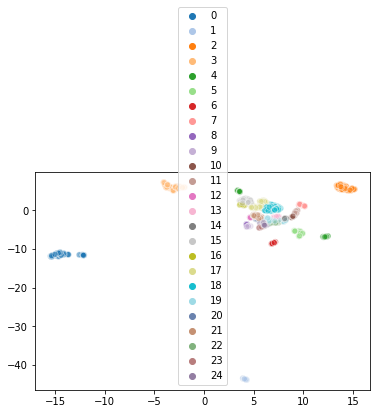

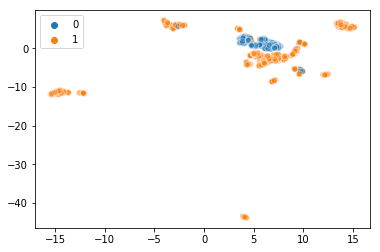

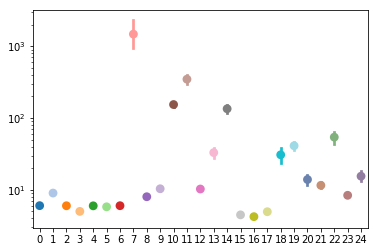

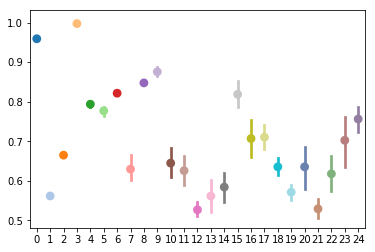

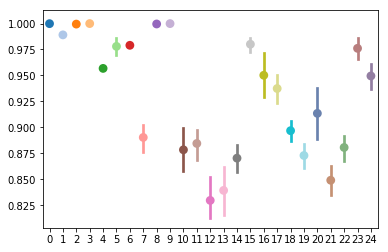

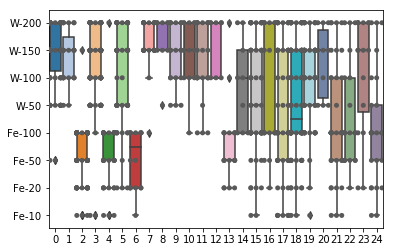

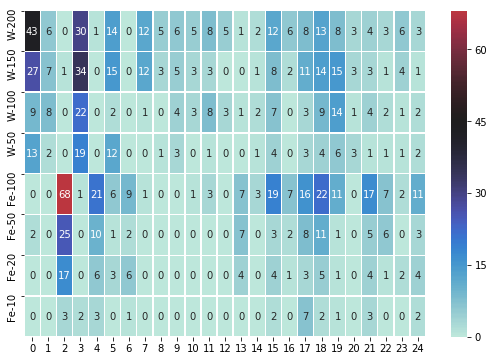

In [9]:
plotClassification(show_dim, cluster_labels, class_tags, tag)

In [39]:
diStd = {"s": [[8.263935089111328, -2.3291778564453125], [6.687559604644775, -2.4258484840393066], [9.883055686950684, -5.918602466583252], [9.8253173828125, -5.827345848083496], [9.72102165222168, -5.475344657897949], [6.744929313659668, 1.4957443475723267], [5.563161373138428, -1.3304996490478516], [-2.2249248027801514, 5.982654094696045], [4.187524318695068, -43.75392150878906], [8.092782974243164, -2.872755289077759], [-3.4174368381500244, 6.041979789733887], [4.087517261505127, 2.321263313293457], [9.723896026611328, -5.753288745880127], [-3.9426965713500977, 6.753472328186035], [5.826937675476074, -2.029068946838379], [-14.381933212280273, -11.406497955322266], [-2.630650043487549, 6.097029209136963], [-4.075504779815674, 7.222243785858154], [-3.4010772705078125, 5.671867370605469], [9.695610046386719, -5.530534267425537], [9.564345359802246, -6.6517744064331055], [-3.6027464866638184, 6.474538326263428], [4.39038610458374, -4.240881443023682], [9.77023696899414, -5.787482261657715], [-14.696500778198242, -11.930788040161133], [5.781933784484863, -3.4039506912231445], [-3.409897565841675, 6.022756099700928], [5.901717185974121, -3.371011972427368], [5.21491003036499, -2.1698524951934814], [4.210540771484375, -43.77701187133789], [-4.076254367828369, 7.224167346954346], [5.672131061553955, -4.412051200866699], [7.4173994064331055, 0.9785516858100891], [6.605060577392578, -3.458425998687744], [8.004579544067383, -2.906019449234009], [7.997211456298828, -2.8663930892944336], [5.691883563995361, -3.07804799079895], [-2.039954900741577, 5.93053674697876], [-3.0061144828796387, 5.306300640106201], [4.522037506103516, -4.1865386962890625], [5.154885768890381, -3.113750457763672], [9.685758590698242, -5.488798141479492], [-3.7021048069000244, 5.810242652893066], [-15.390172958374023, -11.970083236694336], [5.850353717803955, -2.88021183013916], [-12.110405921936035, -11.62505054473877], [6.955604553222656, -3.2885422706604004], [-12.145995140075684, -11.590214729309082], [-14.616687774658203, -11.955550193786621], [-13.70514965057373, -11.464293479919434], [9.661158561706543, -5.386014938354492], [4.454081058502197, -4.135655879974365], [9.585394859313965, -5.377826690673828], [-12.226096153259277, -11.692215919494629], [-3.6913068294525146, 5.889034748077393], [6.8887858390808105, -2.437685966491699], [-2.506336212158203, 5.899463176727295], [-12.363686561584473, -11.520752906799316], [9.598724365234375, -5.376906871795654], [-3.659384250640869, 6.4624342918396], [9.539618492126465, -6.712425231933594], [7.619292736053467, 0.6320045590400696], [4.635974884033203, 2.5728049278259277], [-14.56629753112793, -10.88475227355957], [6.018848419189453, -2.639610528945923], [3.569629192352295, 2.4762206077575684], [5.968206882476807, 2.4705677032470703], [7.912781238555908, -2.552785634994507], [-14.731790542602539, -11.877999305725098], [-3.3707988262176514, 5.922010898590088], [9.20632553100586, -0.4413031339645386], [7.387779235839844, 0.3015347719192505], [6.659249782562256, -3.2072393894195557], [-14.939979553222656, -11.599876403808594], [5.808218479156494, 2.152768850326538], [5.769890308380127, 1.0315515995025635], [4.2586822509765625, -3.5586109161376953], [-2.9556798934936523, 5.971643924713135], [-2.300157308578491, 5.8237810134887695], [-2.8116378784179688, 5.950557231903076], [7.975283622741699, -2.786867618560791], [-12.086766242980957, -11.575777053833008], [5.172991752624512, -2.2901558876037598], [4.61959171295166, 1.958451747894287], [9.250394821166992, -0.8314543962478638], [7.051963806152344, -2.7985546588897705], [7.5681047439575195, 0.46563684940338135], [9.225831031799316, -0.32448264956474304], [9.93372631072998, 1.2581959962844849], [9.326109886169434, -0.5889881253242493], [4.636361598968506, 2.1264166831970215], [7.3260416984558105, -2.5702500343322754], [9.664252281188965, -5.776792049407959], [8.942558288574219, -1.6700992584228516], [9.849905014038086, -5.991188049316406], [4.24933385848999, 3.0103702545166016], [-3.9710659980773926, 7.070363521575928], [9.239638328552246, -0.9835979342460632], [4.630602836608887, -1.8783153295516968], [-14.233325004577637, -11.44682788848877], [7.457998752593994, -2.6760518550872803], [6.895198822021484, 1.3137357234954834], [-3.79349684715271, 6.213210105895996], [6.690081596374512, -2.4200894832611084], [6.259982109069824, -2.896580934524536], [4.304882049560547, -43.8714714050293], [-12.127042770385742, -11.613682746887207], [-15.483704566955566, -11.875384330749512], [8.336893081665039, -2.677485704421997], [-1.9827349185943604, 5.97820520401001], [3.9102659225463867, 2.4900128841400146], [7.0860066413879395, 1.2643035650253296], [8.71045207977295, -1.960772156715393], [8.929704666137695, -1.7376956939697266], [4.597898483276367, -1.8468397855758667], [-3.3741703033447266, 5.992211818695068], [-14.998920440673828, -11.730531692504883], [5.480036735534668, -1.4583714008331299], [6.340549468994141, -3.7941980361938477], [-3.0382227897644043, 5.139408588409424], [3.7748682498931885, 2.3064119815826416], [3.9155116081237793, -43.48101043701172], [8.22744369506836, -2.2493300437927246], [4.948799133300781, -1.34171724319458], [-2.3372325897216797, 5.970659255981445], [8.539762496948242, -2.4773149490356445], [-2.773876905441284, 6.198081970214844], [7.27155065536499, 1.0608866214752197], [9.291333198547363, -0.2525648772716522], [-3.693943977355957, 5.766685485839844], [5.325291633605957, -2.3774662017822266], [4.946238994598389, 0.7135209441184998], [9.206158638000488, -0.95671546459198], [7.275979042053223, 0.728299617767334], [9.186882019042969, -0.3546060025691986], [4.9726996421813965, 0.941085696220398], [6.626920223236084, 1.5785434246063232], [6.702569007873535, 0.8773584365844727], [5.652829170227051, 2.1809628009796143], [-3.6921496391296387, 6.62389612197876], [7.156322956085205, -3.2712230682373047], [4.421420097351074, -4.151111125946045], [5.750092029571533, -3.5153560638427734], [-14.341964721679688, -11.52930736541748], [-2.323155403137207, 5.833591938018799], [5.831294059753418, -2.0433552265167236], [4.399861812591553, 2.1116013526916504], [4.493906497955322, -4.148795127868652], [7.935298919677734, -2.9310810565948486], [6.337769031524658, -2.6162967681884766], [-3.9440789222717285, 6.603724956512451], [3.959904193878174, -43.52541732788086], [-14.294090270996094, -11.458842277526855], [-3.802781820297241, 5.969799518585205], [6.416688919067383, -3.324685573577881], [4.523945331573486, 2.7290408611297607], [-2.6157515048980713, 5.671818733215332], [6.24052095413208, -2.175122022628784], [-3.9712865352630615, 7.097702980041504], [3.920260190963745, -43.485809326171875], [5.101875305175781, -1.1915658712387085], [5.785297870635986, -2.380528688430786], [8.78487777709961, -1.8156179189682007], [-4.059165954589844, 7.202695846557617], [-3.3040239810943604, 5.4943623542785645], [6.846479892730713, -2.5101125240325928], [8.027791023254395, -2.994260787963867], [3.845378875732422, 2.649317502975464], [5.762206077575684, 1.176291584968567], [6.341315269470215, -2.325470447540283], [-3.9084084033966064, 6.55620813369751], [6.5486297607421875, -2.4919002056121826], [4.688510417938232, -4.1230340003967285], [8.126922607421875, -2.3135714530944824], [7.524147987365723, -1.7372547388076782], [6.117751121520996, -3.3772003650665283], [-3.1207032203674316, 5.081915855407715], [-14.782116889953613, -11.88221549987793], [7.063475608825684, 1.3470016717910767], [7.353200435638428, -0.5026398301124573], [5.290844440460205, -3.1049158573150635], [4.671549320220947, -1.9057106971740723], [-2.641178846359253, 6.08518123626709], [-3.086716651916504, 5.054972171783447], [5.889143943786621, -2.3587374687194824], [6.7029032707214355, -2.4902842044830322], [6.80654239654541, -3.437293529510498], [-2.939739227294922, 6.020524501800537], [-14.764398574829102, -11.260438919067383], [5.590174674987793, -4.534350872039795], [4.571896553039551, -4.170015811920166], [3.970672845840454, -43.536075592041016], [7.378802299499512, -3.124627113342285], [6.722957611083984, -2.4837536811828613], [9.190733909606934, -0.9794268608093262], [3.8966641426086426, -43.46227264404297], [7.854801177978516, -2.994410514831543], [5.440060138702393, -2.327867031097412], [6.356626033782959, -3.187711715698242], [4.130418300628662, -43.694175720214844], [5.507484436035156, -2.8329288959503174], [6.524240016937256, -1.8855377435684204], [7.337324619293213, -2.7075672149658203], [7.367110252380371, 0.9094221591949463], [5.159158229827881, -1.9110089540481567], [4.021005153656006, -43.58638381958008], [-14.485807418823242, -10.877165794372559], [-2.595752477645874, 5.939169883728027], [9.977081298828125, 1.2013064622879028], [9.827005386352539, -6.130949020385742], [4.478115558624268, 2.146890640258789], [10.133475303649902, 1.0605636835098267], [3.5749971866607666, 2.439884662628174], [4.031852722167969, -43.59629821777344], [7.490988731384277, 0.5566573739051819], [-4.044270992279053, 7.236531734466553], [6.260401248931885, -3.003631591796875], [-3.069967269897461, 5.087447643280029], [7.957855701446533, -2.901697874069214], [5.341261386871338, -2.34246826171875], [10.016036033630371, 1.183423638343811], [5.437739849090576, -2.022383689880371], [-14.882683753967285, -11.395883560180664], [6.000441551208496, -2.6680076122283936], [7.17675256729126, 0.9423071146011353], [4.220268726348877, -43.786495208740234], [-3.3216617107391357, 5.9975056648254395], [7.400389194488525, 0.9133477807044983], [6.7504072189331055, -2.653575897216797], [6.287347316741943, 2.0815064907073975], [9.657881736755371, 1.577607274055481], [9.586028099060059, -6.286252498626709], [-14.492035865783691, -11.512580871582031], [9.856911659240723, -5.9890360832214355], [8.9303617477417, -1.6880913972854614], [9.916837692260742, -6.01526403427124], [6.7292656898498535, -3.1687514781951904], [-2.7585315704345703, 5.579759120941162], [-14.783235549926758, -11.113224029541016], [-2.0840981006622314, 6.015991687774658], [6.10499906539917, 2.4797799587249756], [-14.777997970581055, -11.260040283203125], [4.388989448547363, 2.8400702476501465], [7.05614709854126, 0.7023547291755676], [4.088657855987549, 2.2991557121276855], [5.153609275817871, 1.4055309295654297], [4.052692413330078, 2.9027297496795654], [9.537938117980957, -5.318321704864502], [9.556578636169434, 1.5029246807098389], [7.888307571411133, -2.7997775077819824], [-3.3197805881500244, 5.877364158630371], [6.426476955413818, -2.5674314498901367], [4.053504467010498, -43.618839263916016], [-3.0370891094207764, 5.16008186340332], [9.270495414733887, -0.46765533089637756], [7.485740661621094, 0.5550702810287476], [6.777212619781494, -2.58713436126709], [4.055017948150635, -43.62063980102539], [-2.9743845462799072, 5.236431121826172], [-3.8116323947906494, 5.900293827056885], [-15.26719856262207, -11.646178245544434], [8.90180778503418, -1.710593581199646], [-3.5813794136047363, 5.696348667144775], [5.867326259613037, -1.825021743774414], [8.240056037902832, -2.1920323371887207], [-15.428926467895508, -12.0372896194458], [5.671182632446289, 2.2299702167510986], [-3.0277695655822754, 5.176555633544922], [6.34849739074707, 1.9226373434066772], [5.666820049285889, -4.4523024559021], [5.56241512298584, -1.6397031545639038], [9.64033317565918, -6.532367706298828], [4.7628021240234375, 1.6975764036178589], [-2.741407632827759, 6.166813373565674], [3.6250979900360107, 1.4459782838821411], [10.125998497009277, 0.9738706350326538], [-12.18087387084961, -11.567837715148926], [6.028064727783203, 2.359091281890869], [-3.3711178302764893, 5.962327480316162], [6.947343826293945, 0.9854046702384949], [-14.275654792785645, -11.437304496765137], [5.561147689819336, -2.330734968185425], [4.404763698577881, -3.9135799407958984], [8.791834831237793, -1.87469482421875], [6.973783016204834, 0.8899973034858704], [-15.366424560546875, -11.783988952636719], [4.1511406898498535, -43.716712951660156], [4.260609149932861, -3.6260552406311035], [6.283041477203369, -2.5527312755584717], [5.857666969299316, -1.46811842918396], [6.999789714813232, -2.458312749862671], [-14.403480529785156, -11.432558059692383], [9.986662864685059, 1.1481575965881348], [6.0529704093933105, -2.295060396194458], [7.3762006759643555, 0.5798187851905823], [5.492279529571533, -3.5799357891082764], [9.855335235595703, -5.846759796142578], [-3.967987298965454, 6.788105010986328], [-12.121265411376953, -11.629308700561523], [7.413519859313965, 0.6962459683418274], [4.259127140045166, -3.5661230087280273], [4.969357013702393, -3.6001620292663574], [6.736573696136475, -3.0726993083953857], [-3.7654168605804443, 6.382170677185059], [8.35201644897461, -2.5486562252044678], [-2.6366872787475586, 5.666007995605469], [6.11592435836792, 1.8756245374679565], [6.53768253326416, -3.7696645259857178], [-2.702075719833374, 5.618048667907715], [5.688051223754883, -2.224837303161621], [7.522272109985352, -2.313671588897705], [7.171798229217529, -2.5227725505828857], [6.528125762939453, -3.5980217456817627], [-4.069355487823486, 7.200651168823242], [5.695312976837158, -3.8858752250671387], [4.903648376464844, 0.6818671822547913], [4.3034515380859375, -3.660872459411621], [6.65446662902832, -2.2745094299316406], [10.114829063415527, 1.078966736793518], [7.161462306976318, 1.123858094215393], [-14.638526916503906, -11.712387084960938], [7.4194841384887695, 0.6694644689559937], [-2.520674467086792, 6.02406644821167], [9.303377151489258, -0.5742141604423523], [4.200074672698975, -43.766117095947266], [4.078614711761475, 2.234226942062378], [5.615137100219727, 0.6438441872596741], [4.460397720336914, -4.2086591720581055], [9.576927185058594, -6.580406188964844], [-14.940491676330566, -11.247363090515137], [9.813603401184082, -5.96559476852417], [9.669397354125977, 1.5246479511260986], [7.321831703186035, 1.1106841564178467], [-2.3693480491638184, 5.896276950836182], [-14.736477851867676, -11.120135307312012], [9.607608795166016, -6.594906330108643], [-2.2120602130889893, 5.913527488708496], [4.766794204711914, 0.7533723711967468], [-3.8250179290771484, 5.906306266784668], [5.134945869445801, -1.3700191974639893], [9.788623809814453, 1.338087797164917], [5.57344388961792, -4.536175727844238], [6.170338153839111, 2.2057735919952393], [9.363799095153809, -0.4258233308792114], [-3.725924491882324, 6.530488014221191], [-14.554311752319336, -11.01244068145752], [7.716593265533447, 0.48672983050346375], [5.2458343505859375, -2.2146315574645996], [7.583773136138916, -2.7524147033691406], [5.825338363647461, -3.7942826747894287], [9.581707000732422, 1.470227599143982], [9.913076400756836, -5.912558555603027], [6.253805160522461, -2.328474998474121], [4.354457378387451, -4.312377452850342], [-12.583822250366211, -11.52547836303711], [3.964306592941284, 2.8007075786590576], [9.635708808898926, -6.551783561706543], [6.056902885437012, -2.5166409015655518], [-2.017056703567505, 5.940066337585449], [3.5854010581970215, 2.4528450965881348], [-3.806424379348755, 5.865394115447998], [-2.1419005393981934, 5.960019588470459], [6.9781107902526855, -3.461305856704712], [6.3450140953063965, 1.0314162969589233], [3.9230709075927734, 1.3798267841339111], [-14.848498344421387, -11.225576400756836], [-13.733915328979492, -11.42851448059082], [5.821263790130615, 2.136651039123535], [-14.460373878479004, -10.978658676147461], [-2.6035847663879395, 6.000092506408691], [-15.301347732543945, -11.944594383239746], [7.526391983032227, 0.4858364760875702], [9.620482444763184, 1.5541713237762451], [6.689347743988037, -1.8384079933166504], [9.626690864562988, -6.604159832000732], [5.766870021820068, -2.7772161960601807], [5.770572185516357, -4.181187629699707], [6.326395034790039, -2.073772430419922], [4.441713809967041, -4.158597469329834], [-3.9466300010681152, 6.788302421569824], [-3.6288795471191406, 5.92722225189209], [-3.8953564167022705, 6.55156946182251], [5.610347270965576, -4.506319046020508], [-15.132072448730469, -11.803703308105469], [9.796144485473633, -5.877452850341797], [6.044244289398193, -2.3331379890441895], [-2.80759334564209, 5.580512523651123], [5.867288112640381, -3.5625009536743164], [4.951189041137695, 0.6528362035751343], [-3.99202823638916, 7.008997917175293], [-15.4310302734375, -12.015693664550781], [-12.12653923034668, -11.62870979309082], [6.210025310516357, 1.4195419549942017], [8.002458572387695, -2.923405647277832], [4.063642978668213, -43.629215240478516], [-3.949232578277588, 6.511648178100586], [9.59466552734375, -6.611580848693848], [-14.847247123718262, -11.137899398803711], [6.831654071807861, -3.6056127548217773], [5.431267738342285, -1.919230580329895], [-14.55550765991211, -11.238500595092773], [13.345891952514648, 6.434643268585205], [-14.20781421661377, -11.431525230407715], [5.799764633178711, -1.770827293395996], [4.462666988372803, -4.1857380867004395], [-3.982778310775757, 6.96421480178833], [-15.353241920471191, -11.917001724243164], [5.945775508880615, 2.5565502643585205], [4.52799129486084, 1.62434983253479], [9.529190063476562, 1.3482271432876587], [7.435408592224121, 0.9065840840339661], [4.000174522399902, -43.565460205078125], [5.63297700881958, 0.14102965593338013], [5.1212239265441895, 0.7633795142173767], [9.813382148742676, 1.2388560771942139], [-2.4346261024475098, 5.904833793640137], [-15.370789527893066, -11.942388534545898], [5.827375411987305, 2.3897945880889893], [4.904533863067627, 1.5663620233535767], [4.506198406219482, 1.962007761001587], [9.661681175231934, -6.446514129638672], [5.577917098999023, 0.7409892082214355], [4.1313676834106445, 2.9545998573303223], [9.609491348266602, 1.5474879741668701], [9.739039421081543, 1.470096230506897], [9.123353958129883, -1.3834224939346313], [-2.904022216796875, 6.156515598297119], [-15.389277458190918, -11.881499290466309], [5.502018451690674, -2.2675509452819824], [3.6427125930786133, 2.334876298904419], [3.8163816928863525, 1.3618245124816895], [5.17122745513916, 0.5450747609138489], [9.74406909942627, 1.4736888408660889], [6.339086055755615, -2.352766990661621], [-13.658455848693848, -11.472822189331055], [10.110638618469238, 1.0690370798110962], [7.249198913574219, 0.7451132535934448], [4.3727874755859375, 2.727055311203003], [-14.600724220275879, -11.349397659301758], [-2.5854954719543457, 5.818671226501465], [5.88064432144165, 1.4028635025024414], [7.376928806304932, 0.2817913889884949], [5.661044597625732, -4.459835529327393], [4.645473480224609, 1.4209684133529663], [-3.7310891151428223, 6.694900989532471], [3.733208179473877, 2.2440433502197266], [7.005457878112793, -2.4806137084960938], [4.61621618270874, -1.8640849590301514], [-15.290499687194824, -11.937615394592285], [-12.177002906799316, -11.563969612121582], [6.972517967224121, 1.1631309986114502], [-3.778425693511963, 6.028830051422119], [10.13369083404541, 1.0868861675262451], [6.715304374694824, -3.169588088989258], [7.355111598968506, 0.9826691150665283], [4.30991792678833, -4.277456760406494], [9.601442337036133, -6.6809611320495605], [7.58311128616333, 0.7192507982254028], [7.425854206085205, -3.2394683361053467], [9.650843620300293, -6.051903247833252], [-14.547890663146973, -11.228796005249023], [-14.90269660949707, -11.400992393493652], [9.69618034362793, -5.546205997467041], [12.034421920776367, -6.98330020904541], [9.085906982421875, -1.2676727771759033], [-14.602489471435547, -11.29938793182373], [-14.617049217224121, -11.429787635803223], [-3.088622570037842, 5.095777988433838], [3.6733217239379883, 1.8533369302749634], [-3.302597999572754, 5.872278690338135], [-3.962751865386963, 6.541305065155029], [9.2417573928833, -0.8027932047843933], [-3.327338218688965, 5.9817681312561035], [7.505856037139893, -3.1991491317749023], [5.01993989944458, -3.8581912517547607], [-14.696002006530762, -11.229116439819336], [5.5997490882873535, -2.3079733848571777], [6.30826473236084, -2.3484511375427246], [4.969657897949219, 1.1840332746505737], [4.419957160949707, 2.663386583328247], [10.153932571411133, 1.009008765220642], [6.069535732269287, -2.767313241958618], [5.3403167724609375, -2.1932451725006104], [9.292672157287598, -0.2189907729625702], [4.317502975463867, -3.653019666671753], [-15.347229957580566, -11.847587585449219], [9.756656646728516, -5.853353023529053], [-3.8532586097717285, 5.937749862670898], [5.696609020233154, -2.276738405227661], [5.727393627166748, -4.378471851348877], [6.264163494110107, -2.5151901245117188], [7.153347969055176, 1.1779792308807373], [9.584750175476074, -6.613510608673096], [-14.456124305725098, -11.183889389038086], [6.184443950653076, -2.207840919494629], [4.331523418426514, -3.569193124771118], [-15.033112525939941, -11.43892765045166], [-14.370952606201172, -11.543882369995117], [-12.183964729309082, -11.62399673461914], [-14.504971504211426, -10.895642280578613], [6.797199726104736, 1.45146644115448], [3.9767656326293945, 2.3748486042022705], [8.260878562927246, -2.1601877212524414], [9.864334106445312, -6.025314807891846], [-12.115982055664062, -11.631434440612793], [9.888694763183594, -6.048238754272461], [-14.508820533752441, -11.05012035369873], [5.608371734619141, -4.53449821472168], [-12.101645469665527, -11.63756275177002], [4.090418338775635, -43.65604782104492], [6.1516337394714355, -3.9004640579223633], [-14.422016143798828, -11.564005851745605], [-12.198602676391602, -11.551830291748047], [-15.359111785888672, -11.940689086914062], [4.26449728012085, -4.295660495758057], [7.386940956115723, -1.6168714761734009], [7.1458258628845215, -2.852813482284546], [-14.105143547058105, -11.469265937805176], [5.6885151863098145, -4.274243354797363], [-15.351861953735352, -11.828365325927734], [7.296685695648193, -2.944106340408325], [8.955278396606445, -1.5313080549240112], [5.002972602844238, -1.3143171072006226], [7.530550479888916, 0.8053461313247681], [-12.1781644821167, -11.600905418395996], [3.670504570007324, 1.5661786794662476], [3.7762560844421387, 1.3833962678909302], [-15.287534713745117, -11.814860343933105], [4.2873759269714355, -3.594512462615967], [-3.7596049308776855, 5.852609634399414], [4.716143608093262, -1.7646883726119995], [-2.9710373878479004, 5.98752498626709], [-14.64755916595459, -11.895838737487793], [6.80670166015625, -3.1600866317749023], [4.586965560913086, 1.527111291885376], [4.916386127471924, 0.4396982789039612], [-12.239165306091309, -11.529245376586914], [9.638650894165039, 1.539347767829895], [4.121384143829346, 2.185767650604248], [-1.9479178190231323, 5.915523052215576], [9.355260848999023, -0.660404622554779], [5.584095478057861, -4.5355610847473145], [8.745940208435059, -1.9352127313613892], [-15.329961776733398, -11.712252616882324], [4.280328273773193, -3.6476552486419678], [9.608457565307617, -5.451260089874268], [5.540078639984131, -1.6515871286392212], [7.563676834106445, 0.5843024253845215], [4.796750545501709, -3.3336434364318848], [9.32023811340332, -0.22228209674358368], [-2.540325403213501, 6.086978435516357], [9.861949920654297, -5.952685356140137], [-2.4480767250061035, 5.880332946777344], [-2.771251916885376, 5.849164962768555], [-2.1957790851593018, 5.941956520080566], [4.240028381347656, 2.1563432216644287], [9.406563758850098, -0.024653520435094833], [-12.144886016845703, -11.644932746887207], [4.314542293548584, -4.285366535186768], [9.61449909210205, 1.627296805381775], [5.913162708282471, -3.742154598236084], [6.477957725524902, 1.7432094812393188], [5.468226909637451, 0.07131440937519073], [-15.240569114685059, -11.805517196655273], [4.086265563964844, 2.29742169380188], [9.61344051361084, 1.5663114786148071], [3.9743525981903076, 2.612051248550415], [5.062148094177246, 0.43059173226356506], [3.8343775272369385, 1.3734021186828613], [-4.034583568572998, 7.161040306091309], [9.738844871520996, -5.816043853759766], [6.556610107421875, 0.40667960047721863], [5.061793327331543, 1.1551525592803955], [5.145321369171143, 1.1480027437210083], [4.81942892074585, 0.7673519253730774], [-3.740441083908081, 6.027546405792236], [5.276561260223389, 0.04152761399745941], [9.413732528686523, -0.009598291479051113], [5.687188625335693, -2.995347261428833], [9.5526704788208, -6.694896697998047], [-3.0881597995758057, 5.095506191253662], [3.7076168060302734, 1.4791284799575806], [5.80971097946167, 0.2817017734050751], [-12.166505813598633, -11.628156661987305], [4.677559852600098, -1.9141048192977905], [9.289291381835938, -0.30912652611732483], [9.057450294494629, -5.267535209655762], [-15.181709289550781, -11.578837394714355], [7.169554710388184, -2.803612232208252], [-3.715506076812744, 6.5285258293151855], [-14.501326560974121, -11.097536087036133], [5.252748012542725, 1.0476092100143433], [9.215959548950195, -0.5318664908409119], [-2.9140594005584717, 5.99793815612793], [-15.359390258789062, -12.024587631225586], [5.6952948570251465, -4.245299339294434], [5.940129280090332, 2.44101619720459], [9.651930809020996, -6.486936092376709], [4.265533924102783, -3.766855478286743], [-15.370270729064941, -11.725934982299805], [7.179040908813477, -2.9016172885894775], [8.29936695098877, -2.1605136394500732], [6.321926593780518, -2.020210027694702], [-14.549631118774414, -11.130611419677734], [4.970771789550781, 1.311846375465393], [-2.6111347675323486, 5.999897003173828], [-3.1264820098876953, 5.146067142486572], [8.94944953918457, -1.62648606300354], [7.445326328277588, 0.5491828918457031], [8.944121360778809, -1.6287353038787842], [4.0279717445373535, 2.2991740703582764], [5.906620979309082, -2.5795507431030273], [5.936262130737305, 0.6587586998939514], [6.464794158935547, -2.751762628555298], [4.643136978149414, -1.8687875270843506], [4.479228973388672, -4.0820631980896], [-2.5604617595672607, 5.688016891479492], [-14.543559074401855, -11.214720726013184], [4.968070030212402, -2.0497519969940186], [-14.463687896728516, -11.591900825500488], [5.939906597137451, 1.4935905933380127], [6.112424850463867, -2.573760986328125], [4.661677837371826, -1.9033344984054565], [-2.876413345336914, 5.986258506774902], [-2.6311097145080566, 5.645212173461914], [3.7470405101776123, 1.4561058282852173], [4.056369304656982, -43.62187576293945], [5.376297473907471, -2.1104934215545654], [-3.6693451404571533, 6.578352451324463], [9.650096893310547, 1.5217708349227905], [4.9489240646362305, -1.2541005611419678], [7.193557262420654, 0.08321259915828705], [7.186555862426758, 0.8842853307723999], [4.308353900909424, 2.0597949028015137], [4.2689208984375, -43.83527755737305], [4.171787738800049, -43.7378044128418], [4.2502641677856445, -43.816551208496094], [5.132225513458252, -1.0973217487335205], [-14.3884916305542, -11.620453834533691], [5.997023582458496, -3.2050957679748535], [4.314795970916748, -4.2637152671813965], [-14.13074779510498, -11.134132385253906], [-2.1576650142669678, 5.950305461883545], [-2.867084264755249, 6.0772294998168945], [4.4475603103637695, -4.191074848175049], [5.901717662811279, -3.533557653427124], [6.299413681030273, -2.7920758724212646], [7.465493202209473, 0.7228623032569885], [-14.514759063720703, -10.915811538696289], [5.8696441650390625, 2.3976523876190186], [12.461187362670898, -6.709133625030518], [5.470758438110352, -1.3241361379623413], [13.412742614746094, 5.9301276206970215], [5.191568851470947, 0.6840528249740601], [4.9510111808776855, -1.2272162437438965], [5.613127708435059, -3.3826191425323486], [6.159573078155518, -4.0055766105651855], [6.086844444274902, 2.2544214725494385], [15.131705284118652, 5.415361404418945], [4.604419231414795, 2.647541046142578], [5.996055603027344, -4.184170246124268], [5.549781322479248, 0.653144896030426], [5.482837200164795, -2.6539576053619385], [4.778461933135986, 0.8398971557617188], [6.539426803588867, 0.9609194397926331], [5.360795021057129, -1.2434227466583252], [5.819550037384033, 2.40897536277771], [6.010371208190918, -3.4551169872283936], [6.349163055419922, 0.9830354452133179], [6.390146255493164, -3.7416439056396484], [6.802303314208984, -2.8032689094543457], [3.3720052242279053, 5.104104995727539], [6.776706695556641, -8.689973831176758], [6.152384281158447, 2.2309765815734863], [-2.017131805419922, 5.931639194488525], [5.679731369018555, -1.914648413658142], [14.02092170715332, 6.158916473388672], [4.160560607910156, 3.067774534225464], [-2.4408891201019287, 6.14717960357666], [3.3842685222625732, 5.089434623718262], [4.091221332550049, 2.6641228199005127], [9.125887870788574, -5.356666564941406], [7.1087493896484375, -2.4149115085601807], [6.7052903175354, 0.3270542621612549], [6.187279224395752, -3.3937690258026123], [12.259078979492188, -6.857635974884033], [7.187616348266602, -8.232276916503906], [7.200697898864746, 0.7464069724082947], [6.810841083526611, -8.65396499633789], [6.888537406921387, -3.1159493923187256], [13.686582565307617, 6.731483459472656], [6.091137886047363, -4.020928859710693], [4.574506759643555, 2.0397846698760986], [6.348231792449951, -0.5575294494628906], [3.603342056274414, 4.656455993652344], [13.429388046264648, 5.799328327178955], [12.385384559631348, -6.771370887756348], [5.743937015533447, -0.6062830090522766], [7.505115509033203, -1.6603249311447144], [13.75253963470459, 5.505416393280029], [6.013099670410156, 1.3404532670974731], [14.139150619506836, 5.558416843414307], [5.282931327819824, -1.727463960647583], [5.428288459777832, 1.0253605842590332], [9.175300598144531, -5.345452785491943], [14.832716941833496, 5.177549839019775], [5.525580883026123, -4.538405418395996], [5.6368608474731445, -4.242555618286133], [5.068554878234863, 0.6554872989654541], [13.728306770324707, 6.5132832527160645], [6.14816951751709, 0.44355615973472595], [6.255551815032959, -3.6627933979034424], [9.114343643188477, -5.38832950592041], [6.354418754577637, 0.6927279233932495], [13.837651252746582, 5.887820243835449], [13.780439376831055, 5.322617053985596], [13.381353378295898, 6.107731819152832], [5.597439289093018, -1.8862009048461914], [11.965984344482422, -6.8335161209106445], [6.808717727661133, -8.650117874145508], [5.057478427886963, -1.2656052112579346], [6.899323463439941, 1.3941869735717773], [4.8366312980651855, 2.6215415000915527], [13.853922843933105, 6.057734966278076], [14.883498191833496, 5.159296035766602], [12.41926097869873, -6.762760162353516], [7.13285493850708, -8.299324989318848], [14.36960506439209, 5.149050235748291], [3.8171772956848145, 2.3109192848205566], [7.086244106292725, -8.350602149963379], [7.159549236297607, -2.0035693645477295], [4.653415203094482, 2.127403736114502], [6.211275577545166, -3.6356661319732666], [6.532839298248291, 0.5227639079093933], [5.443817138671875, -1.599361538887024], [14.702970504760742, 5.071667194366455], [5.605556488037109, 2.3373677730560303], [7.926827907562256, 0.22390715777873993], [13.75156307220459, 5.911509037017822], [6.640275001525879, 0.10237851738929749], [7.565882682800293, -1.6606318950653076], [13.983200073242188, 6.140594482421875], [7.042072296142578, -8.419013023376465], [14.981746673583984, 5.325664043426514], [13.740620613098145, 5.538066864013672], [7.110544204711914, 1.1612640619277954], [6.978776931762695, -1.7538539171218872], [3.9071226119995117, 1.2700920104980469], [5.650276184082031, -2.8360230922698975], [12.398059844970703, -6.766952037811279], [-14.689950942993164, -11.071828842163086], [7.070315361022949, -3.286470651626587], [6.9002251625061035, -8.561737060546875], [14.129983901977539, 5.3114118576049805], [13.56486701965332, 6.29318380355835], [14.994205474853516, 5.287768840789795], [5.834304332733154, -1.7302300930023193], [7.331175804138184, 0.16509684920310974], [6.940304756164551, -3.1019859313964844], [6.091491222381592, 1.0832314491271973], [7.027426719665527, 0.7415558695793152], [13.99046516418457, 6.573787212371826], [4.942450046539307, -1.184503197669983], [12.31413459777832, -6.866341590881348], [5.655762672424316, -1.622717022895813], [14.851271629333496, 5.198184967041016], [5.812062740325928, 0.6516000032424927], [5.774326324462891, -1.7549315690994263], [13.826770782470703, 5.6921563148498535], [6.95522403717041, 0.14718909561634064], [13.553261756896973, 6.473114490509033], [13.679441452026367, 6.658829689025879], [5.961518287658691, -2.4574332237243652], [7.464202404022217, -1.7410718202590942], [14.585594177246094, 5.097011089324951], [6.742836952209473, 0.4115995466709137], [5.479735851287842, -2.8904495239257812], [13.941484451293945, 5.490825653076172], [13.965310096740723, 6.160094738006592], [7.391376972198486, -1.562685489654541], [5.72368049621582, -3.7313168048858643], [6.208027362823486, -3.118143320083618], [13.653194427490234, 5.498404502868652], [7.126950263977051, 1.0221102237701416], [6.743951797485352, -2.2434775829315186], [6.115342140197754, -3.651707410812378], [5.861173629760742, -1.7368701696395874], [12.443072319030762, -6.727906703948975], [6.246988773345947, -3.1239213943481445], [7.206998825073242, -3.2995173931121826], [7.290385723114014, 0.5629103779792786], [5.348395824432373, 0.6430198550224304], [6.900632381439209, 0.82096928358078], [13.49533748626709, 5.753048419952393], [6.729847431182861, -1.8154501914978027], [7.105612754821777, -2.0786056518554688], [13.891427993774414, 6.240258693695068], [5.946470260620117, -3.4907188415527344], [6.056673049926758, -4.002288818359375], [5.7448201179504395, -1.828797698020935], [12.093122482299805, -6.927163600921631], [13.942663192749023, 5.5000386238098145], [6.3573455810546875, 1.27108895778656], [5.884778022766113, 0.5319958329200745], [4.513082027435303, 2.077186107635498], [3.5070180892944336, 4.910165309906006], [-15.017653465270996, -11.406306266784668], [12.25092887878418, -6.903347492218018], [6.321753978729248, 0.6182166934013367], [3.6377007961273193, 1.5009078979492188], [13.74223804473877, 5.386017322540283], [4.411396503448486, 2.785515785217285], [13.786542892456055, 5.694375991821289], [7.161543369293213, 0.25764378905296326], [7.301555633544922, -3.134995460510254], [5.8037495613098145, 2.2644824981689453], [7.863109588623047, -2.3557024002075195], [4.798923015594482, 0.9110679626464844], [6.219512939453125, -0.3259658217430115], [6.547285079956055, -2.9485652446746826], [13.562735557556152, 5.5296783447265625], [12.196829795837402, -6.872435569763184], [5.447350025177002, -0.2704225480556488], [7.249898910522461, 0.44536831974983215], [9.720229148864746, -5.544033050537109], [7.314484596252441, -1.6689012050628662], [13.685513496398926, 5.433414459228516], [7.309640884399414, -1.6870180368423462], [12.4450044631958, -6.7268829345703125], [6.553735733032227, -2.5616161823272705], [5.782204627990723, 0.509669840335846], [7.391537189483643, -1.6254973411560059], [13.983903884887695, 5.279632568359375], [3.3523592948913574, 5.126987457275391], [7.3865556716918945, -1.6053895950317383], [3.364586114883423, 5.106756210327148], [7.151898384094238, 0.9163411855697632], [14.641411781311035, 5.351745128631592], [13.727962493896484, 5.748152256011963], [5.82786750793457, 2.4346675872802734], [6.089067459106445, -0.06156597658991814], [5.505499839782715, -1.4396536350250244], [7.220918655395508, -3.1524012088775635], [5.242862224578857, 0.4953668415546417], [5.250725746154785, -1.5458492040634155], [14.79830265045166, 5.202031135559082], [5.405909061431885, -0.3874276280403137], [4.928840160369873, -1.3755425214767456], [7.52154541015625, -1.7320351600646973], [4.966382026672363, -1.3085265159606934], [7.060815811157227, -8.385568618774414], [6.108438491821289, 0.502443253993988], [13.610861778259277, 5.671238899230957], [12.38499641418457, -6.758528709411621], [7.343118190765381, -3.151366949081421], [4.056138515472412, 2.3759942054748535], [4.103860378265381, 1.257638931274414], [13.616910934448242, 6.3934550285339355], [7.380049705505371, -1.607967734336853], [5.883911609649658, 0.17613650858402252], [13.863082885742188, 6.611932277679443], [13.732314109802246, 5.856095314025879], [14.181283950805664, 5.598357677459717], [5.8316426277160645, -3.096569776535034], [9.27630615234375, -0.755874514579773], [6.084850788116455, -3.3289475440979004], [7.512295246124268, -2.5411527156829834], [7.5120649337768555, 0.47907042503356934], [15.022011756896973, 5.418497085571289], [6.271615505218506, -2.2572944164276123], [14.080695152282715, 6.2548956871032715], [6.207943916320801, 2.100632429122925], [9.12092113494873, -0.7160206437110901], [6.327055931091309, -0.24907757341861725], [7.404565811157227, -3.0201163291931152], [12.102519989013672, -6.925806522369385], [5.834776401519775, -2.251682758331299], [9.25890827178955, -0.1969446986913681], [6.889525890350342, -8.565460205078125], [4.099656581878662, 2.674844264984131], [14.044390678405762, 6.386845588684082], [6.421735763549805, 0.34287190437316895], [6.931248664855957, 0.3814946413040161], [5.700324535369873, 0.5084114074707031], [5.721875190734863, 1.8532748222351074], [6.87251615524292, -0.13521119952201843], [4.617751598358154, 2.012725353240967], [13.986347198486328, 6.4979705810546875], [7.545580863952637, -1.7709702253341675], [4.685638427734375, 1.3770173788070679], [7.433793067932129, -2.872176170349121], [13.962043762207031, 6.431155681610107], [8.448976516723633, -1.3248589038848877], [7.306002140045166, -2.528939962387085], [5.052382469177246, 0.9485260844230652], [4.665354251861572, 1.4137135744094849], [5.201971054077148, -1.6378506422042847], [13.95401382446289, 5.779553413391113], [13.952715873718262, 5.43914794921875], [6.168085098266602, -2.7337865829467773], [13.484077453613281, 5.872311115264893], [3.778087854385376, 2.7634313106536865], [8.068787574768066, -2.223315477371216], [4.919329643249512, 0.593513548374176], [5.904273986816406, -0.021456077694892883], [5.425187587738037, -0.1188899502158165], [5.521327972412109, 0.7441367506980896], [8.138181686401367, -2.0444493293762207], [3.7244033813476562, 1.439662218093872], [5.926703929901123, -3.229107618331909], [3.5464205741882324, 4.864724636077881], [15.151384353637695, 5.436625957489014], [13.605643272399902, 6.512903690338135], [3.5236926078796387, 4.901095867156982], [8.93774700164795, -1.5302505493164062], [3.6816508769989014, 2.2929790019989014], [5.674172878265381, 0.8401658535003662], [6.772390842437744, 0.9909114837646484], [7.301669597625732, 0.34028974175453186], [3.3800265789031982, 5.093372344970703], [10.102328300476074, 1.117647647857666], [14.881505966186523, 5.296185493469238], [13.813079833984375, 5.849480628967285], [6.822999954223633, -2.9482858180999756], [4.39550256729126, 2.9454476833343506], [3.6116976737976074, 4.799590110778809], [3.5893187522888184, 1.3493320941925049], [5.812839984893799, -0.8780774474143982], [13.740739822387695, 6.69194221496582], [4.852243423461914, 0.7009791731834412], [14.72221565246582, 5.451478958129883], [5.383699893951416, -3.034409284591675], [4.605654239654541, 0.9433718919754028], [6.075037002563477, 2.2928526401519775], [6.517696380615234, -3.2585389614105225], [14.358131408691406, 6.1285295486450195], [4.5625901222229, 2.015575885772705], [5.3426642417907715, -1.8140380382537842], [7.1738715171813965, -8.179729461669922], [5.5476531982421875, 1.0618324279785156], [14.004761695861816, 6.38770866394043], [6.4026265144348145, -3.6597118377685547], [15.011364936828613, 5.33396053314209], [4.006272792816162, 2.3260610103607178], [4.7670979499816895, 0.9259299039840698], [3.4033515453338623, 5.063518524169922], [7.462813377380371, -1.5872888565063477], [7.371153831481934, 0.43729403614997864], [3.579162120819092, 4.834165096282959], [13.590926170349121, 6.612738609313965], [5.7545881271362305, 2.2867720127105713], [5.0944952964782715, -1.3757346868515015], [3.999011993408203, 1.267524003982544], [6.871224880218506, -3.223782539367676], [13.87932014465332, 5.9666361808776855], [3.578660726547241, 4.83891487121582], [5.685547351837158, -1.8810036182403564], [12.252124786376953, -6.908025741577148], [5.431779384613037, -1.588475227355957], [6.0374603271484375, -3.8849270343780518], [14.749261856079102, 5.12141227722168], [15.179289817810059, 5.434840202331543], [7.091009616851807, -8.353349685668945], [13.60939884185791, 6.659672260284424], [4.097746849060059, 2.6332032680511475], [6.011171817779541, -0.7588510513305664], [13.777164459228516, 6.375284671783447], [14.161291122436523, 6.349629878997803], [15.132645606994629, 5.4212141036987305], [14.807974815368652, 5.109444618225098], [13.831460952758789, 6.145631790161133], [7.2218337059021, -2.9817564487457275], [5.817898750305176, -2.8767051696777344], [5.395020008087158, -1.274875521659851], [6.033606052398682, -4.164044380187988], [14.445088386535645, 5.138812065124512], [7.074339866638184, -1.8783851861953735], [13.760847091674805, 5.5148606300354], [6.4498209953308105, -3.2610740661621094], [13.615973472595215, 6.136751651763916], [13.894996643066406, 6.148678779602051], [5.58586311340332, -0.9189377427101135], [-2.184378147125244, 5.840665340423584], [7.056064128875732, 0.06731150299310684], [6.264719009399414, 0.5401240587234497], [4.850028038024902, 0.783338725566864], [4.766043186187744, 2.038806200027466], [14.966773986816406, 5.565439701080322], [14.122679710388184, 5.919614315032959], [3.8358240127563477, 1.3699277639389038], [7.112629413604736, 0.09046487510204315], [5.907343864440918, 0.9438647031784058], [7.859337329864502, -2.6457772254943848], [9.138005256652832, -5.381507396697998], [14.824540138244629, 5.218255996704102], [6.717252731323242, -1.6326998472213745], [5.479839324951172, -2.93574857711792], [6.704295635223389, -0.2554725110530853], [14.00141716003418, 6.1591081619262695], [5.890474796295166, 2.3007771968841553], [7.3564252853393555, 0.09945542365312576], [15.009073257446289, 5.312567234039307], [6.380824565887451, -2.680450677871704], [7.087277889251709, -8.35904598236084], [7.443851470947266, -1.632083773612976], [5.729366302490234, 2.2248940467834473], [9.599498748779297, -6.689812660217285], [6.975003719329834, 0.030593497678637505], [5.20790958404541, -0.14303942024707794], [8.225449562072754, -2.6410205364227295], [7.001649856567383, -3.1079981327056885], [5.816174507141113, 1.1787227392196655], [12.272811889648438, -6.784645080566406], [13.939055442810059, 6.390569686889648], [13.927379608154297, 6.386011123657227], [5.380393981933594, -1.5936226844787598], [6.362647533416748, -3.3540966510772705], [12.317889213562012, -6.810910701751709], [5.536756992340088, -1.6439988613128662], [13.921463966369629, 6.255115509033203], [3.9071075916290283, 2.7601733207702637], [13.688078880310059, 6.196732997894287], [12.477581024169922, -6.680042743682861], [13.874799728393555, 6.236781120300293], [6.85623836517334, -8.606420516967773], [5.569226264953613, 0.22388792037963867], [5.1579179763793945, -1.1656463146209717], [5.17508602142334, -1.5488492250442505], [5.851566314697266, -2.829073667526245], [14.301841735839844, 6.182145595550537], [6.558932304382324, -2.3494787216186523], [5.090957164764404, -1.261364221572876], [3.5485968589782715, 4.861621379852295], [7.548325061798096, -2.5342516899108887], [6.114717960357666, -0.04839976131916046], [14.841318130493164, 5.1710429191589355], [3.5843629837036133, 4.829999923706055], [4.4876604080200195, 2.513981819152832], [5.797990798950195, -0.9444323182106018], [6.151224613189697, -0.007530654780566692], [13.498746871948242, 6.34435510635376], [4.431378364562988, 2.8370749950408936], [13.423081398010254, 6.349318027496338], [6.854273796081543, -8.608556747436523], [13.538372993469238, 6.489305019378662], [5.0439534187316895, -1.2901878356933594], [7.070247650146484, 0.154891237616539], [5.949091911315918, -3.724377393722534], [6.4243927001953125, -2.0921435356140137], [6.702760219573975, -2.4651293754577637], [12.331515312194824, -6.8021392822265625], [12.335763931274414, -6.801121234893799], [5.724275588989258, -1.9997546672821045], [6.093542575836182, -2.016347646713257], [3.617037534713745, 1.4882936477661133], [5.42749547958374, 1.667250633239746], [6.7265706062316895, -3.0273756980895996], [6.683355808258057, -3.3257386684417725], [4.7709784507751465, 2.4877943992614746], [13.963236808776855, 6.184756278991699], [14.62890911102295, 5.1016526222229], [5.6024980545043945, 0.8711366653442383], [14.314045906066895, 5.587400913238525], [15.057320594787598, 5.429882049560547], [13.873181343078613, 6.4823384284973145], [5.988365173339844, -3.1410152912139893], [13.961055755615234, 5.925379753112793], [5.308557510375977, -1.6473734378814697], [3.913344621658325, 2.457336902618408], [4.473603248596191, 2.1667706966400146], [5.06640100479126, -1.3033369779586792], [9.673529624938965, -5.996161937713623], [6.0193281173706055, -1.9729030132293701], [13.979236602783203, 5.345264911651611], [14.111905097961426, 6.211624622344971], [6.589069366455078, -2.7031195163726807], [7.217564105987549, -3.2831385135650635], [6.537161350250244, -2.975902795791626], [7.5179948806762695, 0.08003456890583038], [3.7274200916290283, 1.5265617370605469], [15.109589576721191, 5.417933464050293], [5.497889041900635, -2.1282031536102295], [4.6659770011901855, 2.621394395828247], [7.260840892791748, -2.6769344806671143], [5.5052714347839355, 1.0110127925872803], [7.275940895080566, -1.6703946590423584], [6.40139102935791, -2.0041584968566895], [5.733677387237549, -3.597285270690918], [5.19256067276001, 0.6673082113265991], [6.007110595703125, -0.36870887875556946], [5.109689235687256, -1.564469814300537], [3.5939831733703613, 4.774510383605957], [6.294826984405518, 0.8685808181762695], [5.438448429107666, -2.3193390369415283], [7.063414096832275, -8.382977485656738], [5.7983903884887695, -4.357754707336426], [7.291086673736572, 0.4065764546394348], [5.579509735107422, 1.1248867511749268], [12.217647552490234, -6.848810195922852], [13.867939949035645, 5.414338111877441], [5.669963359832764, -2.734682321548462], [14.253854751586914, 5.75129508972168], [6.000091552734375, -3.503368854522705], [4.410174369812012, 2.004945755004883], [3.9898264408111572, 2.964355230331421], [7.115088939666748, -2.7782697677612305], [13.511859893798828, 6.43018102645874], [13.874231338500977, 5.388440132141113], [6.453719139099121, -0.1207880899310112], [6.316545486450195, 0.2497933804988861], [6.0821757316589355, -2.7623682022094727], [7.113014221191406, 0.04044916853308678], [3.5503110885620117, 4.875464916229248], [4.764462471008301, 0.7273051738739014], [6.040892601013184, -3.801157236099243], [8.114009857177734, -2.1765105724334717], [5.395496845245361, -1.2627618312835693], [6.561464786529541, 0.7916616201400757], [12.148358345031738, -6.90226411819458], [14.202313423156738, 5.541927337646484], [3.8611574172973633, 1.471828579902649], [6.840885162353516, -8.622781753540039], [5.388232231140137, -2.7872071266174316], [7.065643787384033, -8.381053924560547], [13.736409187316895, 6.718626976013184], [13.83406925201416, 5.919973373413086], [5.70687198638916, 0.4491829574108124], [9.149510383605957, -5.4044060707092285], [6.156920909881592, -3.9086732864379883], [5.807584762573242, -1.1107478141784668], [3.8697938919067383, 1.8473105430603027], [4.639286994934082, -3.5575759410858154], [3.9031460285186768, 2.617947816848755], [5.615887641906738, -1.4653286933898926], [9.925436019897461, -5.993077278137207], [6.079363822937012, -3.869368076324463], [5.012856483459473, -1.4009745121002197], [14.891057968139648, 5.697364807128906], [9.607318878173828, -6.616092205047607], [3.613987922668457, 4.819096565246582], [14.700113296508789, 5.227287769317627], [13.76729679107666, 6.123264312744141], [4.778418064117432, 2.6002397537231445], [5.627357482910156, 0.3467382788658142], [6.248537540435791, 0.3416067659854889]], "r": [[-2.0520384311676025, -0.5082473754882812, -0.9041638970375061, -5.721530437469482, -1.389121651649475, -4.908210277557373, -6.244410991668701, 2.2827906608581543, -1.970600962638855, 1.177232027053833, 1.2302823066711426, 2.9751393795013428], [-2.4365456104278564, -0.6820483207702637, 0.06735231727361679, -5.793984413146973, -1.476083517074585, -4.321712017059326, -5.862000465393066, 1.3311293125152588, -2.1728463172912598, 0.6411986351013184, 0.9459265470504761, 3.723491907119751], [-1.5232477188110352, 0.3120601773262024, -0.530034065246582, -2.2044832706451416, 0.36373987793922424, -0.41223451495170593, -1.2564340829849243, -0.04551030695438385, 0.13940589129924774, -0.9545307755470276, 0.09613834321498871, 1.010617971420288], [-1.5134371519088745, 0.29125770926475525, -0.5585363507270813, -2.235337495803833, 0.34313470125198364, -0.4471369683742523, -1.2892719507217407, -0.008742292411625385, 0.10417916625738144, -1.0074018239974976, 0.051048919558525085, 0.9656391143798828], [-1.5032297372817993, 0.17458894848823547, -0.2777356505393982, -2.3797991275787354, 0.3156166970729828, -0.4165690839290619, -1.3140826225280762, 0.03961675986647606, 0.2980969250202179, -0.9036815762519836, -0.037963662296533585, 1.0307245254516602], [-1.3742583990097046, -0.8147768974304199, -1.1876447200775146, -3.446810245513916, -0.5690867304801941, -3.3629958629608154, -4.826244354248047, 1.9109838008880615, -0.970981240272522, 1.1375846862792969, 0.8397716879844666, 1.8941653966903687], [-2.16310453414917, -0.5137587189674377, -0.24486464262008667, -5.166352272033691, -1.2434768676757812, -3.820347309112549, -4.829898834228516, 0.8494540452957153, -2.015087127685547, 0.3020554184913635, 0.5797329545021057, 2.809755563735962], [0.4248999059200287, -2.2274105548858643, 5.188381195068359, 2.363485336303711, 0.7955161333084106, 0.8185839056968689, -1.0832762718200684, 0.0073248655535280704, 1.39333176612854, 0.08499865233898163, 0.9152909517288208, -1.33983314037323], [-1.2756409645080566, 11.302286148071289, -0.2204580008983612, -0.3379921019077301, -1.8114537000656128, -0.0827803909778595, 2.8308911323547363, 0.08126769959926605, 0.5949394702911377, 0.15143311023712158, -2.0914950370788574, 1.7535616159439087], [-2.3230667114257812, -0.6334050297737122, -0.44450849294662476, -5.929494857788086, -1.498719573020935, -4.74442720413208, -6.371981620788574, 1.9971539974212646, -2.0442123413085938, 1.1157283782958984, 1.2165099382400513, 3.5380334854125977], [0.5768161416053772, -1.6572129726409912, 6.063340187072754, 2.8658227920532227, 0.9967869520187378, 0.5039798617362976, -0.7256560921669006, 0.2104865163564682, 1.4808886051177979, 0.13068945705890656, 0.7232567667961121, -1.0114673376083374], [-1.1844229698181152, -0.7620693445205688, 0.06730937957763672, -2.6928329467773438, -0.1380092203617096, -2.299086570739746, -3.4485127925872803, 0.7662126421928406, -0.6805201172828674, 0.5557835102081299, 0.2436450868844986, 1.099719524383545], [-1.4754313230514526, 0.24140521883964539, -0.46712103486061096, -2.2761037349700928, 0.2947366535663605, -0.461701899766922, -1.3300265073776245, 0.001427125302143395, 0.13935108482837677, -0.9631633162498474, 0.02992618829011917, 0.9654275178909302], [-0.09086549282073975, -1.8674752712249756, 6.6362104415893555, 2.779503345489502, 1.10678231716156, 0.2690977454185486, -0.45208504796028137, 0.39479929208755493, 1.6675390005111694, 0.36792561411857605, 0.6071546077728271, -0.9398606419563293], [-2.2930517196655273, -0.6813204288482666, 0.10123766213655472, -5.390298843383789, -1.2634671926498413, -3.9271883964538574, -5.1816205978393555, 0.931530773639679, -2.1365725994110107, 0.2349340319633484, 0.6508605480194092, 3.3970463275909424], [11.53120231628418, 3.982513904571533, -4.638068675994873, 1.458080530166626, -1.2557727098464966, 0.6469533443450928, 1.5170962810516357, 3.2728633880615234, 0.4351330101490021, 1.8882359266281128, -0.21596410870552063, -1.3477853536605835], [0.2581787407398224, -2.095501661300659, 5.542851448059082, 2.5286307334899902, 0.8857817053794861, 0.7338485717773438, -1.0171384811401367, 0.06324068456888199, 1.418304681777954, 0.13957713544368744, 0.8955219984054565, -1.3091754913330078], [-0.3355366587638855, -2.046332836151123, 6.763564109802246, 2.7006192207336426, 1.2856518030166626, 0.15555711090564728, -0.3195416331291199, 0.3273085355758667, 1.6656734943389893, 0.3076656460762024, 0.7349582314491272, -0.9969655275344849], [0.4458422064781189, -1.8217480182647705, 5.6557183265686035, 2.502316951751709, 0.9621418714523315, 0.4631602466106415, -0.7413230538368225, 0.19941852986812592, 1.4949700832366943, 0.3264017105102539, 0.6582663655281067, -0.942487895488739], [-1.5257377624511719, 0.2188204675912857, -0.317903995513916, -2.3438374996185303, 0.33754390478134155, -0.37315306067466736, -1.2599833011627197, 0.0022184273693710566, 0.3024279475212097, -0.9110340476036072, 0.0006260353839024901, 1.0551356077194214], [-1.8298007249832153, 0.49473291635513306, -0.4544612765312195, -1.7269343137741089, 0.4464374780654907, -0.20737586915493011, -1.0176784992218018, -0.34258130192756653, 0.25947314500808716, -1.0122199058532715, 0.4461854100227356, 1.1857554912567139], [-0.0016017776215448976, -1.907552719116211, 6.366506099700928, 2.739797592163086, 1.011093258857727, 0.42270761728286743, -0.675849437713623, 0.33107662200927734, 1.5726205110549927, 0.30029207468032837, 0.6644386053085327, -1.0538854598999023], [-2.520153045654297, -0.151496022939682, -0.27970534563064575, -7.006792068481445, -1.817582607269287, -4.895665168762207, -5.063943862915039, 0.41726547479629517, -3.608628749847412, -0.8554136157035828, 0.10595372319221497, 3.4791159629821777], [-1.5464447736740112, 0.2958812117576599, -0.4391994774341583, -2.2448368072509766, 0.33574819564819336, -0.3856077194213867, -1.2435531616210938, -0.04828568547964096, 0.21484634280204773, -0.907967746257782, 0.09795162826776505, 1.0568835735321045], [11.512757301330566, 3.937398672103882, -4.380892753601074, 1.4491931200027466, -1.1964207887649536, 0.7113914489746094, 1.3894548416137695, 3.210500478744507, 0.44250309467315674, 1.901759386062622, -0.31521227955818176, -1.361859917640686], [-2.1119940280914307, -0.19418039917945862, -0.22520606219768524, -5.822354316711426, -1.5881619453430176, -4.548140048980713, -5.389633655548096, 1.2555389404296875, -2.701225519180298, 0.06356959789991379, 0.43890342116355896, 3.027567148208618], [0.6589025855064392, -1.6661927700042725, 5.976737976074219, 2.8685364723205566, 1.0123631954193115, 0.5088599324226379, -0.7322049736976624, 0.1671762466430664, 1.4506675004959106, 0.07689473032951355, 0.7793775796890259, -1.0379873514175415], [-2.072456121444702, -0.15891727805137634, -0.3451063632965088, -5.8290486335754395, -1.6215871572494507, -4.629275321960449, -5.363403797149658, 1.3180009126663208, -2.7055320739746094, 0.12923096120357513, 0.45599833130836487, 2.9018361568450928], [-2.1965343952178955, -0.6521786451339722, 0.1218964159488678, -5.438763618469238, -1.1781500577926636, -3.851879119873047, -5.021981716156006, 0.8279765844345093, -2.172541618347168, 0.004645176697522402, 0.5588140487670898, 3.348149299621582], [-1.334289789199829, 11.375394821166992, -0.19720026850700378, -0.26524755358695984, -1.7379753589630127, -0.1096620038151741, 2.807131052017212, 0.10390202701091766, 0.5330855846405029, 0.12566453218460083, -2.154334545135498, 1.7765463590621948], [-0.35952696204185486, -2.071730852127075, 6.734898567199707, 2.6851861476898193, 1.2780684232711792, 0.17446789145469666, -0.3398810625076294, 0.3151613175868988, 1.6426734924316406, 0.31965237855911255, 0.7469289898872375, -1.0182451009750366], [-1.962020993232727, 0.2466854602098465, -0.5416427254676819, -5.946900367736816, -1.8844670057296753, -4.904296875, -5.283910751342773, 1.4090051651000977, -3.121307134628296, -0.05514005944132805, 0.12708428502082825, 2.574862241744995], [-1.3606480360031128, -0.7906937003135681, -1.1262762546539307, -3.598893404006958, -0.32492971420288086, -3.3826513290405273, -5.116865634918213, 2.1840832233428955, -0.8016127943992615, 0.922617495059967, 0.9220978617668152, 2.1395299434661865], [-2.297837972640991, -0.3219704329967499, -0.30929824709892273, -6.180233478546143, -1.6639666557312012, -4.766387939453125, -5.713786602020264, 1.3561735153198242, -2.6800684928894043, 0.29180750250816345, 0.6830633282661438, 3.295222520828247], [-2.345968246459961, -0.6209843754768372, -0.42091596126556396, -5.952016830444336, -1.5246810913085938, -4.749990940093994, -6.375202178955078, 1.9674643278121948, -2.070758104324341, 1.094633936882019, 1.2005971670150757, 3.562662124633789], [-2.3692469596862793, -0.6071915626525879, -0.4220855236053467, -6.008345127105713, -1.5555381774902344, -4.798304080963135, -6.391209125518799, 1.963621735572815, -2.119964838027954, 1.1016377210617065, 1.204657793045044, 3.570729970932007], [-2.0949220657348633, -0.3657212555408478, -0.35701316595077515, -5.733380317687988, -1.3812861442565918, -4.4015583992004395, -5.208899974822998, 1.2254397869110107, -2.510314702987671, 0.07228898257017136, 0.5858995914459229, 2.9185192584991455], [0.36160746216773987, -2.3255674839019775, 5.074217319488525, 2.2827963829040527, 0.76507169008255, 0.8433612585067749, -1.106078028678894, 0.04090210795402527, 1.4056047201156616, 0.13735954463481903, 0.9070447087287903, -1.390036702156067], [0.70606929063797, -1.7153719663619995, 5.418673992156982, 2.513035535812378, 1.0042953491210938, 0.32480403780937195, -0.6574554443359375, 0.18022286891937256, 1.4152404069900513, 0.22238749265670776, 0.7230934500694275, -0.905706524848938], [-2.485104560852051, -0.16825424134731293, -0.25245651602745056, -6.901585102081299, -1.7578237056732178, -4.923391342163086, -5.239377498626709, 0.5963526368141174, -3.4674079418182373, -0.656063973903656, 0.19842785596847534, 3.420830011367798], [-2.210606336593628, -0.4111797511577606, -0.23249076306819916, -5.821464538574219, -1.3771634101867676, -4.3428263664245605, -5.06080436706543, 0.9419341683387756, -2.6626675128936768, -0.1307756006717682, 0.4801345765590668, 3.0769436359405518], [-1.505958080291748, 0.17190182209014893, -0.28260043263435364, -2.387849807739258, 0.3172493577003479, -0.41433364152908325, -1.3131709098815918, 0.04634198546409607, 0.29482096433639526, -0.8990045189857483, -0.044164448976516724, 1.033987045288086], [0.3903953433036804, -1.7319955825805664, 6.035767555236816, 2.6769590377807617, 0.9663115739822388, 0.4710482954978943, -0.6822634935379028, 0.2633515000343323, 1.5781071186065674, 0.33032360672950745, 0.5832737684249878, -0.8936033844947815], [11.588038444519043, 3.8453078269958496, -4.499243259429932, 1.4023693799972534, -1.2714890241622925, 0.6818907260894775, 1.0673402547836304, 2.503303050994873, 0.4431537687778473, 1.7402679920196533, -0.25438445806503296, -1.4063001871109009], [-2.3836960792541504, -0.5071350336074829, 0.007922668009996414, -5.909692287445068, -1.5343760251998901, -4.397062301635742, -5.53259801864624, 1.0729924440383911, -2.5128836631774902, 0.22482147812843323, 0.6459869146347046, 3.541442632675171], [11.869110107421875, 4.373608112335205, -5.73624849319458, 1.7269821166992188, -1.1675279140472412, 0.27982908487319946, 1.7208009958267212, 3.9527266025543213, 1.315548300743103, 1.637531042098999, 1.012973427772522, -0.975247859954834], [-2.0835602283477783, -0.44152337312698364, -0.4973236620426178, -5.938068866729736, -1.433157205581665, -4.603744983673096, -5.551363945007324, 1.6041929721832275, -2.348421335220337, 0.4205676019191742, 0.8895986676216125, 2.9340450763702393], [11.816046714782715, 4.374009132385254, -5.7077956199646, 1.6556503772735596, -1.120365023612976, 0.2841889560222626, 1.6989763975143433, 3.8832223415374756, 1.2945195436477661, 1.6366486549377441, 0.9750667810440063, -1.0434333086013794], [11.508702278137207, 3.9522671699523926, -4.40350341796875, 1.4503880739212036, -1.192492961883545, 0.7020780444145203, 1.4151617288589478, 3.2612452507019043, 0.446216344833374, 1.9057364463806152, -0.3045153021812439, -1.3529536724090576], [11.625725746154785, 4.112374782562256, -5.1087236404418945, 1.565057396888733, -1.1838651895523071, 0.5162145495414734, 1.5913643836975098, 3.6818747520446777, 0.7812157869338989, 1.870241403579712, 0.274294912815094, -1.178572416305542], [-1.5065792798995972, 0.1364825814962387, -0.2351233810186386, -2.428415298461914, 0.31565722823143005, -0.4274207651615143, -1.338456630706787, 0.07865826040506363, 0.32783040404319763, -0.8744060397148132, -0.08020833134651184, 1.0457879304885864], [-2.500800848007202, -0.20213240385055542, -0.25991740822792053, -6.9262309074401855, -1.7618446350097656, -4.9169416427612305, -5.171501636505127, 0.5236247181892395, -3.5233068466186523, -0.7247776985168457, 0.19450798630714417, 3.472738742828369], [-1.4960521459579468, 0.1096075102686882, -0.20928330719470978, -2.4503183364868164, 0.30070745944976807, -0.4477924108505249, -1.3663016557693481, 0.10073984414339066, 0.32001152634620667, -0.8747131824493408, -0.1046014353632927, 1.0273005962371826], [11.7985200881958, 4.2661566734313965, -5.6486382484436035, 1.6734609603881836, -1.2312246561050415, 0.38295263051986694, 1.659018635749817, 3.889383316040039, 1.2226028442382812, 1.7438355684280396, 0.9241923093795776, -1.0351195335388184], [0.38351696729660034, -1.7354823350906372, 6.033007621765137, 2.6852190494537354, 0.9547219276428223, 0.46050700545310974, -0.6959516406059265, 0.27811092138290405, 1.5626975297927856, 0.32105132937431335, 0.5945160984992981, -0.918699324131012], [-2.4588000774383545, -0.6874469518661499, 0.027122071012854576, -5.786019802093506, -1.4991343021392822, -4.375085353851318, -5.939836502075195, 1.3942795991897583, -2.1563141345977783, 0.7375183701515198, 0.9878705739974976, 3.734346866607666], [0.3588913679122925, -2.0513548851013184, 5.348536014556885, 2.3912606239318848, 0.8952013254165649, 0.6611731052398682, -1.0068426132202148, 0.06569226086139679, 1.404948115348816, 0.1525833159685135, 0.8840457201004028, -1.2227810621261597], [11.804008483886719, 4.275506496429443, -5.586821556091309, 1.6764459609985352, -1.2053489685058594, 0.37886592745780945, 1.6527047157287598, 3.8241443634033203, 1.1866035461425781, 1.7078161239624023, 0.8579447865486145, -1.0439871549606323], [-1.5025365352630615, 0.141570046544075, -0.2291162759065628, -2.4262704849243164, 0.31319016218185425, -0.40238380432128906, -1.3177210092544556, 0.06627903133630753, 0.3194751441478729, -0.898994505405426, -0.08382261544466019, 1.035149335861206], [0.2480083853006363, -1.635545015335083, 6.410442352294922, 2.9028403759002686, 0.9593443870544434, 0.3943575620651245, -0.6383161544799805, 0.427657812833786, 1.602935791015625, 0.2985230088233948, 0.5499317049980164, -0.9374392032623291], [-1.8506031036376953, 0.5294018387794495, -0.40953317284584045, -1.6893460750579834, 0.39158138632774353, -0.18876048922538757, -1.0021830797195435, -0.37027445435523987, 0.3158535957336426, -1.0352319478988647, 0.47162914276123047, 1.268255591392517], [-1.3879828453063965, -0.7634466886520386, -1.1260908842086792, -3.820253610610962, -0.33936139941215515, -3.520866632461548, -5.292636871337891, 2.2772324085235596, -0.8733452558517456, 0.8704262375831604, 0.9672736525535583, 2.334573984146118], [-0.9855225086212158, -0.7035715579986572, -0.35913246870040894, -2.6253700256347656, -0.09610956162214279, -2.378176689147949, -3.43843150138855, 1.0912845134735107, -0.5961943864822388, 0.7108415961265564, 0.39014187455177307, 1.305915117263794], [11.646535873413086, 4.079042911529541, -4.9053568840026855, 1.5743309259414673, -1.4339110851287842, 0.7223483324050903, 2.0074708461761475, 3.307823419570923, 0.3506452441215515, 1.8017940521240234, -0.040418121963739395, -1.490355372428894], [-2.176955461502075, -0.4527643620967865, -0.17131711542606354, -5.736138343811035, -1.4231932163238525, -4.360147476196289, -5.436844825744629, 1.2519667148590088, -2.384586811065674, 0.22535081207752228, 0.6682685017585754, 3.219594717025757], [-0.893876314163208, -0.8242863416671753, 0.06901194900274277, -2.2060153484344482, -0.2621118128299713, -2.322692632675171, -3.349550247192383, 0.8073963522911072, -0.6410107016563416, 0.7749577164649963, 0.1736038327217102, 1.0920335054397583], [-1.2500544786453247, -0.9161147475242615, -1.2207459211349487, -2.7936971187591553, -0.5632961988449097, -2.8111960887908936, -4.074077129364014, 1.4191960096359253, -0.8068566918373108, 1.2627923488616943, 0.6763047575950623, 1.2642501592636108], [-2.065917730331421, -0.4377105236053467, -0.8301408290863037, -5.8556437492370605, -1.4484672546386719, -4.919890403747559, -6.109196662902832, 2.111964702606201, -2.15444016456604, 0.9506813287734985, 1.106816053390503, 2.976191997528076], [11.516111373901367, 3.948458194732666, -4.426036834716797, 1.4492769241333008, -1.206943154335022, 0.7004488110542297, 1.4125531911849976, 3.2095136642456055, 0.4399060904979706, 1.8917423486709595, -0.29561734199523926, -1.3610968589782715], [0.7084636688232422, -1.6295616626739502, 5.977583885192871, 2.9137461185455322, 1.0319368839263916, 0.4866386950016022, -0.6815516352653503, 0.17371928691864014, 1.4641873836517334, 0.0400485061109066, 0.8163848519325256, -1.0465377569198608], [-1.817524790763855, -0.7098349332809448, -1.361631155014038, -4.565878868103027, -0.9469271302223206, -4.746619701385498, -6.4968461990356445, 3.0014939308166504, -1.0696585178375244, 1.8772472143173218, 1.547803521156311, 2.7986690998077393], [-1.44316828250885, -0.7425807118415833, -0.9992789626121521, -3.9113523960113525, -0.3635789453983307, -3.512927770614624, -5.236575126647949, 2.153439521789551, -0.9283379912376404, 0.7630594968795776, 0.8878533840179443, 2.362550735473633], [-2.1921751499176025, -0.5571393370628357, -0.2626233398914337, -5.9306464195251465, -1.4209167957305908, -4.441568374633789, -5.5919342041015625, 1.453899621963501, -2.2535154819488525, 0.44301095604896545, 0.917258083820343, 3.1990151405334473], [11.588224411010742, 3.975093364715576, -4.7786383628845215, 1.463454246520996, -1.2972530126571655, 0.5854592323303223, 1.4168347120285034, 2.8498122692108154, 0.47209858894348145, 1.7224043607711792, -0.07125521451234818, -1.3438607454299927], [-1.2901374101638794, -0.8666974306106567, -1.0640828609466553, -2.8979458808898926, -0.5625162124633789, -2.832916736602783, -4.0247015953063965, 1.3214479684829712, -0.8850563764572144, 1.1380735635757446, 0.620101273059845, 1.3510633707046509], [-1.3326267004013062, -0.6480909585952759, -0.5332005023956299, -3.4898767471313477, -0.447155624628067, -2.9383466243743896, -4.049265384674072, 1.2442493438720703, -1.0755417346954346, 0.4932486414909363, 0.5378779172897339, 2.0651562213897705], [-2.3399832248687744, -0.3848820924758911, -0.01311303861439228, -6.4774322509765625, -1.5555790662765503, -4.320466041564941, -4.899019241333008, 0.4404847323894501, -3.207730770111084, -0.6552631258964539, 0.37232527136802673, 3.4232919216156006], [0.5013983845710754, -1.820379614830017, 5.789842128753662, 2.760268449783325, 0.9756710529327393, 0.596923291683197, -0.8820861577987671, 0.1428845375776291, 1.4275429248809814, 0.1292733997106552, 0.828520655632019, -1.1540287733078003], [0.3837208151817322, -2.20064640045166, 5.1522650718688965, 2.366889238357544, 0.8504677414894104, 0.7554178833961487, -1.115033507347107, 0.04165153205394745, 1.3665359020233154, 0.150558739900589, 0.9079288840293884, -1.3395012617111206], [0.38931354880332947, -1.947494387626648, 5.665472507476807, 2.6500518321990967, 0.8759545683860779, 0.69050532579422, -1.010143518447876, 0.10201621055603027, 1.379538893699646, 0.11611679196357727, 0.8406996130943298, -1.2332944869995117], [-2.3216495513916016, -0.6454175114631653, -0.42513251304626465, -5.879946708679199, -1.482607126235962, -4.697566986083984, -6.328744411468506, 1.9681622982025146, -2.0222294330596924, 1.107247233390808, 1.2047369480133057, 3.523272752761841], [11.87533187866211, 4.332234859466553, -5.713076114654541, 1.7244378328323364, -1.1785186529159546, 0.32488885521888733, 1.7251302003860474, 3.9488863945007324, 1.2893885374069214, 1.6580320596694946, 0.9920206665992737, -0.976068377494812], [-2.2738707065582275, -0.6594539284706116, 0.18070146441459656, -5.501809120178223, -1.2388975620269775, -3.897792100906372, -5.066455841064453, 0.7642945051193237, -2.275785207748413, -0.02514362893998623, 0.5429337620735168, 3.4562361240386963], [-1.4250741004943848, -0.7455218434333801, 0.05985286831855774, -3.1114885807037354, -0.2640524208545685, -2.450942277908325, -3.6473798751831055, 0.6950689554214478, -0.8543981909751892, 0.4811115562915802, 0.2599456310272217, 1.1775742769241333], [-1.9186195135116577, -0.7322815656661987, -1.2853798866271973, -4.91670036315918, -1.0608645677566528, -4.848891735076904, -6.654911041259766, 2.954625129699707, -1.2035958766937256, 1.8664215803146362, 1.5803725719451904, 2.9582502841949463], [-2.336498737335205, -0.555854082107544, -0.18135277926921844, -5.976254463195801, -1.5521401166915894, -4.572051525115967, -5.922956943511963, 1.5297428369522095, -2.308511972427368, 0.6412642598152161, 0.9651740193367004, 3.4747681617736816], [-1.3332610130310059, -0.7283018231391907, -1.0915775299072266, -3.866361618041992, -0.2635786533355713, -3.5049285888671875, -5.306787967681885, 2.311551809310913, -0.8528283834457397, 0.7372790575027466, 0.9361741542816162, 2.4550201892852783], [-1.803226351737976, -0.7385625839233398, -1.3854414224624634, -4.502385139465332, -0.9216996431350708, -4.7307233810424805, -6.4935622215271, 3.0092456340789795, -1.0358372926712036, 1.9008616209030151, 1.5587542057037354, 2.789919137954712], [-1.794221043586731, -1.2147860527038574, -1.6794787645339966, -3.803173780441284, -0.3776973485946655, -4.255791187286377, -6.787510395050049, 2.907883405685425, -0.3305923342704773, 2.417426824569702, 1.5225247144699097, 2.3132121562957764], [-1.8510717153549194, -0.749630868434906, -1.3907904624938965, -4.675786972045898, -0.9832140803337097, -4.83562707901001, -6.6156816482543945, 3.0536930561065674, -1.0856376886367798, 1.9469518661499023, 1.6151014566421509, 2.8876640796661377], [-1.3574707508087158, -0.7793807983398438, -0.03262363374233246, -3.008866786956787, -0.2493118792772293, -2.368551015853882, -3.4526572227478027, 0.6444212198257446, -0.8500712513923645, 0.5787129998207092, 0.23111803829669952, 1.1182756423950195], [-2.367649793624878, -0.6642224192619324, -0.18528792262077332, -5.815358638763428, -1.4830788373947144, -4.516947269439697, -6.071821689605713, 1.6574665307998657, -2.105863332748413, 0.8931360840797424, 1.0849379301071167, 3.574988842010498], [-1.5082660913467407, 0.27832141518592834, -0.5414501428604126, -2.235517740249634, 0.3477669358253479, -0.47438210248947144, -1.3194159269332886, -0.012371256947517395, 0.09750376641750336, -0.9645344614982605, 0.07406015694141388, 0.977909505367279], [-1.9912102222442627, -0.6036838293075562, -1.0940539836883545, -5.330394744873047, -1.3378592729568481, -4.925871849060059, -6.643420219421387, 2.743204355239868, -1.4709742069244385, 1.6766587495803833, 1.4153292179107666, 3.0543031692504883], [-1.5726728439331055, 0.4193057119846344, -0.6274619698524475, -2.0650482177734375, 0.3809731602668762, -0.37178218364715576, -1.1877386569976807, -0.13646483421325684, 0.08923569321632385, -1.0511459112167358, 0.18045756220817566, 0.9762051701545715], [-0.9594568610191345, -0.6948467493057251, -0.21804507076740265, -2.608799934387207, -0.04077550396323204, -2.2513720989227295, -3.0936386585235596, 0.9334521889686584, -0.6356388330459595, 0.7848981022834778, 0.30222392082214355, 1.0638649463653564], [-0.30187976360321045, -2.0788822174072266, 6.630499839782715, 2.6265127658843994, 1.2418458461761475, 0.21363872289657593, -0.38894328474998474, 0.2632732689380646, 1.6241545677185059, 0.30907872319221497, 0.7570923566818237, -1.0111483335494995], [-1.921539545059204, -0.7208828926086426, -1.2679868936538696, -4.94285774230957, -1.076879858970642, -4.846631050109863, -6.6386518478393555, 2.9343836307525635, -1.227941870689392, 1.8414908647537231, 1.568207025527954, 2.9652059078216553], [-2.0886878967285156, -0.7606930136680603, 0.18015453219413757, -5.253856658935547, -0.8832563161849976, -3.625295639038086, -4.796727657318115, 0.7173558473587036, -2.1051769256591797, -0.23782670497894287, 0.4705023169517517, 3.3203179836273193], [11.52110767364502, 4.091400146484375, -4.840981960296631, 1.482719898223877, -1.2303693294525146, 0.5748957991600037, 1.601920247077942, 3.4639861583709717, 0.515005350112915, 1.8613975048065186, -0.07719182968139648, -1.2891042232513428], [-2.3258659839630127, -0.6453278660774231, -0.25020715594291687, -5.804713249206543, -1.4523423910140991, -4.557337760925293, -6.109246730804443, 1.713183879852295, -2.077824354171753, 0.9232348203659058, 1.1051785945892334, 3.5347301959991455], [-1.2899550199508667, -0.7787905335426331, -1.1513400077819824, -3.3653438091278076, -0.4681134521961212, -3.2642014026641846, -4.747644901275635, 1.905894160270691, -0.8839358687400818, 1.0830875635147095, 0.83930903673172, 1.9056377410888672], [0.19255679845809937, -1.786440372467041, 6.285892963409424, 2.73842716217041, 1.0053420066833496, 0.42043623328208923, -0.6320282816886902, 0.3081595301628113, 1.593751311302185, 0.31712159514427185, 0.607097864151001, -0.9471392631530762], [-2.4088170528411865, -0.7013264298439026, 0.08375851809978485, -5.824575901031494, -1.454828143119812, -4.301161766052246, -5.888736248016357, 1.3592431545257568, -2.143165111541748, 0.6464495062828064, 0.9661008715629578, 3.7455968856811523], [-2.1431970596313477, -0.30078160762786865, -0.5326582193374634, -5.514797210693359, -1.5016120672225952, -4.6104326248168945, -5.418511390686035, 1.4700427055358887, -2.471623420715332, 0.48945510387420654, 0.6195250749588013, 2.81351637840271], [-1.3078831434249878, 11.354818344116211, -0.2346055656671524, -0.2732979357242584, -1.7459537982940674, -0.06969678401947021, 2.841503381729126, 0.06703443080186844, 0.5619804859161377, 0.16441306471824646, -2.1587092876434326, 1.738743543624878], [11.830166816711426, 4.331814289093018, -5.675705432891846, 1.698205828666687, -1.1651729345321655, 0.33432409167289734, 1.6770377159118652, 3.8839406967163086, 1.255438208580017, 1.658776044845581, 0.9529257416725159, -1.0088894367218018], [11.507694244384766, 3.8647449016571045, -4.424840927124023, 1.3697121143341064, -1.3357737064361572, 0.7057002186775208, 1.158050775527954, 2.5878915786743164, 0.3710293769836426, 1.8145179748535156, -0.34791311621665955, -1.457449197769165], [-2.2783994674682617, -0.6495763063430786, -0.5524190664291382, -5.860012054443359, -1.458627462387085, -4.77882719039917, -6.457992076873779, 2.1453888416290283, -1.9486268758773804, 1.2343424558639526, 1.2875405550003052, 3.4781928062438965], [0.3925899565219879, -2.3032233715057373, 5.067370891571045, 2.2996175289154053, 0.7540056705474854, 0.8494937419891357, -1.0970343351364136, 0.023727551102638245, 1.4194629192352295, 0.11327344179153442, 0.9194872975349426, -1.3918819427490234], [-1.077763557434082, -0.8460823893547058, 0.10628446191549301, -2.578152656555176, -0.06721033900976181, -2.273744821548462, -3.3602898120880127, 0.7562892436981201, -0.6823719143867493, 0.6564912796020508, 0.2366337776184082, 1.10348379611969], [-1.3263758420944214, -0.7808009386062622, -1.1816169023513794, -3.4984726905822754, -0.4648635685443878, -3.372316837310791, -4.940959930419922, 2.0411012172698975, -0.8977031707763672, 1.0519276857376099, 0.8827474117279053, 2.0376713275909424], [-2.0779972076416016, -0.6063395738601685, -0.9274837970733643, -5.550421714782715, -1.3322224617004395, -4.861974716186523, -6.495833873748779, 2.5009407997131348, -1.7207468748092651, 1.428710699081421, 1.3654335737228394, 3.108844757080078], [-2.038524627685547, -0.6170403957366943, -0.9909192323684692, -5.4429826736450195, -1.2966246604919434, -4.8808913230896, -6.559863090515137, 2.6171815395355225, -1.5940523147583008, 1.5566426515579224, 1.407973289489746, 3.0913641452789307], [-2.050874710083008, -0.7704982161521912, 0.14642775058746338, -5.186501979827881, -0.8374255299568176, -3.575259208679199, -4.728165626525879, 0.7261786460876465, -2.0618999004364014, -0.24080243706703186, 0.463854044675827, 3.2539541721343994], [0.5456871390342712, -1.6653858423233032, 6.046878337860107, 2.8234291076660156, 0.9831549525260925, 0.5241113305091858, -0.7404823303222656, 0.20351700484752655, 1.4910826683044434, 0.1729971468448639, 0.6881052255630493, -0.9866827130317688], [11.626387596130371, 3.930809259414673, -4.72797155380249, 1.4682620763778687, -1.263625979423523, 0.6127306222915649, 1.345908522605896, 2.779345989227295, 0.46538934111595154, 1.6922379732131958, -0.0675550028681755, -1.325257420539856], [-2.159212112426758, -0.6492586731910706, -0.16208894550800323, -5.044163703918457, -1.0786296129226685, -3.859527826309204, -4.806558132171631, 0.916449785232544, -2.0733747482299805, 0.2011459320783615, 0.5338010787963867, 2.892695665359497], [-2.194765567779541, -0.22539672255516052, -0.4203500747680664, -6.297086238861084, -1.688205599784851, -4.863083362579346, -5.677952289581299, 1.403950810432434, -2.7959558963775635, 0.1942368894815445, 0.6364579200744629, 3.145864725112915], [0.9390062093734741, -1.6692904233932495, 5.442780494689941, 2.6676008701324463, 1.0062843561172485, 0.3031706213951111, -0.5315012335777283, 0.16580712795257568, 1.4740135669708252, 0.06875940412282944, 0.7963317036628723, -0.8956165909767151], [-1.0488260984420776, -0.779340386390686, -0.07042381912469864, -2.4821982383728027, -0.28012391924858093, -2.380871295928955, -3.4195611476898193, 0.8323478698730469, -0.7150487899780273, 0.6776461005210876, 0.2410450130701065, 1.2202166318893433], [-1.3590341806411743, 11.181351661682129, -0.379883348941803, -0.40068480372428894, -1.8850842714309692, 0.08328770846128464, 2.9853832721710205, -0.07610563188791275, 0.5053040385246277, 0.3159276843070984, -1.9497956037521362, 1.5963674783706665], [-2.0270493030548096, -0.47171860933303833, -0.9645735621452332, -5.651514530181885, -1.3855022192001343, -4.920074462890625, -6.199373245239258, 2.3067209720611572, -1.98026442527771, 1.1996643543243408, 1.2050799131393433, 2.876927137374878], [-2.0015692710876465, -0.7141007781028748, -0.1481563299894333, -4.946625709533691, -0.8880119919776917, -3.567992925643921, -4.501738548278809, 0.8691433668136597, -2.0012080669403076, -0.09012479335069656, 0.5150583982467651, 2.724496841430664], [0.3019787669181824, -2.235290050506592, 5.208392143249512, 2.3333942890167236, 0.820462167263031, 0.7603911757469177, -1.064305067062378, 0.07770504802465439, 1.407131314277649, 0.1825251281261444, 0.8859226107597351, -1.3294914960861206], [-2.213958501815796, -0.6526156067848206, -0.6786119937896729, -5.747494697570801, -1.4098325967788696, -4.801781177520752, -6.501530170440674, 2.2883927822113037, -1.8429391384124756, 1.3323516845703125, 1.3378567695617676, 3.3720908164978027], [0.32037103176116943, -2.0031771659851074, 5.552619934082031, 2.6238696575164795, 0.9974396824836731, 0.7511610388755798, -1.0382393598556519, -0.017625944688916206, 1.3435115814208984, 0.15125858783721924, 0.9635937809944153, -1.3165427446365356], [-1.3461922407150269, -0.8114591836929321, -1.1575227975845337, -3.5276589393615723, -0.3645097613334656, -3.370131015777588, -5.084553241729736, 2.135746479034424, -0.8193572759628296, 0.9838499426841736, 0.9107006192207336, 2.1152894496917725], [-1.7912949323654175, -0.7155972123146057, -1.3674304485321045, -4.485446929931641, -0.9371786117553711, -4.7207255363464355, -6.47260856628418, 3.000753879547119, -1.0474672317504883, 1.8835045099258423, 1.548700213432312, 2.8129618167877197], [0.43639856576919556, -1.7302844524383545, 5.904605388641357, 2.591092586517334, 0.98431396484375, 0.385649710893631, -0.6207375526428223, 0.27044951915740967, 1.5709644556045532, 0.3549356758594513, 0.5757230520248413, -0.8460568785667419], [-2.271498918533325, -0.6343376040458679, 0.16317109763622284, -5.566473960876465, -1.275007724761963, -3.9314393997192383, -5.12111759185791, 0.8214304447174072, -2.2765793800354004, 0.002280707936733961, 0.5919948816299438, 3.4470584392547607], [-1.491684079170227, -0.7079424858093262, -0.3381578326225281, -3.529972553253174, -0.6977151036262512, -2.9848575592041016, -3.9373841285705566, 0.8796886205673218, -1.3214982748031616, 0.47114497423171997, 0.4287513494491577, 2.015559673309326], [-1.9313569068908691, -0.7199457287788391, -1.2530869245529175, -4.973138332366943, -1.0877573490142822, -4.847221374511719, -6.6418070793151855, 2.9188168048858643, -1.2443913221359253, 1.8305943012237549, 1.5625933408737183, 2.9749863147735596], [-1.4184149503707886, -0.746208906173706, -1.0679075717926025, -3.682246208190918, -0.4996359050273895, -3.4891257286071777, -5.0863542556762695, 2.0785911083221436, -0.9542296528816223, 1.0624909400939941, 0.907397449016571, 2.1654396057128906], [-1.7894634008407593, -0.7171925902366638, -1.3793222904205322, -4.446956157684326, -0.9116621017456055, -4.694941997528076, -6.448660850524902, 2.991626262664795, -1.0225492715835571, 1.879045844078064, 1.5381889343261719, 2.7634923458099365], [-1.5668368339538574, -0.7309112548828125, -0.31728315353393555, -3.4815151691436768, -0.6895439028739929, -2.8955743312835693, -3.8930411338806152, 0.7798014879226685, -1.2703132629394531, 0.5192695260047913, 0.40876245498657227, 1.7805492877960205], [-1.3420062065124512, -0.8324403166770935, -1.1424211263656616, -3.2835171222686768, -0.5326484441757202, -3.2154204845428467, -4.647400856018066, 1.7811321020126343, -0.9115935564041138, 1.1279678344726562, 0.7896220088005066, 1.766503095626831], [-1.365014910697937, -0.7418457865715027, -0.7877457141876221, -3.6556010246276855, -0.3337128162384033, -3.2445483207702637, -4.763963222503662, 1.809455394744873, -0.9455748796463013, 0.7080497741699219, 0.7459557056427002, 2.1820714473724365], [-1.2856802940368652, -0.8689311146736145, -0.9699943661689758, -2.882786273956299, -0.6189700365066528, -2.8549182415008545, -3.9560110569000244, 1.2306398153305054, -0.9712546467781067, 1.0972332954406738, 0.5554901957511902, 1.4049184322357178], [-0.08047260344028473, -1.9655050039291382, 6.428619861602783, 2.757371425628662, 1.0255578756332397, 0.4203183352947235, -0.6826066374778748, 0.33494022488594055, 1.5576800107955933, 0.27536705136299133, 0.7058684229850769, -1.1135869026184082], [-2.1132335662841797, -0.4486827850341797, -0.5678647756576538, -5.968712329864502, -1.4743835926055908, -4.754284858703613, -5.819101810455322, 1.780788540840149, -2.312869071960449, 0.6461450457572937, 0.9825404286384583, 3.0013585090637207], [-2.4792160987854004, -0.2757207155227661, -0.22592522203922272, -6.879350662231445, -1.728101372718811, -4.850678443908691, -5.116598129272461, 0.4642779231071472, -3.5533573627471924, -0.7734088897705078, 0.2730827331542969, 3.5361225605010986], [-2.2710020542144775, -0.32546481490135193, -0.3446328043937683, -6.271923065185547, -1.5871347188949585, -4.695610523223877, -5.449342727661133, 1.1572054624557495, -2.815721035003662, 0.0025083788204938173, 0.5967941880226135, 3.214601516723633], [11.580231666564941, 4.052878379821777, -4.869368076324463, 1.5128967761993408, -1.2710185050964355, 0.585364580154419, 1.6038291454315186, 3.35638689994812, 0.5342149138450623, 1.8299927711486816, -0.007286430336534977, -1.2968875169754028], [0.33999040722846985, -2.2465341091156006, 5.133609294891357, 2.2821497917175293, 0.8074197769165039, 0.6540973782539368, -0.9930964112281799, 0.15329225361347198, 1.4192991256713867, 0.2398124635219574, 0.8136942982673645, -1.2471182346343994], [-2.1852030754089355, -0.502705454826355, -0.24897673726081848, -5.518759727478027, -1.3555067777633667, -4.094340801239014, -5.144196510314941, 1.0714101791381836, -2.148197650909424, 0.3202405869960785, 0.6812546253204346, 3.036928415298462], [-1.2971657514572144, -0.7178104519844055, 0.10216635465621948, -2.905575752258301, -0.1810535341501236, -2.355337142944336, -3.5429842472076416, 0.7179903388023376, -0.7352184653282166, 0.47042736411094666, 0.258868932723999, 1.0937137603759766], [-2.4836490154266357, -0.18631044030189514, -0.24461504817008972, -6.898555278778076, -1.7411576509475708, -4.914024353027344, -5.222280979156494, 0.5793368816375732, -3.479937791824341, -0.6705917716026306, 0.21742010116577148, 3.4338154792785645], [-2.3211886882781982, -0.6067153811454773, -0.44349387288093567, -5.968214511871338, -1.5141860246658325, -4.763699531555176, -6.337709426879883, 1.9622230529785156, -2.0961766242980957, 1.0659074783325195, 1.189147710800171, 3.5148911476135254], [-2.335371732711792, -0.5546935796737671, -0.09209425002336502, -5.806747913360596, -1.4628883600234985, -4.4275898933410645, -5.638671398162842, 1.289506435394287, -2.351126194000244, 0.43607890605926514, 0.7797062397003174, 3.442194700241089], [0.08627719432115555, -1.716780185699463, 6.544538974761963, 2.8196747303009033, 1.0319067239761353, 0.31421929597854614, -0.5342743396759033, 0.4254470765590668, 1.6722687482833862, 0.38597390055656433, 0.5199999809265137, -0.8849416971206665], [-1.3085660934448242, 11.214898109436035, -0.32496076822280884, -0.4001171886920929, -1.8784364461898804, 0.0300847627222538, 2.9281132221221924, -0.02094731666147709, 0.5593171715736389, 0.2612186372280121, -1.996496558189392, 1.648927927017212], [11.549528121948242, 4.060073375701904, -4.839351177215576, 1.5082974433898926, -1.2757422924041748, 0.5881142616271973, 1.6225759983062744, 3.414738416671753, 0.5053817629814148, 1.8741049766540527, -0.06864199787378311, -1.311049461364746], [0.34267500042915344, -1.6649302244186401, 6.250391006469727, 2.7649412155151367, 1.010927677154541, 0.36543339490890503, -0.5534537434577942, 0.37655165791511536, 1.6420515775680542, 0.3326897919178009, 0.5236231088638306, -0.8596253991127014], [-2.465104818344116, -0.4536901116371155, -0.225270077586174, -6.071044445037842, -1.6015641689300537, -4.670169353485107, -5.690521717071533, 1.1999746561050415, -2.6010541915893555, 0.33276498317718506, 0.7124804258346558, 3.4987144470214844], [-1.0068647861480713, -0.6434544920921326, -0.31196585297584534, -2.7191805839538574, -0.05905697122216225, -2.3177177906036377, -3.229050397872925, 1.0008492469787598, -0.6357234120368958, 0.6854081153869629, 0.3633122742176056, 1.2248811721801758], [0.49640604853630066, -1.9124257564544678, 5.39427375793457, 2.490076780319214, 0.9449183344841003, 0.5710767507553101, -0.924279510974884, 0.10813971608877182, 1.3903567790985107, 0.19469596445560455, 0.8312233090400696, -1.13603675365448], [-2.5734822750091553, -0.6939981579780579, -0.02548004314303398, -5.351285457611084, -1.4081889390945435, -4.264829158782959, -5.455924034118652, 0.9819586277008057, -2.2486934661865234, 0.5657781958580017, 0.7249840497970581, 3.5652031898498535], [-0.31972381472587585, -2.0845720767974854, 6.650212287902832, 2.6534879207611084, 1.2613846063613892, 0.20286107063293457, -0.3710694909095764, 0.2852902412414551, 1.6282411813735962, 0.30581602454185486, 0.7597836256027222, -1.0254420042037964], [-1.3327975273132324, 11.190025329589844, -0.36851099133491516, -0.41893789172172546, -1.8997949361801147, 0.0735028013586998, 2.9724807739257812, -0.06480088829994202, 0.5198959112167358, 0.3046329617500305, -2.0058159828186035, 1.6055911779403687], [-1.9789611101150513, -0.6855087876319885, -0.1245441734790802, -4.879338264465332, -0.8914210796356201, -3.4959020614624023, -4.484648704528809, 0.8164464831352234, -1.941977858543396, -0.09815055131912231, 0.4943379759788513, 2.7285797595977783], [-2.459821939468384, -0.6140759587287903, 0.12029992043972015, -5.511938095092773, -1.438095211982727, -4.149899959564209, -5.294230937957764, 0.833773672580719, -2.3573484420776367, 0.2571450173854828, 0.5753798484802246, 3.559457540512085], [-2.071767568588257, -0.6436479091644287, -0.9689105153083801, -5.466558456420898, -1.2981230020523071, -4.850428581237793, -6.559549331665039, 2.584095001220703, -1.628004550933838, 1.5216350555419922, 1.4185847043991089, 3.118384838104248], [-0.3526788353919983, -2.060671329498291, 6.7506513595581055, 2.695223093032837, 1.2820136547088623, 0.15944010019302368, -0.32584309577941895, 0.32908913493156433, 1.668190598487854, 0.3059622645378113, 0.7409959435462952, -1.0140498876571655], [0.5737676024436951, -1.7439360618591309, 5.591711521148682, 2.499500036239624, 1.0125213861465454, 0.3081173896789551, -0.6138150691986084, 0.2223580777645111, 1.4764225482940674, 0.2933312654495239, 0.6619463562965393, -0.8667423725128174], [-2.404684543609619, -0.6232662796974182, -0.07382962852716446, -5.740386009216309, -1.475836992263794, -4.4254069328308105, -5.83223819732666, 1.397559404373169, -2.228618860244751, 0.6909552812576294, 0.8949128985404968, 3.5819180011749268], [-2.3211092948913574, -0.6142740249633789, -0.4732276499271393, -6.0091094970703125, -1.5123668909072876, -4.815385818481445, -6.398623466491699, 2.0080478191375732, -2.098982572555542, 1.1119780540466309, 1.2237542867660522, 3.5295827388763428], [-1.062813401222229, -0.8576164841651917, 0.08412431180477142, -2.5422184467315674, 0.07433340698480606, -2.1227025985717773, -3.2154176235198975, 0.6818968057632446, -0.59750896692276, 0.6486591696739197, 0.20975354313850403, 1.0459542274475098], [-1.238631010055542, -0.7322664260864258, -0.4903404712677002, -3.34818434715271, -0.4229092299938202, -2.9742305278778076, -4.145444393157959, 1.3334870338439941, -1.0368998050689697, 0.6047914624214172, 0.5255927443504333, 2.0585427284240723], [-2.37872052192688, -0.6855799555778503, 0.0418647825717926, -5.618618011474609, -1.3869909048080444, -4.184463024139404, -5.613114356994629, 1.2142155170440674, -2.1403064727783203, 0.5144066214561462, 0.8423373699188232, 3.577791690826416], [0.10856261104345322, -1.6911677122116089, 6.532029628753662, 2.849937915802002, 1.006704330444336, 0.3356403112411499, -0.5522931218147278, 0.4512562155723572, 1.6515560150146484, 0.37858760356903076, 0.49768558144569397, -0.8966818451881409], [-2.3925492763519287, -0.6657520532608032, 0.13603055477142334, -5.8505072593688965, -1.4340062141418457, -4.228058815002441, -5.755476951599121, 1.2364611625671387, -2.1959502696990967, 0.4516746401786804, 0.9075717926025391, 3.7046432495117188], [-2.4498820304870605, -0.20422469079494476, -0.2680703401565552, -6.817317008972168, -1.7284667491912842, -4.917602062225342, -5.3005852699279785, 0.6939753293991089, -3.3844237327575684, -0.5482136011123657, 0.2914430499076843, 3.3998749256134033], [-2.0313093662261963, -0.47037097811698914, -0.9264650940895081, -5.70648193359375, -1.3947317600250244, -4.909844875335693, -6.159721374511719, 2.2473082542419434, -2.0199124813079834, 1.1260253190994263, 1.1748313903808594, 2.9106452465057373], [-2.196702718734741, -0.4085507392883301, -0.7848575115203857, -5.2450690269470215, -1.5373989343643188, -4.766603469848633, -5.7315168380737305, 1.9462627172470093, -2.1850342750549316, 1.2124866247177124, 1.004543423652649, 2.6644468307495117], [-2.2818663120269775, -0.3138391375541687, -0.36486372351646423, -6.172853946685791, -1.6063429117202759, -4.725107669830322, -5.529669284820557, 1.2586321830749512, -2.7380964756011963, 0.12369606643915176, 0.6323962211608887, 3.204340934753418], [0.9361363053321838, -1.6298999786376953, 5.418886661529541, 2.6330747604370117, 1.0287227630615234, 0.2534172236919403, -0.5066889524459839, 0.18165184557437897, 1.4502534866333008, 0.11355475336313248, 0.7608922123908997, -0.8508956432342529], [11.524027824401855, 3.9426355361938477, -4.453423023223877, 1.4224051237106323, -1.2225532531738281, 0.707043468952179, 1.3451313972473145, 3.0556437969207764, 0.4036542773246765, 1.8259164094924927, -0.29152002930641174, -1.388016700744629], [-1.3418641090393066, -0.7895734310150146, -1.2080538272857666, -3.4656598567962646, -0.5270421504974365, -3.3706722259521484, -4.875425338745117, 1.9716533422470093, -0.9424524903297424, 1.1106162071228027, 0.8778202533721924, 1.9726108312606812], [-1.5688307285308838, -0.6942908763885498, -1.0516763925552368, -4.021599292755127, -0.6975780129432678, -3.770009994506836, -5.230844020843506, 2.0655410289764404, -1.2200323343276978, 1.0393738746643066, 0.9134922623634338, 2.283825397491455], [-2.2264766693115234, -0.40440958738327026, -0.2320365011692047, -5.769615650177002, -1.4251471757888794, -4.396145820617676, -5.140131950378418, 1.0002095699310303, -2.6186838150024414, 0.008147255517542362, 0.4908130168914795, 3.076641798019409], [-2.0930721759796143, -0.7428926229476929, 0.15831626951694489, -5.208004474639893, -0.9318738579750061, -3.6273586750030518, -4.794917583465576, 0.7218424677848816, -2.081479072570801, -0.17565245926380157, 0.5085198283195496, 3.2604057788848877], [0.2578381896018982, -2.051790237426758, 5.56442928314209, 2.5607798099517822, 0.9325201511383057, 0.7236568927764893, -1.0284004211425781, 0.058011770248413086, 1.3918159008026123, 0.1547502875328064, 0.9017819762229919, -1.2979514598846436], [0.9088549613952637, -1.6474823951721191, 5.381336688995361, 2.5951664447784424, 1.024083137512207, 0.23613551259040833, -0.5184985995292664, 0.18408192694187164, 1.4452651739120483, 0.14286035299301147, 0.7478257417678833, -0.8409322500228882], [-2.487189292907715, -0.6391230821609497, 0.10431251674890518, -5.475114345550537, -1.4305150508880615, -4.16567325592041, -5.3382792472839355, 0.8699570894241333, -2.324410915374756, 0.33487722277641296, 0.6123801469802856, 3.5768752098083496], [-2.437566041946411, -0.6621237397193909, -0.02557375840842724, -5.786489009857178, -1.493066430091858, -4.391539573669434, -5.877742290496826, 1.3826662302017212, -2.1861982345581055, 0.6928560137748718, 0.9519633054733276, 3.660508632659912], [-2.2709617614746094, -0.40060579776763916, -0.39843443036079407, -6.151316165924072, -1.6119309663772583, -4.787593364715576, -5.89310884475708, 1.5727022886276245, -2.5083272457122803, 0.5113946795463562, 0.8568582534790039, 3.3017489910125732], [0.4088093936443329, -1.856170892715454, 5.74306583404541, 2.6987874507904053, 0.945672869682312, 0.6334938406944275, -0.9421979784965515, 0.13337457180023193, 1.405398964881897, 0.1530800461769104, 0.8126562833786011, -1.1778056621551514], [11.562480926513672, 4.098793983459473, -4.907501697540283, 1.506949543952942, -1.3621275424957275, 0.6520419120788574, 1.6799960136413574, 2.966632843017578, 0.35736820101737976, 1.7139993906021118, -0.05219584330916405, -1.4477872848510742], [-1.8544909954071045, 0.3147662580013275, -0.5485279560089111, -6.013349533081055, -1.904286503791809, -4.958167552947998, -5.205909729003906, 1.349743127822876, -3.2010228633880615, -0.15672996640205383, 0.07060200721025467, 2.4614105224609375], [-2.4718806743621826, -0.19046328961849213, -0.25558364391326904, -6.868959426879883, -1.7369718551635742, -4.931243896484375, -5.279210090637207, 0.6435447931289673, -3.4375126361846924, -0.607244610786438, 0.2535415291786194, 3.417581081390381], [-1.3256137371063232, 11.194764137268066, -0.3425586521625519, -0.4004512429237366, -1.885790467262268, 0.04878244549036026, 2.944180965423584, -0.03840845823287964, 0.5506916642189026, 0.2794853150844574, -1.9743542671203613, 1.6311867237091064], [-2.1669747829437256, -0.5025706887245178, -0.5438959002494812, -5.904637813568115, -1.4928959608078003, -4.704472064971924, -5.877863883972168, 1.8308792114257812, -2.235991954803467, 0.7757209539413452, 1.0344719886779785, 3.032426357269287], [-2.4506871700286865, -0.6836336851119995, 0.024319566786289215, -5.812901020050049, -1.506488561630249, -4.385133743286133, -5.959274768829346, 1.4194737672805786, -2.155132293701172, 0.7458539605140686, 1.0099965333938599, 3.7337467670440674], [-1.9436876773834229, -0.7075810432434082, -1.240159511566162, -4.995805263519287, -1.1035548448562622, -4.856659889221191, -6.639187812805176, 2.9063847064971924, -1.2647299766540527, 1.8192075490951538, 1.565690279006958, 2.9922947883605957], [-1.3765865564346313, 11.166573524475098, -0.3856642246246338, -0.43412065505981445, -1.915131688117981, 0.09066393226385117, 2.986518621444702, -0.08183202147483826, 0.5354446768760681, 0.3218558430671692, -1.9352614879608154, 1.5886662006378174], [-2.3148443698883057, -0.5302994251251221, -0.49078571796417236, -6.050289154052734, -1.5672928094863892, -4.845705032348633, -6.277505874633789, 1.925072431564331, -2.2233505249023438, 0.9720224738121033, 1.120308756828308, 3.4242594242095947], [-2.347235679626465, -0.601637601852417, 0.13066495954990387, -5.62844705581665, -1.3834900856018066, -4.090392112731934, -5.239202499389648, 0.8460626602172852, -2.37905216217041, 0.09386763721704483, 0.5573332905769348, 3.5155553817749023], [-2.351961612701416, -0.43223363161087036, -0.22483474016189575, -6.095097541809082, -1.5987329483032227, -4.6220293045043945, -5.691458225250244, 1.2936939001083374, -2.5500330924987793, 0.3419584631919861, 0.7601471543312073, 3.4025888442993164], [-1.2695361375808716, 11.194762229919434, -0.33783626556396484, -0.4356173574924469, -1.9066846370697021, 0.04579873010516167, 2.926675319671631, -0.03154484182596207, 0.5903052687644958, 0.27575841546058655, -1.9855639934539795, 1.6347380876541138], [-2.0832712650299072, -0.42583853006362915, -0.2815288007259369, -5.740390777587891, -1.3009546995162964, -4.286800861358643, -5.14459753036499, 1.1561477184295654, -2.4602437019348145, -0.025487618520855904, 0.5695249438285828, 3.020129680633545], [-2.4931323528289795, -0.6501108407974243, -0.15758229792118073, -5.262981414794922, -1.4177818298339844, -4.295464515686035, -5.451108455657959, 1.1412369012832642, -2.181633234024048, 0.7214625477790833, 0.7655195593833923, 3.3553340435028076], [-2.4089159965515137, -0.6067968606948853, -0.28742435574531555, -5.825381755828857, -1.4986181259155273, -4.589853763580322, -6.09337043762207, 1.681782603263855, -2.1467151641845703, 0.9235278367996216, 1.027773380279541, 3.576786756515503], [-1.3197118043899536, -0.7486753463745117, -1.1158149242401123, -3.6489033699035645, -0.29550352692604065, -3.384819269180298, -5.151005744934082, 2.1846697330474854, -0.7960310578346252, 0.8369143605232239, 0.9434483647346497, 2.2205042839050293], [-2.144707441329956, -0.5622285008430481, -0.0845995768904686, -5.127302646636963, -1.1805298328399658, -3.8525447845458984, -4.822573661804199, 0.8500476479530334, -2.1594998836517334, 0.1326330304145813, 0.4844072759151459, 2.9297032356262207], [-1.301386833190918, 11.219913482666016, -0.3160281181335449, -0.40485262870788574, -1.8792232275009155, 0.021701820194721222, 2.9175195693969727, -0.01188905630260706, 0.5753996968269348, 0.2525978982448578, -2.0009162425994873, 1.6576988697052002], [11.631772994995117, 4.07711124420166, -4.9378662109375, 1.5774881839752197, -1.4639112949371338, 0.6897252202033997, 1.9765472412109375, 3.265181303024292, 0.34939053654670715, 1.8083583116531372, -0.0432402603328228, -1.4757882356643677], [0.3673798739910126, -2.0376648902893066, 5.452296733856201, 2.494373321533203, 0.870243489742279, 0.7011550068855286, -1.0282702445983887, 0.10788898915052414, 1.397216796875, 0.14901767671108246, 0.8532339930534363, -1.245262622833252], [-1.8856747150421143, -1.190417766571045, -1.6496738195419312, -3.861187219619751, -0.42598018050193787, -4.298098564147949, -6.854446887969971, 2.932163715362549, -0.3566775918006897, 2.4857864379882812, 1.5959302186965942, 2.3640012741088867], [-1.6143320798873901, 0.46226072311401367, -0.5898553729057312, -2.057223081588745, 0.3136551082134247, -0.38377490639686584, -1.2309218645095825, -0.20956045389175415, 0.1466190069913864, -1.0260686874389648, 0.23700398206710815, 1.0523531436920166], [-1.396133303642273, -0.7691693305969238, 0.09477631002664566, -3.0346598625183105, -0.23577044904232025, -2.4037959575653076, -3.5817484855651855, 0.6617355942726135, -0.8225722908973694, 0.5007542967796326, 0.23733778297901154, 1.1228636503219604], [-1.845052719116211, -1.2105937004089355, -1.6711902618408203, -3.9389233589172363, -0.4236917793750763, -4.37450647354126, -6.900328636169434, 2.9121601581573486, -0.3803144693374634, 2.4952874183654785, 1.5879312753677368, 2.3582394123077393], [-0.8812373280525208, -0.8256710171699524, 0.07944824546575546, -2.173572540283203, -0.29670894145965576, -2.34920334815979, -3.373805046081543, 0.8169847726821899, -0.6519247889518738, 0.7832043766975403, 0.164110004901886, 1.105973243713379], [-1.290452003479004, 11.201963424682617, -0.3299277126789093, -0.4269621968269348, -1.8997873067855835, 0.03801402077078819, 2.9270434379577637, -0.02523677796125412, 0.5822359323501587, 0.2682938873767853, -1.9849120378494263, 1.6435953378677368], [-1.3429151773452759, -0.8181078433990479, -1.1009384393692017, -3.7699897289276123, -0.25886282324790955, -3.4922432899475098, -5.231450080871582, 2.27431583404541, -0.7968469262123108, 0.728605329990387, 0.9039236307144165, 2.3604259490966797], [-0.3189055621623993, -2.025120496749878, 6.769546031951904, 2.7352986335754395, 1.2588069438934326, 0.1821252554655075, -0.3464612066745758, 0.35591307282447815, 1.6587414741516113, 0.31402695178985596, 0.7159071564674377, -1.0056109428405762], [-2.42409348487854, -0.47379547357559204, -0.20344588160514832, -6.003688812255859, -1.5631827116012573, -4.6000566482543945, -5.652194023132324, 1.2153209447860718, -2.533721446990967, 0.34887468814849854, 0.7383500933647156, 3.4697012901306152], [0.9477748274803162, -1.6215564012527466, 5.4264092445373535, 2.651939868927002, 1.030600666999817, 0.2584223449230194, -0.4973877966403961, 0.18093718588352203, 1.4547728300094604, 0.09515804797410965, 0.7691661715507507, -0.8512583374977112], [-2.3217318058013916, -0.5822544693946838, -0.4646351933479309, -5.965832233428955, -1.5320868492126465, -4.780752182006836, -6.292335510253906, 1.9393434524536133, -2.1373291015625, 1.0440765619277954, 1.1607104539871216, 3.456742763519287], [-2.1790997982025146, -0.6146647334098816, 0.016461359336972237, -5.402733325958252, -1.2003923654556274, -4.029491424560547, -5.138010501861572, 1.0166165828704834, -2.2761008739471436, 0.0894525796175003, 0.5680083632469177, 3.2544493675231934], [-1.840409517288208, -1.2657475471496582, -1.713660717010498, -3.82072377204895, -0.35559800267219543, -4.282166957855225, -6.854219913482666, 2.8833041191101074, -0.30326977372169495, 2.497255802154541, 1.5437161922454834, 2.282928705215454], [-2.217144012451172, -0.6320239901542664, -0.003264710307121277, -5.301321506500244, -1.2244409322738647, -3.9483118057250977, -5.095673561096191, 0.9642807245254517, -2.1373510360717773, 0.23559421300888062, 0.6000345945358276, 3.2251296043395996], [11.573744773864746, 4.003674030303955, -4.7978668212890625, 1.4803601503372192, -1.3278276920318604, 0.6511512398719788, 1.5522578954696655, 2.8701372146606445, 0.43731504678726196, 1.7500137090682983, -0.1180664524435997, -1.431950569152832], [-2.40563702583313, -0.5371880531311035, -0.10888286679983139, -5.8114190101623535, -1.4765548706054688, -4.381834030151367, -5.49248743057251, 1.1037570238113403, -2.4075071811676025, 0.3215077817440033, 0.7056338787078857, 3.4533517360687256], [-1.3879066705703735, -0.767935574054718, -1.0329469442367554, -3.579782247543335, -0.30572134256362915, -3.2937052249908447, -5.010409832000732, 2.041375160217285, -0.79457688331604, 0.8985812067985535, 0.842776894569397, 2.054149627685547], [-1.3179171085357666, 11.313857078552246, -0.24786648154258728, -0.3242749273777008, -1.7987043857574463, -0.05724624544382095, 2.8560712337493896, 0.053772445768117905, 0.5716517567634583, 0.17736166715621948, -2.1001665592193604, 1.7258461713790894], [0.6147671937942505, -1.671250343322754, 5.9918437004089355, 2.8833770751953125, 1.0051895380020142, 0.5372780561447144, -0.7692736387252808, 0.16641131043434143, 1.4355206489562988, 0.0751805305480957, 0.7774733304977417, -1.0661333799362183], [-1.3140736818313599, -0.7924009561538696, -1.126147985458374, -3.5960230827331543, -0.287856787443161, -3.3756415843963623, -5.1274871826171875, 2.180708169937134, -0.7731673121452332, 0.9013338088989258, 0.8818082213401794, 2.1734862327575684], [-2.3487906455993652, -0.5369827747344971, -0.2436499148607254, -5.854135990142822, -1.5244218111038208, -4.558082580566406, -5.771153926849365, 1.443745732307434, -2.3297653198242188, 0.6159521341323853, 0.8698107004165649, 3.3853721618652344], [-1.2881848812103271, -0.8657424449920654, -1.1887413263320923, -3.049800395965576, -0.5475690364837646, -3.046217441558838, -4.386369228363037, 1.6321004629135132, -0.8580243587493896, 1.195807695388794, 0.7402425408363342, 1.5353329181671143], [-1.7900886535644531, -1.312296748161316, -1.743180751800537, -3.645742416381836, -0.24851953983306885, -4.108288764953613, -6.685007095336914, 2.798947811126709, -0.2542022168636322, 2.386176109313965, 1.419541835784912, 2.1964402198791504], [-1.6765456199645996, 0.40015849471092224, -0.495517373085022, -1.997538447380066, 0.40804415941238403, -0.34991922974586487, -1.1733616590499878, -0.15476326644420624, 0.18764568865299225, -0.9130032658576965, 0.2973618805408478, 1.1570854187011719], [11.50455379486084, 4.061851978302002, -4.688546657562256, 1.4169392585754395, -1.2203953266143799, 0.6606780290603638, 1.537664532661438, 3.2436349391937256, 0.4317016899585724, 1.828743815422058, -0.19877251982688904, -1.3791855573654175], [-1.544864535331726, 0.36589476466178894, -0.6003286242485046, -2.124876022338867, 0.38563287258148193, -0.41807398200035095, -1.240688681602478, -0.0822724923491478, 0.0857706293463707, -0.9756413698196411, 0.1680058389902115, 1.020711898803711], [-2.034632444381714, -0.6358072757720947, -1.0352507829666138, -5.426687240600586, -1.284903645515442, -4.888267993927002, -6.604740142822266, 2.6855289936065674, -1.5729455947875977, 1.6106442213058472, 1.4571428298950195, 3.09818696975708], [-1.5617766380310059, 0.40280023217201233, -0.6273689270019531, -2.092313766479492, 0.38439470529556274, -0.39629065990448, -1.210433840751648, -0.11787286400794983, 0.07698746770620346, -1.0352160930633545, 0.1747688353061676, 0.9996539950370789], [-2.1578216552734375, -0.3662605881690979, -0.47969573736190796, -5.916965007781982, -1.5225201845169067, -4.704468727111816, -5.659614562988281, 1.5652785301208496, -2.458406925201416, 0.4617115557193756, 0.7955031394958496, 3.036238431930542], [0.5207269191741943, -1.816878318786621, 5.438939571380615, 2.501904249191284, 0.9641534090042114, 0.4983707666397095, -0.8984864354133606, 0.13982294499874115, 1.3669813871383667, 0.2146122306585312, 0.7819357514381409, -1.0648393630981445], [11.51046371459961, 4.127819061279297, -4.939035415649414, 1.4960252046585083, -1.372723937034607, 0.6314449906349182, 1.7169500589370728, 3.0169692039489746, 0.4037700891494751, 1.7980107069015503, -0.09561608731746674, -1.4458246231079102], [0.40722018480300903, -2.3698980808258057, 5.003871440887451, 2.2683069705963135, 0.7253872156143188, 0.8944528698921204, -1.1219217777252197, -0.0036460445262491703, 1.4127240180969238, 0.09819652885198593, 0.9403530359268188, -1.4314429759979248], [-1.2047600746154785, -0.9128220081329346, -1.3013231754302979, -2.72564959526062, -0.5515953302383423, -2.7937285900115967, -4.068941116333008, 1.4472947120666504, -0.7761909365653992, 1.3235386610031128, 0.6651130318641663, 1.1953002214431763], [11.573781967163086, 4.0887908935546875, -4.910473823547363, 1.428427815437317, -1.3654651641845703, 0.6736698746681213, 1.6816977262496948, 2.983673334121704, 0.34439748525619507, 1.7255585193634033, -0.1250111162662506, -1.4848753213882446], [-0.9470435380935669, -0.6961048245429993, -0.29062965512275696, -2.595158576965332, -0.012928536161780357, -2.2409465312957764, -3.1482977867126465, 0.958646833896637, -0.5905151963233948, 0.7277425527572632, 0.33258965611457825, 1.165794849395752], [-1.3652881383895874, -0.7276425957679749, -0.877943754196167, -3.738933563232422, -0.35674479603767395, -3.3508107662200928, -4.961373805999756, 1.9557186365127563, -0.9407516121864319, 0.7314625978469849, 0.8092520833015442, 2.2737808227539062], [-1.1345324516296387, -0.8060315847396851, 0.12167782336473465, -2.6721925735473633, -0.10058467835187912, -2.3228752613067627, -3.5096957683563232, 0.7943733334541321, -0.663196325302124, 0.6087548136711121, 0.23497772216796875, 1.11689031124115], [-1.4147871732711792, -0.689652144908905, -0.45990973711013794, -3.261888265609741, -0.5519786477088928, -2.766047477722168, -3.733675241470337, 0.9033507704734802, -1.0931090116500854, 0.599494993686676, 0.4370574653148651, 1.674772024154663], [-0.9300243258476257, -0.779840886592865, -0.1238996759057045, -2.454542875289917, 0.008316108025610447, -2.1645805835723877, -3.104120969772339, 0.8336233496665955, -0.5719828605651855, 0.7464911937713623, 0.2631359398365021, 1.064488172531128], [-1.5054724216461182, 0.1406341791152954, -0.23583698272705078, -2.420365333557129, 0.3128893971443176, -0.4169501066207886, -1.3286739587783813, 0.07004464417695999, 0.3209555745124817, -0.8919824957847595, -0.08082831650972366, 1.0345888137817383], [-1.8174824714660645, -1.2577701807022095, -1.7283388376235962, -3.6997246742248535, -0.27470746636390686, -4.112477779388428, -6.612907886505127, 2.7452380657196045, -0.3191000819206238, 2.307436227798462, 1.4306704998016357, 2.2281131744384766], [-2.3439159393310547, -0.661882221698761, -0.3561649024486542, -5.903573989868164, -1.4965226650238037, -4.672190189361572, -6.327285289764404, 1.9230679273605347, -2.035956621170044, 1.0810093879699707, 1.2088441848754883, 3.58516526222229], [0.6995006203651428, -1.6870462894439697, 5.870177745819092, 2.834317207336426, 1.0135371685028076, 0.49057841300964355, -0.7198324203491211, 0.16234107315540314, 1.452741265296936, 0.07318651676177979, 0.800393283367157, -1.0371911525726318], [-2.410358190536499, -0.6154553890228271, -0.005648863036185503, -5.774933815002441, -1.4572486877441406, -4.276195049285889, -5.627475738525391, 1.1725153923034668, -2.2431914806365967, 0.45638757944107056, 0.8309138417243958, 3.5604097843170166], [-1.2886266708374023, 11.236185073852539, -0.30034589767456055, -0.4053955376148224, -1.8705068826675415, 0.006024586036801338, 2.9017083644866943, 0.0039007251616567373, 0.5895012021064758, 0.23696105182170868, -2.012819528579712, 1.6735246181488037], [0.8321755528450012, -1.6644216775894165, 5.361456871032715, 2.5544276237487793, 1.0214873552322388, 0.26130056381225586, -0.5690241456031799, 0.1756233274936676, 1.4160277843475342, 0.17153644561767578, 0.7478269934654236, -0.8684130311012268], [-1.8158631324768066, -0.7474122643470764, -1.409949779510498, -4.58488130569458, -0.949915885925293, -4.798616409301758, -6.559064865112305, 3.0526955127716064, -1.0501856803894043, 1.9423563480377197, 1.6026009321212769, 2.8406240940093994], [-1.4026886224746704, -0.6823112964630127, -1.0545958280563354, -3.914720296859741, -0.39977532625198364, -3.5003983974456787, -5.185421466827393, 2.1537039279937744, -0.9785847067832947, 0.7843832969665527, 0.9467206001281738, 2.4109644889831543], [-2.413952350616455, -0.6237637400627136, -0.01764081045985222, -5.930838584899902, -1.5436241626739502, -4.444704055786133, -5.9334187507629395, 1.4156001806259155, -2.249833106994629, 0.6314197182655334, 0.9750092625617981, 3.6698601245880127], [-1.2691009044647217, 11.218382835388184, -0.33621734380722046, -0.4102552831172943, -1.8852375745773315, 0.04156482219696045, 2.9376161098480225, -0.03264695033431053, 0.5713052749633789, 0.27224692702293396, -2.041403293609619, 1.637151837348938], [0.7311445474624634, -1.707834005355835, 5.400679111480713, 2.515885353088379, 1.0098321437835693, 0.3112620711326599, -0.6396117806434631, 0.18064333498477936, 1.4156242609024048, 0.21642807126045227, 0.7265046834945679, -0.8969920873641968], [0.41422799229621887, -1.6719242334365845, 6.105075359344482, 2.6927120685577393, 0.9888525009155273, 0.4138854742050171, -0.5994911789894104, 0.2957158088684082, 1.6195040941238403, 0.35357946157455444, 0.5355575084686279, -0.8240825533866882], [11.514418601989746, 3.961629629135132, -4.700511932373047, 1.4281337261199951, -1.3677418231964111, 0.6101627945899963, 1.3640589714050293, 2.5486509799957275, 0.3746088743209839, 1.7534829378128052, -0.2349223643541336, -1.4415432214736938], [-2.058424234390259, -0.660602867603302, -1.0062148571014404, -5.398969650268555, -1.2810509204864502, -4.856493949890137, -6.614297389984131, 2.6594395637512207, -1.5462322235107422, 1.5984916687011719, 1.4520246982574463, 3.1266589164733887], [0.47667041420936584, -1.7437682151794434, 5.774325847625732, 2.5358517169952393, 0.9842485189437866, 0.3705398142337799, -0.6218223571777344, 0.2489675134420395, 1.5490421056747437, 0.3548692762851715, 0.5910010933876038, -0.8404473066329956], [-2.1028997898101807, -0.5088294148445129, -0.25786474347114563, -5.3858747482299805, -1.30549156665802, -4.080458164215088, -5.144195556640625, 1.1736067533493042, -2.1716156005859375, 0.32062116265296936, 0.6526221036911011, 2.9116592407226562], [-1.9689940214157104, -0.4686954915523529, -1.0156364440917969, -5.609017372131348, -1.334322452545166, -4.92609167098999, -6.151304244995117, 2.3021399974823, -1.9361668825149536, 1.2142212390899658, 1.1899259090423584, 2.8328402042388916], [11.599539756774902, 3.83880877494812, -4.425327301025391, 1.4020843505859375, -1.2666947841644287, 0.7501392960548401, 1.0266814231872559, 2.5225696563720703, 0.47090548276901245, 1.7968393564224243, -0.29179781675338745, -1.4310286045074463], [-1.2709795236587524, -0.8967102766036987, -1.0042697191238403, -2.7960431575775146, -0.6736316084861755, -2.856106996536255, -3.9394519329071045, 1.2089552879333496, -0.9912553429603577, 1.1326996088027954, 0.5476175546646118, 1.3847754001617432], [0.8306389451026917, -1.6617285013198853, 5.397804260253906, 2.5664937496185303, 1.0238605737686157, 0.26254984736442566, -0.558509886264801, 0.18606872856616974, 1.4333521127700806, 0.1709987223148346, 0.7376978397369385, -0.8592095971107483], [-1.3120265007019043, -0.856898307800293, -1.1593354940414429, -3.1130893230438232, -0.5583639740943909, -3.0815327167510986, -4.435311317443848, 1.6435356140136719, -0.8902410268783569, 1.1710867881774902, 0.7375230193138123, 1.5914525985717773], [-1.923775553703308, 0.2250712364912033, -0.5242295861244202, -6.03889799118042, -1.8520593643188477, -4.918405055999756, -5.275436878204346, 1.3563460111618042, -3.1266212463378906, -0.09446122497320175, 0.15227572619915009, 2.55955171585083], [-2.2199039459228516, -0.6092102527618408, -0.007345422171056271, -5.2539215087890625, -1.2077946662902832, -3.827639102935791, -4.907859802246094, 0.776174008846283, -2.1339235305786133, 0.10408814251422882, 0.5460618138313293, 3.11755108833313], [-1.6947764158248901, 0.450385719537735, -0.5419051647186279, -1.8952616453170776, 0.40456444025039673, -0.33398497104644775, -1.1671918630599976, -0.20935368537902832, 0.15347254276275635, -0.8892070055007935, 0.351706326007843, 1.1696265935897827], [-1.4652471542358398, -0.7432843446731567, -0.07470077276229858, -3.2965633869171143, -0.30040106177330017, -2.630598783493042, -3.8911261558532715, 0.8735023140907288, -0.9076228737831116, 0.5185076594352722, 0.35935965180397034, 1.377878189086914], [0.34450578689575195, -1.972711443901062, 5.515905857086182, 2.6201400756835938, 0.952849805355072, 0.7625057101249695, -1.0785130262374878, -0.001909179612994194, 1.3282766342163086, 0.13646939396858215, 0.94363933801651, -1.3020923137664795], [-0.9625465869903564, -0.8530927300453186, -0.20669952034950256, -2.299720525741577, -0.7786399126052856, -2.602473258972168, -3.1677465438842773, 0.5346234440803528, -1.2040246725082397, 0.700707733631134, 0.12025132030248642, 1.776155710220337], [-1.881250023841858, -1.1259117126464844, -1.596088171005249, -4.071524620056152, -0.5265901684761047, -4.465559005737305, -6.918313503265381, 2.934161901473999, -0.4741674065589905, 2.453209638595581, 1.6290010213851929, 2.4586710929870605], [11.832877159118652, 4.370930194854736, -5.734452247619629, 1.666742205619812, -1.133852481842041, 0.2816755771636963, 1.7155448198318481, 3.9143881797790527, 1.3156406879425049, 1.6415339708328247, 1.0091955661773682, -1.0321332216262817], [-1.2390315532684326, -0.9343997836112976, -1.1826941967010498, -2.7080769538879395, -0.6422386169433594, -2.8234457969665527, -3.985943555831909, 1.3225886821746826, -0.888708233833313, 1.2666668891906738, 0.5998612642288208, 1.2296679019927979], [0.5691256523132324, -1.6773775815963745, 5.998659133911133, 2.809346914291382, 0.9898649454116821, 0.5108523964881897, -0.7341914772987366, 0.19688376784324646, 1.4852523803710938, 0.16248688101768494, 0.7080011367797852, -0.9927658438682556], [-1.3083577156066895, -0.7785214185714722, -0.9099391102790833, -3.534734010696411, -0.3304610550403595, -3.271301746368408, -4.884562015533447, 1.9428151845932007, -0.8599240779876709, 0.8371815085411072, 0.7961503267288208, 2.1356234550476074], [11.567502975463867, 4.031552314758301, -4.803652286529541, 1.5009492635726929, -1.2697657346725464, 0.5929019451141357, 1.6081666946411133, 3.410093307495117, 0.4971141815185547, 1.8671197891235352, -0.07813592255115509, -1.2983187437057495], [-2.3023064136505127, -0.6260700821876526, 0.1276741921901703, -5.546097755432129, -1.3120352029800415, -3.9851057529449463, -5.185459613800049, 0.8617027401924133, -2.273391008377075, 0.08749324828386307, 0.6071459054946899, 3.4417929649353027], [-2.4553816318511963, -0.21150344610214233, -0.12862005829811096, -6.720841407775879, -1.6499284505844116, -4.702886581420898, -5.185370922088623, 0.5848450660705566, -3.3462700843811035, -0.6082884073257446, 0.24645623564720154, 3.4136295318603516], [-2.108670473098755, -0.6731761693954468, -0.924263060092926, -5.5084357261657715, -1.320152997970581, -4.822730541229248, -6.605013370513916, 2.5635955333709717, -1.6368048191070557, 1.5188268423080444, 1.4412888288497925, 3.1759443283081055], [-1.3583028316497803, -0.7591636180877686, -0.9243128299713135, -3.586273431777954, -0.35900869965553284, -3.2787256240844727, -4.879642486572266, 1.9196377992630005, -0.8830166459083557, 0.8401681184768677, 0.8082958459854126, 2.1205413341522217], [11.557373046875, 3.8983020782470703, -4.526076793670654, 1.4086854457855225, -1.3213896751403809, 0.6960249543190002, 1.1496171951293945, 2.5200674533843994, 0.44039657711982727, 1.791200041770935, -0.2777409255504608, -1.4500539302825928], [-1.2408783435821533, 11.25527572631836, -0.2818965017795563, -0.4120630621910095, -1.8786066770553589, -0.012108806520700455, 2.874864101409912, 0.021839190274477005, 0.6260141134262085, 0.2177925407886505, -2.072678327560425, 1.6900124549865723], [-2.410362482070923, -0.3216395080089569, -0.06422366946935654, -6.581374168395996, -1.626835823059082, -4.4178338050842285, -4.9279890060424805, 0.3957449495792389, -3.2992336750030518, -0.7151608467102051, 0.29921138286590576, 3.4827568531036377], [-2.397916555404663, -0.6572996973991394, 0.1375717967748642, -5.755312919616699, -1.433303713798523, -4.219076156616211, -5.656899452209473, 1.1727341413497925, -2.235299587249756, 0.42822521924972534, 0.8175644874572754, 3.6702191829681396], [-2.0179319381713867, -0.5292215347290039, -0.2726612985134125, -5.265815734863281, -1.1495332717895508, -4.046391010284424, -5.102523326873779, 1.2347204685211182, -2.120866298675537, 0.19718769192695618, 0.6234833598136902, 2.9742271900177], [-2.4291348457336426, -0.6862470507621765, -0.07823717594146729, -5.732994556427002, -1.476906180381775, -4.419529438018799, -5.972498893737793, 1.4946812391281128, -2.1153039932250977, 0.8257010579109192, 1.013991355895996, 3.6553306579589844], [11.581990242004395, 4.0349836349487305, -4.813282489776611, 1.4696460962295532, -1.3145110607147217, 0.5939727425575256, 1.6666730642318726, 3.2845733165740967, 0.4087356626987457, 1.825273036956787, -0.11198407411575317, -1.3290281295776367], [-1.846596598625183, -1.1960688829421997, -1.6785939931869507, -3.903607130050659, -0.4218670725822449, -4.336700439453125, -6.810843467712402, 2.8992066383361816, -0.3927055597305298, 2.4249930381774902, 1.5612868070602417, 2.353492259979248], [-2.4439501762390137, -0.6236234903335571, -0.0319659486413002, -5.527192115783691, -1.4150811433792114, -4.211771488189697, -5.408947944641113, 1.0210580825805664, -2.248570442199707, 0.4386615753173828, 0.7221457958221436, 3.4588654041290283], [-1.366221308708191, -0.7042953968048096, -1.0839377641677856, -3.8006021976470947, -0.32367196679115295, -3.3924927711486816, -5.109388828277588, 2.1258466243743896, -0.8737470507621765, 0.7774349451065063, 0.9143805503845215, 2.3455491065979004], [-2.3623595237731934, -0.3031921982765198, -0.20900487899780273, -6.338695049285889, -1.6623433828353882, -4.703662872314453, -5.4735870361328125, 1.0252103805541992, -2.9105494022369385, -0.07294346392154694, 0.514265239238739, 3.3893954753875732], [-1.557521104812622, 0.2908714711666107, -0.42120155692100525, -2.257169485092163, 0.34344542026519775, -0.38651347160339355, -1.2480016946792603, -0.042300280183553696, 0.23040185868740082, -0.8745134472846985, 0.11539862304925919, 1.0963863134384155], [-0.14045345783233643, -1.91826593875885, 6.621239185333252, 2.748403787612915, 1.1306651830673218, 0.2810778021812439, -0.4781271517276764, 0.361401230096817, 1.6359117031097412, 0.3350886404514313, 0.6503581404685974, -0.9820353388786316], [11.837494850158691, 4.313735485076904, -5.699438095092773, 1.6996934413909912, -1.2000536918640137, 0.32965755462646484, 1.7206748723983765, 3.9186654090881348, 1.278266429901123, 1.6731339693069458, 0.9736072421073914, -1.0058717727661133], [-1.2962276935577393, -0.7349912524223328, -1.145986795425415, -3.7375404834747314, -0.3727923631668091, -3.462515354156494, -5.139664649963379, 2.195855140686035, -0.8765529990196228, 0.8331435918807983, 0.9843406677246094, 2.2975587844848633], [-2.3753087520599365, -0.3504042625427246, -0.05401091277599335, -6.513341426849365, -1.5936628580093384, -4.386935234069824, -4.928678035736084, 0.43130773305892944, -3.237227201461792, -0.6671791672706604, 0.3380108177661896, 3.455167770385742], [-2.360189199447632, -0.27600234746932983, -0.22971205413341522, -6.457442760467529, -1.6146438121795654, -4.665287494659424, -5.203284740447998, 0.7751906514167786, -3.125943422317505, -0.38885676860809326, 0.3586574196815491, 3.303999662399292], [-2.314884901046753, -0.48202332854270935, -0.2503645718097687, -5.9899516105651855, -1.557185411453247, -4.593376636505127, -5.786128520965576, 1.4416104555130005, -2.3917555809020996, 0.5134994387626648, 0.8573322892189026, 3.3800508975982666], [0.03751681372523308, -1.9329233169555664, 6.2819600105285645, 2.60373592376709, 1.141778588294983, 0.289538711309433, -0.47349047660827637, 0.2529292106628418, 1.601078748703003, 0.3288748860359192, 0.6847090721130371, -0.9287576675415039], [-2.1910643577575684, -0.5891875624656677, -0.7106091380119324, -5.799485206604004, -1.4377230405807495, -4.847748279571533, -6.3958940505981445, 2.229367733001709, -1.9500250816345215, 1.2347958087921143, 1.2712805271148682, 3.270131826400757], [0.43703076243400574, -1.8790185451507568, 5.507026672363281, 2.5339126586914062, 0.9253994226455688, 0.590722382068634, -1.0212830305099487, 0.16936808824539185, 1.3723596334457397, 0.2241877168416977, 0.7935851812362671, -1.135010838508606], [-1.3703004121780396, -0.8646937012672424, -1.0155456066131592, -3.117957353591919, -0.6240688562393188, -3.048750400543213, -4.303318977355957, 1.4371628761291504, -0.9831464290618896, 1.0922900438308716, 0.6614415049552917, 1.5684278011322021], [-2.1771931648254395, -0.21494558453559875, -0.4585777819156647, -6.2591938972473145, -1.701406717300415, -4.901042461395264, -5.749057769775391, 1.4896146059036255, -2.7584586143493652, 0.28858378529548645, 0.6606746315956116, 3.1202332973480225], [0.509558379650116, -1.8833904266357422, 5.368001461029053, 2.430983781814575, 0.9349842071533203, 0.5026333332061768, -0.8754774928092957, 0.15738794207572937, 1.4100779294967651, 0.26637980341911316, 0.753226101398468, -1.0532312393188477], [-2.3559353351593018, -0.6974679231643677, 0.13882501423358917, -5.620796203613281, -1.3326170444488525, -4.062662601470947, -5.480889320373535, 1.0728394985198975, -2.1468870639801025, 0.35156455636024475, 0.7830098271369934, 3.59853196144104], [-2.2198169231414795, -0.5032303333282471, -0.6047625541687012, -5.556150913238525, -1.4806607961654663, -4.708559036254883, -5.880134105682373, 1.8611727952957153, -2.1527695655822754, 1.0417981147766113, 1.0205817222595215, 2.9894979000091553], [-2.370579719543457, -0.6780136823654175, -0.150410994887352, -5.713178634643555, -1.43682062625885, -4.426385402679443, -5.992711544036865, 1.5725568532943726, -2.0719733238220215, 0.8483421802520752, 1.0293755531311035, 3.596280813217163], [-2.2772457599639893, -0.31636619567871094, -0.40421542525291443, -6.2593865394592285, -1.661320447921753, -4.8504109382629395, -5.789796829223633, 1.4375540018081665, -2.699561834335327, 0.3252221643924713, 0.725690484046936, 3.2716944217681885], [-0.3291664123535156, -2.046572208404541, 6.741137981414795, 2.7037594318389893, 1.2606613636016846, 0.18249273300170898, -0.34889930486679077, 0.3331277370452881, 1.6524077653884888, 0.31754177808761597, 0.725944459438324, -1.0072039365768433], [-2.3062751293182373, -0.23455290496349335, -0.26184338331222534, -6.34419059753418, -1.708886981010437, -4.7688727378845215, -5.516824722290039, 1.1229861974716187, -2.9341719150543213, -0.03391188010573387, 0.5049561262130737, 3.297994613647461], [-1.5874965190887451, -0.7089566588401794, -0.3110142946243286, -3.595634937286377, -0.7448371648788452, -2.9815614223480225, -3.942394256591797, 0.7948270440101624, -1.350376009941101, 0.4840199649333954, 0.42466557025909424, 1.937367558479309], [-2.4059102535247803, -0.3174377381801605, -0.08031980693340302, -6.577205181121826, -1.6251881122589111, -4.453228950500488, -4.968923091888428, 0.443541020154953, -3.2820093631744385, -0.6746264100074768, 0.30809709429740906, 3.4650726318359375], [-2.45983624458313, -0.6670482754707336, -0.08120929449796677, -5.558892250061035, -1.4447364807128906, -4.353377342224121, -5.71273946762085, 1.2948237657546997, -2.1835200786590576, 0.7013444900512695, 0.864447295665741, 3.552704334259033], [-1.8359967470169067, -1.2085999250411987, -1.661697268486023, -3.9447853565216064, -0.4277315139770508, -4.370393753051758, -6.907834529876709, 2.90908145904541, -0.369703471660614, 2.4954993724823, 1.5826678276062012, 2.363780975341797], [-1.3311010599136353, -0.7887824773788452, -1.102102518081665, -3.5252954959869385, -0.4105485677719116, -3.344111204147339, -4.948328495025635, 2.0252773761749268, -0.8779791593551636, 0.9686501026153564, 0.868495523929596, 2.0875229835510254], [11.585134506225586, 4.009662628173828, -4.82133150100708, 1.4929453134536743, -1.2476615905761719, 0.5781821608543396, 1.4492425918579102, 3.1241722106933594, 0.556899905204773, 1.7458786964416504, 0.02791294828057289, -1.2849972248077393], [-1.3578399419784546, -0.7652187943458557, -1.1296379566192627, -3.7385597229003906, -0.3505312204360962, -3.483769416809082, -5.222708225250244, 2.2369799613952637, -0.8553257584571838, 0.8862330317497253, 0.948329508304596, 2.2833728790283203], [0.200373575091362, -2.117901086807251, 5.521848201751709, 2.473529815673828, 0.8507686257362366, 0.72441166639328, -1.0551671981811523, 0.123927541077137, 1.4354444742202759, 0.1732502430677414, 0.8594070076942444, -1.3303635120391846], [-1.866093397140503, -0.7455376386642456, -1.3633049726486206, -4.736991882324219, -0.9986788630485535, -4.830935478210449, -6.618122100830078, 3.0218005180358887, -1.1125481128692627, 1.9233927726745605, 1.6025961637496948, 2.8983755111694336], [-1.2754979133605957, 11.36388874053955, -0.19453226029872894, -0.29252421855926514, -1.763594388961792, -0.11092886328697205, 2.8020739555358887, 0.10698279738426208, 0.5877142548561096, 0.12359245121479034, -2.159264087677002, 1.7788820266723633], [-1.1030471324920654, -0.8243139386177063, 0.08644714951515198, -2.6553092002868652, -0.1468920111656189, -2.381345510482788, -3.5307321548461914, 0.8165280818939209, -0.7043418288230896, 0.645147442817688, 0.23698753118515015, 1.1960184574127197], [-1.378101110458374, -0.6435484886169434, -0.42016908526420593, -3.6272339820861816, -0.5677306056022644, -3.006282329559326, -4.004318714141846, 1.1045806407928467, -1.2513819932937622, 0.38714709877967834, 0.4864039719104767, 2.2819225788116455], [-2.4904394149780273, -0.2231602519750595, -0.2365683615207672, -6.895350456237793, -1.7356431484222412, -4.884228706359863, -5.183620452880859, 0.5340315699577332, -3.5134050846099854, -0.7079199552536011, 0.23247839510440826, 3.4733638763427734], [-1.730794072151184, 0.4981527626514435, -0.5999059677124023, -1.8571488857269287, 0.43950966000556946, -0.3538438081741333, -1.1873390674591064, -0.244559183716774, 0.112249456346035, -0.8833692669868469, 0.4185541570186615, 1.217389464378357], [11.574210166931152, 4.04180908203125, -4.854476451873779, 1.468818187713623, -1.3615775108337402, 0.6795068979263306, 1.5853177309036255, 2.8107399940490723, 0.35806286334991455, 1.7306506633758545, -0.14364232122898102, -1.4729957580566406], [-1.5300860404968262, 0.35808631777763367, -0.5551913976669312, -2.1512322425842285, 0.36689573526382446, -0.39362773299217224, -1.2266290187835693, -0.08635353296995163, 0.12468079477548599, -0.9797161221504211, 0.13707956671714783, 1.0012505054473877], [-1.8086780309677124, -1.3459465503692627, -1.7669460773468018, -3.657604455947876, -0.2451668381690979, -4.1178789138793945, -6.7263078689575195, 2.7620110511779785, -0.2704949676990509, 2.40413761138916, 1.4270110130310059, 2.152438163757324], [-1.3780550956726074, -0.8391709327697754, -1.100100040435791, -3.4941301345825195, -0.37073081731796265, -3.338897705078125, -5.04123067855835, 2.046638011932373, -0.8047000765800476, 1.0604957342147827, 0.8562503457069397, 2.0418994426727295], [0.2587029039859772, -2.225490093231201, 5.293232440948486, 2.3429713249206543, 0.8038197755813599, 0.7183302044868469, -1.024113416671753, 0.12256883829832077, 1.4414740800857544, 0.1895691156387329, 0.8595936894416809, -1.3057187795639038], [11.509798049926758, 4.12947416305542, -4.941018581390381, 1.4893617630004883, -1.3750622272491455, 0.6458210349082947, 1.6798468828201294, 2.955686330795288, 0.408008873462677, 1.7682607173919678, -0.10924594849348068, -1.4733365774154663], [-1.7827508449554443, 0.5005841851234436, -0.525316596031189, -1.7605777978897095, 0.4477567970752716, -0.2661048471927643, -1.0856866836547852, -0.2988627254962921, 0.1959797739982605, -0.9489797353744507, 0.4323865473270416, 1.2116106748580933], [0.3451249599456787, -2.2570765018463135, 5.148404598236084, 2.330052614212036, 0.815525472164154, 0.7881526947021484, -1.0730571746826172, 0.09003326296806335, 1.420299768447876, 0.17635111510753632, 0.865328848361969, -1.332556128501892], [-1.537035346031189, -0.648241400718689, -0.37968704104423523, -3.3828351497650146, -0.6612928509712219, -2.7390711307525635, -3.620100498199463, 0.6843072175979614, -1.2111146450042725, 0.46215692162513733, 0.3890678584575653, 1.7790840864181519], [0.4115968346595764, -1.682084321975708, 6.100996017456055, 2.705080270767212, 0.9811065196990967, 0.4351668953895569, -0.6219260692596436, 0.2902792692184448, 1.607872486114502, 0.33727484941482544, 0.5512089133262634, -0.8495171070098877], [-1.9943102598190308, -0.5947763323783875, -0.18508359789848328, -5.064168930053711, -0.9751936793327332, -3.7304420471191406, -4.769784927368164, 0.9945334792137146, -1.9893772602081299, 0.052849266678094864, 0.5251585245132446, 2.8788840770721436], [-1.8734300136566162, -1.2661399841308594, -1.7427688837051392, -3.7916340827941895, -0.34390518069267273, -4.256178855895996, -6.749974727630615, 2.8483123779296875, -0.3315896689891815, 2.4333384037017822, 1.5342178344726562, 2.266299247741699], [-1.8645955324172974, 0.30467188358306885, -0.5378667116165161, -6.026139736175537, -1.9019097089767456, -4.954772472381592, -5.210141181945801, 1.3359941244125366, -3.201573371887207, -0.16349533200263977, 0.07806824892759323, 2.478576421737671], [-1.2719016075134277, -0.8785568475723267, -1.1887271404266357, -2.9565842151641846, -0.5562541484832764, -2.948240041732788, -4.200383186340332, 1.5003981590270996, -0.8778082132339478, 1.2051591873168945, 0.6755510568618774, 1.445569634437561], [-1.8248733282089233, -0.7462849020957947, -1.387904167175293, -4.594233512878418, -0.949303388595581, -4.777523040771484, -6.555181980133057, 3.024552583694458, -1.0587407350540161, 1.925199031829834, 1.5827770233154297, 2.835174322128296], [0.04342656582593918, -1.8674598932266235, 6.366549015045166, 2.7413289546966553, 1.0087541341781616, 0.4152851998806, -0.653343141078949, 0.3279551863670349, 1.5837124586105347, 0.31384697556495667, 0.6398940086364746, -1.017826795578003], [11.612764358520508, 4.032361030578613, -4.920402526855469, 1.5306473970413208, -1.4516695737838745, 0.6320230960845947, 1.8769493103027344, 3.156024694442749, 0.32597240805625916, 1.8122364282608032, -0.08807932585477829, -1.4263938665390015], [-1.36788010597229, -0.7430799603462219, -1.1119287014007568, -3.887009620666504, -0.26803386211395264, -3.5344760417938232, -5.3875508308410645, 2.33870792388916, -0.8454073071479797, 0.7959362268447876, 0.9588086605072021, 2.469426393508911], [-2.2573487758636475, -0.6703607439994812, 0.19638681411743164, -5.527320861816406, -1.2064404487609863, -3.860243082046509, -5.162222862243652, 0.8638171553611755, -2.2233121395111084, -0.01567087322473526, 0.6650701761245728, 3.438180923461914], [-2.290443181991577, -0.6172246336936951, -0.3992268741130829, -5.853780746459961, -1.4519870281219482, -4.641307353973389, -6.207345008850098, 1.874864935874939, -2.060398578643799, 0.988913357257843, 1.1316492557525635, 3.485177993774414], [-2.3183646202087402, -0.24684105813503265, -0.320245623588562, -6.403970241546631, -1.7059204578399658, -4.830757141113281, -5.570566654205322, 1.1706271171569824, -2.930652379989624, 0.006256250664591789, 0.5477065443992615, 3.2916526794433594], [-1.8042681217193604, -1.291954517364502, -1.7223682403564453, -3.6480438709259033, -0.2533351480960846, -4.104307651519775, -6.6687846183776855, 2.8250558376312256, -0.27066320180892944, 2.3803937435150146, 1.4147167205810547, 2.211076021194458], [-1.5526552200317383, 0.3510083854198456, -0.543252170085907, -2.152440309524536, 0.3536953032016754, -0.3933716118335724, -1.232240080833435, -0.0905228853225708, 0.13683700561523438, -0.9851970672607422, 0.13375961780548096, 1.0125365257263184], [-2.4111475944519043, -0.6328979134559631, 0.02528156340122223, -5.620929718017578, -1.412892460823059, -4.224674224853516, -5.5157952308654785, 1.0957878828048706, -2.2714879512786865, 0.403988242149353, 0.7586366534233093, 3.528430938720703], [-2.5343270301818848, -0.27574142813682556, -0.2882462739944458, -6.944628715515137, -1.7959409952163696, -4.834718227386475, -5.050867080688477, 0.3970240354537964, -3.630465030670166, -0.8361705541610718, 0.20264200866222382, 3.5643510818481445], [11.745841979980469, 4.198054790496826, -5.368201732635498, 1.6259257793426514, -1.2307043075561523, 0.43427109718322754, 1.5969560146331787, 3.576903820037842, 0.9958726167678833, 1.7065593004226685, 0.6163985729217529, -1.124809980392456], [-1.0010864734649658, -0.8505600690841675, 0.06156063452363014, -2.5201799869537354, 0.11557123810052872, -2.1245226860046387, -3.1731185913085938, 0.7413307428359985, -0.5811348557472229, 0.6990408301353455, 0.2271222174167633, 1.0197372436523438], [-1.758368730545044, 0.5255172848701477, -0.5688843131065369, -1.8017102479934692, 0.4343951344490051, -0.3015254735946655, -1.1254974603652954, -0.28543907403945923, 0.16987161338329315, -0.9533140063285828, 0.43096527457237244, 1.1979230642318726], [-2.1311140060424805, -0.4563906192779541, -0.39922571182250977, -5.5263566970825195, -1.3586013317108154, -4.371625900268555, -5.28546667098999, 1.3570866584777832, -2.2859556674957275, 0.4001885950565338, 0.7027633190155029, 2.9050912857055664], [0.3220433294773102, -2.3727123737335205, 5.035739898681641, 2.22982120513916, 0.7543566823005676, 0.8565872311592102, -1.135973334312439, 0.05938134714961052, 1.3860282897949219, 0.1614270657300949, 0.9033888578414917, -1.4097474813461304], [-0.9013460278511047, -0.8374874591827393, 0.08466152846813202, -2.198793411254883, -0.2664012014865875, -2.3250977993011475, -3.358001232147217, 0.8009419441223145, -0.6327701210975647, 0.7707855105400085, 0.1674419790506363, 1.079942226409912], [0.4405554533004761, -1.7027864456176758, 6.043924808502197, 2.6611948013305664, 0.9665741324424744, 0.45690757036209106, -0.6473501920700073, 0.25923943519592285, 1.5923675298690796, 0.3419731557369232, 0.5597595572471619, -0.8524119257926941], [0.4131585955619812, -2.347219228744507, 5.125594139099121, 2.2736783027648926, 0.7025865316390991, 0.9037553668022156, -1.0494675636291504, 0.019617624580860138, 1.4672378301620483, 0.046257082372903824, 0.9219208359718323, -1.3949228525161743], [-2.2082669734954834, -0.3761789798736572, -0.5130607485771179, -6.13319206237793, -1.5861443281173706, -4.830471038818359, -5.864408493041992, 1.6436580419540405, -2.483971118927002, 0.5415752530097961, 0.8741856217384338, 3.163884401321411], [-1.2921421527862549, -0.7358654141426086, -0.6098540425300598, -3.461155414581299, -0.29263412952423096, -3.0782806873321533, -4.532055854797363, 1.6513659954071045, -0.8931626081466675, 0.6122151017189026, 0.6398382782936096, 2.0406877994537354], [-1.0462775230407715, -0.8695036172866821, -0.32875826954841614, -2.5253396034240723, -0.7687285542488098, -2.6702024936676025, -3.3337996006011963, 0.6528249382972717, -1.185124158859253, 0.7274354100227356, 0.21876153349876404, 1.842376708984375], [11.5684175491333, 4.05662202835083, -4.857056140899658, 1.4439371824264526, -1.3320765495300293, 0.6596848368644714, 1.6569305658340454, 2.97663950920105, 0.3559187054634094, 1.7873588800430298, -0.1394595503807068, -1.4381394386291504], [11.651419639587402, 4.1384053230285645, -5.146042823791504, 1.5863661766052246, -1.1981991529464722, 0.4972526431083679, 1.6057590246200562, 3.680394411087036, 0.8215303421020508, 1.8452801704406738, 0.32152029871940613, -1.1711087226867676], [-1.283655047416687, -0.8792389035224915, -0.9971606731414795, -2.9105825424194336, -0.6130843162536621, -2.884024143218994, -4.032071590423584, 1.2892769575119019, -0.9623463749885559, 1.107640027999878, 0.5766246318817139, 1.4381455183029175], [11.594923973083496, 4.065635681152344, -4.887183666229248, 1.5523723363876343, -1.4034146070480347, 0.6948129534721375, 1.9043288230895996, 3.2778477668762207, 0.39423298835754395, 1.8283746242523193, -0.06669851392507553, -1.4468752145767212], [0.371271550655365, -2.0019235610961914, 5.485097408294678, 2.51027250289917, 0.864999532699585, 0.6728491187095642, -1.0082502365112305, 0.07455169409513474, 1.3731646537780762, 0.1224423199892044, 0.8686914443969727, -1.2149616479873657], [11.603781700134277, 3.838286876678467, -4.561161518096924, 1.4264602661132812, -1.2050864696502686, 0.6155213117599487, 1.1153013706207275, 2.490358352661133, 0.44329339265823364, 1.6613749265670776, -0.1721539944410324, -1.3146952390670776], [-1.3493831157684326, -0.7673453688621521, -1.0976239442825317, -3.9018452167510986, -0.26375991106033325, -3.543118715286255, -5.3402862548828125, 2.3242595195770264, -0.8576956391334534, 0.7376137971878052, 0.971853494644165, 2.4724268913269043], [-1.7549800872802734, -1.3273319005966187, -1.7276370525360107, -3.613328695297241, -0.22283616662025452, -4.073833465576172, -6.7008185386657715, 2.7960054874420166, -0.220127671957016, 2.3799328804016113, 1.3812549114227295, 2.175494909286499], [-2.178265333175659, -0.5601246953010559, -0.40420591831207275, -5.157390117645264, -1.3028948307037354, -4.318096160888672, -5.405845642089844, 1.4595638513565063, -2.09995436668396, 0.7038097381591797, 0.7812337279319763, 2.944859743118286], [-1.7762073278427124, 0.4543333649635315, -0.48337122797966003, -1.7809092998504639, 0.4552464187145233, -0.24321366846561432, -1.059033989906311, -0.25637102127075195, 0.23393554985523224, -0.9201274514198303, 0.3830547630786896, 1.2129857540130615], [-2.3315019607543945, -0.517555832862854, 0.052639130502939224, -5.800356388092041, -1.488208532333374, -4.2888689041137695, -5.4537129402160645, 1.0437119007110596, -2.455078125, 0.1858280599117279, 0.6247062087059021, 3.4997658729553223], [-1.915930151939392, 0.21335956454277039, -0.49092838168144226, -5.897224426269531, -1.8589880466461182, -4.869291305541992, -5.22456693649292, 1.3377891778945923, -3.0811400413513184, -0.09011739492416382, 0.1438235640525818, 2.5824368000030518], [-2.5031118392944336, -0.6437718272209167, -0.08239147812128067, -5.409733772277832, -1.417801022529602, -4.305331707000732, -5.471427917480469, 1.0801140069961548, -2.2655768394470215, 0.5593702793121338, 0.7371509671211243, 3.468759298324585], [-2.4792182445526123, -0.22858941555023193, -0.2198076993227005, -6.883326530456543, -1.7174019813537598, -4.856074333190918, -5.164267063140869, 0.5372084379196167, -3.5080831050872803, -0.7066793441772461, 0.23702870309352875, 3.468597412109375], [-0.11289921402931213, -1.907519817352295, 6.58907413482666, 2.748011350631714, 1.115283489227295, 0.29541394114494324, -0.4987567365169525, 0.35934001207351685, 1.6319200992584229, 0.334761381149292, 0.6457160115242004, -0.9826844930648804], [0.41690462827682495, -1.7110681533813477, 6.070258617401123, 2.7513086795806885, 0.9683129787445068, 0.49143579602241516, -0.7120095491409302, 0.2634845972061157, 1.5497647523880005, 0.27372726798057556, 0.6169202923774719, -0.9403418898582458], [0.09246384352445602, -1.7189868688583374, 6.534256935119629, 2.828901529312134, 1.0242328643798828, 0.3241395354270935, -0.5444091558456421, 0.4286159873008728, 1.6583446264266968, 0.3722599148750305, 0.5286182761192322, -0.8984627723693848], [-1.8554469347000122, 0.3133116662502289, -0.542894184589386, -6.0318522453308105, -1.902907133102417, -4.9601263999938965, -5.203399181365967, 1.3352651596069336, -3.2090108394622803, -0.16988907754421234, 0.07010518014431, 2.4667999744415283], [11.562082290649414, 3.915175676345825, -4.515914440155029, 1.422309398651123, -1.282266616821289, 0.70292067527771, 1.2777760028839111, 2.7753210067749023, 0.40840819478034973, 1.7897742986679077, -0.2541459798812866, -1.4107768535614014], [-1.540640950202942, 0.3466336727142334, -0.5898435115814209, -2.162055730819702, 0.35532042384147644, -0.4571397006511688, -1.2889747619628906, -0.058657851070165634, 0.07788815349340439, -1.0172101259231567, 0.11247599869966507, 0.9755586385726929], [-2.356874465942383, -0.558926522731781, -0.1232142299413681, -5.6461381912231445, -1.460436224937439, -4.129805088043213, -5.361349105834961, 1.0283066034317017, -2.1322011947631836, 0.47038304805755615, 0.7692580223083496, 3.3110592365264893], [0.5140224099159241, -1.8280143737792969, 5.470587730407715, 2.5098209381103516, 0.9578571915626526, 0.5083820819854736, -0.8858111500740051, 0.13257908821105957, 1.3828620910644531, 0.20899298787117004, 0.7837956547737122, -1.0699795484542847], [-2.1361136436462402, -0.20756307244300842, -0.3406928479671478, -6.10232400894165, -1.614319920539856, -4.672436714172363, -5.381890296936035, 1.2225278615951538, -2.8087100982666016, -0.004847502335906029, 0.5032769441604614, 3.0402157306671143], [-1.7147438526153564, -0.6791218519210815, -0.3094618618488312, -3.618976354598999, -0.7668929696083069, -2.9339330196380615, -3.9109556674957275, 0.7035678029060364, -1.365524172782898, 0.5664529800415039, 0.409515917301178, 1.758079171180725], [-0.24337463080883026, -2.0199196338653564, 6.639763355255127, 2.6777961254119873, 1.2009437084197998, 0.24027597904205322, -0.417912095785141, 0.30614709854125977, 1.6271593570709229, 0.31764131784439087, 0.716870903968811, -1.0045288801193237], [11.592952728271484, 3.8056204319000244, -4.403205394744873, 1.364119052886963, -1.3217018842697144, 0.7810397148132324, 1.014093279838562, 2.518299102783203, 0.4359288513660431, 1.847143292427063, -0.33195653557777405, -1.4777894020080566], [11.86446762084961, 4.360447406768799, -5.746476650238037, 1.71132230758667, -1.1547179222106934, 0.282563179731369, 1.7199734449386597, 3.9521725177764893, 1.3255090713500977, 1.6620577573776245, 1.022978663444519, -0.9877911806106567], [-1.4764859676361084, -0.8013404011726379, -0.9176340103149414, -3.4324264526367188, -0.6338780522346497, -3.181565999984741, -4.46463680267334, 1.467063069343567, -1.0825814008712769, 0.9995620846748352, 0.6820566058158875, 1.7483656406402588], [-2.315866231918335, -0.5969901084899902, -0.4835277199745178, -5.9789934158325195, -1.5226681232452393, -4.802487373352051, -6.374303340911865, 2.0070135593414307, -2.096358060836792, 1.0956242084503174, 1.2027041912078857, 3.4970648288726807], [-1.2867176532745361, 11.253875732421875, -0.2849327027797699, -0.3732925057411194, -1.8456887006759644, -0.010032931342720985, 2.8876044750213623, 0.01886622980237007, 0.6022506952285767, 0.22103939950466156, -2.015502452850342, 1.688880205154419], [0.06380864977836609, -1.7705522775650024, 6.508458614349365, 2.792243719100952, 1.0454262495040894, 0.3284875154495239, -0.53746098279953, 0.3979666531085968, 1.6468212604522705, 0.3574106991291046, 0.5628533363342285, -0.9184839129447937], [-1.7552975416183472, 0.49507421255111694, -0.5313748717308044, -1.8238621950149536, 0.4173031747341156, -0.2946757674217224, -1.1222529411315918, -0.26968568563461304, 0.19002124667167664, -0.9349625706672668, 0.41237545013427734, 1.2144805192947388], [11.483400344848633, 4.144815444946289, -4.951706409454346, 1.519331455230713, -1.397510290145874, 0.6595703363418579, 1.7445025444030762, 2.9496262073516846, 0.4487346112728119, 1.8200480937957764, -0.09821323305368423, -1.4886540174484253], [-2.1936709880828857, -0.30429524183273315, -0.4985511600971222, -6.20643424987793, -1.6475197076797485, -4.899439811706543, -5.875044345855713, 1.6253983974456787, -2.598421573638916, 0.4559125602245331, 0.7953696250915527, 3.1618661880493164], [-2.198561429977417, -0.6919438242912292, 0.044180478900671005, -5.3398027420043945, -1.1298460960388184, -3.8642349243164062, -5.112679958343506, 1.0012778043746948, -2.1209723949432373, 0.11926354467868805, 0.6858169436454773, 3.257901191711426], [11.471558570861816, 4.181258678436279, -4.914423942565918, 1.4107686281204224, -1.3013334274291992, 0.6874597072601318, 1.721822738647461, 3.0647385120391846, 0.3542179465293884, 1.7758228778839111, -0.1825293004512787, -1.4750350713729858], [-1.1879478693008423, -0.40722590684890747, -3.73819637298584, 8.084009170532227, -1.1667455434799194, -1.5657932758331299, 0.8977829217910767, -0.6925285458564758, 0.04422665014863014, -0.37713542580604553, -0.08292511105537415, -0.4775051176548004], [11.565563201904297, 4.05825662612915, -4.859277248382568, 1.497138261795044, -1.271543264389038, 0.5852637887001038, 1.6241278648376465, 3.390038251876831, 0.5064157843589783, 1.850888729095459, -0.04689737781882286, -1.3035309314727783], [-2.1715948581695557, -0.6465035080909729, -0.08754473924636841, -5.20058012008667, -1.163102149963379, -3.9640331268310547, -5.100278377532959, 1.0886204242706299, -2.096595048904419, 0.2808477282524109, 0.639103353023529, 3.129375457763672], [-2.5127625465393066, -0.24443957209587097, -0.24533498287200928, -6.921480178833008, -1.7516626119613647, -4.875180244445801, -5.145017623901367, 0.48916885256767273, -3.552790403366089, -0.7545028924942017, 0.22135178744792938, 3.5186891555786133], [-0.22755880653858185, -2.004188060760498, 6.644158840179443, 2.6969025135040283, 1.1901413202285767, 0.24628329277038574, -0.43084219098091125, 0.321200430393219, 1.6280864477157593, 0.32194679975509644, 0.7042747139930725, -1.0038936138153076], [11.597077369689941, 3.8624978065490723, -4.5633368492126465, 1.43607759475708, -1.2241026163101196, 0.6256170272827148, 1.1512219905853271, 2.5377962589263916, 0.4459802508354187, 1.6832290887832642, -0.17216886579990387, -1.32772696018219], [-1.2351324558258057, -0.9195758104324341, -1.211733341217041, -2.7682583332061768, -0.5796924829483032, -2.8118631839752197, -4.061105251312256, 1.3973335027694702, -0.829113781452179, 1.2693116664886475, 0.6454508304595947, 1.2528187036514282], [-1.4971559047698975, -0.7548054456710815, -0.021789727732539177, -3.2281174659729004, -0.4169926941394806, -2.6034417152404785, -3.7443981170654297, 0.6881659626960754, -0.9976990818977356, 0.5171589851379395, 0.2980802357196808, 1.3287007808685303], [-1.748741865158081, -1.2019028663635254, -1.6453217267990112, -3.7640182971954346, -0.32839542627334595, -4.137828350067139, -6.617145538330078, 2.8350021839141846, -0.3698166608810425, 2.2849137783050537, 1.416115164756775, 2.3083441257476807], [-1.3134629726409912, -0.8128601908683777, -1.1171976327896118, -3.6200289726257324, -0.3076142370700836, -3.4372198581695557, -5.183929443359375, 2.223024845123291, -0.7905681729316711, 0.8959293365478516, 0.9045657515525818, 2.2253949642181396], [-1.2706571817398071, 11.240395545959473, -0.35706230998039246, -0.38420554995536804, -1.8602612018585205, 0.0632462203502655, 2.9574403762817383, -0.05287285894155502, 0.5424877405166626, 0.29389792680740356, -2.031064987182617, 1.6165053844451904], [-1.761595606803894, -0.7255277633666992, -0.5042968392372131, -3.9784858226776123, -0.8129062056541443, -3.31941294670105, -4.486255168914795, 1.1106595993041992, -1.4315152168273926, 0.644244372844696, 0.5858083367347717, 2.018338441848755], [-1.423193335533142, -0.6801407933235168, -0.3868674039840698, -3.491368293762207, -0.6525872945785522, -2.9446511268615723, -3.8587136268615723, 0.9147985577583313, -1.2898527383804321, 0.4569514989852905, 0.42833787202835083, 2.0788514614105225], [-1.8375762701034546, -1.2265076637268066, -1.7157032489776611, -3.8392693996429443, -0.37603726983070374, -4.282992839813232, -6.705789566040039, 2.855985403060913, -0.3859251141548157, 2.37048602104187, 1.5086700916290283, 2.3024067878723145], [0.3431909680366516, -2.080204725265503, 5.351562023162842, 2.4423840045928955, 0.8966116309165955, 0.7210993766784668, -1.0427868366241455, 0.08650828897953033, 1.3956509828567505, 0.20822793245315552, 0.8721849918365479, -1.278318166732788], [11.581781387329102, 3.8700826168060303, -4.468839168548584, 1.4159198999404907, -1.2712993621826172, 0.7147736549377441, 1.0983572006225586, 2.5516254901885986, 0.44372910261154175, 1.7789747714996338, -0.27282604575157166, -1.4132989645004272], [-1.2692979574203491, -0.9080942273139954, -1.10393226146698, -2.7708089351654053, -0.6403701901435852, -2.7898049354553223, -3.973020076751709, 1.2800709009170532, -0.9177865982055664, 1.1895450353622437, 0.5935402512550354, 1.272616982460022], [-1.3744888305664062, -0.6680241823196411, -0.1462130844593048, -3.385948896408081, -0.21536649763584137, -2.6499173641204834, -3.901693105697632, 1.032108187675476, -0.8726645708084106, 0.44998201727867126, 0.4309288263320923, 1.5617194175720215], [-1.255934238433838, -0.8255468010902405, -0.20985038578510284, -2.8226280212402344, -0.42372074723243713, -2.4481775760650635, -3.3711297512054443, 0.6369030475616455, -0.9651651978492737, 0.6695432066917419, 0.2385248839855194, 1.339985966682434], [-1.6873512268066406, 0.4479151666164398, -0.6085048913955688, -1.851150631904602, 0.5566016435623169, -0.3761409521102905, -1.1616724729537964, -0.18346311151981354, 0.072710320353508, -0.8685587048530579, 0.37615811824798584, 1.172353982925415], [-1.7183470726013184, -0.7714016437530518, -0.6272312998771667, -3.7145886421203613, -0.8111953139305115, -3.21075701713562, -4.370753765106201, 1.0881315469741821, -1.3310656547546387, 0.8339268565177917, 0.5781962275505066, 1.7770791053771973], [-0.9077699780464172, -0.7823640704154968, -0.12563851475715637, -2.4872522354125977, 0.03125770762562752, -2.149294853210449, -3.0237293243408203, 0.83933025598526, -0.5775926113128662, 0.8075119256973267, 0.2540442943572998, 0.9843772649765015], [-1.7596713304519653, -1.306139349937439, -1.716146469116211, -3.6339271068573, -0.23742030560970306, -4.083897590637207, -6.685859680175781, 2.800868272781372, -0.24541215598583221, 2.363891839981079, 1.3900341987609863, 2.194840431213379], [-1.7561542987823486, -1.3133795261383057, -1.7138934135437012, -3.630023717880249, -0.24485498666763306, -4.095375061035156, -6.730230331420898, 2.8194265365600586, -0.2252417951822281, 2.39731502532959, 1.399812936782837, 2.1917836666107178], [-1.9952548742294312, -0.6786077618598938, -1.131971001625061, -5.219770908355713, -1.2078206539154053, -4.870603084564209, -6.644703388214111, 2.798919677734375, -1.4068235158920288, 1.7200686931610107, 1.5049442052841187, 3.0526485443115234], [0.21257878839969635, -1.9733906984329224, 5.857650279998779, 2.6446120738983154, 0.9197326898574829, 0.6047548055648804, -0.912985622882843, 0.1846783459186554, 1.4559718370437622, 0.18901821970939636, 0.7939430475234985, -1.2089457511901855], [11.557008743286133, 3.8892929553985596, -4.5244317054748535, 1.3985120058059692, -1.3175361156463623, 0.6937481164932251, 1.13161039352417, 2.5271594524383545, 0.4475576877593994, 1.7858037948608398, -0.2755727469921112, -1.4486240148544312], [-2.336453676223755, -0.6407504081726074, 0.14971306920051575, -5.518027305603027, -1.3647503852844238, -4.061098098754883, -5.247440338134766, 0.875371515750885, -2.2786412239074707, 0.19430579245090485, 0.535012423992157, 3.5419113636016846], [-0.9544402956962585, -0.8191869854927063, 0.0800967887043953, -2.2913732528686523, -0.2854454517364502, -2.3591654300689697, -3.4207611083984375, 0.7996332049369812, -0.6726939082145691, 0.7308024168014526, 0.17614960670471191, 1.1393306255340576], [-1.026753544807434, -0.8614276647567749, -0.3130207359790802, -2.480170965194702, -0.7379897832870483, -2.610596179962158, -3.2648465633392334, 0.6319348812103271, -1.1725585460662842, 0.7211044430732727, 0.1976785659790039, 1.7984497547149658], [-1.6540229320526123, -0.7242804169654846, -0.40144142508506775, -3.6884191036224365, -0.7529008984565735, -3.0768966674804688, -4.127346515655518, 0.9109796285629272, -1.3454090356826782, 0.593661904335022, 0.485979825258255, 1.8805655241012573], [-1.8027088642120361, -1.3104820251464844, -1.7234666347503662, -3.6912660598754883, -0.2966931164264679, -4.16331148147583, -6.793172359466553, 2.859182119369507, -0.2137918919324875, 2.4577267169952393, 1.462663173675537, 2.224348306655884], [-2.37675404548645, -0.6842416524887085, 0.0657539814710617, -5.722823143005371, -1.3745311498641968, -4.1201066970825195, -5.57069730758667, 1.143493413925171, -2.127697467803955, 0.4163864850997925, 0.8487905859947205, 3.6095266342163086], [11.645339012145996, 4.134620189666748, -5.131319999694824, 1.5812256336212158, -1.2095221281051636, 0.5055023431777954, 1.6173745393753052, 3.65028977394104, 0.7945637702941895, 1.8440581560134888, 0.2956700325012207, -1.1861188411712646], [-1.8534364700317383, -1.1984866857528687, -1.6576707363128662, -3.9539902210235596, -0.43840453028678894, -4.379560947418213, -6.908021450042725, 2.9143214225769043, -0.3835611045360565, 2.4969308376312256, 1.5963667631149292, 2.3736250400543213], [-1.3509050607681274, -0.7388117909431458, -1.0759680271148682, -3.6970081329345703, -0.3594532608985901, -3.445910930633545, -5.131655693054199, 2.1758604049682617, -0.868499219417572, 0.8743922710418701, 0.889348566532135, 2.242705821990967], [-1.0303722620010376, -0.7687598466873169, -0.24588686227798462, -2.5117692947387695, -0.004094881936907768, -2.238086462020874, -3.3957457542419434, 0.9516223073005676, -0.5171993970870972, 0.6727609634399414, 0.3525150716304779, 1.1907072067260742], [11.531121253967285, 4.1578474044799805, -4.90933895111084, 1.370656967163086, -1.2715386152267456, 0.6911803483963013, 1.6454734802246094, 3.0429892539978027, 0.37125730514526367, 1.7162392139434814, -0.1287672072649002, -1.4787909984588623], [0.35806718468666077, -2.0799899101257324, 5.331554889678955, 2.390664577484131, 0.8973815441131592, 0.6406608819961548, -0.9594696760177612, 0.11190936714410782, 1.4153462648391724, 0.24757055938243866, 0.8112030625343323, -1.1937508583068848], [-1.2460201978683472, -0.7888991832733154, -0.4996010959148407, -3.2178680896759033, -0.3870440721511841, -2.9491562843322754, -4.2300848960876465, 1.3833777904510498, -0.939652681350708, 0.7015658020973206, 0.5317699313163757, 1.8524526357650757], [-1.4419089555740356, -0.7779591679573059, -0.9787320494651794, -3.999286413192749, -0.39678651094436646, -3.582308053970337, -5.279743194580078, 2.1450321674346924, -0.9584932923316956, 0.7671681046485901, 0.9468513131141663, 2.423952579498291], [-1.9061468839645386, 0.24446268379688263, -0.5296618938446045, -6.054590702056885, -1.8669002056121826, -4.935585975646973, -5.263252258300781, 1.3482986688613892, -3.1502044200897217, -0.1149301826953888, 0.13699236512184143, 2.536747932434082], [-1.594083547592163, -0.7493389844894409, -0.11323801428079605, -3.406728744506836, -0.5366162657737732, -2.7198331356048584, -3.8088152408599854, 0.6693933606147766, -1.1379836797714233, 0.5288791060447693, 0.3280230462551117, 1.453332543373108], [-0.10347301512956619, -1.9522098302841187, 6.479755401611328, 2.7331271171569824, 1.0649751424789429, 0.36453166604042053, -0.5991119742393494, 0.34082478284835815, 1.594157099723816, 0.30678483843803406, 0.6781927943229675, -1.0504151582717896], [-0.9659306406974792, -0.7989697456359863, -0.06861720979213715, -2.3043510913848877, -0.38858890533447266, -2.4233083724975586, -3.3917431831359863, 0.8210207223892212, -0.7556813955307007, 0.7494714260101318, 0.20832118391990662, 1.2410887479782104], [-2.399169683456421, -0.6574163436889648, -0.10611557960510254, -5.758788585662842, -1.4796581268310547, -4.441387176513672, -5.953591346740723, 1.5103049278259277, -2.1449573040008545, 0.7946456670761108, 0.9989510178565979, 3.6009862422943115], [-2.0894458293914795, -0.7656092643737793, 0.18697884678840637, -5.240722179412842, -0.8843576312065125, -3.610893726348877, -4.778322696685791, 0.6998826861381531, -2.1006908416748047, -0.24400252103805542, 0.4748285412788391, 3.309889793395996], [11.601324081420898, 3.890955924987793, -4.484210968017578, 1.4302725791931152, -1.291435956954956, 0.7253664135932922, 1.0650813579559326, 2.545358896255493, 0.4923893213272095, 1.7914836406707764, -0.24735665321350098, -1.4301376342773438], [11.82308578491211, 4.356861591339111, -5.745577335357666, 1.67366623878479, -1.1224027872085571, 0.2927301228046417, 1.6621638536453247, 3.9533779621124268, 1.3218439817428589, 1.6975607872009277, 1.0262293815612793, -1.0278778076171875], [-1.3574451208114624, -0.7926530838012695, -0.9942349791526794, -3.456331491470337, -0.45434829592704773, -3.2786126136779785, -4.789767742156982, 1.8591980934143066, -0.9093313813209534, 0.9759687185287476, 0.7842583060264587, 1.9751965999603271], [0.36217623949050903, -1.6561098098754883, 6.227945804595947, 2.7616846561431885, 1.001808524131775, 0.3868985176086426, -0.5710026025772095, 0.34881535172462463, 1.635241985321045, 0.3389332592487335, 0.5293644666671753, -0.842313289642334], [-1.848074197769165, -1.207884669303894, -1.6630349159240723, -3.951847553253174, -0.4289584159851074, -4.377110481262207, -6.9075140953063965, 2.9043195247650146, -0.37721747159957886, 2.4970080852508545, 1.5862451791763306, 2.3627569675445557], [-2.3735110759735107, -0.4592142403125763, -0.32126912474632263, -6.130817890167236, -1.6119799613952637, -4.7365241050720215, -5.88680362701416, 1.4563930034637451, -2.4993298053741455, 0.531859278678894, 0.8559231162071228, 3.4417614936828613], [-1.3041486740112305, -0.7788055539131165, -1.1875320672988892, -3.5211684703826904, -0.34945452213287354, -3.361222743988037, -5.064747333526611, 2.1541247367858887, -0.8162389397621155, 0.9939749836921692, 0.9169233441352844, 2.122400999069214], [-2.513897180557251, -0.25731173157691956, -0.26276645064353943, -6.947080135345459, -1.7748360633850098, -4.872134685516357, -5.088031768798828, 0.4265582263469696, -3.6125717163085938, -0.8206139206886292, 0.2086782306432724, 3.545745372772217], [-1.8287478685379028, 0.5069937109947205, -0.4479104280471802, -1.704088568687439, 0.424777090549469, -0.2036656141281128, -1.016112208366394, -0.35151001811027527, 0.27826860547065735, -1.0217558145523071, 0.4506171643733978, 1.2336452007293701], [-1.3657877445220947, -0.7940913438796997, -1.0884814262390137, -3.696211099624634, -0.29525187611579895, -3.4423575401306152, -5.239335536956787, 2.2289559841156006, -0.8035545349121094, 0.8759575486183167, 0.8987725377082825, 2.261038303375244], [-2.11568021774292, -0.45143699645996094, -0.6120432019233704, -5.93046760559082, -1.4772939682006836, -4.793462753295898, -5.896170616149902, 1.856389045715332, -2.2781248092651367, 0.7506645917892456, 1.019716739654541, 2.9874584674835205], [-1.614786148071289, 0.345551460981369, -0.44813770055770874, -2.141873598098755, 0.3434318006038666, -0.3582688271999359, -1.2091811895370483, -0.1063171997666359, 0.2230275720357895, -0.8922616243362427, 0.19532543420791626, 1.1229677200317383], [11.59704303741455, 4.029901027679443, -4.888679027557373, 1.457476258277893, -1.3764322996139526, 0.6058115363121033, 1.6990337371826172, 3.10526442527771, 0.3391475975513458, 1.7832844257354736, -0.11473008245229721, -1.3935941457748413], [11.603245735168457, 3.998997688293457, -4.822038173675537, 1.433528184890747, -1.326843023300171, 0.5989817976951599, 1.531272292137146, 2.9114654064178467, 0.410539835691452, 1.7246628999710083, -0.06572727113962173, -1.378324270248413], [-1.5224214792251587, 0.21129383146762848, -0.31595301628112793, -2.3426787853240967, 0.32378825545310974, -0.39248400926589966, -1.2809123992919922, 0.009370451793074608, 0.2881699204444885, -0.8997568488121033, 0.0011865849373862147, 1.0486575365066528], [0.6510186195373535, 0.9863081574440002, -1.2532663345336914, -3.746554374694824, 3.5376131534576416, -0.6974653005599976, -0.32547467947006226, 1.1562458276748657, -0.5641090273857117, 1.3090168237686157, -0.5644939541816711, 0.7875507473945618], [-1.9749948978424072, -0.6964671611785889, -1.1632847785949707, -5.121700286865234, -1.1581361293792725, -4.846971035003662, -6.628725528717041, 2.8287312984466553, -1.3555591106414795, 1.7432806491851807, 1.523291826248169, 3.028974771499634], [11.558730125427246, 4.072609901428223, -4.868857383728027, 1.457629919052124, -1.3392444849014282, 0.6448919773101807, 1.6921883821487427, 3.1208152770996094, 0.3788082003593445, 1.78627610206604, -0.11190557479858398, -1.4210023880004883], [11.627691268920898, 4.055629730224609, -4.935060977935791, 1.512141227722168, -1.3046410083770752, 0.6013466715812683, 1.579292893409729, 3.0994200706481934, 0.5329875349998474, 1.7211025953292847, 0.06590942293405533, -1.3352138996124268], [0.9397254586219788, -1.6233447790145874, 5.4918036460876465, 2.6850571632385254, 1.0294185876846313, 0.29658830165863037, -0.5121272802352905, 0.17727527022361755, 1.4580678939819336, 0.07910197973251343, 0.7776898145675659, -0.878359854221344], [-0.9509137272834778, -0.8452668786048889, -0.15344952046871185, -2.287743091583252, -0.5403931736946106, -2.49809193611145, -3.3465006351470947, 0.7399224042892456, -0.911562979221344, 0.7753364443778992, 0.1815168410539627, 1.4407390356063843], [0.6913571357727051, -1.6841833591461182, 5.891638278961182, 2.8405683040618896, 1.0158990621566772, 0.4869830310344696, -0.7113558053970337, 0.16706201434135437, 1.458567500114441, 0.07621273398399353, 0.7952464818954468, -1.0329926013946533], [0.06961426883935928, -1.7704782485961914, 6.500972747802734, 2.7922568321228027, 1.0441651344299316, 0.3315431475639343, -0.5400893092155457, 0.39593496918678284, 1.6434316635131836, 0.3543742597103119, 0.5649096369743347, -0.9203423261642456], [-1.893200397491455, -0.7379416227340698, -1.3190118074417114, -4.860393047332764, -1.0343877077102661, -4.840331554412842, -6.640255928039551, 2.9836156368255615, -1.166827917098999, 1.8870359659194946, 1.5868549346923828, 2.9293196201324463], [0.48429784178733826, -1.705543041229248, 6.021646499633789, 2.8364150524139404, 0.9887928366661072, 0.5762172341346741, -0.8258638978004456, 0.17127308249473572, 1.413370132446289, 0.11968118697404861, 0.7686982154846191, -1.0889246463775635], [-2.1050446033477783, -0.42137184739112854, -0.7012889981269836, -5.93318510055542, -1.487348198890686, -4.8649773597717285, -5.961773872375488, 1.9244509935379028, -2.2817203998565674, 0.78934246301651, 1.0194172859191895, 2.984975576400757], [-2.421304225921631, -0.2712559998035431, -0.2464980036020279, -6.601763725280762, -1.6839936971664429, -4.787271976470947, -5.317209243774414, 0.7897845506668091, -3.1950936317443848, -0.3787127733230591, 0.3822270631790161, 3.405013084411621], [11.61691665649414, 4.0080671310424805, -4.892990589141846, 1.5050597190856934, -1.4138723611831665, 0.6315352916717529, 1.7076647281646729, 3.011305570602417, 0.3617941737174988, 1.751985788345337, -0.07714947313070297, -1.4356772899627686], [-2.3735835552215576, -0.6127656698226929, 0.14106838405132294, -5.550074100494385, -1.3884570598602295, -4.069477081298828, -5.228517055511475, 0.8284673690795898, -2.323617696762085, 0.16581836342811584, 0.5644755959510803, 3.5024845600128174], [-2.371903896331787, -0.6764414310455322, 0.0689251571893692, -5.672451496124268, -1.4010552167892456, -4.176591873168945, -5.601777076721191, 1.1875659227371216, -2.1535260677337646, 0.47895383834838867, 0.8263710737228394, 3.5897817611694336], [-1.5179975032806396, -0.7222095131874084, -0.3211601674556732, -3.416049003601074, -0.5774343609809875, -2.8236825466156006, -3.874715805053711, 0.8417072296142578, -1.1630632877349854, 0.5165502429008484, 0.41136857867240906, 1.694531798362732], [-0.9693396687507629, -0.7137351632118225, -0.2691207230091095, -2.513641357421875, -0.06762519478797913, -2.2489006519317627, -3.2170262336730957, 0.9351404905319214, -0.5802300572395325, 0.6981832385063171, 0.3298571705818176, 1.1805890798568726], [-1.8568789958953857, -1.1860244274139404, -1.646767258644104, -3.9813692569732666, -0.4553557336330414, -4.400318145751953, -6.917169094085693, 2.9213829040527344, -0.40009403228759766, 2.4939212799072266, 1.6058646440505981, 2.390557289123535], [-2.2567849159240723, -0.481963574886322, -0.2395104020833969, -5.56260347366333, -1.4144432544708252, -4.394574165344238, -5.393636226654053, 1.2398204803466797, -2.3901615142822266, 0.36094892024993896, 0.6563097238540649, 3.156689405441284], [-2.2697434425354004, -0.6776930093765259, 0.1837640255689621, -5.529168605804443, -1.2161905765533447, -3.85589861869812, -5.15468692779541, 0.8535687327384949, -2.2133734226226807, 0.00014298326277639717, 0.6735069751739502, 3.4318594932556152], [-1.809017539024353, -0.7832926511764526, -1.4289582967758179, -4.419805526733398, -0.8754178285598755, -4.708555221557617, -6.511671543121338, 3.0148558616638184, -0.9690529108047485, 1.9582010507583618, 1.5858339071273804, 2.753161668777466], [-2.454153060913086, -0.27933844923973083, -0.1051897257566452, -6.599945068359375, -1.6678881645202637, -4.468963146209717, -4.9938836097717285, 0.4460121989250183, -3.3075993061065674, -0.6774739623069763, 0.26272454857826233, 3.489165782928467], [11.5650634765625, 3.8866169452667236, -4.595101356506348, 1.4211835861206055, -1.2812585830688477, 0.6130170226097107, 1.166334867477417, 2.496891736984253, 0.43554550409317017, 1.7050966024398804, -0.19715309143066406, -1.3715802431106567], [-1.561147928237915, 0.31271570920944214, -0.4923838973045349, -2.1924009323120117, 0.3330022096633911, -0.3997530937194824, -1.2551826238632202, -0.07103314995765686, 0.1625996232032776, -0.9583238959312439, 0.11489422619342804, 1.037276029586792], [0.450056791305542, -1.6723204851150513, 6.061960697174072, 2.6909897327423096, 0.9872835278511047, 0.44174569845199585, -0.6108478307723999, 0.2744520604610443, 1.6099145412445068, 0.33175650238990784, 0.5504361391067505, -0.8314263820648193], [-2.289917230606079, -0.6670471429824829, 0.10196959972381592, -5.5415358543396, -1.2711443901062012, -4.020589828491211, -5.325117111206055, 1.0306661128997803, -2.18945050239563, 0.22169335186481476, 0.7208377718925476, 3.447746992111206], [-1.9059585332870483, 0.2222185730934143, -0.5200722217559814, -6.059071063995361, -1.8474056720733643, -4.925934314727783, -5.267345905303955, 1.338953971862793, -3.1319072246551514, -0.10729168355464935, 0.15485107898712158, 2.548752784729004], [-2.4702324867248535, -0.5554822683334351, -0.09861499816179276, -5.739116191864014, -1.5100831985473633, -4.432537078857422, -5.573238849639893, 1.1274641752243042, -2.4038147926330566, 0.4437507092952728, 0.7317639589309692, 3.499558925628662], [-1.3492685556411743, -0.807031512260437, -1.0207878351211548, -3.431508779525757, -0.298257976770401, -3.2250020503997803, -4.929373264312744, 1.9928534030914307, -0.7564778923988342, 0.9636220335960388, 0.8205850720405579, 1.9599581956863403], [-1.7715948820114136, 0.490458607673645, -0.5154969096183777, -1.7812139987945557, 0.44440019130706787, -0.27272137999534607, -1.0885916948318481, -0.285025417804718, 0.2024344503879547, -0.9515570402145386, 0.4182569086551666, 1.209961175918579], [11.5841646194458, 4.02851676940918, -4.879000186920166, 1.4906766414642334, -1.382389783859253, 0.60148024559021, 1.7711282968521118, 3.2489161491394043, 0.3669413626194, 1.8707969188690186, -0.11745218932628632, -1.3865647315979004], [-2.518305778503418, -0.6408604979515076, 0.021054968237876892, -5.432977676391602, -1.4487627744674683, -4.259957790374756, -5.4373555183410645, 0.9880539178848267, -2.3107759952545166, 0.4895607531070709, 0.6714391112327576, 3.5467264652252197], [-2.3718156814575195, -0.3487885296344757, -0.05988539755344391, -6.490481376647949, -1.5938767194747925, -4.382693290710449, -4.943664073944092, 0.45702221989631653, -3.214242935180664, -0.6432710886001587, 0.34431686997413635, 3.4509685039520264], [11.55687427520752, 3.9784016609191895, -4.719936847686768, 1.4275842905044556, -1.345300316810608, 0.659832239151001, 1.4332667589187622, 2.7430477142333984, 0.3869243562221527, 1.762367606163025, -0.1975817233324051, -1.4471303224563599], [11.639813423156738, 4.021849155426025, -4.907583236694336, 1.533046007156372, -1.2558245658874512, 0.5572308897972107, 1.4477713108062744, 3.168036937713623, 0.6392073035240173, 1.7469369173049927, 0.13232217729091644, -1.2510462999343872], [11.796302795410156, 4.372315406799316, -5.673501014709473, 1.6493200063705444, -1.1157968044281006, 0.3113183379173279, 1.6622629165649414, 3.875014305114746, 1.2610819339752197, 1.6405563354492188, 0.9466846585273743, -1.0540852546691895], [11.623588562011719, 4.042726993560791, -4.91216516494751, 1.5725908279418945, -1.4653888940811157, 0.6743055582046509, 1.9781677722930908, 3.271078586578369, 0.3395135998725891, 1.848816156387329, -0.07659709453582764, -1.4611601829528809], [-1.3366525173187256, -0.8214179277420044, -1.1342395544052124, -3.320281982421875, -0.510733425617218, -3.2338860034942627, -4.693076133728027, 1.821641206741333, -0.901024341583252, 1.1118451356887817, 0.7994982600212097, 1.8175989389419556], [-1.0930747985839844, -0.7956731915473938, 0.1284608542919159, -2.6077544689178467, -0.12005069106817245, -2.322699785232544, -3.5580685138702393, 0.8242819905281067, -0.6238701343536377, 0.6346473693847656, 0.19273672997951508, 1.111100673675537], [-2.0195364952087402, -0.47840026021003723, -0.9657221436500549, -5.653893947601318, -1.3773993253707886, -4.920358180999756, -6.185987949371338, 2.2925195693969727, -1.977499008178711, 1.1869193315505981, 1.203611969947815, 2.879763603210449], [-1.5791674852371216, 0.38007834553718567, -0.5446916222572327, -2.122800350189209, 0.3352354168891907, -0.3817347288131714, -1.22153639793396, -0.1259971410036087, 0.14392367005348206, -0.9676110148429871, 0.18249502778053284, 1.0513380765914917], [11.848381042480469, 4.376828670501709, -5.749169826507568, 1.7142164707183838, -1.1646324396133423, 0.2735605537891388, 1.7174721956253052, 3.9504823684692383, 1.3282266855239868, 1.6348241567611694, 1.0241438150405884, -0.9832602143287659], [-1.6182154417037964, 0.44671574234962463, -0.6334564089775085, -2.029111385345459, 0.350263774394989, -0.3635104298591614, -1.1842396259307861, -0.1863226741552353, 0.09054667502641678, -1.0217523574829102, 0.23627813160419464, 1.060899257659912], [11.601884841918945, 4.037820816040039, -4.911098957061768, 1.5100047588348389, -1.4208735227584839, 0.6478631496429443, 1.89335298538208, 3.2007524967193604, 0.3392481207847595, 1.8317207098007202, -0.09648104757070541, -1.4308606386184692], [-1.9132765531539917, 0.22810490429401398, -0.5279096961021423, -6.109140396118164, -1.857414960861206, -4.960659503936768, -5.283249855041504, 1.3327105045318604, -3.160609245300293, -0.13115201890468597, 0.1602342575788498, 2.545853614807129], [11.889193534851074, 4.397461414337158, -5.763348579406738, 1.7327544689178467, -1.103155493736267, 0.25310757756233215, 1.7265292406082153, 3.9712653160095215, 1.3428223133087158, 1.625605821609497, 1.0398887395858765, -0.967743456363678], [-1.3104815483093262, 11.264183044433594, -0.27517378330230713, -0.36814868450164795, -1.8410725593566895, -0.01916166953742504, 2.8782691955566406, 0.028863651677966118, 0.6217678785324097, 0.21152245998382568, -2.0506365299224854, 1.6984471082687378], [-2.0930442810058594, -0.07583534717559814, -0.45138484239578247, -6.158694744110107, -1.7324177026748657, -4.846854209899902, -5.509578704833984, 1.3877532482147217, -2.880012273788452, 0.0924539566040039, 0.477220743894577, 2.9373700618743896], [11.518606185913086, 4.0465898513793945, -4.710075378417969, 1.4446290731430054, -1.224427580833435, 0.6270877718925476, 1.5211254358291626, 3.2788913249969482, 0.46716275811195374, 1.8361717462539673, -0.15697696805000305, -1.335729718208313], [11.8450288772583, 4.304186820983887, -5.654566764831543, 1.7280672788619995, -1.2046709060668945, 0.35912764072418213, 1.6964586973190308, 3.918215274810791, 1.23545241355896, 1.6814022064208984, 0.9304516911506653, -0.9770604372024536], [11.592391014099121, 3.8370726108551025, -4.405454158782959, 1.3936076164245605, -1.2966052293777466, 0.7593585252761841, 0.9929505586624146, 2.484750270843506, 0.48665183782577515, 1.8159376382827759, -0.3096705973148346, -1.4603774547576904], [-2.5076663494110107, -0.2832146883010864, -0.2526790201663971, -6.927502155303955, -1.7677749395370483, -4.829866409301758, -5.059310436248779, 0.4017423391342163, -3.62160062789917, -0.836035430431366, 0.2237018346786499, 3.5633890628814697], [-2.2266924381256104, -0.4424121677875519, -0.7296927571296692, -5.139927864074707, -1.4970051050186157, -4.6981916427612305, -5.635017395019531, 1.8529210090637207, -2.152686357498169, 1.2260973453521729, 0.9484173655509949, 2.614058494567871], [-2.2720041275024414, -0.5722128748893738, -0.3264026641845703, -5.941897869110107, -1.4974445104599, -4.631218433380127, -6.042569637298584, 1.725602388381958, -2.1992263793945312, 0.788762092590332, 1.0570077896118164, 3.4155025482177734], [11.577545166015625, 4.079673767089844, -4.909936904907227, 1.512225866317749, -1.2453839778900146, 0.5705431699752808, 1.6143364906311035, 3.4674952030181885, 0.5766682028770447, 1.8516687154769897, 0.025710273534059525, -1.275314211845398], [-1.9579224586486816, 0.13563652336597443, -0.5055108666419983, -5.919923305511475, -1.7746384143829346, -4.825539588928223, -5.289328098297119, 1.3891668319702148, -3.001128673553467, 0.004828023258596659, 0.2148890495300293, 2.6029410362243652], [11.539129257202148, 3.898613452911377, -4.600997447967529, 1.4170506000518799, -1.2879986763000488, 0.622585654258728, 1.2374907732009888, 2.5194694995880127, 0.3975917100906372, 1.720112681388855, -0.226666659116745, -1.3886194229125977], [-2.371102809906006, -0.5407594442367554, -0.37217214703559875, -5.937201023101807, -1.552819013595581, -4.685607433319092, -6.009435653686523, 1.6443610191345215, -2.2580976486206055, 0.8105834126472473, 0.9924494028091431, 3.4143013954162598], [-1.9976418018341064, -0.6752920746803284, -1.0803712606430054, -5.30514669418335, -1.2188893556594849, -4.825517177581787, -6.581175804138184, 2.727721929550171, -1.4778355360031128, 1.6333725452423096, 1.4670231342315674, 3.058405637741089], [-2.061959981918335, -0.6552007794380188, -0.08670856803655624, -4.997265338897705, -0.9610426425933838, -3.545637607574463, -4.473888874053955, 0.7608309984207153, -2.0327255725860596, -0.1506684124469757, 0.49882742762565613, 2.8042962551116943], [-1.3421456813812256, -0.8220589756965637, -1.1321368217468262, -3.65225887298584, -0.2946375608444214, -3.466865062713623, -5.2442498207092285, 2.250913381576538, -0.7718567252159119, 0.889305830001831, 0.905001163482666, 2.2326743602752686], [11.837911605834961, 4.380476951599121, -5.744910717010498, 1.6572167873382568, -1.1177173852920532, 0.27206915616989136, 1.7235474586486816, 3.9366633892059326, 1.3255568742752075, 1.650668978691101, 1.0194084644317627, -1.0451136827468872], [-0.9580509662628174, -0.8650845289230347, -0.26204338669776917, -2.328126907348633, -0.6929810047149658, -2.5485990047454834, -3.201141834259033, 0.6117960810661316, -1.1167336702346802, 0.7569902539253235, 0.15252502262592316, 1.7017213106155396], [-1.022579312324524, -0.8315743803977966, -0.19192327558994293, -2.394171714782715, -0.6314182877540588, -2.5074386596679688, -3.193603038787842, 0.591058611869812, -1.104610562324524, 0.6950477361679077, 0.16654130816459656, 1.6676043272018433], [11.561677932739258, 3.8894762992858887, -4.610526084899902, 1.4244186878204346, -1.2676228284835815, 0.6042949557304382, 1.2057521343231201, 2.5171144008636475, 0.4221002757549286, 1.6894643306732178, -0.1867368519306183, -1.3550667762756348], [-2.4215338230133057, -0.3540796935558319, -0.04812636598944664, -6.537586212158203, -1.5998495817184448, -4.381131172180176, -4.92116117477417, 0.43062344193458557, -3.2556090354919434, -0.6709036827087402, 0.30401119589805603, 3.4871034622192383], [0.3931035101413727, -1.6937339305877686, 6.078380584716797, 2.666989803314209, 0.9987015128135681, 0.37738481163978577, -0.576936662197113, 0.3069414496421814, 1.612979769706726, 0.3575579524040222, 0.5453126430511475, -0.826999843120575], [-2.083733081817627, -0.7533769607543945, 0.11381053179502487, -5.2393903732299805, -0.8645420074462891, -3.646352767944336, -4.775918006896973, 0.7689104676246643, -2.111729860305786, -0.21854807436466217, 0.4512103199958801, 3.2567660808563232], [0.47509756684303284, -1.8098866939544678, 5.724364757537842, 2.6648566722869873, 0.9544891715049744, 0.5864577293395996, -0.8825244903564453, 0.13779625296592712, 1.4184709787368774, 0.17215247452259064, 0.7768614292144775, -1.1063388586044312], [11.513079643249512, 3.963810443878174, -4.439352989196777, 1.4551328420639038, -1.1928609609603882, 0.6879000663757324, 1.4317505359649658, 3.2510862350463867, 0.45863211154937744, 1.9038758277893066, -0.2803109884262085, -1.3433747291564941], [-2.0934765338897705, -0.47370800375938416, -0.4469321668148041, -5.898426532745361, -1.4236178398132324, -4.558711528778076, -5.575036525726318, 1.600074291229248, -2.3048112392425537, 0.4704846143722534, 0.9001070261001587, 2.972726345062256], [-1.5577374696731567, -0.7606738209724426, -0.06184675544500351, -3.3288726806640625, -0.47144854068756104, -2.665531635284424, -3.797213315963745, 0.683915376663208, -1.0650123357772827, 0.5309248566627502, 0.3130028247833252, 1.3863756656646729], [-1.6592453718185425, -0.7033314108848572, -0.3180234134197235, -3.659903049468994, -0.7446341514587402, -2.9918932914733887, -3.972886800765991, 0.7794995307922363, -1.3575454950332642, 0.5444294810295105, 0.429622620344162, 1.8328955173492432], [11.838547706604004, 4.337800025939941, -5.699200630187988, 1.6855031251907349, -1.1442030668258667, 0.31538888812065125, 1.6994024515151978, 3.909374713897705, 1.2793880701065063, 1.6740009784698486, 0.9721946716308594, -1.018568754196167], [-1.7316657304763794, -1.357158899307251, -1.7320326566696167, -3.5522031784057617, -0.18027469515800476, -4.021822452545166, -6.68966007232666, 2.766031503677368, -0.1749599725008011, 2.3576767444610596, 1.3404099941253662, 2.1204581260681152], [-1.127098798751831, -0.8033962249755859, -0.014585879631340504, -2.703263282775879, -0.20876049995422363, -2.4675705432891846, -3.616637706756592, 0.9117220044136047, -0.7331985235214233, 0.6365051865577698, 0.28761541843414307, 1.3031672239303589], [0.42250117659568787, -2.3611438274383545, 5.003021240234375, 2.2701220512390137, 0.7235803604125977, 0.8959709405899048, -1.11927330493927, -0.01316915825009346, 1.4095227718353271, 0.08913028240203857, 0.9476486444473267, -1.425697922706604], [-1.896179437637329, -0.7759580016136169, -1.3547914028167725, -4.8133864402771, -0.9979591965675354, -4.838325500488281, -6.691620826721191, 3.0106072425842285, -1.1146901845932007, 1.9480496644973755, 1.6189335584640503, 2.9039204120635986], [-1.8557695150375366, 0.30971941351890564, -0.5439040064811707, -6.012182235717773, -1.8991094827651978, -4.955530643463135, -5.2061848640441895, 1.342027187347412, -3.200871229171753, -0.1614387035369873, 0.07413486391305923, 2.465646266937256], [-2.0895535945892334, -0.6244025230407715, -0.9233231544494629, -5.541089057922363, -1.3294463157653809, -4.865169048309326, -6.521700859069824, 2.5175516605377197, -1.6963353157043457, 1.4681532382965088, 1.3857779502868652, 3.1428780555725098], [11.50362491607666, 3.9217562675476074, -4.600706577301025, 1.3910328149795532, -1.3437526226043701, 0.6551070213317871, 1.2742575407028198, 2.543316602706909, 0.39429402351379395, 1.7845321893692017, -0.28459540009498596, -1.448935627937317], [-2.4277896881103516, -0.30227649211883545, -0.08125664293766022, -6.582264423370361, -1.6449880599975586, -4.431633472442627, -4.945088863372803, 0.40419384837150574, -3.3011274337768555, -0.7113901376724243, 0.28408360481262207, 3.492763042449951], [-1.5170001983642578, 0.1968783438205719, -0.33527514338493347, -2.3421506881713867, 0.3218831717967987, -0.42556947469711304, -1.3140696287155151, 0.026356451213359833, 0.2568493187427521, -0.9032996892929077, -0.0033939515706151724, 1.0338443517684937], [-2.048041582107544, -0.5674684643745422, -0.227752685546875, -5.127320766448975, -1.1370580196380615, -3.8717598915100098, -4.82729959487915, 1.0423431396484375, -2.1167120933532715, 0.17717979848384857, 0.5864242315292358, 2.7920806407928467], [-1.3505185842514038, -0.7525314092636108, -1.1285394430160522, -3.722402572631836, -0.2588297724723816, -3.4266250133514404, -5.290623664855957, 2.283151149749756, -0.7829172015190125, 0.8566265106201172, 0.9209231734275818, 2.310514211654663], [-2.320298671722412, -0.364374041557312, -0.07884866744279861, -6.261678695678711, -1.5597845315933228, -4.385383605957031, -5.090612411499023, 0.6856423020362854, -2.978830337524414, -0.3851165175437927, 0.4186464548110962, 3.385883092880249], [-1.7974779605865479, -0.7741234302520752, -1.4354721307754517, -4.423094272613525, -0.8697948455810547, -4.714901447296143, -6.501374244689941, 3.039987087249756, -0.9635056257247925, 1.9550812244415283, 1.573652744293213, 2.7375729084014893], [0.15129943192005157, -2.14165997505188, 5.649485111236572, 2.4609527587890625, 0.8460047245025635, 0.6054303646087646, -0.9255032539367676, 0.18925411999225616, 1.479339838027954, 0.1839258223772049, 0.809443473815918, -1.2371845245361328], [-1.5800707340240479, 0.39207151532173157, -0.5878329873085022, -2.1040401458740234, 0.34804922342300415, -0.4254433810710907, -1.2588979005813599, -0.12298065423965454, 0.09555746614933014, -1.0133367776870728, 0.17377424240112305, 1.0082074403762817], [0.36083918809890747, -2.1057450771331787, 5.350221633911133, 2.4329094886779785, 0.8523955941200256, 0.7641083598136902, -1.0319944620132446, 0.08760536462068558, 1.435474157333374, 0.1300998479127884, 0.9138370156288147, -1.2887452840805054], [0.37170374393463135, -1.906301498413086, 5.634099960327148, 2.590573787689209, 0.9511690735816956, 0.6258407831192017, -0.9480214715003967, 0.17239759862422943, 1.4407953023910522, 0.20295146107673645, 0.7851371765136719, -1.14446222782135], [0.3221115469932556, -2.303427219390869, 5.125492572784424, 2.3012301921844482, 0.7885400652885437, 0.7994281053543091, -1.1194169521331787, 0.08919214457273483, 1.3980131149291992, 0.1749275028705597, 0.8747513890266418, -1.3752659559249878], [-1.1836684942245483, -0.7376667857170105, -0.00205120537430048, -2.7740108966827393, -0.18387295305728912, -2.4112870693206787, -3.5710999965667725, 0.8675975799560547, -0.7013721466064453, 0.5610056519508362, 0.3028954267501831, 1.2280102968215942], [-1.802418828010559, -0.8154498338699341, -1.461611032485962, -4.384500980377197, -0.8336355686187744, -4.688135147094727, -6.534940719604492, 3.0293760299682617, -0.9184134006500244, 2.003178358078003, 1.5765095949172974, 2.7158854007720947], [11.836627960205078, 4.366942882537842, -5.727793216705322, 1.6668251752853394, -1.1360700130462646, 0.28883984684944153, 1.7060449123382568, 3.9036340713500977, 1.3071202039718628, 1.6405820846557617, 1.0001014471054077, -1.0285122394561768], [-2.521703004837036, -0.2421567589044571, -0.27290529012680054, -6.944259166717529, -1.771260142326355, -4.884969711303711, -5.124512672424316, 0.46439939737319946, -3.6092658042907715, -0.8022906184196472, 0.20458605885505676, 3.5169355869293213], [-1.7825396060943604, -1.2757315635681152, -1.6933716535568237, -3.672299385070801, -0.27427178621292114, -4.122071743011475, -6.695059776306152, 2.834725856781006, -0.27667391300201416, 2.369741678237915, 1.4257129430770874, 2.229748010635376], [-2.199411153793335, -0.14801576733589172, -0.34991616010665894, -6.255923748016357, -1.7237389087677002, -4.8185858726501465, -5.516765117645264, 1.2485524415969849, -2.921466112136841, 0.016992870718240738, 0.47872403264045715, 3.1136879920959473], [-1.3246937990188599, -0.8327820897102356, -1.1244803667068481, -3.2177717685699463, -0.5304184556007385, -3.1429784297943115, -4.525300979614258, 1.7030819654464722, -0.8996356725692749, 1.1212760210037231, 0.7691569924354553, 1.6933143138885498], [-1.7388807535171509, -0.6862340569496155, -0.41509827971458435, -3.9655096530914307, -0.7466022968292236, -3.223418951034546, -4.370040416717529, 1.0316590070724487, -1.3945086002349854, 0.592333972454071, 0.5490714311599731, 2.0152361392974854], [11.57409954071045, 3.8818202018737793, -4.591790199279785, 1.4348490238189697, -1.228735327720642, 0.6114247441291809, 1.2483782768249512, 2.6227638721466064, 0.40040573477745056, 1.6789551973342896, -0.186720609664917, -1.3276474475860596], [-1.0755327939987183, -0.8447655439376831, 0.03368990495800972, -2.612006425857544, -0.12683925032615662, -2.346916675567627, -3.4062068462371826, 0.7913949489593506, -0.7219714522361755, 0.6755573749542236, 0.25200551748275757, 1.2360045909881592], [-1.7521647214889526, -1.3109946250915527, -1.7132461071014404, -3.597451686859131, -0.22082896530628204, -4.052486419677734, -6.667667388916016, 2.8038105964660645, -0.22219137847423553, 2.360640048980713, 1.3710713386535645, 2.1878926753997803], [-1.096240520477295, -0.8450694680213928, 0.0758747085928917, -2.548377752304077, 0.02687574177980423, -2.1274046897888184, -3.2215938568115234, 0.654029905796051, -0.6136282682418823, 0.6088412404060364, 0.20606616139411926, 1.0652934312820435], [-1.7032908201217651, -0.71219801902771, -0.30021601915359497, -3.746212959289551, -0.7429519295692444, -3.038074254989624, -4.077602386474609, 0.8123853206634521, -1.366175651550293, 0.5610774159431458, 0.44445088505744934, 1.8193715810775757], [-1.04219388961792, -0.8145514726638794, -0.2754133641719818, -2.52789044380188, -0.6588022708892822, -2.585283041000366, -3.237231969833374, 0.6406463980674744, -1.172010064125061, 0.6573246717453003, 0.2065407931804657, 1.825490117073059], [-0.32552850246429443, -2.032895565032959, 6.751556396484375, 2.7221438884735107, 1.2525697946548462, 0.1858167201280594, -0.3534664213657379, 0.34891968965530396, 1.6561269760131836, 0.3203774690628052, 0.7149910926818848, -1.00657057762146], [-1.5755707025527954, 0.3143238127231598, -0.41126272082328796, -2.217540979385376, 0.35075315833091736, -0.3575381636619568, -1.2139835357666016, -0.0672411322593689, 0.2439841628074646, -0.9012516140937805, 0.12753672897815704, 1.0954657793045044], [-1.5542227029800415, -0.7047595381736755, -0.6659303307533264, -3.9709742069244385, -0.5214958190917969, -3.3549554347991943, -4.7602338790893555, 1.6000016927719116, -1.1814950704574585, 0.581279993057251, 0.7098901271820068, 2.230903148651123], [-1.3728282451629639, -0.8334132432937622, -0.5907198190689087, -3.1134679317474365, -0.7530507445335388, -2.9156742095947266, -3.860372304916382, 0.9256758689880371, -1.2283917665481567, 0.7999452352523804, 0.42585933208465576, 1.7617313861846924], [-1.4573675394058228, -0.669392466545105, -0.39169567823410034, -3.3204615116119385, -0.5338712930679321, -2.7495510578155518, -3.7392966747283936, 0.8659648299217224, -1.0933125019073486, 0.5354207158088684, 0.42651405930519104, 1.680954933166504], [-1.5432041883468628, -0.689256489276886, -0.3323074281215668, -3.4611213207244873, -0.7294735908508301, -2.882392406463623, -3.775681972503662, 0.7374165654182434, -1.3035600185394287, 0.48861590027809143, 0.3941030502319336, 1.8991377353668213], [0.38973143696784973, -1.6317873001098633, 6.242514133453369, 2.7892346382141113, 1.0048805475234985, 0.3754371702671051, -0.5583044290542603, 0.356801301240921, 1.63469398021698, 0.32466086745262146, 0.5313905477523804, -0.8414441347122192], [-1.731616497039795, -0.6713524460792542, -0.32871049642562866, -3.9941930770874023, -0.750615656375885, -3.1897573471069336, -4.262260437011719, 0.9418212175369263, -1.442173719406128, 0.49291640520095825, 0.5071417689323425, 2.0783486366271973], [-1.7913509607315063, -0.828233540058136, -1.4672958850860596, -4.388379096984863, -0.8268264532089233, -4.680163383483887, -6.534902095794678, 3.0196399688720703, -0.9117907285690308, 2.015796422958374, 1.5683473348617554, 2.7180356979370117], [-2.0934197902679443, -0.35788947343826294, -0.31954923272132874, -5.678603172302246, -1.3876299858093262, -4.381438732147217, -5.22089147567749, 1.2247066497802734, -2.5005033016204834, 0.09082932025194168, 0.5626038908958435, 2.9357805252075195], [-1.8039181232452393, 0.48661690950393677, -0.4593880772590637, -1.7226824760437012, 0.44020572304725647, -0.21640640497207642, -1.0299228429794312, -0.32984477281570435, 0.2641805112361908, -1.0105266571044922, 0.42193543910980225, 1.2112873792648315], [0.8837760090827942, -1.6278315782546997, 5.433337211608887, 2.625607967376709, 1.0308538675308228, 0.28636646270751953, -0.5477872490882874, 0.17516501247882843, 1.4391130208969116, 0.11660564690828323, 0.7739530205726624, -0.8815290331840515], [-0.984819233417511, -0.8636814951896667, -0.31723666191101074, -2.366271734237671, -0.7314127087593079, -2.6109368801116943, -3.301985502243042, 0.6696128845214844, -1.127502202987671, 0.7866050004959106, 0.1867515742778778, 1.7171627283096313], [-1.7151696681976318, -0.7435600757598877, -0.5728087425231934, -3.9244894981384277, -0.7176101207733154, -3.2964084148406982, -4.5394158363342285, 1.2213982343673706, -1.3454711437225342, 0.5876958966255188, 0.609460711479187, 2.0002589225769043], [11.80892562866211, 4.313477039337158, -5.671378135681152, 1.6859241724014282, -1.1813479661941528, 0.3430578410625458, 1.6616201400756836, 3.90513014793396, 1.2529515027999878, 1.6983616352081299, 0.9479305148124695, -1.022627353668213], [-2.108971118927002, -0.7434975504875183, 0.16758930683135986, -5.269453525543213, -0.9297625422477722, -3.6619627475738525, -4.829648017883301, 0.7339741587638855, -2.1182000637054443, -0.1920168101787567, 0.4812852442264557, 3.3158481121063232], [-1.7813247442245483, -0.775471568107605, -1.4429152011871338, -4.451784133911133, -0.8695095777511597, -4.728235721588135, -6.5093278884887695, 3.057507276535034, -0.9724956154823303, 1.9558446407318115, 1.5801396369934082, 2.7445900440216064], [-1.5240836143493652, -0.08101732283830643, -0.23362623155117035, -2.56294846534729, 0.20739386975765228, -0.935736894607544, -1.8908766508102417, 0.30781418085098267, 0.06280838698148727, -0.5158133506774902, 0.0520511157810688, 1.154011845588684], [11.55682373046875, 3.9613256454467773, -4.729580879211426, 1.4553585052490234, -1.3667515516281128, 0.6288205981254578, 1.4221975803375244, 2.644771099090576, 0.3733777403831482, 1.755083680152893, -0.19507113099098206, -1.4343992471694946], [-2.3450112342834473, -0.612369179725647, -0.25695642828941345, -5.930929183959961, -1.530751347541809, -4.625615119934082, -6.100215911865234, 1.7054548263549805, -2.1868374347686768, 0.8668542504310608, 1.0891622304916382, 3.506270408630371], [0.054937612265348434, -1.857346773147583, 6.364108562469482, 2.7404491901397705, 1.0145361423492432, 0.40947914123535156, -0.6431077122688293, 0.3230336010456085, 1.584086537361145, 0.3122444450855255, 0.639886200428009, -1.0106418132781982], [11.6130952835083, 4.06827974319458, -4.899513244628906, 1.5597599744796753, -1.3945221900939941, 0.6856544613838196, 1.8974319696426392, 3.2990479469299316, 0.4235501289367676, 1.8136835098266602, -0.03401539847254753, -1.4296733140945435], [-1.5942827463150024, -0.8002506494522095, -0.5360280275344849, -3.4290199279785156, -0.7533431053161621, -2.9832968711853027, -4.055978775024414, 0.9120945930480957, -1.263738751411438, 0.808704674243927, 0.46574923396110535, 1.6217814683914185], [-1.839690923690796, -0.7068402171134949, -1.3440229892730713, -4.711982250213623, -1.0073215961456299, -4.808479309082031, -6.54269552230835, 2.98061203956604, -1.142089605331421, 1.857874870300293, 1.5614126920700073, 2.8681252002716064], [0.3926631212234497, -1.8653641939163208, 5.749096870422363, 2.675187826156616, 0.927036702632904, 0.6243418455123901, -0.9232723712921143, 0.1436130255460739, 1.4299181699752808, 0.17313243448734283, 0.7764032483100891, -1.1533807516098022], [11.58559799194336, 3.8766205310821533, -4.489950180053711, 1.430086612701416, -1.2458345890045166, 0.6833112239837646, 1.1007030010223389, 2.5510380268096924, 0.46580561995506287, 1.7468982934951782, -0.23819172382354736, -1.3822600841522217], [-1.9840383529663086, 0.1200287714600563, -0.4801821708679199, -5.908782482147217, -1.766841173171997, -4.8023223876953125, -5.299180030822754, 1.3894226551055908, -2.9840471744537354, 0.006029822397977114, 0.2278459221124649, 2.6496574878692627], [-1.1892627477645874, -0.9101732969284058, -1.1713391542434692, -2.724130868911743, -0.5532176494598389, -2.811673641204834, -3.9621307849884033, 1.368905782699585, -0.8210819363594055, 1.2506786584854126, 0.5901575684547424, 1.2526775598526], [-1.7484973669052124, 0.4705784022808075, -0.5030641555786133, -1.8387596607208252, 0.4199067950248718, -0.2884584069252014, -1.115200400352478, -0.2558363974094391, 0.20848745107650757, -0.9291310906410217, 0.3891146779060364, 1.205718994140625], [-2.4305665493011475, -0.28273338079452515, -0.12461886554956436, -6.676538467407227, -1.659637212753296, -4.556520938873291, -5.014477729797363, 0.4495793282985687, -3.3693318367004395, -0.7091228365898132, 0.27557966113090515, 3.4679975509643555], [11.51710319519043, 3.914548397064209, -4.581877708435059, 1.3983176946640015, -1.3368080854415894, 0.6409629583358765, 1.2016817331314087, 2.482605457305908, 0.4075901508331299, 1.7638095617294312, -0.26800233125686646, -1.43521249294281], [-2.2218689918518066, -0.5314128994941711, -0.36996427178382874, -5.868332386016846, -1.4764350652694702, -4.605409145355225, -5.857994079589844, 1.6738415956497192, -2.239802360534668, 0.7027287483215332, 0.9827651381492615, 3.2300336360931396], [-1.9636040925979614, -0.5001310706138611, -1.0344306230545044, -5.566518306732178, -1.3140451908111572, -4.925125598907471, -6.2130818367004395, 2.376988410949707, -1.8861117362976074, 1.252633810043335, 1.2453032732009888, 2.8612139225006104], [-2.4172654151916504, -0.7258976101875305, 0.04182357341051102, -5.328057765960693, -1.3248884677886963, -4.099067211151123, -5.443146705627441, 1.1083041429519653, -2.0985047817230225, 0.5619847774505615, 0.7656025290489197, 3.506129741668701], [11.548995018005371, 4.098483085632324, -4.882542133331299, 1.4988336563110352, -1.3359507322311401, 0.6469920873641968, 1.7252739667892456, 3.1771750450134277, 0.41701453924179077, 1.8019394874572754, -0.08212385326623917, -1.4136838912963867], [-1.400454044342041, -0.8192005753517151, -0.5367752909660339, -3.1426029205322266, -0.7127686738967896, -2.8564445972442627, -3.8147363662719727, 0.8700474500656128, -1.2034070491790771, 0.769615650177002, 0.40503406524658203, 1.6966685056686401], [0.21642372012138367, -2.122257709503174, 5.566372394561768, 2.49018931388855, 0.8526057600975037, 0.7086401581764221, -0.9929455518722534, 0.09120786935091019, 1.4254812002182007, 0.11864049732685089, 0.8822771310806274, -1.260170817375183], [0.8996375203132629, -1.646574854850769, 5.524204254150391, 2.697957754135132, 1.0204894542694092, 0.3146335482597351, -0.5491369366645813, 0.17221032083034515, 1.4684597253799438, 0.08582510054111481, 0.7802436351776123, -0.8921630382537842], [-2.0270917415618896, -0.66606605052948, -1.0640833377838135, -5.323893070220947, -1.2514092922210693, -4.862653732299805, -6.629215240478516, 2.725191354751587, -1.4816474914550781, 1.6561241149902344, 1.4721195697784424, 3.089520215988159], [-1.373619794845581, -0.8266876339912415, -1.0253636837005615, -3.7897841930389404, -0.32202789187431335, -3.4610323905944824, -5.233943939208984, 2.184744119644165, -0.8689214587211609, 0.7671246528625488, 0.8483678102493286, 2.3658063411712646], [-2.0410983562469482, -0.6630448698997498, -1.0329663753509521, -5.361347198486328, -1.2612107992172241, -4.854916572570801, -6.612153053283691, 2.6845784187316895, -1.519262433052063, 1.6182770729064941, 1.4594526290893555, 3.103175163269043], [-1.1136120557785034, -0.7648894786834717, -0.02768685482442379, -2.5785014629364014, -0.2419877052307129, -2.3772048950195312, -3.3993496894836426, 0.8099912405014038, -0.7561652660369873, 0.6321693062782288, 0.2502700388431549, 1.162598967552185], [-2.3477656841278076, -0.5718908309936523, 0.09682705998420715, -5.715416431427002, -1.4332829713821411, -4.173154830932617, -5.388469696044922, 0.9665470719337463, -2.372346878051758, 0.17069943249225616, 0.6412100791931152, 3.518062114715576], [-1.7164850234985352, -0.7572103142738342, -0.6642304062843323, -3.848332643508911, -0.8098253011703491, -3.333688735961914, -4.533148288726807, 1.2281949520111084, -1.3581867218017578, 0.8199126720428467, 0.63243168592453, 1.9284560680389404], [-2.4415597915649414, -0.568436861038208, -0.10347113758325577, -5.843939304351807, -1.5263714790344238, -4.416544437408447, -5.649352073669434, 1.1881922483444214, -2.3404972553253174, 0.4871252179145813, 0.8046045303344727, 3.5255870819091797], [-2.0870490074157715, -0.7577043175697327, 0.16953708231449127, -5.244173526763916, -0.8871959447860718, -3.6282637119293213, -4.795583724975586, 0.7269285321235657, -2.101043462753296, -0.22590750455856323, 0.4747997224330902, 3.3042900562286377], [-2.447007179260254, -0.1986991912126541, -0.21677222847938538, -6.799013137817383, -1.6935186386108398, -4.824295997619629, -5.197790622711182, 0.6097740530967712, -3.4034194946289062, -0.6188801527023315, 0.23882517218589783, 3.3828694820404053], [0.40992340445518494, -2.12351131439209, 5.295706748962402, 2.4170284271240234, 0.8431013822555542, 0.648612380027771, -0.9585067629814148, 0.11684789508581161, 1.4178457260131836, 0.15904682874679565, 0.846825361251831, -1.2285926342010498], [11.573633193969727, 4.098086833953857, -4.925958633422852, 1.4438849687576294, -1.2972276210784912, 0.5915483832359314, 1.686830997467041, 3.244677782058716, 0.44836077094078064, 1.7532202005386353, -0.0494309663772583, -1.3568836450576782], [-2.218325138092041, -0.6843400597572327, 0.1562565565109253, -5.407220840454102, -1.14109206199646, -3.8262197971343994, -5.008598327636719, 0.7913012504577637, -2.191912889480591, -0.032745372503995895, 0.5454747080802917, 3.3905601501464844], [11.641410827636719, 4.006307601928711, -4.8897809982299805, 1.5247220993041992, -1.262494444847107, 0.5630908608436584, 1.4576261043548584, 3.1385700702667236, 0.6093029379844666, 1.7460743188858032, 0.10078297555446625, -1.261115312576294], [-1.381912350654602, -0.8238928914070129, -0.7935311794281006, -3.2552120685577393, -0.5891649127006531, -3.053948163986206, -4.289589881896973, 1.365602731704712, -1.0422914028167725, 0.9241119623184204, 0.6065031290054321, 1.718691349029541], [-2.0845470428466797, -0.4429425001144409, -0.3424621820449829, -5.696744918823242, -1.374247670173645, -4.3379950523376465, -5.320489883422852, 1.3500629663467407, -2.3112916946411133, 0.2853839099407196, 0.7256556153297424, 2.938903570175171], [-2.093194007873535, -0.7522104978561401, 0.16211003065109253, -5.249814033508301, -0.9001893997192383, -3.638267993927002, -4.802764892578125, 0.7327912449836731, -2.10152006149292, -0.21100856363773346, 0.4765053689479828, 3.3040053844451904], [0.38541170954704285, -1.9072734117507935, 5.6625823974609375, 2.6277008056640625, 0.9196577668190002, 0.6582046151161194, -0.9706451296806335, 0.11723054200410843, 1.3987482786178589, 0.1637869030237198, 0.824641227722168, -1.1934330463409424], [0.4450836181640625, -1.8422489166259766, 5.362464427947998, 2.446441173553467, 0.9438656568527222, 0.5473488569259644, -1.001443862915039, 0.12130364030599594, 1.2985726594924927, 0.17612716555595398, 0.825913667678833, -1.125009298324585], [-0.9612988233566284, -0.8631669878959656, -0.2817056179046631, -2.322831392288208, -0.7331697940826416, -2.604095697402954, -3.292468786239624, 0.6595412492752075, -1.1207859516143799, 0.7841172218322754, 0.16123710572719574, 1.6880543231964111], [-1.3702945709228516, 11.23464298248291, -0.2831560969352722, -0.3390140235424042, -1.8154011964797974, -0.017982110381126404, 2.9007983207702637, 0.020749973133206367, 0.5081232786178589, 0.21643024682998657, -1.9558768272399902, 1.693341851234436], [-2.2588229179382324, -0.6875203251838684, 0.23553086817264557, -5.493250370025635, -1.1659575700759888, -3.794497013092041, -5.094096660614014, 0.7852416038513184, -2.2206978797912598, -0.07414151728153229, 0.630862295627594, 3.450594425201416], [0.014503562822937965, -1.8526740074157715, 6.421335697174072, 2.786074161529541, 1.001312494277954, 0.4044889509677887, -0.6579228043556213, 0.36986127495765686, 1.5904279947280884, 0.31207728385925293, 0.6295800805091858, -1.0303224325180054], [-1.848252773284912, -1.2781150341033936, -1.738832950592041, -3.7313425540924072, -0.3081578016281128, -4.1873064041137695, -6.734592437744141, 2.83878755569458, -0.30424049496650696, 2.4294278621673584, 1.486621379852295, 2.255735397338867], [-1.9812499284744263, -0.6907010674476624, -0.04992622882127762, -5.005462646484375, -0.8578235507011414, -3.501039743423462, -4.498027324676514, 0.7938769459724426, -1.978556513786316, -0.19880735874176025, 0.4590551555156708, 2.8586387634277344], [-1.5321438312530518, -0.7574916481971741, -1.0440152883529663, -3.7561728954315186, -0.6609666347503662, -3.571563243865967, -5.004916667938232, 1.8950514793395996, -1.143604040145874, 1.0787436962127686, 0.8180570006370544, 2.0807290077209473], [-1.3287423849105835, -0.771653413772583, -1.160805344581604, -3.575971841812134, -0.4559752941131592, -3.425961971282959, -5.029897212982178, 2.0901458263397217, -0.9018011689186096, 1.0339105129241943, 0.9170489311218262, 2.1218247413635254], [-1.2804213762283325, -0.779876172542572, 0.03502323105931282, -2.898367166519165, -0.21449315547943115, -2.450111150741577, -3.6006274223327637, 0.7823373079299927, -0.7855749130249023, 0.5682320594787598, 0.2930282652378082, 1.191640019416809], [-1.3048425912857056, 11.340316772460938, -0.24256035685539246, -0.2902497947216034, -1.762455940246582, -0.061145566403865814, 2.8491904735565186, 0.059073470532894135, 0.5647181272506714, 0.17273062467575073, -2.1362438201904297, 1.7307475805282593], [-1.319746971130371, 11.36038589477539, -0.2147052139043808, -0.27812036871910095, -1.751181721687317, -0.09584639221429825, 2.824801206588745, 0.08601541817188263, 0.5524231791496277, 0.1406565010547638, -2.1497418880462646, 1.7590992450714111], [-1.285797357559204, 11.342650413513184, -0.21927830576896667, -0.30479615926742554, -1.7767423391342163, -0.08498437702655792, 2.8254668712615967, 0.08238762617111206, 0.5819864273071289, 0.1491035521030426, -2.140869379043579, 1.7539958953857422], [-2.068694591522217, -0.6166872382164001, -0.11914702504873276, -4.9921488761901855, -0.9879773855209351, -3.5509002208709717, -4.524470806121826, 0.7830194234848022, -2.0119664669036865, -0.05354399234056473, 0.5100696086883545, 2.8020660877227783], [11.6409273147583, 4.028514385223389, -4.909320831298828, 1.5248483419418335, -1.2573188543319702, 0.5657396912574768, 1.4303044080734253, 3.150641441345215, 0.6472721695899963, 1.7496637105941772, 0.13066112995147705, -1.262207269668579], [-2.1296486854553223, -0.31827887892723083, -0.3799590468406677, -5.840611457824707, -1.4508492946624756, -4.534177303314209, -5.347985744476318, 1.284027099609375, -2.5946550369262695, 0.09482089430093765, 0.5849125385284424, 2.9855823516845703], [-2.4983808994293213, -0.298902302980423, -0.2303580492734909, -6.905643939971924, -1.7446635961532593, -4.8149542808532715, -5.049734592437744, 0.39143019914627075, -3.6136767864227295, -0.8394593000411987, 0.24705621600151062, 3.577303647994995], [11.628846168518066, 4.115233898162842, -5.077431678771973, 1.55204176902771, -1.3466570377349854, 0.5686835646629333, 1.767580270767212, 3.332183361053467, 0.5810249447822571, 1.7950093746185303, 0.14516779780387878, -1.3282819986343384], [0.32462629675865173, -2.269874095916748, 5.148004055023193, 2.3310208320617676, 0.7999263405799866, 0.8114306926727295, -1.098719835281372, 0.08109225332736969, 1.4124152660369873, 0.17081443965435028, 0.8907783627510071, -1.380251407623291], [0.319133460521698, -1.9336806535720825, 5.789690017700195, 2.666168212890625, 0.9069729447364807, 0.6583067774772644, -0.9567564725875854, 0.13212686777114868, 1.4133331775665283, 0.12788744270801544, 0.8402552604675293, -1.2204158306121826], [-2.460167169570923, -0.18892520666122437, -0.20281751453876495, -6.873671054840088, -1.7264821529388428, -4.881192684173584, -5.196894645690918, 0.5519487261772156, -3.486757755279541, -0.6905081272125244, 0.2277587503194809, 3.437122344970703], [-2.2896230220794678, -0.3080919682979584, -0.3188773989677429, -6.2121453285217285, -1.618462324142456, -4.6563849449157715, -5.421195030212402, 1.1623657941818237, -2.7869296073913574, 0.015083670616149902, 0.6066134572029114, 3.2288360595703125], [-2.254573345184326, -0.5568789839744568, -0.13719989359378815, -5.788311958312988, -1.4276506900787354, -4.293556213378906, -5.499777317047119, 1.2484943866729736, -2.2324252128601074, 0.4013010263442993, 0.8142132759094238, 3.296316623687744], [-1.3665989637374878, -0.7857751250267029, -1.075272798538208, -3.697809934616089, -0.33916527032852173, -3.470245838165283, -5.201826572418213, 2.202826499938965, -0.8519657254219055, 0.9113962054252625, 0.8769217729568481, 2.2451298236846924], [11.637004852294922, 4.0697832107543945, -4.923943519592285, 1.5876332521438599, -1.465160846710205, 0.709929883480072, 1.999468207359314, 3.2947397232055664, 0.34996721148490906, 1.8143370151519775, -0.04350653663277626, -1.4824424982070923], [-1.2606574296951294, -0.946820855140686, -1.185375690460205, -2.69761061668396, -0.6588655710220337, -2.8008992671966553, -3.996306896209717, 1.3120129108428955, -0.9001720547676086, 1.2758392095565796, 0.6196744441986084, 1.2144957780838013], [0.8947702646255493, 0.9564334154129028, -1.428627610206604, -3.9026663303375244, 3.8252503871917725, -0.6781121492385864, -0.153861403465271, 1.0627198219299316, -0.6881369948387146, 1.2314915657043457, -0.7456158995628357, 0.6284596920013428], [-2.168325901031494, -0.5198296308517456, -0.2242128551006317, -5.117929935455322, -1.214165210723877, -3.7723288536071777, -4.782807350158691, 0.7989502549171448, -1.9965429306030273, 0.27030715346336365, 0.5581338405609131, 2.8051035404205322], [-1.1310105323791504, -0.4692150354385376, -3.918372392654419, 8.209917068481445, -1.0430597066879272, -1.5942249298095703, 1.0693926811218262, -0.6227983832359314, 0.01032270211726427, -0.0782865434885025, -0.3376608192920685, -0.7753682136535645], [-1.657524585723877, -0.7358397841453552, -0.47041529417037964, -3.602816343307495, -0.7660611867904663, -3.038444995880127, -4.062538146972656, 0.8838027715682983, -1.3249313831329346, 0.6852135062217712, 0.4815193712711334, 1.7654941082000732], [-2.0087409019470215, -0.7783825993537903, -0.20482921600341797, -5.024173736572266, -0.8603739738464355, -3.691868782043457, -4.59157657623291, 0.9777615070343018, -2.0408084392547607, -0.07488925009965897, 0.5539882779121399, 2.7532010078430176], [-2.1603856086730957, -0.2515055537223816, -0.2417270839214325, -6.09574031829834, -1.5862035751342773, -4.594152450561523, -5.377161502838135, 1.1402783393859863, -2.787257194519043, -0.04646771401166916, 0.4884967803955078, 3.1510372161865234], [-2.0450892448425293, -0.07443428039550781, -0.4700581431388855, -6.220042705535889, -1.7281111478805542, -4.886314868927002, -5.509990692138672, 1.392279863357544, -2.9025585651397705, 0.06963394582271576, 0.4766959547996521, 2.8892312049865723], [-1.258019208908081, -0.8806970119476318, -1.1524922847747803, -2.892108201980591, -0.5299409031867981, -2.856868267059326, -4.155418395996094, 1.4683411121368408, -0.8013322353363037, 1.1953129768371582, 0.6812759637832642, 1.3510794639587402], [-0.52493816614151, -0.7495684027671814, -4.9523749351501465, 7.553232192993164, -0.30420541763305664, -0.8661983609199524, 0.8673704266548157, -0.1608610898256302, 0.26831626892089844, -0.31602993607521057, -0.21018202602863312, -1.4662679433822632], [-0.9696456789970398, -0.6090096235275269, -0.38735780119895935, -2.7367212772369385, -0.01368147972971201, -2.305050849914551, -3.2045609951019287, 1.0567984580993652, -0.6049209833145142, 0.6887159943580627, 0.38489606976509094, 1.257522702217102], [-1.9472099542617798, 0.042081717401742935, -0.5008521676063538, -6.048618793487549, -1.736083745956421, -4.858066082000732, -5.348887920379639, 1.361932396888733, -2.9560160636901855, 0.04361765831708908, 0.3269656002521515, 2.6498544216156006], [-1.3476699590682983, -0.6010474562644958, -0.46445804834365845, -3.760361433029175, -0.5051037073135376, -3.0304012298583984, -4.064870357513428, 1.1984525918960571, -1.2546619176864624, 0.3414153754711151, 0.5105122327804565, 2.436885356903076], [-2.1148626804351807, -0.4650530219078064, -0.07593660801649094, -5.58556604385376, -1.3186256885528564, -4.200472831726074, -5.23974084854126, 1.1332067251205444, -2.408851385116577, 0.03422500565648079, 0.5332205295562744, 3.2145228385925293], [-1.3876800537109375, -0.7072659730911255, -0.40308475494384766, -3.3175857067108154, -0.7153375148773193, -2.876377820968628, -3.70281720161438, 0.8027220964431763, -1.2951873540878296, 0.5017232298851013, 0.38485193252563477, 2.0188019275665283], [-1.3104113340377808, -0.7418503761291504, -0.6709793210029602, -3.505862236022949, -0.35357367992401123, -3.1416473388671875, -4.580788612365723, 1.6759474277496338, -0.9400061368942261, 0.6561496257781982, 0.6679256558418274, 2.1078338623046875], [-2.153355360031128, -0.5326007604598999, -0.20874592661857605, -5.084152698516846, -1.1865581274032593, -3.7308197021484375, -4.754541873931885, 0.7861210107803345, -1.977016568183899, 0.24784688651561737, 0.5485602617263794, 2.8054704666137695], [-1.257596492767334, -0.9316291809082031, -1.1676112413406372, -2.7085514068603516, -0.6450183391571045, -2.8020238876342773, -3.954014778137207, 1.2873519659042358, -0.9035289287567139, 1.2511086463928223, 0.580432653427124, 1.2197952270507812], [-2.0464396476745605, -0.25093874335289, -0.4019853174686432, -6.1051530838012695, -1.542393445968628, -4.6378350257873535, -5.403828144073486, 1.345639705657959, -2.68493390083313, 0.04719929024577141, 0.6088844537734985, 2.950690269470215], [-1.2872140407562256, -0.7233555316925049, -0.6137521862983704, -3.503314733505249, -0.37384384870529175, -3.120680332183838, -4.48719596862793, 1.6080567836761475, -0.9910136461257935, 0.5878272652626038, 0.625900387763977, 2.1619083881378174], [-2.1359190940856934, -0.14026999473571777, -0.39219406247138977, -6.045821189880371, -1.7097387313842773, -4.81745719909668, -5.610289573669434, 1.408992886543274, -2.7689013481140137, 0.2205231785774231, 0.5139937996864319, 2.9973926544189453], [-2.432201385498047, -0.5985990762710571, -0.04887255281209946, -5.952733516693115, -1.5651878118515015, -4.496207237243652, -5.921908855438232, 1.399695634841919, -2.308509111404419, 0.6193051934242249, 0.9307014346122742, 3.660475492477417], [-0.5600035786628723, -0.31944096088409424, -0.4050246477127075, -3.387845516204834, 1.6395695209503174, -1.3594069480895996, -1.9283078908920288, 1.2060736417770386, -0.05053653195500374, 0.9216822385787964, 0.40089336037635803, 1.4950424432754517], [-2.6130669116973877, 1.0745633840560913, -2.087256669998169, -0.8043703436851501, 0.5092635154724121, -0.05123656615614891, -2.129401445388794, -1.1739665269851685, -1.1367764472961426, -0.07982037216424942, 1.0954210758209229, 1.2837152481079102], [-1.25777006149292, -0.9157720804214478, -1.2127459049224854, -2.839972972869873, -0.5923420190811157, -2.908355951309204, -4.177237033843994, 1.4798325300216675, -0.8385313749313354, 1.2513549327850342, 0.6936084628105164, 1.3688380718231201], [0.4238055944442749, -2.3660428524017334, 4.966107368469238, 2.299675464630127, 0.7039012908935547, 0.9128697514533997, -1.134926438331604, -0.025539077818393707, 1.4267257452011108, 0.08845428377389908, 0.9667943120002747, -1.4607478380203247], [-2.179147720336914, -0.5324007272720337, -0.2102443128824234, -5.357451438903809, -1.3253268003463745, -4.010266304016113, -5.083877086639404, 1.0360114574432373, -2.0621747970581055, 0.380654513835907, 0.6683473587036133, 3.009821891784668], [-0.947208046913147, -0.688972532749176, -4.156355381011963, 7.945777893066406, -0.8510427474975586, -1.4364774227142334, 1.0562342405319214, -0.4578937590122223, 0.08057348430156708, -0.2413582056760788, -0.1511213183403015, -0.7735533714294434], [-0.9181455969810486, -0.7834247350692749, -0.10176870971918106, -2.5006721019744873, 0.04959941655397415, -2.14430570602417, -3.0251779556274414, 0.8318368792533875, -0.582862377166748, 0.7968019247055054, 0.25387170910835266, 0.9768574237823486], [0.21249566972255707, -2.0922772884368896, 5.558701992034912, 2.4007954597473145, 0.8129045963287354, 0.6503782868385315, -1.0153449773788452, 0.10724078863859177, 1.4347312450408936, 0.14075544476509094, 0.8539329767227173, -1.2106084823608398], [-0.5535443425178528, -0.3210979998111725, -0.41021594405174255, -3.3923799991607666, 1.6344910860061646, -1.361749529838562, -1.931240439414978, 1.205880880355835, -0.05426376312971115, 0.9278755187988281, 0.3955463767051697, 1.4923220872879028], [-0.9739161133766174, -0.8195369243621826, -0.10328243672847748, -2.440683364868164, -0.0852103978395462, -2.213397741317749, -3.1653809547424316, 0.7757876515388489, -0.6398116946220398, 0.7377685904502869, 0.2428419142961502, 1.1295915842056274], [-1.5469799041748047, -0.08798986673355103, -0.16733740270137787, -2.567263126373291, 0.22296887636184692, -0.7925611734390259, -1.7715619802474976, 0.2898058593273163, 0.19204135239124298, -0.5744397640228271, -0.04626566171646118, 1.1504755020141602], [-2.380687952041626, -0.6516600251197815, -0.1899532675743103, -5.692490577697754, -1.4491126537322998, -4.4572978019714355, -5.953466415405273, 1.5646238327026367, -2.1085710525512695, 0.8452917337417603, 0.987547755241394, 3.545738697052002], [-1.399282693862915, -0.6533626914024353, -0.6745625138282776, -3.9363744258880615, -0.4292454123497009, -3.343696355819702, -4.750157833099365, 1.7432172298431396, -1.131477952003479, 0.5284301042556763, 0.7117627263069153, 2.453291177749634], [-2.268143892288208, -0.2921905517578125, -0.49065831303596497, -6.023366451263428, -1.589733600616455, -4.716864585876465, -5.521097660064697, 1.3749481439590454, -2.6281657218933105, 0.20951496064662933, 0.7005234956741333, 3.111778736114502], [0.7981289625167847, 0.9766978025436401, -1.3623170852661133, -3.855196952819824, 3.7072417736053467, -0.6846877932548523, -0.2602318823337555, 1.115173101425171, -0.6290715932846069, 1.2784475088119507, -0.6836361289024353, 0.6812412738800049], [-2.452460765838623, 1.0014798641204834, -1.8703821897506714, -1.0093984603881836, 0.6151996850967407, -0.16897280514240265, -2.078484058380127, -0.9924510717391968, -0.997822642326355, -0.17779137194156647, 0.9784342646598816, 1.1772733926773071], [-1.3368538618087769, -0.724084734916687, -1.066415548324585, -3.7540509700775146, -0.35730689764022827, -3.4371426105499268, -5.09716272354126, 2.144181728363037, -0.9071516394615173, 0.8042693734169006, 0.8912696242332458, 2.304436683654785], [-2.5713038444519043, 1.1126456260681152, -2.053215742111206, -0.8350330591201782, 0.5558512806892395, -0.09703744202852249, -2.0930492877960205, -1.1365009546279907, -1.0889467000961304, -0.04521080106496811, 1.1133321523666382, 1.2366620302200317], [-2.0449728965759277, -0.44460329413414, -0.4609288275241852, -5.80222749710083, -1.3829575777053833, -4.534290313720703, -5.535614967346191, 1.6264512538909912, -2.2879905700683594, 0.4674587547779083, 0.8379738926887512, 2.899658679962158], [-1.1053887605667114, -0.6255500316619873, -3.838991165161133, 7.990368366241455, -1.1375921964645386, -1.5805338621139526, 0.9404940009117126, -0.5908733010292053, 0.03635987266898155, -0.38255321979522705, -0.018362270668148994, -0.4555199444293976], [-2.027804374694824, -0.04173283651471138, -0.4642626643180847, -6.207241058349609, -1.7351735830307007, -4.890087604522705, -5.4800124168396, 1.3667049407958984, -2.938197612762451, 0.04808611050248146, 0.4334191083908081, 2.8425180912017822], [-1.4658432006835938, -0.7620186805725098, 0.06266701966524124, -3.149869441986084, -0.3001227378845215, -2.468388080596924, -3.6403090953826904, 0.6467851400375366, -0.8969478011131287, 0.49127015471458435, 0.25143513083457947, 1.1816740036010742], [-1.7409205436706543, -0.6657446622848511, -0.47750958800315857, -4.38577938079834, -0.832676887512207, -3.656862258911133, -4.918959140777588, 1.4738481044769287, -1.540955901145935, 0.5562030673027039, 0.704702615737915, 2.657512903213501], [-0.6186491847038269, -0.30190905928611755, -0.5004633069038391, -3.3881583213806152, 1.3298753499984741, -1.4476346969604492, -2.058746099472046, 1.110007405281067, -0.16064143180847168, 0.8274812698364258, 0.28952687978744507, 1.4382399320602417], [-1.057944655418396, -0.5208814740180969, -4.006196975708008, 8.185295104980469, -0.9744532108306885, -1.5542552471160889, 1.1101887226104736, -0.5574095249176025, 0.01839553937315941, -0.04678848013281822, -0.30831316113471985, -0.8527764081954956], [0.8634278774261475, 1.0782873630523682, -1.3451162576675415, -3.8155722618103027, 3.80391526222229, -0.5683240294456482, -0.1887265294790268, 1.0739296674728394, -0.59056156873703, 1.2488765716552734, -0.6869694590568542, 0.7093200087547302], [-1.8122014999389648, -0.6426073908805847, -0.34894657135009766, -4.389966011047363, -0.8459510803222656, -3.499020576477051, -4.624346733093262, 1.150357723236084, -1.619992733001709, 0.40402546525001526, 0.5952947735786438, 2.5069401264190674], [-2.1764931678771973, -0.4594322443008423, -0.7510131001472473, -5.193216323852539, -1.4571033716201782, -4.680739879608154, -5.667176723480225, 1.8726370334625244, -2.122272491455078, 1.1841756105422974, 0.9494495987892151, 2.650848150253296], [-0.8703343868255615, -0.6567060351371765, -4.2972235679626465, 8.136297225952148, -0.7673116326332092, -1.5300296545028687, 1.2400180101394653, -0.3308315873146057, -0.019547462463378906, 0.1560608446598053, -0.3928810954093933, -1.0717506408691406], [-1.2694593667984009, -0.7654743790626526, -0.5658177733421326, -3.3378617763519287, -0.4354788064956665, -3.0236287117004395, -4.27672004699707, 1.4191005229949951, -1.010496973991394, 0.6826415061950684, 0.5610390305519104, 1.9862674474716187], [-0.7533467411994934, -0.6631503105163574, -4.442446231842041, 7.950519561767578, -0.6138511300086975, -1.3285019397735596, 1.1482369899749756, -0.288581907749176, 0.10687992721796036, -0.06621894240379333, -0.24285206198692322, -1.1155954599380493], [-2.1066861152648926, -0.5879153609275818, -0.13764365017414093, -5.257227897644043, -1.126115083694458, -3.906358003616333, -4.945739269256592, 0.9977323412895203, -2.1165363788604736, 0.11546266824007034, 0.5684520602226257, 3.0281012058258057], [-1.6210817098617554, -0.7934281826019287, -0.670791745185852, -3.4873111248016357, -0.7789921164512634, -3.070824384689331, -4.174808502197266, 1.0347568988800049, -1.2551108598709106, 0.8636385798454285, 0.5495801568031311, 1.6540080308914185], [-1.5296764373779297, -0.03595852479338646, -0.2372385859489441, -2.5081257820129395, 0.2379516214132309, -0.8106944561004639, -1.7516549825668335, 0.24236436188220978, 0.12231848388910294, -0.6040875911712646, 0.01845391094684601, 1.1226656436920166], [-0.5040849447250366, -0.8019036650657654, -4.931267261505127, 7.687687873840332, -0.31421908736228943, -1.038486123085022, 1.028938889503479, -0.06619816273450851, 0.14214445650577545, -0.13064530491828918, -0.3607999384403229, -1.5267648696899414], [-1.8464494943618774, 0.27698567509651184, -0.5181660652160645, -6.036134719848633, -1.8744430541992188, -4.926576137542725, -5.191826343536377, 1.3120371103286743, -3.172559976577759, -0.1635570526123047, 0.1019015982747078, 2.501404285430908], [-1.9900118112564087, 0.17398975789546967, -0.4867881238460541, -6.131145477294922, -1.8539037704467773, -4.923525810241699, -5.3066816329956055, 1.2975226640701294, -3.136181592941284, -0.12384166568517685, 0.19574981927871704, 2.682234764099121], [-1.6811027526855469, -0.746397852897644, -0.363142192363739, -3.6228725910186768, -0.737752377986908, -2.9889822006225586, -4.025991916656494, 0.807097315788269, -1.3191256523132324, 0.6528463363647461, 0.43942418694496155, 1.6907011270523071], [-1.0379709005355835, -0.4162159562110901, -3.9830334186553955, 8.137332916259766, -0.9580641984939575, -1.3371397256851196, 0.9536154270172119, -0.6754716634750366, 0.16333159804344177, -0.42609333992004395, -0.11233887821435928, -0.6235688924789429], [-1.6352232694625854, -0.7432994246482849, -0.6374203562736511, -3.8482377529144287, -0.7205613255500793, -3.314577579498291, -4.558100700378418, 1.3229057788848877, -1.305940866470337, 0.7144333124160767, 0.6430092453956604, 2.051870107650757], [-2.2686069011688232, -0.26646798849105835, -0.396560937166214, -6.32185697555542, -1.6739203929901123, -4.851626873016357, -5.659749984741211, 1.3331758975982666, -2.8064980506896973, 0.1550060361623764, 0.639253556728363, 3.221747636795044], [-1.5292727947235107, -0.03311394527554512, -0.2435835748910904, -2.4924123287200928, 0.24118606746196747, -0.8139582276344299, -1.7518764734268188, 0.23573820292949677, 0.11442067474126816, -0.6022586226463318, 0.029239214956760406, 1.1189266443252563], [-1.307399868965149, -0.7108322381973267, -0.5285887718200684, -3.6412830352783203, -0.4531053304672241, -3.14691424369812, -4.418594837188721, 1.46663236618042, -1.102295994758606, 0.5731340050697327, 0.6094624996185303, 2.2735595703125], [-0.7954763174057007, -0.5767093300819397, -4.225350379943848, 8.053236961364746, -0.7590919137001038, -1.4346059560775757, 1.2309285402297974, -0.4056223928928375, 0.12530477344989777, -0.11327801644802094, -0.10522744804620743, -0.9592024683952332], [-0.7914848327636719, -0.6423808336257935, -4.437623500823975, 8.041712760925293, -0.6537612080574036, -1.4549206495285034, 1.2327227592468262, -0.2548491060733795, 0.03650953993201256, 0.15412479639053345, -0.39366617798805237, -1.2348037958145142], [-1.1403756141662598, -0.47270312905311584, -3.9145960807800293, 8.185491561889648, -1.0472766160964966, -1.5580217838287354, 1.0384622812271118, -0.6450466513633728, 0.03495192900300026, -0.14238159358501434, -0.30083712935447693, -0.725949764251709], [-2.1177399158477783, -0.5997791886329651, -0.18533004820346832, -5.237314701080322, -1.1791508197784424, -4.0102620124816895, -5.042631149291992, 1.1291007995605469, -2.144134044647217, 0.2619311213493347, 0.6321743130683899, 2.951333522796631], [0.6370974779129028, 1.0005414485931396, -1.2415364980697632, -3.728581190109253, 3.5229976177215576, -0.6867716312408447, -0.3267822861671448, 1.1605430841445923, -0.5629318356513977, 1.3089590072631836, -0.5495125651359558, 0.7996425032615662], [-2.5926084518432617, 1.0587208271026611, -2.0563852787017822, -0.8308205604553223, 0.5069677829742432, -0.03978903219103813, -2.091646432876587, -1.1741946935653687, -1.1056475639343262, -0.10736463218927383, 1.0773563385009766, 1.286293864250183], [-1.9570544958114624, -0.7326785922050476, -0.18418626487255096, -4.949681282043457, -0.8642687797546387, -3.630542516708374, -4.565140247344971, 0.9670547246932983, -2.011932611465454, -0.007277179043740034, 0.5095323324203491, 2.678025960922241], [-1.343185544013977, -0.7286515235900879, -1.1918278932571411, -3.5545411109924316, -0.5689143538475037, -3.4133071899414062, -4.850635528564453, 1.958440899848938, -1.0179460048675537, 1.082949161529541, 0.8973015546798706, 1.9924067258834839], [-1.010586142539978, -0.7534573674201965, -0.37518519163131714, -2.5872020721435547, -0.037793274968862534, -2.3871166706085205, -3.6456542015075684, 1.167993187904358, -0.5199351906776428, 0.7530189156532288, 0.4243946671485901, 1.2795172929763794], [-0.9774697422981262, -0.5902597904205322, -4.094159126281738, 8.102201461791992, -0.9214953780174255, -1.3973393440246582, 1.040596842765808, -0.5198203921318054, 0.008498120121657848, -0.2106247842311859, -0.2536052167415619, -0.8059949278831482], [-0.42523837089538574, -0.8037804365158081, -5.079734802246094, 7.594011306762695, -0.2147791087627411, -0.9614264369010925, 0.9702621698379517, -0.03851861506700516, 0.18745984137058258, -0.16783790290355682, -0.29553356766700745, -1.6290847063064575], [0.885068953037262, 0.9727912545204163, -1.4056437015533447, -3.874030113220215, 3.8191866874694824, -0.6789214611053467, -0.217536062002182, 1.0743802785873413, -0.6330574750900269, 1.2470085620880127, -0.7265192866325378, 0.6564940214157104], [-2.5580883026123047, 0.9884953498840332, -1.9467451572418213, -0.9423088431358337, 0.5757799744606018, -0.1809334009885788, -2.164395332336426, -1.0336945056915283, -1.1030827760696411, -0.08838212490081787, 1.07077956199646, 1.2179416418075562], [-0.7017778158187866, -0.7395297288894653, -4.61799430847168, 7.861786365509033, -0.5408677458763123, -1.28083336353302, 1.1015026569366455, -0.22012944519519806, 0.07938101887702942, -0.04159820079803467, -0.3344600796699524, -1.2707154750823975], [-1.0765790939331055, -0.763683021068573, 0.09971615672111511, -2.4749457836151123, -0.24373099207878113, -2.368588447570801, -3.4844846725463867, 0.8057798743247986, -0.6603442430496216, 0.6206592917442322, 0.24641099572181702, 1.1281944513320923], [-2.5545496940612793, 1.0446842908859253, -1.972029209136963, -0.9075344800949097, 0.6238955855369568, -0.12005659192800522, -2.12449312210083, -1.0786547660827637, -1.0910918712615967, -0.10549204051494598, 1.0594669580459595, 1.1717257499694824], [-2.1553444862365723, -0.496760755777359, -0.6245102882385254, -5.354098796844482, -1.3951877355575562, -4.5816569328308105, -5.634581565856934, 1.7381782531738281, -2.1293396949768066, 0.9151729345321655, 0.9146329164505005, 2.8255972862243652], [-1.3558615446090698, -0.7915290594100952, -0.09269998967647552, -3.018367052078247, -0.29021787643432617, -2.3857741355895996, -3.4157519340515137, 0.632139265537262, -0.8958665728569031, 0.6164402365684509, 0.2291870266199112, 1.1477457284927368], [-2.1483097076416016, -0.24151049554347992, -0.3922777771949768, -6.149115562438965, -1.623801589012146, -4.77089786529541, -5.569482326507568, 1.384554386138916, -2.740574359893799, 0.16530832648277283, 0.6072130799293518, 3.0681307315826416], [-1.3291021585464478, -0.7218400239944458, -0.6340464353561401, -3.6974730491638184, -0.48535671830177307, -3.285374879837036, -4.615698337554932, 1.6401187181472778, -1.130194067955017, 0.6253034472465515, 0.6648275256156921, 2.3941869735717773], [-2.068718671798706, -0.6385963559150696, -0.10424594581127167, -5.163171768188477, -1.0841138362884521, -3.903482437133789, -4.943058967590332, 1.0764495134353638, -2.1310203075408936, 0.09964296966791153, 0.6056220531463623, 3.017596960067749], [-0.5669296979904175, -0.7123704552650452, -4.837683200836182, 7.772927284240723, -0.3908601999282837, -1.1263030767440796, 1.0301673412322998, -0.05033121630549431, 0.19474385678768158, -0.1002538874745369, -0.32979169487953186, -1.4631798267364502], [-1.2641098499298096, -0.9348624348640442, -1.0613353252410889, -2.666351079940796, -0.66084223985672, -2.7180912494659424, -3.8750734329223633, 1.163085699081421, -0.9337635636329651, 1.2067655324935913, 0.5286859273910522, 1.180153727531433], [-1.477186679840088, -0.739295244216919, -1.0836962461471558, -4.009448051452637, -0.5045356154441833, -3.779975652694702, -5.476992607116699, 2.3304548263549805, -0.9631958603858948, 1.0255459547042847, 1.0550750494003296, 2.4406898021698], [-0.8830758333206177, -0.5187708735466003, -4.077483654022217, 8.1994047164917, -0.7972862124443054, -1.5559436082839966, 1.269968867301941, -0.45428693294525146, 0.0881505236029625, -0.0511573851108551, -0.11013168841600418, -0.8305101990699768], [-1.5592974424362183, -0.6616590619087219, -0.6410787105560303, -4.172321796417236, -0.4864825904369354, -3.454590320587158, -4.9086833000183105, 1.712658166885376, -1.195849061012268, 0.5356249809265137, 0.7536304593086243, 2.420278549194336], [-2.1912856101989746, -0.45732206106185913, -0.743546724319458, -5.148204803466797, -1.4608433246612549, -4.6760711669921875, -5.630411148071289, 1.8563207387924194, -2.117523670196533, 1.2233422994613647, 0.9359117746353149, 2.608196973800659], [-0.8745627403259277, -0.41655752062797546, -4.054285526275635, 8.200268745422363, -0.861344575881958, -1.321882724761963, 1.1175034046173096, -0.5226455330848694, 0.14253708720207214, -0.3529157340526581, 0.010648592375218868, -0.720544159412384], [-2.5285847187042236, 1.020760416984558, -1.9315155744552612, -0.9480377435684204, 0.6246486902236938, -0.13573329150676727, -2.1152069568634033, -1.0440901517868042, -1.0619829893112183, -0.1341080367565155, 1.0307364463806152, 1.170464038848877], [-0.5683215856552124, -0.8061582446098328, -4.890818119049072, 7.610548496246338, -0.36367255449295044, -0.948630690574646, 0.9422692656517029, -0.17970196902751923, 0.1908940076828003, -0.24352703988552094, -0.25996991991996765, -1.4284005165100098], [-0.7806793451309204, -0.635344922542572, -4.371457576751709, 8.00752067565918, -0.7996467351913452, -1.5258175134658813, 1.1691563129425049, -0.2699824273586273, -0.028993014246225357, 0.10968300700187683, -0.38179585337638855, -1.165174126625061], [-1.3440186977386475, -0.7637345790863037, -1.1793626546859741, -3.5433881282806396, -0.4881066381931305, -3.407525062561035, -4.948170185089111, 2.037304162979126, -0.937351644039154, 1.0517560243606567, 0.8847272992134094, 2.0459845066070557], [-2.2280960083007812, -0.4993467330932617, -0.5444298386573792, -5.164203643798828, -1.4074652194976807, -4.474803447723389, -5.435182571411133, 1.5669549703598022, -2.1579368114471436, 0.9065673351287842, 0.8288252353668213, 2.75639271736145], [-1.077562928199768, -0.8622031807899475, -0.31860795617103577, -2.580571413040161, -0.7550767064094543, -2.6641077995300293, -3.3237054347991943, 0.6268352270126343, -1.188117504119873, 0.7042282223701477, 0.22164304554462433, 1.8419663906097412], [-2.314858913421631, -0.48029661178588867, -0.06717626750469208, -5.570202350616455, -1.4357407093048096, -4.143523216247559, -5.095005512237549, 0.8446763157844543, -2.4094457626342773, 0.12774546444416046, 0.5117713809013367, 3.2231717109680176], [0.948224663734436, 1.0325555801391602, -1.4450050592422485, -3.9146206378936768, 3.888345241546631, -0.5809627175331116, -0.09636222571134567, 1.1377664804458618, -0.7116166353225708, 1.3051844835281372, -0.7667121887207031, 0.6171008348464966], [11.505857467651367, 4.117081642150879, -4.924785614013672, 1.5094685554504395, -1.3767814636230469, 0.653221070766449, 1.7541124820709229, 3.076416492462158, 0.430954247713089, 1.820244312286377, -0.09716108441352844, -1.451388955116272], [-2.090383529663086, -0.47479933500289917, -0.4796294867992401, -6.0145673751831055, -1.4541248083114624, -4.6293134689331055, -5.642854690551758, 1.6605561971664429, -2.32670259475708, 0.4892503619194031, 0.9591999650001526, 2.9896116256713867], [-2.5755090713500977, 1.0549463033676147, -2.027622699737549, -0.860548198223114, 0.5635286569595337, -0.09888515621423721, -2.1211304664611816, -1.1197589635849, -1.105402946472168, -0.09441698342561722, 1.0734515190124512, 1.2300485372543335], [-0.7144332528114319, -0.7061045169830322, -4.50504732131958, 7.919960975646973, -0.6455281376838684, -1.3616752624511719, 1.1144298315048218, -0.24961541593074799, 0.04674898087978363, -0.05288959667086601, -0.30823907256126404, -1.200899362564087], [-1.0368852615356445, -0.5125493407249451, -4.003044128417969, 8.131840705871582, -0.9619054198265076, -1.4442273378372192, 1.0345854759216309, -0.5871890187263489, 0.0744764506816864, -0.26620274782180786, -0.1646752506494522, -0.6921015381813049], [-0.5825178623199463, -0.7470690011978149, -4.872825622558594, 7.710314750671387, -0.3644271790981293, -0.959872305393219, 1.0287574529647827, -0.08653388917446136, 0.19273336231708527, -0.12735727429389954, -0.37705448269844055, -1.4548863172531128], [-2.2210328578948975, -0.48572278022766113, -0.2308468073606491, -5.461218357086182, -1.4110058546066284, -3.930905818939209, -5.030444145202637, 0.8921944499015808, -2.031097412109375, 0.4006640613079071, 0.6707733869552612, 2.9756569862365723], [-1.486634373664856, -0.7429333329200745, -0.94028240442276, -4.040738105773926, -0.4255143105983734, -3.60874605178833, -5.27787971496582, 2.127842426300049, -1.0223907232284546, 0.7020634412765503, 0.8982720971107483, 2.47377610206604], [-2.120208501815796, -0.4600679576396942, -0.4745182991027832, -5.799210548400879, -1.3967230319976807, -4.551002025604248, -5.560216426849365, 1.587476372718811, -2.2888588905334473, 0.5190511345863342, 0.8463181853294373, 2.9609625339508057], [-1.4856162071228027, -0.7913002967834473, -0.760547935962677, -3.513791561126709, -0.652858555316925, -3.197584629058838, -4.4444780349731445, 1.3901833295822144, -1.15519380569458, 0.8603784441947937, 0.6424218416213989, 1.8886139392852783], [-1.2967039346694946, -0.737597644329071, -0.8771795630455017, -3.6155481338500977, -0.2845536470413208, -3.2937750816345215, -4.920990943908691, 2.008553981781006, -0.8563722372055054, 0.7146998643875122, 0.8093323111534119, 2.233154773712158], [-0.9556007385253906, -0.4914286434650421, -4.016798973083496, 7.931533336639404, -0.9383876919746399, -1.2121329307556152, 0.9022461771965027, -0.6557899713516235, 0.2935370206832886, -0.5586140155792236, 0.048794686794281006, -0.7046074271202087], [-2.0068368911743164, -0.6834267973899841, -0.0919588953256607, -4.954336643218994, -0.8939406275749207, -3.512347936630249, -4.492726802825928, 0.7966845631599426, -1.9789129495620728, -0.1424081027507782, 0.4895198345184326, 2.7928473949432373], [0.7750292420387268, 0.9083560109138489, -1.3480802774429321, -3.799226760864258, 3.6964268684387207, -0.7383528351783752, -0.22940604388713837, 1.0351101160049438, -0.5751081705093384, 1.2026968002319336, -0.650502622127533, 0.7350412011146545], [-1.959288477897644, -0.5306956171989441, -0.2821607291698456, -5.2616705894470215, -1.1088130474090576, -4.047186374664307, -5.057482719421387, 1.2883816957473755, -2.138503074645996, 0.14518415927886963, 0.6199230551719666, 2.922586441040039], [-0.5015098452568054, -0.7973592281341553, -4.966752529144287, 7.63581657409668, -0.30770742893218994, -1.0403058528900146, 0.9969033002853394, -0.08791740238666534, 0.16475810110569, -0.17017439007759094, -0.31146395206451416, -1.5281237363815308], [-1.3491514921188354, -0.6449006199836731, -0.519537091255188, -3.6584222316741943, -0.5190069675445557, -3.059809684753418, -4.147758483886719, 1.2658185958862305, -1.2010681629180908, 0.44394591450691223, 0.5423705577850342, 2.2958576679229736], [-2.226989269256592, -0.4748803675174713, -0.24696345627307892, -5.477268695831299, -1.4299345016479492, -3.935487747192383, -5.03630256652832, 0.8897678852081299, -2.019451856613159, 0.42591166496276855, 0.6804577112197876, 2.9667112827301025], [-0.8566291332244873, -0.6548200845718384, -4.189888954162598, 8.138830184936523, -0.8360956311225891, -1.5779900550842285, 1.2126911878585815, -0.36822572350502014, -0.03752019628882408, 0.04753649979829788, -0.28830504417419434, -0.9945508241653442], [-1.4920525550842285, -0.7045491933822632, -0.7535009384155273, -4.057397842407227, -0.45743507146835327, -3.476200580596924, -5.016162872314453, 1.857175588607788, -1.12132728099823, 0.5749213695526123, 0.7965872287750244, 2.462965250015259], [-1.1227508783340454, -0.4943544864654541, -3.900668144226074, 8.132574081420898, -1.0360103845596313, -1.4693019390106201, 0.9719147086143494, -0.6713378429412842, 0.07269319146871567, -0.33835962414741516, -0.16941581666469574, -0.5925374031066895], [-1.0631242990493774, -0.5951610803604126, -3.8133544921875, 8.023626327514648, -1.160024642944336, -1.5843509435653687, 0.9266648888587952, -0.560655415058136, 0.026511862874031067, -0.3971444368362427, 0.05214494466781616, -0.46863114833831787], [-2.487673044204712, -0.5698388814926147, -0.0021518273279070854, -5.516175746917725, -1.4817676544189453, -4.336816787719727, -5.393920421600342, 0.9714445471763611, -2.4466958045959473, 0.3738603889942169, 0.5850387215614319, 3.494807481765747], [-2.1671462059020996, -0.46797505021095276, -0.750460147857666, -5.26134729385376, -1.446099042892456, -4.693129539489746, -5.708623886108398, 1.8906376361846924, -2.114967107772827, 1.153745174407959, 0.9604966044425964, 2.71332049369812], [-0.5613189339637756, -0.765678882598877, -4.841416358947754, 7.7628984451293945, -0.3872658908367157, -1.1222822666168213, 1.0749772787094116, -0.10268525034189224, 0.12096434831619263, -0.07566048949956894, -0.3610863983631134, -1.461889386177063], [-1.386438012123108, -0.6501261591911316, -0.7619518041610718, -3.930540084838867, -0.387669175863266, -3.361522912979126, -4.844038009643555, 1.859197735786438, -1.065177083015442, 0.5819131135940552, 0.7651793360710144, 2.4303441047668457], [-2.282348871231079, -0.45568376779556274, -0.14527906477451324, -5.659865856170654, -1.4120503664016724, -4.301360607147217, -5.126155376434326, 0.9374946355819702, -2.557677745819092, 0.04716271907091141, 0.495500773191452, 3.1727375984191895], [-0.8331456184387207, -0.6733090877532959, -4.351018905639648, 8.023585319519043, -0.7314995527267456, -1.4870054721832275, 1.1820062398910522, -0.31988468766212463, 0.0077643124386668205, 0.06966563314199448, -0.3477378189563751, -1.1096160411834717], [-0.8592965602874756, -0.5000916123390198, -4.103569507598877, 8.16058349609375, -0.8420673608779907, -1.3961801528930664, 1.1429542303085327, -0.46058836579322815, 0.07209282368421555, -0.2813138961791992, -0.029956696555018425, -0.7629655599594116], [-2.1918604373931885, -0.47716304659843445, -0.7525602579116821, -5.113259315490723, -1.454535722732544, -4.653259754180908, -5.596723556518555, 1.8481758832931519, -2.113563299179077, 1.1849383115768433, 0.9183149933815002, 2.6171393394470215], [-2.026902675628662, -0.07084879279136658, -0.41186705231666565, -5.827301502227783, -1.656338095664978, -4.6775898933410645, -5.3016357421875, 1.329888105392456, -2.7881410121917725, 0.08682937920093536, 0.3764071762561798, 2.777859687805176], [-2.176574945449829, -0.33373337984085083, -0.3082391917705536, -5.954866886138916, -1.5216957330703735, -4.59574556350708, -5.493448257446289, 1.3202311992645264, -2.604994058609009, 0.17553532123565674, 0.6297640800476074, 3.1430587768554688], [-0.9155798554420471, -0.6409174799919128, -4.258509635925293, 8.105337142944336, -0.7938210964202881, -1.537935495376587, 1.202150821685791, -0.3653850853443146, -0.023935144767165184, 0.14688411355018616, -0.40070176124572754, -1.097870111465454], [-1.4217625856399536, -0.7749415040016174, -0.9919045567512512, -3.5852556228637695, -0.31547677516937256, -3.2434611320495605, -4.976229667663574, 1.9732962846755981, -0.7911531329154968, 0.8832388520240784, 0.8318455219268799, 2.041261672973633], [-2.344327688217163, -0.6342402100563049, -0.14851073920726776, -5.4961347579956055, -1.412577509880066, -4.357835292816162, -5.761528491973877, 1.4629549980163574, -2.1239781379699707, 0.7761005163192749, 0.8933873772621155, 3.4333512783050537], [-2.160754919052124, -0.2511257827281952, -0.40327659249305725, -6.19403600692749, -1.6199084520339966, -4.745122909545898, -5.524594306945801, 1.3366094827651978, -2.7500367164611816, 0.10303964465856552, 0.6260724067687988, 3.0826869010925293], [-2.182832717895508, -0.6541857123374939, -0.08482547849416733, -5.155825138092041, -1.171635627746582, -3.952648162841797, -5.0999908447265625, 1.0847326517105103, -2.081495523452759, 0.3196428716182709, 0.6472339034080505, 3.113477945327759], [0.8991711735725403, 0.9594070911407471, -1.3787837028503418, -3.8414597511291504, 3.841916084289551, -0.662714958190918, -0.1760203242301941, 1.0133980512619019, -0.6123411059379578, 1.1960999965667725, -0.6976270079612732, 0.6901397705078125], [-2.259695291519165, -0.32777640223503113, -0.43332603573799133, -5.772741317749023, -1.568222999572754, -4.617609024047852, -5.494238376617432, 1.340081810951233, -2.5072031021118164, 0.40014150738716125, 0.6603755950927734, 3.0738508701324463], [-2.106928825378418, -0.389604389667511, -0.5981297492980957, -6.037420749664307, -1.514290452003479, -4.842240810394287, -5.896551132202148, 1.8032264709472656, -2.383117198944092, 0.633579671382904, 0.9523235559463501, 3.041630744934082], [-1.366031289100647, -0.7264137268066406, -1.030297875404358, -3.854914903640747, -0.37253910303115845, -3.5131077766418457, -5.1692094802856445, 2.1700081825256348, -0.9492068290710449, 0.7540019750595093, 0.8927863240242004, 2.388340473175049], [-1.4245595932006836, -0.700634777545929, -0.48265373706817627, -3.5869009494781494, -0.7096419334411621, -3.0866870880126953, -4.046337604522705, 1.0485934019088745, -1.3447202444076538, 0.5004653334617615, 0.48407629132270813, 2.2490782737731934], [-1.3475521802902222, -0.7738266587257385, -0.8921307921409607, -3.6650774478912354, -0.4604964554309845, -3.3825104236602783, -4.8953447341918945, 1.8734028339385986, -0.9880650043487549, 0.9126774668693542, 0.8151657581329346, 2.23356556892395], [-0.9926103949546814, -0.5436598062515259, -4.080146312713623, 8.167588233947754, -0.8966737985610962, -1.5548290014266968, 1.1535948514938354, -0.4925127327442169, 0.025770295411348343, -0.005511559080332518, -0.2988397181034088, -0.8977466225624084], [-2.1772191524505615, -0.4983457028865814, -0.466362327337265, -5.213387489318848, -1.365035891532898, -4.390424728393555, -5.364366054534912, 1.4801747798919678, -2.1809959411621094, 0.7272118330001831, 0.7642961144447327, 2.8030176162719727], [-2.207742929458618, -0.5215728878974915, -0.5351865887641907, -5.417802333831787, -1.4252268075942993, -4.560451507568359, -5.648536682128906, 1.681426763534546, -2.151181936264038, 0.9035689830780029, 0.9245544672012329, 2.9139020442962646], [-0.9618996977806091, -0.5137245655059814, -3.980869770050049, 8.097663879394531, -0.9185980558395386, -1.4376649856567383, 1.089831829071045, -0.5794253349304199, 0.1571628600358963, -0.3480399250984192, -0.027269843965768814, -0.6299039721488953], [-2.1185462474823, -0.2366211861371994, -0.33725953102111816, -5.942437171936035, -1.5672166347503662, -4.607767581939697, -5.320216178894043, 1.2126787900924683, -2.728400468826294, 0.03718255087733269, 0.49028652906417847, 2.996922492980957], [-1.8511534929275513, 0.02834099903702736, -0.5035097599029541, -5.953883171081543, -1.6288081407546997, -4.734145164489746, -5.196528434753418, 1.3104033470153809, -2.8801259994506836, 0.02456500381231308, 0.29215410351753235, 2.5115835666656494], [-2.220412254333496, -0.4800584316253662, -0.23685616254806519, -5.468705177307129, -1.4240846633911133, -3.937770128250122, -5.03798246383667, 0.8972710371017456, -2.030649423599243, 0.41390520334243774, 0.6755659580230713, 2.967050552368164], [0.683038592338562, 0.9976333975791931, -1.2723158597946167, -3.7635445594787598, 3.578047275543213, -0.6827425360679626, -0.29915037751197815, 1.1559633016586304, -0.5806991457939148, 1.3104578256607056, -0.5851848125457764, 0.7693276405334473], [-0.8326472043991089, -0.6867052912712097, -4.409001350402832, 8.006138801574707, -0.6726102828979492, -1.4387842416763306, 1.1462336778640747, -0.30812668800354004, 0.027663826942443848, 0.05867353454232216, -0.3505665063858032, -1.1184333562850952], [-1.437764286994934, -0.788886308670044, -0.9262407422065735, -3.4572598934173584, -0.6018219590187073, -3.204963445663452, -4.527745246887207, 1.5512611865997314, -1.0600618124008179, 0.9608791470527649, 0.7108986377716064, 1.841130018234253], [-1.4191092252731323, -0.61531001329422, -0.4299241006374359, -3.806704044342041, -0.42200377583503723, -3.0479896068573, -4.223613739013672, 1.281662106513977, -1.155757188796997, 0.4310348927974701, 0.5582507848739624, 2.210598945617676], [-1.3821871280670166, -0.7758671641349792, 0.06371434777975082, -3.0183663368225098, -0.25287649035453796, -2.4028193950653076, -3.554365634918213, 0.6549782752990723, -0.8345780372619629, 0.5270448327064514, 0.22776652872562408, 1.1334768533706665], [-0.4493717551231384, -0.28478673100471497, -0.5774155855178833, -3.5293290615081787, 1.553804874420166, -1.505035638809204, -1.9917800426483154, 1.2546519041061401, -0.20538607239723206, 1.0472800731658936, 0.22903972864151, 1.36307692527771], [11.559986114501953, 3.9993703365325928, -4.818486213684082, 1.4501421451568604, -1.389892816543579, 0.6228917241096497, 1.5617629289627075, 2.7645037174224854, 0.33479905128479004, 1.7411738634109497, -0.16022279858589172, -1.4531900882720947], [0.7976841926574707, 1.0293463468551636, -1.3500778675079346, -3.8364858627319336, 3.7151565551757812, -0.6320323348045349, -0.20761041343212128, 1.1401643753051758, -0.6345378756523132, 1.3059245347976685, -0.6691634654998779, 0.6951513886451721], [-1.6193143129348755, -0.688342273235321, -0.602417528629303, -3.859659194946289, -0.5754990577697754, -3.2385716438293457, -4.570930480957031, 1.386248230934143, -1.1761555671691895, 0.6188117265701294, 0.664914608001709, 2.038517951965332], [-1.0128722190856934, -0.8565671443939209, -0.22500598430633545, -2.3685765266418457, -0.7557027339935303, -2.617892265319824, -3.2747957706451416, 0.5984510183334351, -1.1726933717727661, 0.7207598686218262, 0.16925664246082306, 1.7508349418640137], [-0.8486610054969788, -0.6004354953765869, -4.312668800354004, 8.0943021774292, -0.7536942362785339, -1.5322487354278564, 1.256728172302246, -0.3165561854839325, 0.016565054655075073, 0.1504163295030594, -0.387381374835968, -1.1560192108154297], [-0.9456328749656677, -0.6719153523445129, -0.34584566950798035, -2.6174533367156982, -0.04740914702415466, -2.272024154663086, -3.1453492641448975, 0.9809564352035522, -0.6153850555419922, 0.7215306162834167, 0.3474295735359192, 1.2192237377166748], [-0.8760899305343628, -0.6841495037078857, -4.272406578063965, 8.054997444152832, -0.7802584767341614, -1.5164669752120972, 1.1498439311981201, -0.3645141124725342, -0.01745828613638878, 0.047910019755363464, -0.3389049172401428, -1.0313081741333008], [-1.5107351541519165, -0.7235100865364075, -0.8353559970855713, -4.081933498382568, -0.4527193605899811, -3.5557358264923096, -5.157779216766357, 1.9900994300842285, -1.0872234106063843, 0.6350173354148865, 0.8487752676010132, 2.4847307205200195], [-2.1261725425720215, -0.447527676820755, -0.5566213130950928, -5.928844451904297, -1.4878344535827637, -4.73264741897583, -5.825908660888672, 1.788869023323059, -2.3112125396728516, 0.6817776560783386, 0.9675962924957275, 3.004894971847534], [-1.2964129447937012, -0.9299577474594116, -1.0902791023254395, -2.802126407623291, -0.6854142546653748, -2.8675732612609863, -4.0261406898498535, 1.265642762184143, -0.9735555052757263, 1.193374752998352, 0.5885640978813171, 1.3412200212478638], [-2.0909366607666016, -0.4579319357872009, -0.8106732964515686, -5.671048164367676, -1.4355765581130981, -4.840466022491455, -5.995091915130615, 2.060049295425415, -2.118936061859131, 1.0291746854782104, 1.079634189605713, 2.887079954147339], [-1.4835652112960815, -0.6415421366691589, -0.3635479509830475, -3.37045955657959, -0.6151039600372314, -2.743114948272705, -3.6160199642181396, 0.7346867322921753, -1.1925945281982422, 0.45335933566093445, 0.38868579268455505, 1.802573800086975], [-1.6315394639968872, -0.6103541851043701, -0.46293187141418457, -4.306267261505127, -0.6535630226135254, -3.4484808444976807, -4.682007312774658, 1.4163517951965332, -1.434872031211853, 0.3666248619556427, 0.6534643173217773, 2.5828230381011963], [-2.19661545753479, -0.3621806502342224, -0.44991350173950195, -5.641202926635742, -1.5074878931045532, -4.5809006690979, -5.470150947570801, 1.422724723815918, -2.442577362060547, 0.4806855618953705, 0.6826746463775635, 2.960092544555664], [-0.9709609746932983, -0.5946013927459717, -4.18141508102417, 8.157272338867188, -0.8623054623603821, -1.5769855976104736, 1.195951223373413, -0.4249763786792755, -0.030860697850584984, 0.14545926451683044, -0.4095337390899658, -1.0646538734436035], [0.7502226829528809, 1.0415047407150269, -1.3390889167785645, -3.8327605724334717, 3.643561840057373, -0.6368144154548645, -0.2334163635969162, 1.1790560483932495, -0.6443069577217102, 1.3356306552886963, -0.6582264304161072, 0.6990610361099243], [-1.8238208293914795, -0.6585215330123901, -0.31205445528030396, -4.262091636657715, -0.855861246585846, -3.3852553367614746, -4.4659318923950195, 0.9925898313522339, -1.5909918546676636, 0.45487359166145325, 0.5427742600440979, 2.290156364440918], [-1.4126778841018677, -0.7436478137969971, -1.022771954536438, -3.8705410957336426, -0.4356452226638794, -3.5580129623413086, -5.20805025100708, 2.1470565795898438, -0.9615231156349182, 0.8654712438583374, 0.9327144026756287, 2.3407440185546875], [-1.490843653678894, 0.1449700891971588, -0.3472890555858612, -2.449352979660034, 0.30108198523521423, -0.5547900199890137, -1.4396719932556152, 0.09909723699092865, 0.1877608746290207, -0.771382749080658, 0.024430662393569946, 1.0997761487960815], [-2.2255938053131104, -0.4833865463733673, -0.6384190917015076, -5.1718902587890625, -1.4456803798675537, -4.586038112640381, -5.556326866149902, 1.724469542503357, -2.146414279937744, 1.0505536794662476, 0.9006105661392212, 2.7040481567382812], [-0.8627448678016663, -0.6290621161460876, -4.353501796722412, 8.042732238769531, -0.7439398765563965, -1.4840750694274902, 1.186432123184204, -0.33588114380836487, 0.03458597511053085, 0.08194875717163086, -0.36589619517326355, -1.1114567518234253], [-2.209991693496704, -0.4272352159023285, -0.6909464597702026, -5.153558731079102, -1.4820581674575806, -4.650177478790283, -5.542712211608887, 1.7409166097640991, -2.196042776107788, 1.1221394538879395, 0.8607864379882812, 2.624397039413452], [0.9153724908828735, 0.988316535949707, -1.4423595666885376, -3.913578987121582, 3.8488171100616455, -0.6478235125541687, -0.14889344573020935, 1.0926042795181274, -0.6896892786026001, 1.2613276243209839, -0.7636440992355347, 0.6174825429916382], [-2.383089780807495, -0.6276283264160156, -0.05763901397585869, -5.746912479400635, -1.468070387840271, -4.382874965667725, -5.788148880004883, 1.3704813718795776, -2.2180631160736084, 0.6253211498260498, 0.8952106237411499, 3.553635597229004], [-1.576930046081543, -0.7931191325187683, -0.5641701817512512, -3.6175994873046875, -0.7301238179206848, -3.165133237838745, -4.303129196166992, 1.1263755559921265, -1.3012523651123047, 0.7081048488616943, 0.5440911054611206, 1.8997055292129517], [-2.235145330429077, -0.4431077539920807, -0.7126981616020203, -5.145883560180664, -1.5009342432022095, -4.696338653564453, -5.629307270050049, 1.8369536399841309, -2.1582326889038086, 1.2223138809204102, 0.9492577314376831, 2.619584560394287], [-0.8224957585334778, -0.7111105918884277, -4.425107479095459, 7.992002487182617, -0.6782792806625366, -1.4351974725723267, 1.1555229425430298, -0.2912415862083435, 0.0020631086081266403, 0.07718855887651443, -0.37257400155067444, -1.156153917312622], [-0.5624238848686218, -0.31774747371673584, -0.3960355520248413, -3.3839526176452637, 1.652753472328186, -1.3500964641571045, -1.9185025691986084, 1.211122989654541, -0.04193754866719246, 0.9194400906562805, 0.41032806038856506, 1.5022579431533813], [-2.2402260303497314, -0.43410056829452515, -0.7153682112693787, -5.083378791809082, -1.490736722946167, -4.644822597503662, -5.542022705078125, 1.7648370265960693, -2.1821765899658203, 1.189074993133545, 0.8624324202537537, 2.556171178817749], [-0.5429847836494446, -0.3257208466529846, -0.42342087626457214, -3.3954761028289795, 1.6177119016647339, -1.376097559928894, -1.9484952688217163, 1.1983715295791626, -0.06742294877767563, 0.9380124807357788, 0.38160377740859985, 1.484089970588684], [-1.382501482963562, -0.7434431314468384, -1.009725570678711, -3.6973376274108887, -0.43527355790138245, -3.3940701484680176, -4.963736057281494, 1.9865407943725586, -0.9691691994667053, 0.8429194688796997, 0.8419198393821716, 2.2090847492218018], [-0.5686855316162109, -0.7672290205955505, -4.827607154846191, 7.782415866851807, -0.4072590172290802, -1.121779441833496, 1.082445502281189, -0.12388981133699417, 0.09718377143144608, -0.07498577237129211, -0.37136855721473694, -1.4488765001296997], [-0.8722856640815735, -0.5703376531600952, -4.176092624664307, 8.140083312988281, -0.7694876194000244, -1.4889965057373047, 1.2070435285568237, -0.41042935848236084, 0.06037624925374985, -0.040191009640693665, -0.19004757702350616, -0.9111113548278809], [-1.2626798152923584, -0.9283490777015686, -1.1857056617736816, -2.7132294178009033, -0.6327216625213623, -2.7644248008728027, -3.9972164630889893, 1.3086533546447754, -0.8780590295791626, 1.2637616395950317, 0.6236358284950256, 1.2122468948364258], [-1.5666097402572632, -0.635825514793396, -0.469235897064209, -4.1400580406188965, -0.6191097497940063, -3.3588128089904785, -4.575039386749268, 1.3787328004837036, -1.380411148071289, 0.38513460755348206, 0.6208431124687195, 2.490708589553833], [-2.0053789615631104, -0.6431193351745605, -0.16227702796459198, -5.059845924377441, -0.9800443053245544, -3.8142542839050293, -4.920146465301514, 1.124453067779541, -1.9862778186798096, 0.11672861874103546, 0.5919544100761414, 2.9967260360717773], [-2.159177541732788, -0.4789167046546936, -0.5109825134277344, -5.900331020355225, -1.4758927822113037, -4.707065582275391, -5.829674243927002, 1.74651300907135, -2.291486978530884, 0.6889946460723877, 0.9742487668991089, 3.0667717456817627], [-1.5149561166763306, -0.7016668319702148, -0.3624454140663147, -3.6407110691070557, -0.6771079301834106, -3.07273006439209, -4.13845157623291, 1.0262435674667358, -1.29831063747406, 0.4407571852207184, 0.4899672865867615, 2.1184911727905273], [-2.0251126289367676, -0.6522251963615417, -0.17386555671691895, -5.144008636474609, -0.9750059247016907, -3.825432062149048, -4.855884075164795, 1.0676281452178955, -2.046454429626465, 0.04348570480942726, 0.5755406022071838, 2.9552953243255615], [-0.5125186443328857, -0.7755270600318909, -4.928188800811768, 7.688397407531738, -0.3193560540676117, -1.0259038209915161, 1.016149878501892, -0.08930714428424835, 0.16509594023227692, -0.14313878118991852, -0.33507803082466125, -1.5135526657104492], [-1.8474587202072144, -0.6599513292312622, -0.28875473141670227, -4.295297145843506, -0.8982908129692078, -3.4086670875549316, -4.474434852600098, 0.9648140072822571, -1.6337119340896606, 0.44894343614578247, 0.5366590023040771, 2.3331122398376465], [-2.0469696521759033, -0.7727555632591248, -0.1714124083518982, -5.08088493347168, -0.8664291501045227, -3.691486120223999, -4.5656304359436035, 0.9305198788642883, -2.0855765342712402, -0.12786653637886047, 0.5483235120773315, 2.796377420425415], [-2.1534249782562256, -0.4682886004447937, -0.8040531277656555, -5.2448601722717285, -1.4458445310592651, -4.719099521636963, -5.709273338317871, 1.9228159189224243, -2.1006836891174316, 1.1443513631820679, 0.9860372543334961, 2.6804773807525635], [-2.0326285362243652, -0.7750138640403748, -0.16592715680599213, -5.083364009857178, -0.8439067602157593, -3.678987979888916, -4.557759761810303, 0.9342801570892334, -2.0783846378326416, -0.14900964498519897, 0.5409623980522156, 2.801323890686035], [-2.517120838165283, 1.0265369415283203, -1.922701120376587, -0.9581763744354248, 0.6350220441818237, -0.15332193672657013, -2.1097941398620605, -1.031049132347107, -1.0523130893707275, -0.12729120254516602, 1.0337961912155151, 1.1595492362976074], [-1.4098668098449707, -0.6449383497238159, -0.6016924381256104, -3.8372716903686523, -0.42009979486465454, -3.198714017868042, -4.519519329071045, 1.5569919347763062, -1.116100549697876, 0.48957839608192444, 0.6520243287086487, 2.276177167892456], [-0.940719485282898, -0.5827773809432983, -4.161725997924805, 8.153519630432129, -0.8590220808982849, -1.5556838512420654, 1.1854462623596191, -0.42949047684669495, -0.00669639790430665, 0.054213207215070724, -0.317937433719635, -0.9854317307472229], [0.7849641442298889, 1.0496866703033447, -1.3354090452194214, -3.8300695419311523, 3.7038888931274414, -0.6194944381713867, -0.17467401921749115, 1.1949611902236938, -0.6661871075630188, 1.358742117881775, -0.6494063138961792, 0.702206015586853], [-2.1635794639587402, -0.425619512796402, -0.5699352622032166, -5.957615375518799, -1.4889967441558838, -4.819274425506592, -6.000577449798584, 1.8272322416305542, -2.332426071166992, 0.74354088306427, 0.9818136096000671, 3.1161386966705322], [-1.0670249462127686, -0.7359368205070496, -0.13705427944660187, -2.5049219131469727, -0.2366188019514084, -2.339088201522827, -3.341862916946411, 0.8430094718933105, -0.6847631335258484, 0.6489244103431702, 0.2839457094669342, 1.1846469640731812], [-1.0905929803848267, -0.8327317833900452, -0.3292415738105774, -2.6862947940826416, -0.6828600764274597, -2.690622091293335, -3.410458564758301, 0.6991571187973022, -1.140084147453308, 0.7140978574752808, 0.2731049954891205, 1.8017710447311401], [-1.0642344951629639, -0.44168993830680847, -3.969123125076294, 8.183448791503906, -0.9603979587554932, -1.4096369743347168, 1.0063649415969849, -0.6564401984214783, 0.11035207659006119, -0.32217323780059814, -0.19095568358898163, -0.6625816226005554], [-2.162240505218506, -0.47873952984809875, -0.7299318909645081, -5.167762279510498, -1.4228378534317017, -4.631274700164795, -5.618122577667236, 1.827380895614624, -2.0994110107421875, 1.1478736400604248, 0.9296741485595703, 2.6630852222442627], [-1.615272045135498, -0.7247271537780762, -0.5495455861091614, -3.9042718410491943, -0.7808809876441956, -3.3519177436828613, -4.49185848236084, 1.2534804344177246, -1.4073021411895752, 0.6154196262359619, 0.6067311763763428, 2.2644407749176025], [-0.999034583568573, -0.49253320693969727, -3.9153892993927, 8.049102783203125, -1.0027246475219727, -1.4098024368286133, 0.9667921662330627, -0.6133164763450623, 0.17317131161689758, -0.47263267636299133, 0.05847754701972008, -0.532078742980957], [-0.884760856628418, -0.5350499749183655, -4.139727592468262, 8.160573959350586, -0.7839604616165161, -1.4711993932724, 1.2168519496917725, -0.4565051198005676, 0.08913248777389526, -0.08323586732149124, -0.13953296840190887, -0.8290196061134338], [-0.7681247591972351, -0.6752084493637085, -4.443589687347412, 7.963259696960449, -0.6377953886985779, -1.387962818145752, 1.1423656940460205, -0.2792667746543884, 0.04370106756687164, -0.022827068343758583, -0.2929143011569977, -1.1256742477416992], [-2.057657480239868, -0.31687813997268677, -0.31036245822906494, -5.755613327026367, -1.4430452585220337, -4.443441390991211, -5.324211120605469, 1.3208235502243042, -2.506556749343872, 0.1239735335111618, 0.5716322660446167, 2.9780666828155518], [-1.9075826406478882, -0.7579042315483093, -1.3221558332443237, -4.8647141456604, -1.0279449224472046, -4.8417510986328125, -6.671060562133789, 2.980668067932129, -1.1535797119140625, 1.9131064414978027, 1.593614935874939, 2.9305522441864014], [-2.135716438293457, -0.2625400125980377, -0.352847695350647, -5.853909492492676, -1.5923811197280884, -4.627538204193115, -5.455887794494629, 1.367747187614441, -2.6019246578216553, 0.2590326964855194, 0.5825955271720886, 2.9959824085235596], [-2.197140693664551, -0.4957558512687683, -0.5977428555488586, -5.60925817489624, -1.4763416051864624, -4.697847843170166, -5.832371234893799, 1.8349082469940186, -2.1812946796417236, 0.9591169953346252, 1.0071382522583008, 2.9536426067352295], [-1.3347854614257812, -0.7305459380149841, -1.0965262651443481, -3.8390917778015137, -0.2677932381629944, -3.489563465118408, -5.279400825500488, 2.2959675788879395, -0.8459483981132507, 0.7479313611984253, 0.9346023797988892, 2.422656774520874], [-0.51309734582901, -0.783562958240509, -4.933700084686279, 7.66896915435791, -0.3410874605178833, -0.9858837723731995, 0.9871852993965149, -0.09820154309272766, 0.18340913951396942, -0.18141213059425354, -0.2950986325740814, -1.5008593797683716], [-2.448719024658203, -0.6524701118469238, 0.027157297357916832, -5.563690185546875, -1.4294508695602417, -4.262345790863037, -5.568207263946533, 1.1339151859283447, -2.2545323371887207, 0.49777695536613464, 0.7796398997306824, 3.562403440475464], [-0.9291099905967712, -0.5453352928161621, -4.079432964324951, 7.9839396476745605, -0.9050529599189758, -1.2845605611801147, 0.9832200407981873, -0.5538586974143982, 0.17402374744415283, -0.4677726626396179, -0.013820424675941467, -0.7092971205711365], [-1.305996060371399, -0.8934887647628784, -1.1454839706420898, -2.9548351764678955, -0.5712997317314148, -2.9515297412872314, -4.254942893981934, 1.520738124847412, -0.8433833718299866, 1.1720221042633057, 0.7271227836608887, 1.4391324520111084], [-1.8761210441589355, -0.7234852313995361, -1.300294041633606, -4.803625106811523, -1.023817777633667, -4.798677444458008, -6.5663628578186035, 2.93976092338562, -1.177448034286499, 1.8362798690795898, 1.5522576570510864, 2.9031927585601807], [-1.5450547933578491, -0.6004201769828796, -0.5207438468933105, -4.26295280456543, -0.5953538417816162, -3.4497737884521484, -4.7236199378967285, 1.539190411567688, -1.3614779710769653, 0.43194007873535156, 0.685662031173706, 2.568147897720337], [-2.1608364582061768, -0.43181973695755005, -0.6562108397483826, -5.782890796661377, -1.496972680091858, -4.801555633544922, -5.876580238342285, 1.8643947839736938, -2.265921115875244, 0.870095431804657, 0.9747782349586487, 2.954521417617798], [0.6754964590072632, 1.031051754951477, -1.2492830753326416, -3.7400104999542236, 3.5932202339172363, -0.6567550897598267, -0.28882625699043274, 1.179776906967163, -0.5597001910209656, 1.335494041442871, -0.5625501275062561, 0.7916696071624756], [-2.181042432785034, -0.5004258155822754, -0.21043449640274048, -5.435297966003418, -1.3510884046554565, -4.222364902496338, -5.2077250480651855, 1.1470136642456055, -2.305469274520874, 0.28088000416755676, 0.6124988198280334, 3.0434117317199707], [-1.804321050643921, -0.79208904504776, -1.4302079677581787, -4.536257266998291, -0.9301312565803528, -4.783984661102295, -6.564460277557373, 3.0401289463043213, -1.0312409400939941, 1.975963830947876, 1.61055588722229, 2.8471856117248535], [-2.5824601650238037, 1.0505822896957397, -2.0417869091033936, -0.8514187932014465, 0.5250242948532104, -0.08634158223867416, -2.1208112239837646, -1.1325693130493164, -1.109514832496643, -0.09455343335866928, 1.0740807056427002, 1.2676199674606323], [-1.0029823780059814, -0.7904092073440552, -0.14222127199172974, -2.445378303527832, -0.02863931842148304, -2.158193588256836, -3.1701900959014893, 0.793039858341217, -0.5701184868812561, 0.6770397424697876, 0.27585968375205994, 1.1136316061019897], [-0.9249036908149719, -0.45898115634918213, -4.06902551651001, 8.066314697265625, -0.8760148286819458, -1.2386417388916016, 0.9828741550445557, -0.5993262529373169, 0.22691425681114197, -0.45684418082237244, -0.009077330119907856, -0.7301531434059143], [-1.3441004753112793, -0.558424711227417, -0.692792534828186, -4.001474857330322, -0.318503737449646, -3.233356237411499, -4.5690598487854, 1.7158753871917725, -1.1088752746582031, 0.47252434492111206, 0.7007455825805664, 2.459625005722046], [-1.4129313230514526, -0.6920311450958252, -0.774642288684845, -3.907202959060669, -0.48334529995918274, -3.4344329833984375, -4.912753582000732, 1.8535115718841553, -1.1046005487442017, 0.6995335221290588, 0.7862289547920227, 2.4156901836395264], [-1.3698502779006958, -0.6179312467575073, -0.49097710847854614, -3.776496410369873, -0.5077049732208252, -3.0914719104766846, -4.187582969665527, 1.2843430042266846, -1.2318665981292725, 0.37460148334503174, 0.5493861436843872, 2.404352903366089], [-1.3045099973678589, -0.8066461086273193, -0.8974958062171936, -3.044891595840454, -0.47361209988594055, -2.809474229812622, -4.021399974822998, 1.3057035207748413, -0.869574785232544, 0.9641022086143494, 0.5967593789100647, 1.4545282125473022], [-1.5946334600448608, -0.6857941746711731, -0.6991767883300781, -4.229340076446533, -0.5676814913749695, -3.59425950050354, -5.077800750732422, 1.8185487985610962, -1.2554737329483032, 0.5531615018844604, 0.7965497970581055, 2.564969062805176], [-1.484192132949829, -0.7763234972953796, 0.012197138741612434, -3.1813559532165527, -0.30794939398765564, -2.4654464721679688, -3.614798069000244, 0.6278863549232483, -0.9282369017601013, 0.5191576480865479, 0.24936923384666443, 1.1836750507354736], [-0.9724680781364441, -0.3724975883960724, -4.008491039276123, 8.139603614807129, -0.8750818967819214, -1.3151108026504517, 1.0420799255371094, -0.6386895179748535, 0.2747354507446289, -0.49699148535728455, 0.045877642929553986, -0.5729385018348694], [-2.1585488319396973, -0.45658665895462036, -0.7772987484931946, -5.275030136108398, -1.4558016061782837, -4.7153544425964355, -5.732005596160889, 1.9257700443267822, -2.1087381839752197, 1.1694163084030151, 0.9911378622055054, 2.690786600112915], [-1.582900047302246, -0.7450948357582092, -0.1355322152376175, -3.399441957473755, -0.5456728935241699, -2.7289600372314453, -3.805607557296753, 0.6821227669715881, -1.1429280042648315, 0.5286819338798523, 0.3354065418243408, 1.481286883354187], [-2.188622236251831, -0.4723914563655853, -0.5592002272605896, -5.767040729522705, -1.4829742908477783, -4.714225769042969, -5.817466735839844, 1.7672978639602661, -2.2544093132019043, 0.8162171244621277, 0.9685405492782593, 3.008420705795288], [-1.0150864124298096, -0.7243692874908447, -4.036069869995117, 7.870377063751221, -0.9185967445373535, -1.4378470182418823, 1.0236607789993286, -0.5637047290802002, 0.16477161645889282, -0.4180225133895874, -0.03532012552022934, -0.5644890069961548], [-2.0128931999206543, -0.7034209370613098, -0.911880612373352, -5.163115978240967, -1.149335265159607, -4.61669397354126, -6.3707661628723145, 2.4822463989257812, -1.4668840169906616, 1.4579769372940063, 1.3598395586013794, 3.081589698791504], [-2.2374653816223145, -0.6335631012916565, -0.31271013617515564, -5.741596221923828, -1.3707016706466675, -4.461914539337158, -6.023373126983643, 1.7372865676879883, -2.0187947750091553, 0.8372851610183716, 1.064008355140686, 3.461995840072632], [-1.4454419612884521, -0.7357922196388245, -0.45877498388290405, -3.3895843029022217, -0.7342388033866882, -2.9551517963409424, -3.845634698867798, 0.8684491515159607, -1.3179186582565308, 0.5929573178291321, 0.4193632900714874, 1.9572176933288574], [-1.5739272832870483, -0.769263744354248, -0.13909131288528442, -3.348801374435425, -0.5602669715881348, -2.7219126224517822, -3.7987000942230225, 0.6676445603370667, -1.1423393487930298, 0.5714507102966309, 0.3219660520553589, 1.4400500059127808], [-2.0482048988342285, -0.644099771976471, -0.13046124577522278, -5.251001358032227, -0.9826796054840088, -3.867283344268799, -4.925099849700928, 1.0534839630126953, -2.0737297534942627, -0.01361597329378128, 0.5473484992980957, 3.0949103832244873], [-0.9079861640930176, -0.6436341404914856, -4.251214027404785, 8.022614479064941, -0.7668823003768921, -1.4140747785568237, 1.0704046487808228, -0.4228482246398926, 0.0559919998049736, -0.09591186791658401, -0.26160523295402527, -0.9340977668762207], [-0.8091676831245422, -0.6953139305114746, -4.378572940826416, 7.9993109703063965, -0.7213749885559082, -1.4638561010360718, 1.1870882511138916, -0.3027271330356598, 0.004179033450782299, 0.09566349536180496, -0.3807743787765503, -1.1568830013275146], [-2.286787986755371, -0.49553969502449036, -0.10680839419364929, -5.737123489379883, -1.4862810373306274, -4.436978340148926, -5.605615615844727, 1.304936408996582, -2.401101589202881, 0.41847681999206543, 0.7136444449424744, 3.3672103881835938], [-1.024380087852478, -0.5365457534790039, -4.038757801055908, 8.187430381774902, -0.9378851652145386, -1.5485975742340088, 1.139661192893982, -0.528737485408783, 0.024598807096481323, -0.01836625672876835, -0.29814615845680237, -0.8837599754333496], [-1.0140620470046997, -0.9136598110198975, 0.18400388956069946, -2.4607720375061035, 0.1357216238975525, -2.0812411308288574, -3.141782522201538, 0.6484346389770508, -0.598112940788269, 0.6755543947219849, 0.1965877264738083, 0.9949328899383545], [-2.0525665283203125, -0.45888417959213257, -0.9041091203689575, -5.601596355438232, -1.4013266563415527, -4.864894866943359, -6.056069850921631, 2.1590733528137207, -2.0446999073028564, 1.1188803911209106, 1.1183197498321533, 2.8407630920410156], [-1.5822707414627075, -0.7135756015777588, -0.3265247046947479, -3.5862746238708496, -0.7537325024604797, -2.9963934421539307, -3.955002784729004, 0.8082236051559448, -1.3557735681533813, 0.49762797355651855, 0.42859384417533875, 1.9458237886428833], [-1.5285375118255615, -0.6008058786392212, -0.43616050481796265, -4.093597412109375, -0.5543099641799927, -3.2448055744171143, -4.415556907653809, 1.316468596458435, -1.3343615531921387, 0.32140541076660156, 0.5916576981544495, 2.483713388442993], [-1.7189069986343384, -0.6832937598228455, -0.39886602759361267, -4.065303802490234, -0.8311551809310913, -3.334728717803955, -4.408236026763916, 1.053964614868164, -1.5060113668441772, 0.5276676416397095, 0.5556923747062683, 2.281512975692749], [-1.3308007717132568, -0.6591730117797852, -0.4185498356819153, -3.5241827964782715, -0.5275859236717224, -2.9538702964782715, -3.969949245452881, 1.1107370853424072, -1.1950995922088623, 0.4368562400341034, 0.4706246256828308, 2.195244312286377], [-1.96677565574646, -0.48587852716445923, -0.9741000533103943, -5.51069450378418, -1.302170991897583, -4.808256149291992, -6.065406799316406, 2.257399320602417, -1.9071019887924194, 1.1562474966049194, 1.1579123735427856, 2.805018663406372], [-1.0135694742202759, -0.8779290914535522, -0.23957782983779907, -2.358328342437744, -0.6999694108963013, -2.5722639560699463, -3.2486138343811035, 0.5908769965171814, -1.1083674430847168, 0.7479671835899353, 0.17568141222000122, 1.6784979104995728], [-2.150510549545288, -0.26274529099464417, -0.2812899649143219, -5.985665321350098, -1.5707449913024902, -4.617964267730713, -5.456334114074707, 1.2738664150238037, -2.701223134994507, 0.08585558831691742, 0.5351324081420898, 3.119569778442383], [-0.5048861503601074, -0.36032262444496155, -0.48432156443595886, -3.4386706352233887, 1.5137906074523926, -1.4524059295654297, -2.01772141456604, 1.2002615928649902, -0.1285548061132431, 0.9865589737892151, 0.31333133578300476, 1.4242808818817139], [-0.5872504115104675, -0.6624893546104431, -4.903968334197998, 7.593291759490967, -0.309743732213974, -0.8113678693771362, 0.847104012966156, -0.14049087464809418, 0.3331659734249115, -0.31850600242614746, -0.23540356755256653, -1.448806643486023], [-1.0794813632965088, -0.5357797741889954, -3.8935697078704834, 8.08337116241455, -1.0329598188400269, -1.5023599863052368, 0.9622620344161987, -0.6263352036476135, 0.0851241797208786, -0.3650257885456085, -0.08550537377595901, -0.5350233912467957], [-0.5241153240203857, -0.29845497012138367, -0.5462535619735718, -3.461622714996338, 1.4731088876724243, -1.4540024995803833, -2.04485821723938, 1.170510172843933, -0.18130677938461304, 0.9659884572029114, 0.26734015345573425, 1.4296222925186157], [-2.029198408126831, -0.6691527366638184, -1.051985263824463, -5.303902626037598, -1.2390013933181763, -4.842697620391846, -6.606937885284424, 2.7048497200012207, -1.4772589206695557, 1.6405211687088013, 1.4649287462234497, 3.089735984802246], [-0.9644488096237183, -0.81264728307724, 0.06470189243555069, -2.295644760131836, -0.3199072480201721, -2.385380744934082, -3.4422671794891357, 0.8084027171134949, -0.6908974051475525, 0.7273954153060913, 0.18093933165073395, 1.159806489944458], [-1.3320456743240356, -0.6555312275886536, -0.47866320610046387, -3.564429759979248, -0.5268450975418091, -3.002967596054077, -4.042688846588135, 1.183558702468872, -1.1950751543045044, 0.44628703594207764, 0.5066659450531006, 2.2420408725738525], [-1.3056501150131226, -0.720066249370575, -0.7479217052459717, -3.5710062980651855, -0.2973800003528595, -3.1742660999298096, -4.681366443634033, 1.7913216352462769, -0.9008621573448181, 0.6681122183799744, 0.7190945744514465, 2.1419174671173096], [-1.3901411294937134, -0.7143642902374268, -0.9938663244247437, -3.9425554275512695, -0.32798469066619873, -3.5181729793548584, -5.241075038909912, 2.197854518890381, -0.9404818415641785, 0.6919645071029663, 0.8895068168640137, 2.4790186882019043], [-0.5541276931762695, -0.32180118560791016, -0.4118960201740265, -3.3922641277313232, 1.6314667463302612, -1.3645879030227661, -1.933992862701416, 1.2051578760147095, -0.05657104030251503, 0.9280368685722351, 0.3940120041370392, 1.4906396865844727], [-1.8223170042037964, -1.2511404752731323, -1.6843246221542358, -3.9354519844055176, -0.3873726427555084, -4.36070442199707, -6.929699420928955, 2.8665575981140137, -0.3422679901123047, 2.5186257362365723, 1.5464345216751099, 2.3172175884246826], [-0.5527858138084412, -0.7697039246559143, -4.885770320892334, 7.668285369873047, -0.3526184856891632, -1.0109719038009644, 0.9779437184333801, -0.1264718621969223, 0.18182970583438873, -0.19084154069423676, -0.29772788286209106, -1.455450177192688], [-0.9241108894348145, -0.5756997466087341, -4.15191650390625, 8.159125328063965, -0.7830180525779724, -1.4847432374954224, 1.155840277671814, -0.4338594079017639, 0.025086574256420135, -0.06405951082706451, -0.24016736447811127, -0.849045991897583], [-2.158395290374756, -0.48089319467544556, -0.39934098720550537, -5.729685306549072, -1.4187266826629639, -4.504127025604248, -5.537981986999512, 1.510380744934082, -2.2916221618652344, 0.5118464231491089, 0.8335213661193848, 3.020397663116455], [-1.0223499536514282, -0.738074004650116, -0.23073098063468933, -2.6904101371765137, -0.05312943086028099, -2.23822021484375, -3.1196701526641846, 0.858192503452301, -0.6657372713088989, 0.7823094725608826, 0.2835058271884918, 1.0537114143371582], [-0.4998380243778229, -0.2880624532699585, -0.5716222524642944, -3.466790199279785, 1.459604263305664, -1.491942286491394, -2.0786020755767822, 1.1834676265716553, -0.20942369103431702, 0.9854443669319153, 0.24711282551288605, 1.4238969087600708], [-0.9991650581359863, -0.8502954840660095, -0.19724677503108978, -2.367692708969116, -0.740835964679718, -2.5547873973846436, -3.1417269706726074, 0.5302841067314148, -1.210138201713562, 0.6774079203605652, 0.13736169040203094, 1.8103046417236328], [-1.8735994100570679, -0.6316522359848022, -0.3348274827003479, -4.699154853820801, -0.8765024542808533, -3.689781904220581, -4.88947868347168, 1.2952312231063843, -1.7167938947677612, 0.33422815799713135, 0.6547726988792419, 2.778679370880127], [-1.0576204061508179, -0.633475124835968, -3.8693463802337646, 7.979101181030273, -1.0936521291732788, -1.5611778497695923, 0.9553751945495605, -0.5567945241928101, 0.06266714632511139, -0.40313172340393066, 0.020041486248373985, -0.47077062726020813], [-1.4932103157043457, -0.6988415718078613, -0.37437769770622253, -3.4706971645355225, -0.7372676730155945, -2.9518651962280273, -3.8114428520202637, 0.8015592694282532, -1.3552732467651367, 0.5130682587623596, 0.4027318060398102, 1.9714144468307495], [-0.6368369460105896, -0.741589367389679, -4.737826824188232, 7.7403717041015625, -0.4359918236732483, -1.1057066917419434, 1.0222421884536743, -0.1849406510591507, 0.15936194360256195, -0.1440586894750595, -0.29296910762786865, -1.3336777687072754], [-2.1724038124084473, -0.3393123149871826, -0.1537713259458542, -5.817853927612305, -1.4771207571029663, -4.409890651702881, -5.22578239440918, 1.0467441082000732, -2.6701579093933105, -0.04886169731616974, 0.44289320707321167, 3.1527273654937744], [-1.3077239990234375, -0.7858502268791199, -0.36910828948020935, -3.1182150840759277, -0.7559041380882263, -2.88911509513855, -3.7143445014953613, 0.8018868565559387, -1.29048490524292, 0.6029707193374634, 0.3477437496185303, 1.9722188711166382], [-1.2543607950210571, -0.902395486831665, -1.214306116104126, -2.860485792160034, -0.5631428360939026, -2.867245674133301, -4.135401725769043, 1.4557087421417236, -0.8304542899131775, 1.2508214712142944, 0.6669943928718567, 1.3156840801239014], [-2.150177240371704, -0.3528290390968323, -0.381155788898468, -5.931432723999023, -1.520434021949768, -4.618463039398193, -5.500809669494629, 1.4069794416427612, -2.5365257263183594, 0.28949597477912903, 0.6938368678092957, 3.037755250930786], [-0.8762408494949341, -0.5268237590789795, -4.233858108520508, 7.967601776123047, -0.7936549782752991, -1.1517935991287231, 0.9365100860595703, -0.5264391899108887, 0.22317394614219666, -0.4342999756336212, -0.08841545134782791, -0.8667349815368652], [-1.3908770084381104, -0.7672989964485168, 0.06845863908529282, -3.0361926555633545, -0.2568201720714569, -2.4083828926086426, -3.5740621089935303, 0.659809947013855, -0.8318790793418884, 0.5119953155517578, 0.2355482280254364, 1.1304701566696167], [-2.1202375888824463, -0.6484304070472717, -0.049976907670497894, -5.157962799072266, -1.1224653720855713, -3.814300537109375, -4.847787857055664, 0.9306602478027344, -2.1465601921081543, 0.0984402596950531, 0.5586802959442139, 2.950462818145752], [-2.453270435333252, 0.9595485329627991, -1.8518645763397217, -1.0458285808563232, 0.5414155721664429, -0.21036452054977417, -2.0821313858032227, -0.9625210762023926, -0.978967010974884, -0.16040417551994324, 0.9853572249412537, 1.2466939687728882], [-1.4208009243011475, -0.6338469386100769, -0.597782552242279, -3.431011199951172, -0.46314385533332825, -2.848184823989868, -3.96209716796875, 1.1584974527359009, -1.0278974771499634, 0.5298150777816772, 0.5489141941070557, 1.8528237342834473], [-0.9778555631637573, -0.5570550560951233, -4.101476669311523, 8.024789810180664, -0.880668580532074, -1.3186869621276855, 0.9786260724067688, -0.5783474445343018, 0.15249913930892944, -0.35838738083839417, -0.1426607221364975, -0.7475735545158386], [-2.2983784675598145, -0.2744465470314026, -0.41305994987487793, -6.292050361633301, -1.6776121854782104, -4.863992214202881, -5.687096118927002, 1.3500791788101196, -2.7837045192718506, 0.2080974280834198, 0.652192234992981, 3.25205135345459], [-0.557415246963501, -0.7459816932678223, -4.894102096557617, 7.631431579589844, -0.33333027362823486, -0.9198821783065796, 0.9376422762870789, -0.13451898097991943, 0.24314428865909576, -0.2355855405330658, -0.28785812854766846, -1.4444506168365479], [-1.0929875373840332, -0.7745807766914368, 0.0026861056685447693, -2.6240932941436768, -0.1830732673406601, -2.3871092796325684, -3.4516782760620117, 0.8394948244094849, -0.7209320068359375, 0.6309152841567993, 0.2924228310585022, 1.2150611877441406], [-1.3686641454696655, -0.7682775259017944, -0.4191085994243622, -3.255882978439331, -0.7648398876190186, -2.9335105419158936, -3.7714428901672363, 0.8253135085105896, -1.3312349319458008, 0.5932643413543701, 0.376729279756546, 1.9964268207550049], [-0.5589903593063354, -0.32091209292411804, -0.4050045907497406, -3.38716983795166, 1.638908863067627, -1.3586962223052979, -1.9286941289901733, 1.2053499221801758, -0.050854939967393875, 0.9228699803352356, 0.4012051820755005, 1.4959744215011597], [-2.227226734161377, -0.4282543361186981, -0.758721113204956, -5.158623695373535, -1.5067514181137085, -4.708216667175293, -5.636767864227295, 1.8729958534240723, -2.1602792739868164, 1.2379553318023682, 0.9674162268638611, 2.5952560901641846], [-1.3440606594085693, -0.7248873710632324, -1.049918293952942, -3.850957155227661, -0.2864520251750946, -3.473269462585449, -5.232272148132324, 2.233677625656128, -0.8806549310684204, 0.7052746415138245, 0.8954119682312012, 2.4326393604278564], [-0.49362483620643616, -0.331735223531723, -0.5212546586990356, -3.4691507816314697, 1.5021331310272217, -1.463590145111084, -2.028510093688965, 1.1975066661834717, -0.1551426351070404, 0.9958324432373047, 0.28499212861061096, 1.4189560413360596], [-1.1107817888259888, -0.5383185148239136, -3.9088377952575684, 8.087153434753418, -1.0457128286361694, -1.506083369255066, 0.9685600399971008, -0.6354895830154419, 0.06453677266836166, -0.32109543681144714, -0.16175591945648193, -0.5787637233734131], [-1.2659531831741333, -0.9213907718658447, -1.0768258571624756, -2.7579104900360107, -0.6602855324745178, -2.822434663772583, -3.9610588550567627, 1.2464523315429688, -0.9435997009277344, 1.1962800025939941, 0.5650719404220581, 1.2934315204620361], [-2.0409317016601562, -0.7534366250038147, -0.1608816534280777, -4.996501445770264, -0.8986066579818726, -3.637050151824951, -4.5051116943359375, 0.8900218605995178, -2.0621533393859863, -0.10709629207849503, 0.5565909147262573, 2.754323720932007], [-1.0898127555847168, -0.8656890988349915, -0.3363761007785797, -2.6101479530334473, -0.7611629962921143, -2.6828513145446777, -3.3541181087493896, 0.6428148746490479, -1.178544282913208, 0.7178327441215515, 0.2302217036485672, 1.8164314031600952], [-2.092050313949585, -0.37504082918167114, -0.4468061625957489, -5.995141983032227, -1.5176336765289307, -4.6630778312683105, -5.676551818847656, 1.620307207107544, -2.4211747646331787, 0.443752259016037, 0.8429590463638306, 3.0235085487365723], [-0.9200301766395569, -0.5710502862930298, -4.1431803703308105, 8.08446979522705, -0.8733142018318176, -1.4059383869171143, 1.097947359085083, -0.482591837644577, 0.06899572163820267, -0.17868588864803314, -0.20094572007656097, -0.880925178527832], [-0.49980998039245605, -0.3165473937988281, -0.5491139888763428, -3.495980739593506, 1.5146746635437012, -1.4679642915725708, -2.03475022315979, 1.1960313320159912, -0.18014857172966003, 0.9940769076347351, 0.2567012906074524, 1.4221562147140503], [-2.2356505393981934, -0.4925471544265747, -0.21888083219528198, -5.548484802246094, -1.4288043975830078, -3.9807677268981934, -5.103908538818359, 0.9245122671127319, -2.053337574005127, 0.40073174238204956, 0.6993722319602966, 3.0443475246429443], [0.7570123672485352, 0.9667837619781494, -1.3256827592849731, -3.8030145168304443, 3.666449546813965, -0.6897570490837097, -0.2534509003162384, 1.101969838142395, -0.5979770421981812, 1.2600159645080566, -0.6394032835960388, 0.7302496433258057], [-2.002072334289551, -0.6544156074523926, -0.14554834365844727, -5.068302154541016, -0.9627613425254822, -3.8101983070373535, -4.9279961585998535, 1.1296907663345337, -1.9875189065933228, 0.09421662986278534, 0.590382993221283, 3.0228936672210693], [-2.0592596530914307, -0.11529049277305603, -0.3887719213962555, -6.086854934692383, -1.6578381061553955, -4.752317905426025, -5.363955020904541, 1.247506022453308, -2.876378297805786, 0.0140643659979105, 0.4161372184753418, 2.8806705474853516], [-0.5147475600242615, -0.8085476756095886, -4.919023036956787, 7.707826137542725, -0.32641032338142395, -1.0843684673309326, 1.0672587156295776, -0.05876069515943527, 0.11373143643140793, -0.0967705026268959, -0.38246816396713257, -1.523507833480835], [-0.5730305910110474, -0.7012662291526794, -4.883355617523193, 7.579298496246338, -0.3511767089366913, -0.8503075838088989, 0.8620224595069885, -0.17982463538646698, 0.29121676087379456, -0.3204980790615082, -0.19692695140838623, -1.4077324867248535], [-2.5570836067199707, 1.0010430812835693, -1.9212065935134888, -0.9629948735237122, 0.5936310291290283, -0.15364709496498108, -2.1487765312194824, -1.0510766506195068, -1.0984669923782349, -0.12781113386154175, 1.0470942258834839, 1.201910376548767], [-1.0915462970733643, -0.6656152009963989, -3.8835690021514893, 7.938131809234619, -1.100132942199707, -1.5618680715560913, 0.9309099316596985, -0.5631840229034424, 0.04173228517174721, -0.39103662967681885, -0.04148343950510025, -0.4866992235183716], [-1.0578973293304443, -0.7960999608039856, -0.12922091782093048, -2.455230951309204, -0.03387168422341347, -2.1035513877868652, -3.107816457748413, 0.7014802098274231, -0.5920121073722839, 0.6148082613945007, 0.2567691206932068, 1.143244743347168], [-1.7423945665359497, -0.6361061930656433, -0.42448878288269043, -4.596960067749023, -0.7491862773895264, -3.6399548053741455, -4.927491664886475, 1.455115795135498, -1.5807335376739502, 0.3432782292366028, 0.6853522658348083, 2.765491485595703], [-1.0240622758865356, -0.5205128788948059, -4.006924152374268, 8.097393989562988, -0.9393252730369568, -1.3871071338653564, 1.0434478521347046, -0.632921040058136, 0.15408842265605927, -0.37722933292388916, -0.08417186141014099, -0.6619740128517151], [-0.8945968747138977, -0.51739102602005, -4.14872407913208, 7.972447872161865, -0.8499704599380493, -1.1883978843688965, 0.9422388672828674, -0.554568350315094, 0.23417019844055176, -0.495322585105896, -0.016832834109663963, -0.7663750052452087], [-0.5818371772766113, -0.6885743737220764, -4.873136520385742, 7.580826282501221, -0.35350051522254944, -0.831899106502533, 0.8630191683769226, -0.17780257761478424, 0.3020106256008148, -0.3176388740539551, -0.20356117188930511, -1.3983502388000488], [-0.5345682501792908, -0.7692667841911316, -4.892560958862305, 7.714834213256836, -0.35080423951148987, -1.0382890701293945, 1.0336384773254395, -0.09069497883319855, 0.14735382795333862, -0.12943536043167114, -0.3566146492958069, -1.495492935180664], [-0.988400936126709, -0.5473814606666565, -4.039156913757324, 8.10984992980957, -0.9708134531974792, -1.4262924194335938, 0.9930466413497925, -0.5284004807472229, 0.04088679328560829, -0.25687071681022644, -0.17659397423267365, -0.8210938572883606], [-2.196570873260498, -0.5126274824142456, -0.4170590043067932, -5.927867889404297, -1.491017460823059, -4.651694297790527, -5.857534408569336, 1.7023710012435913, -2.26638126373291, 0.6858813762664795, 0.9969162344932556, 3.1778981685638428], [-2.278874635696411, -0.45150822401046753, -0.10752888768911362, -5.878775119781494, -1.4911617040634155, -4.41888952255249, -5.448910713195801, 1.139961838722229, -2.5334808826446533, 0.15435877442359924, 0.6220079660415649, 3.361055612564087], [-2.165712356567383, -0.5222665667533875, -0.2218414694070816, -5.123097896575928, -1.215551495552063, -3.780651569366455, -4.807435989379883, 0.8212155699729919, -1.9943441152572632, 0.28031089901924133, 0.5664494633674622, 2.8205575942993164], [-1.9860336780548096, 0.031704049557447433, -0.4936996102333069, -6.121849060058594, -1.7536355257034302, -4.88745641708374, -5.4049248695373535, 1.3686331510543823, -2.975475549697876, 0.03800766542553902, 0.3514162003993988, 2.7200429439544678], [-0.5994399785995483, -0.7136297225952148, -4.755283355712891, 7.853276252746582, -0.42030665278434753, -1.1901652812957764, 1.1379965543746948, -0.09850938618183136, 0.12343405187129974, 0.028585106134414673, -0.3922711908817291, -1.445266842842102], [-2.2044546604156494, -0.44606339931488037, -0.6505764126777649, -5.199884414672852, -1.4509390592575073, -4.590922832489014, -5.490232944488525, 1.6559009552001953, -2.1957781314849854, 0.9953498840332031, 0.826521098613739, 2.692577600479126], [-0.9014309048652649, -0.6235430240631104, -4.2533159255981445, 8.099431991577148, -0.7127435207366943, -1.4725977182388306, 1.190540075302124, -0.37590664625167847, 0.030481982976198196, 0.10785652697086334, -0.3508189022541046, -1.0649008750915527], [-2.154649257659912, -0.3695734739303589, -0.325649231672287, -6.157818794250488, -1.593723177909851, -4.639105796813965, -5.62983512878418, 1.4398252964019775, -2.5301570892333984, 0.3038625121116638, 0.8040892481803894, 3.1522464752197266], [-0.980998694896698, -0.4955572783946991, -4.0182600021362305, 8.186142921447754, -0.8978071212768555, -1.4361499547958374, 1.1039751768112183, -0.5690195560455322, 0.10314711183309555, -0.2370641678571701, -0.1280621439218521, -0.7457547187805176], [-0.8282839059829712, -0.46556851267814636, -4.109039306640625, 8.171036720275879, -0.8742891550064087, -1.3425624370574951, 1.0834541320800781, -0.4337981343269348, 0.058769676834344864, -0.3299795091152191, -0.04198146238923073, -0.7556296586990356], [-1.9990885257720947, -0.6354238986968994, -0.25350964069366455, -4.6715521812438965, -1.0417673587799072, -3.689626455307007, -4.7560834884643555, 1.0333492755889893, -1.8463398218154907, 0.41787028312683105, 0.583884596824646, 2.647390604019165], [0.39697587490081787, -2.265030860900879, 5.163290977478027, 2.3631038665771484, 0.7553949356079102, 0.8465983271598816, -1.146719217300415, 0.025610441341996193, 1.3626515865325928, 0.11023285984992981, 0.9292823076248169, -1.3965933322906494], [-1.522177815437317, -0.6493272185325623, -0.8093046545982361, -4.18904447555542, -0.5115514993667603, -3.5725815296173096, -5.137685298919678, 1.9743854999542236, -1.1609033346176147, 0.6735312938690186, 0.8704890608787537, 2.5340511798858643], [-1.4018386602401733, -0.7011353969573975, -0.534685492515564, -3.7511579990386963, -0.5501582622528076, -3.2708868980407715, -4.523778915405273, 1.4968034029006958, -1.2070562839508057, 0.5413706302642822, 0.6138643026351929, 2.3762969970703125], [-1.5340999364852905, -0.6826038360595703, -0.3446542024612427, -3.4662933349609375, -0.7306103110313416, -2.885092258453369, -3.75185489654541, 0.7252872586250305, -1.3275017738342285, 0.49085181951522827, 0.3894399106502533, 1.8957377672195435], [-1.383036494255066, -0.8045691847801208, -0.12586338818073273, -3.003511667251587, -0.3390597999095917, -2.4280309677124023, -3.50589656829834, 0.6499317288398743, -0.906146764755249, 0.6233599781990051, 0.24775148928165436, 1.1653485298156738], [-0.5904818177223206, -0.7040184140205383, -4.827418327331543, 7.608428001403809, -0.41394782066345215, -0.9380201101303101, 0.8869656324386597, -0.22448335587978363, 0.2360318899154663, -0.326408326625824, -0.13306595385074615, -1.350508451461792], [-0.8788016438484192, -0.7015355825424194, -4.308578014373779, 7.931772232055664, -0.7092403769493103, -1.3310110569000244, 1.034922480583191, -0.40751832723617554, 0.10473288595676422, -0.19358091056346893, -0.22961249947547913, -0.8980164527893066], [-1.1002614498138428, -0.8506218194961548, -0.2922598123550415, -2.555189609527588, -0.7279664874076843, -2.6257479190826416, -3.274064779281616, 0.5832815170288086, -1.2047557830810547, 0.679149329662323, 0.2152683585882187, 1.810550570487976], [-1.50255286693573, -0.7272456288337708, -0.8615648150444031, -4.07600212097168, -0.4694434702396393, -3.5982062816619873, -5.181950569152832, 2.017085313796997, -1.0956653356552124, 0.6218082904815674, 0.8804548382759094, 2.4786219596862793], [-1.4411635398864746, -0.8083952069282532, -0.6305502653121948, -3.418445587158203, -0.622990071773529, -3.115943670272827, -4.324879169464111, 1.2915242910385132, -1.1457104682922363, 0.7847573161125183, 0.5734502077102661, 1.8734445571899414], [-2.096569299697876, -0.4706186354160309, -0.7449443936347961, -5.817633628845215, -1.4433931112289429, -4.835873603820801, -6.022546768188477, 2.023048162460327, -2.1553661823272705, 0.9325502514839172, 1.0920180082321167, 2.967931032180786], [-1.528516173362732, -0.03895285353064537, -0.2361622154712677, -2.5047361850738525, 0.23825709521770477, -0.8136140704154968, -1.7555590867996216, 0.24431665241718292, 0.12158901989459991, -0.5982778668403625, 0.020771412178874016, 1.1221898794174194], [-0.47513777017593384, -0.8234502673149109, -4.975537300109863, 7.647519588470459, -0.29256001114845276, -1.0472642183303833, 0.9877467751502991, -0.11074415594339371, 0.12852416932582855, -0.19334399700164795, -0.304798424243927, -1.5103193521499634], [-2.2230067253112793, -0.5644150376319885, -0.459666907787323, -5.122935771942139, -1.3424702882766724, -4.356780529022217, -5.3940582275390625, 1.4758378267288208, -2.0954947471618652, 0.8149948120117188, 0.8188145160675049, 2.8563780784606934], [-2.272352695465088, -0.4152807593345642, -0.19798099994659424, -5.604407787322998, -1.4488312005996704, -4.379347324371338, -5.183014392852783, 1.0353869199752808, -2.56072998046875, 0.13902777433395386, 0.49220338463783264, 3.0923867225646973], [-1.619588017463684, -0.6645439863204956, -0.5965815186500549, -4.295018672943115, -0.6541847586631775, -3.5897622108459473, -4.969109535217285, 1.669343113899231, -1.3603066205978394, 0.5367821455001831, 0.753558337688446, 2.607874631881714], [-0.8599286079406738, -0.5874773859977722, -4.182165622711182, 8.004441261291504, -0.7871801257133484, -1.3035213947296143, 1.0543067455291748, -0.4722146689891815, 0.15208257734775543, -0.3541911840438843, -0.06519681215286255, -0.7708383202552795], [-1.305722951889038, -0.9386506080627441, -1.105972170829773, -2.8292336463928223, -0.6730991005897522, -2.8771822452545166, -4.069938659667969, 1.3222534656524658, -0.9348041415214539, 1.2043813467025757, 0.6388854384422302, 1.3419146537780762], [-1.470077395439148, -0.7243872880935669, -1.011450171470642, -3.9732813835144043, -0.4684523046016693, -3.6293604373931885, -5.291322231292725, 2.1769521236419678, -1.0155909061431885, 0.8464941382408142, 0.9425074458122253, 2.4159233570098877], [-0.5468046069145203, -0.7645292282104492, -4.902293682098389, 7.6439595222473145, -0.3204769194126129, -0.9477750062942505, 0.9592349529266357, -0.11514012515544891, 0.22258000075817108, -0.20802171528339386, -0.31600359082221985, -1.4642654657363892], [-2.1731936931610107, -0.49033626914024353, -0.1919211894273758, -5.832690715789795, -1.4693704843521118, -4.379631042480469, -5.570218086242676, 1.4003071784973145, -2.3016741275787354, 0.3982275128364563, 0.8200403451919556, 3.2230701446533203], [-2.5147974491119385, 1.0004456043243408, -1.915162205696106, -0.951883852481842, 0.6336725354194641, -0.13796734809875488, -2.090580463409424, -1.0255980491638184, -1.0319833755493164, -0.16924548149108887, 1.0130990743637085, 1.1599200963974], [-2.1456761360168457, -0.4968816041946411, -0.7202465534210205, -5.209346294403076, -1.417616605758667, -4.634126663208008, -5.64099645614624, 1.8328049182891846, -2.080915689468384, 1.140559434890747, 0.954784095287323, 2.6845901012420654], [-1.268755555152893, -0.9133829474449158, -1.0330640077590942, -2.7592074871063232, -0.6789479851722717, -2.827418088912964, -3.9428272247314453, 1.2075575590133667, -0.9763571619987488, 1.1635136604309082, 0.5514956116676331, 1.3438904285430908], [-1.7519304752349854, 0.5796360969543457, -0.7292981743812561, -1.7796320915222168, 0.5335397124290466, -0.36931416392326355, -1.2388238906860352, -0.2961490750312805, -0.006342785432934761, -0.818959653377533, 0.509158194065094, 1.2543359994888306], [-1.5954972505569458, -0.6966668963432312, -0.7192868590354919, -4.188136100769043, -0.5944162607192993, -3.5960371494293213, -5.070765972137451, 1.8233437538146973, -1.2441388368606567, 0.6371535658836365, 0.8089767098426819, 2.499678611755371], [-1.7610249519348145, -0.675976037979126, -0.309539794921875, -4.049252510070801, -0.8295177221298218, -3.2515671253204346, -4.2881669998168945, 0.9067609310150146, -1.5208561420440674, 0.47916677594184875, 0.5010910630226135, 2.1639065742492676], [-2.2865166664123535, -0.6571194529533386, -0.5053712129592896, -5.817063331604004, -1.4524446725845337, -4.727773666381836, -6.397157669067383, 2.087214708328247, -1.9498533010482788, 1.1851637363433838, 1.246155858039856, 3.493781566619873], [-2.1093270778656006, -0.3888617157936096, -0.4030444920063019, -5.944189548492432, -1.4917881488800049, -4.606709003448486, -5.6748046875, 1.5979704856872559, -2.363978862762451, 0.4457436501979828, 0.8392478227615356, 3.0723156929016113], [-1.5747636556625366, -0.7950369119644165, -0.7426149845123291, -3.48299241065979, -0.7201998829841614, -3.1204423904418945, -4.3021721839904785, 1.1968810558319092, -1.1935622692108154, 0.9001423120498657, 0.5977252125740051, 1.6997590065002441], [0.7282251119613647, 1.0647741556167603, -1.2872872352600098, -3.779265880584717, 3.6397359371185303, -0.6187823414802551, -0.2275426983833313, 1.200802206993103, -0.6138532757759094, 1.3595088720321655, -0.603577733039856, 0.7490075826644897], [-0.9664936661720276, -0.7345032691955566, -4.048717975616455, 7.888038635253906, -0.8833133578300476, -1.4894603490829468, 1.0942041873931885, -0.5096555352210999, 0.1737564653158188, -0.3703826367855072, 0.015316830016672611, -0.5607230067253113], [-0.9891732931137085, -0.6861670017242432, -4.023553848266602, 7.927123546600342, -0.9604918956756592, -1.4842747449874878, 1.020898699760437, -0.5022435784339905, 0.07763863354921341, -0.3595542907714844, -0.05273706093430519, -0.6093612313270569], [-2.058704137802124, -0.6472234725952148, -0.1081235408782959, -5.020975112915039, -1.0423766374588013, -3.715698719024658, -4.7362961769104, 0.9818354249000549, -2.080091953277588, 0.07157924771308899, 0.582796037197113, 2.831587791442871], [-2.2536511421203613, -0.3318919539451599, -0.35639867186546326, -6.187952995300293, -1.6170226335525513, -4.732785701751709, -5.664966583251953, 1.3821537494659424, -2.651594400405884, 0.24019387364387512, 0.7220561504364014, 3.2480404376983643], [0.8332379460334778, 1.0253379344940186, -1.3753336668014526, -3.860576868057251, 3.754854440689087, -0.6304851174354553, -0.18173730373382568, 1.1317205429077148, -0.657817542552948, 1.2969293594360352, -0.6950316429138184, 0.6719172596931458], [-2.1124022006988525, -0.5634942054748535, -0.15636678040027618, -5.05738639831543, -1.2859833240509033, -3.9290084838867188, -4.986979007720947, 1.038503885269165, -2.1329777240753174, 0.3822208046913147, 0.5676141381263733, 2.7965917587280273], [-0.9957535266876221, -0.7248420715332031, -4.043962001800537, 7.863663196563721, -0.9565961956977844, -1.4322677850723267, 0.9891493320465088, -0.5275974273681641, 0.09146487712860107, -0.4049694240093231, -0.07017521560192108, -0.6298053860664368], [-0.962658703327179, -0.8616012334823608, 0.07756903022527695, -2.4757189750671387, 0.0858129933476448, -2.1500203609466553, -3.137097120285034, 0.74763023853302, -0.6160916090011597, 0.7340567111968994, 0.21045194566249847, 0.989788293838501], [-0.940255343914032, -0.48875129222869873, -4.019204616546631, 8.159660339355469, -0.9096475839614868, -1.4333856105804443, 1.1017903089523315, -0.5376112461090088, 0.10169427841901779, -0.2783110737800598, -0.06777950376272202, -0.7204388380050659], [0.8787587285041809, 1.0340732336044312, -1.399003028869629, -3.8834056854248047, 3.809593439102173, -0.6126552820205688, -0.15532681345939636, 1.1272467374801636, -0.6791608929634094, 1.2939813137054443, -0.7222027778625488, 0.6472871899604797], [-0.9042025804519653, -0.4884659945964813, -4.046786308288574, 8.123743057250977, -0.851841151714325, -1.4112378358840942, 1.142073392868042, -0.5450917482376099, 0.19106723368167877, -0.29053840041160583, -0.003346409182995558, -0.7409365177154541], [-2.6069533824920654, 1.115848422050476, -2.0673587322235107, -0.8064031600952148, 0.5549067854881287, -0.07655774056911469, -2.128521680831909, -1.1452010869979858, -1.122131586074829, -0.04608416557312012, 1.125819444656372, 1.2378408908843994], [-1.5573276281356812, -0.6143272519111633, -0.3295142650604248, -3.9071476459503174, -0.36332473158836365, -2.9875705242156982, -4.234376907348633, 1.1725521087646484, -1.1231275796890259, 0.47397586703300476, 0.5397482514381409, 1.9490083456039429], [-1.977225661277771, -0.6206620335578918, -0.1769547015428543, -4.883427619934082, -0.9427201747894287, -3.51134991645813, -4.574875354766846, 0.825178861618042, -1.8846392631530762, 0.013389511965215206, 0.49561062455177307, 2.747175931930542], [-2.037450075149536, -0.6557602286338806, -0.1607923060655594, -5.0829176902771, -0.9859547019004822, -3.7773637771606445, -4.797204494476318, 1.012945294380188, -2.0346286296844482, 0.06347090750932693, 0.5576955676078796, 2.911147117614746], [-2.086144208908081, -0.36151808500289917, -0.2537075877189636, -5.69235897064209, -1.4035568237304688, -4.413412094116211, -5.337203502655029, 1.2891122102737427, -2.5047669410705566, 0.12163513153791428, 0.5560671091079712, 3.062476634979248], [-0.8211420178413391, -0.5182179808616638, -4.2685041427612305, 7.915355682373047, -0.7636944055557251, -1.0787053108215332, 0.896739661693573, -0.5243546962738037, 0.2771674394607544, -0.5330926179885864, -0.008921514265239239, -0.8693810105323792], [-2.36761736869812, -0.6616639494895935, -0.06557369232177734, -5.606351375579834, -1.4067604541778564, -4.307729721069336, -5.692076206207275, 1.343392014503479, -2.168426275253296, 0.6233781576156616, 0.8752867579460144, 3.496619462966919], [-2.0089187622070312, -0.7079172730445862, -0.1586116999387741, -5.003406524658203, -0.9124699234962463, -3.650003671646118, -4.595147609710693, 0.9265647530555725, -2.0330798625946045, -0.030520496889948845, 0.5156704783439636, 2.75842022895813], [-0.5056113600730896, -0.32273566722869873, -0.5342105627059937, -3.4595789909362793, 1.4855670928955078, -1.482396125793457, -2.0489695072174072, 1.1872789859771729, -0.17277401685714722, 0.9886119365692139, 0.26626676321029663, 1.4044955968856812], [-2.324147939682007, -0.6455328464508057, -0.33389773964881897, -5.780365943908691, -1.446167230606079, -4.571071624755859, -6.156696796417236, 1.799393653869629, -2.0375847816467285, 0.9870293736457825, 1.1130070686340332, 3.521972417831421], [-1.6584135293960571, -0.7465968132019043, -0.49960702657699585, -4.190084457397461, -0.6760571002960205, -3.420212745666504, -4.6413984298706055, 1.3373477458953857, -1.4527864456176758, 0.4279567003250122, 0.6356134414672852, 2.4110982418060303], [-0.4319171607494354, -0.8437618613243103, -5.024352550506592, 7.687403202056885, -0.24280837178230286, -1.0157619714736938, 1.0531455278396606, -0.016778863966464996, 0.10419955849647522, -0.10883256047964096, -0.38686034083366394, -1.6069575548171997], [-0.4838023781776428, -0.33015748858451843, -0.5374296307563782, -3.4936225414276123, 1.5049207210540771, -1.485327959060669, -2.043674945831299, 1.2232351303100586, -0.17089390754699707, 1.0200960636138916, 0.269499272108078, 1.4007675647735596], [-1.0937089920043945, -0.7223799228668213, -0.11378809809684753, -2.7188658714294434, -0.07719196379184723, -2.367499351501465, -3.5619964599609375, 0.9787232279777527, -0.6097779870033264, 0.6300062537193298, 0.32404130697250366, 1.2257356643676758], [-1.9733104705810547, -0.6313138604164124, -0.29106926918029785, -4.681273937225342, -1.00770103931427, -3.7014248371124268, -4.820487976074219, 1.1256577968597412, -1.800728678703308, 0.42860570549964905, 0.6214842796325684, 2.682785987854004], [-1.591939091682434, -0.6733513474464417, -0.5292386412620544, -4.1334452629089355, -0.6642870903015137, -3.4420015811920166, -4.705563068389893, 1.4636118412017822, -1.3741827011108398, 0.4855690002441406, 0.6662629246711731, 2.4993295669555664], [-1.1252824068069458, -0.46297547221183777, -3.8615431785583496, 8.15735912322998, -1.0553901195526123, -1.529287576675415, 1.0011475086212158, -0.6679880619049072, 0.065467968583107, -0.2876887321472168, -0.1714315414428711, -0.5975397229194641], [-0.9256557822227478, -0.6862348318099976, -0.29334118962287903, -2.6104421615600586, 0.000699230411555618, -2.2208211421966553, -3.084343433380127, 0.9533624053001404, -0.5943540334701538, 0.7709429860115051, 0.3179692029953003, 1.110506296157837], [-1.161360502243042, -0.437459260225296, -3.8429059982299805, 8.176742553710938, -1.0796756744384766, -1.5371161699295044, 0.9850571155548096, -0.6967003345489502, 0.05683401972055435, -0.2703508734703064, -0.22572001814842224, -0.6028947830200195], [-2.601067543029785, 1.0870400667190552, -2.0691299438476562, -0.8199225664138794, 0.5308894515037537, -0.0570056289434433, -2.1245837211608887, -1.1585779190063477, -1.122507929801941, -0.07557939738035202, 1.0947412252426147, 1.2622779607772827], [-1.0969549417495728, -0.4303867816925049, -3.9278531074523926, 8.200118064880371, -0.9942985773086548, -1.4549700021743774, 1.0069668292999268, -0.6882985830307007, 0.11775268614292145, -0.29094403982162476, -0.2049742192029953, -0.6405723094940186], [-2.017732620239258, -0.7586244344711304, -0.11643979698419571, -5.005990982055664, -0.8563619256019592, -3.6005756855010986, -4.5147881507873535, 0.8657392859458923, -2.0374395847320557, -0.14602650701999664, 0.5253188610076904, 2.7961270809173584], [-1.5131603479385376, -0.6942772269248962, -0.8227304220199585, -4.101591110229492, -0.4792320728302002, -3.558453321456909, -5.120307445526123, 1.9665145874023438, -1.121298909187317, 0.6462832689285278, 0.843022882938385, 2.503450870513916], [-2.0535995960235596, -0.1120578721165657, -0.3948860168457031, -6.00675630569458, -1.659672498703003, -4.732264518737793, -5.342258930206299, 1.2703779935836792, -2.843871593475342, 0.02890952117741108, 0.41076338291168213, 2.8662376403808594], [-2.432309865951538, -0.6549328565597534, -0.05365102365612984, -5.466876029968262, -1.3880958557128906, -4.259078502655029, -5.525967121124268, 1.160489797592163, -2.2022340297698975, 0.5667054057121277, 0.7750434875488281, 3.47595477104187], [-2.427241802215576, -0.6383744478225708, -0.0912846103310585, -5.696162223815918, -1.4768249988555908, -4.406324863433838, -5.794338226318359, 1.3592760562896729, -2.208984851837158, 0.6915117502212524, 0.8964791297912598, 3.5699105262756348], [0.7820303440093994, 1.006108045578003, -1.3350684642791748, -3.821079969406128, 3.698401927947998, -0.6523390412330627, -0.23353832960128784, 1.127415418624878, -0.6185093522071838, 1.2916193008422852, -0.6541824340820312, 0.711178719997406], [0.7670179009437561, 0.9718254804611206, -1.3262048959732056, -3.8052759170532227, 3.6833112239837646, -0.6835274696350098, -0.24380530416965485, 1.1155192852020264, -0.6022018790245056, 1.2770118713378906, -0.6414531469345093, 0.7279837727546692], [-2.1562821865081787, -0.5076704621315002, -0.21330145001411438, -5.329593658447266, -1.3146443367004395, -4.140507698059082, -5.113343715667725, 1.1341239213943481, -2.2674813270568848, 0.2975448668003082, 0.5967186689376831, 2.937530755996704], [-2.362792491912842, -0.7125869393348694, 0.02816067263484001, -5.319469451904297, -1.2994333505630493, -4.070650100708008, -5.373023509979248, 1.1074808835983276, -2.1167733669281006, 0.5011386275291443, 0.7375763058662415, 3.4135313034057617], [-1.0054734945297241, -0.8538110256195068, -0.26265570521354675, -2.3767871856689453, -0.7275376319885254, -2.5962860584259033, -3.238800048828125, 0.591886579990387, -1.170886516571045, 0.7193393111228943, 0.1746871918439865, 1.7587411403656006], [-1.2502973079681396, -0.8683032393455505, -0.7552698850631714, -2.823669672012329, -0.7215015292167664, -2.861650228500366, -3.8361330032348633, 1.0497541427612305, -1.0952632427215576, 0.9787001609802246, 0.4488241374492645, 1.5902855396270752], [-2.324964761734009, -0.4873846173286438, -0.2153748720884323, -5.96820592880249, -1.5544276237487793, -4.580365180969238, -5.798569679260254, 1.428230881690979, -2.395547866821289, 0.5141916871070862, 0.8445910215377808, 3.420663833618164], [-2.1236560344696045, -0.5066431164741516, -0.4509030878543854, -6.025376796722412, -1.4027891159057617, -4.575577259063721, -5.517314434051514, 1.5106444358825684, -2.354846239089966, 0.3556751310825348, 0.9078612327575684, 3.0074007511138916], [-1.0579227209091187, -0.592749297618866, -0.37344875931739807, -2.888455867767334, -0.054712191224098206, -2.3799219131469727, -3.3587992191314697, 1.05341637134552, -0.6717431545257568, 0.6149968504905701, 0.3927491307258606, 1.3831194639205933], [-0.919047474861145, -0.5991708636283875, -4.160312652587891, 8.003003120422363, -0.7871779203414917, -1.3310132026672363, 0.9992281794548035, -0.503149151802063, 0.13450415432453156, -0.3406866490840912, -0.14079813659191132, -0.7365446090698242], [-0.5631009340286255, -0.7629941701889038, -4.82472562789917, 7.777959823608398, -0.3984765410423279, -1.140958309173584, 1.0843043327331543, -0.1035720556974411, 0.11399056762456894, -0.06283146888017654, -0.35946834087371826, -1.4574443101882935], [-1.297065019607544, -0.6769871115684509, -0.4539403021335602, -3.4726603031158447, -0.5324870944023132, -2.97110915184021, -3.983262062072754, 1.1477676630020142, -1.1834330558776855, 0.4727115333080292, 0.48185300827026367, 2.200350761413574], [-0.8190723657608032, -0.7197144031524658, -4.472362995147705, 7.848410129547119, -0.6350812315940857, -1.2394354343414307, 1.0068609714508057, -0.33234691619873047, 0.12258271872997284, -0.16960595548152924, -0.2689671516418457, -1.0735540390014648], [-0.5927030444145203, -0.7101314067840576, -4.842460632324219, 7.627903461456299, -0.3652087450027466, -0.8784281611442566, 0.898991048336029, -0.17620104551315308, 0.2774462103843689, -0.28369149565696716, -0.25210732221603394, -1.3870785236358643], [-1.0224430561065674, -0.7135782241821289, -4.012738227844238, 7.889627456665039, -0.9454560279846191, -1.461792230606079, 1.0250242948532104, -0.55914306640625, 0.1399424523115158, -0.4116194248199463, -0.03742102533578873, -0.5572208166122437], [-2.210853338241577, -0.3391794264316559, -0.26224038004875183, -5.987828254699707, -1.5519131422042847, -4.5704665184021, -5.447938442230225, 1.2336347103118896, -2.6508288383483887, 0.1424058973789215, 0.5986712574958801, 3.172403335571289], [-0.88053297996521, -0.6513533592224121, -4.1530561447143555, 7.983860969543457, -0.8412858843803406, -1.418801188468933, 1.0908570289611816, -0.453074187040329, 0.10341782867908478, -0.25780168175697327, -0.1015050932765007, -0.8270224928855896], [-2.0685524940490723, -0.6902375221252441, -0.022074146196246147, -5.131249904632568, -0.9538207650184631, -3.756178617477417, -4.899616241455078, 0.9926087856292725, -2.0046353340148926, 0.026476159691810608, 0.5673590898513794, 3.1428494453430176], [-1.0986274480819702, -0.817534327507019, 0.12894664704799652, -2.6102840900421143, -0.06227574124932289, -2.2735986709594727, -3.443737745285034, 0.7695517539978027, -0.6350648403167725, 0.6324341297149658, 0.2080959528684616, 1.079465627670288], [-1.3427715301513672, -0.7819353342056274, 0.05264696478843689, -2.9526114463806152, -0.20392657816410065, -2.351963996887207, -3.514923095703125, 0.670637845993042, -0.7864637970924377, 0.5423402190208435, 0.2220955640077591, 1.0948235988616943], [-1.9916460514068604, -0.7440427541732788, -0.11940743774175644, -4.884678840637207, -0.8903734087944031, -3.556817054748535, -4.5188679695129395, 0.8555920124053955, -1.995208978652954, -0.07258467376232147, 0.5472877621650696, 2.7285075187683105], [-1.6499452590942383, 0.34474629163742065, -0.4859638512134552, -2.144510269165039, 0.30405816435813904, -0.4747425615787506, -1.328479290008545, -0.09868472814559937, 0.12670902907848358, -0.8664098381996155, 0.26983383297920227, 1.1846386194229126], [-2.117311716079712, -0.497797429561615, -0.35116586089134216, -5.313758373260498, -1.278251051902771, -4.220317840576172, -5.151724815368652, 1.2687772512435913, -2.229139566421509, 0.37168893218040466, 0.6477823853492737, 2.8497915267944336], [-0.7684874534606934, -0.6425201892852783, -4.4398674964904785, 8.014694213867188, -0.6182027459144592, -1.3983770608901978, 1.2026811838150024, -0.26223766803741455, 0.08484604954719543, 0.08509243279695511, -0.34914377331733704, -1.199229121208191], [-0.9050577878952026, -0.5271632075309753, -4.147636890411377, 8.00976276397705, -0.8624252080917358, -1.2285112142562866, 0.9649989008903503, -0.5458260178565979, 0.18460321426391602, -0.4216640293598175, -0.07334687560796738, -0.8107287883758545], [-2.3931102752685547, -0.5940989851951599, -0.029423773288726807, -5.86309814453125, -1.5089236497879028, -4.3925347328186035, -5.758788108825684, 1.2998019456863403, -2.2889063358306885, 0.5143308639526367, 0.8587925434112549, 3.579632043838501], [-2.070232629776001, -0.4068726599216461, -0.6503520607948303, -5.954203128814697, -1.467336654663086, -4.828855991363525, -5.856264591217041, 1.843599557876587, -2.3060669898986816, 0.6860445737838745, 0.9889615178108215, 2.9425408840179443], [-2.2977294921875, -0.4961981177330017, -0.1676901876926422, -5.802082061767578, -1.4885509014129639, -4.482767105102539, -5.713421821594238, 1.3884892463684082, -2.361783981323242, 0.47236230969429016, 0.8056594133377075, 3.3711791038513184], [-1.4825843572616577, -0.7345455288887024, -0.9653972387313843, -4.054751873016357, -0.43289628624916077, -3.629826784133911, -5.325456142425537, 2.172185182571411, -1.0208626985549927, 0.7472442388534546, 0.9222875237464905, 2.4926443099975586], [-0.967522144317627, -0.8658156991004944, -0.25177523493766785, -2.3272485733032227, -0.6974022388458252, -2.5641791820526123, -3.2323193550109863, 0.6244958639144897, -1.112331748008728, 0.7608547210693359, 0.1556704342365265, 1.6909915208816528], [-0.5848864316940308, -0.6986017823219299, -4.852201461791992, 7.618246555328369, -0.35822612047195435, -0.8509188890457153, 0.8866646885871887, -0.17542383074760437, 0.2915753126144409, -0.30277857184410095, -0.24212294816970825, -1.3927247524261475], [-2.15085506439209, -0.5651975870132446, -0.09397579729557037, -5.3244123458862305, -1.2218294143676758, -4.03480863571167, -5.039150238037109, 1.0240942239761353, -2.2607953548431396, 0.13293802738189697, 0.5492829084396362, 3.0804238319396973], [-0.9821497797966003, -0.7644658088684082, -0.33285704255104065, -2.5015881061553955, -0.10535329580307007, -2.333220958709717, -3.4768757820129395, 1.0340825319290161, -0.5654227137565613, 0.7567664384841919, 0.36111685633659363, 1.2446283102035522], [-2.166459083557129, -0.618272066116333, -0.3724796772003174, -5.616745471954346, -1.3010356426239014, -4.404188632965088, -5.949819087982178, 1.7676918506622314, -1.9597265720367432, 0.8132548332214355, 1.0293514728546143, 3.3597967624664307], [-1.6318652629852295, -0.7766149640083313, -0.6047794222831726, -3.4902236461639404, -0.7541683912277222, -3.0441648960113525, -4.146917343139648, 0.9953392148017883, -1.250849723815918, 0.8203035593032837, 0.5222299098968506, 1.6556110382080078], [-2.2042150497436523, -0.47437113523483276, -0.6694937944412231, -5.161111354827881, -1.4380992650985718, -4.5988311767578125, -5.551482677459717, 1.7370718717575073, -2.1402747631073, 1.0770262479782104, 0.8900917172431946, 2.680363893508911], [-2.4608588218688965, -0.7022023797035217, -0.013806590810418129, -5.387419700622559, -1.3829272985458374, -4.18665885925293, -5.475637435913086, 1.1150858402252197, -2.144786834716797, 0.609649658203125, 0.7861951589584351, 3.4833855628967285], [-2.0389809608459473, -0.08424607664346695, -0.39535650610923767, -5.8343987464904785, -1.6542309522628784, -4.672395706176758, -5.316336631774902, 1.3227643966674805, -2.7752599716186523, 0.09416619688272476, 0.38786137104034424, 2.805838108062744], [-1.3793717622756958, -0.6923060417175293, -0.4325800836086273, -3.543546676635742, -0.6939773559570312, -3.0517921447753906, -3.9752583503723145, 1.0231345891952515, -1.3372231721878052, 0.4458695650100708, 0.46044883131980896, 2.2881603240966797], [-1.7628809213638306, -0.7086834907531738, -0.5277464985847473, -4.286159992218018, -0.7932966947555542, -3.4949679374694824, -4.68759822845459, 1.293694019317627, -1.5314346551895142, 0.49934259057044983, 0.6438264846801758, 2.312762975692749], [-2.018105983734131, -0.7011221051216125, -0.0799136683344841, -5.089548110961914, -0.8916856646537781, -3.6953699588775635, -4.777193546295166, 0.9589658379554749, -1.991358757019043, -0.0498540960252285, 0.5354533791542053, 3.0315101146698], [-0.4722858667373657, -0.3499407470226288, -0.5216418504714966, -3.480222225189209, 1.5042234659194946, -1.4754652976989746, -2.0315942764282227, 1.2134742736816406, -0.15542885661125183, 1.0239686965942383, 0.27981939911842346, 1.4005402326583862], [-1.3552472591400146, -0.7427517175674438, -0.6163469552993774, -3.5091030597686768, -0.41177818179130554, -3.118201732635498, -4.486730575561523, 1.5465397834777832, -0.994586169719696, 0.6391522884368896, 0.6361390352249146, 2.0672190189361572], [-2.0767107009887695, -0.47420355677604675, -0.1582702100276947, -5.401561260223389, -1.2510640621185303, -4.139090538024902, -5.105449199676514, 1.137274980545044, -2.3362457752227783, 0.09096497297286987, 0.5299032926559448, 3.015491247177124], [-2.503892421722412, 1.055589199066162, -1.9652860164642334, -0.912543773651123, 0.6639811396598816, -0.10523694008588791, -2.078181028366089, -1.0534462928771973, -1.0274388790130615, -0.11377034336328506, 1.033962368965149, 1.131003975868225], [-1.907437801361084, 0.14741933345794678, -0.5127778053283691, -6.059777736663818, -1.795706868171692, -4.896852016448975, -5.288137435913086, 1.3392442464828491, -3.0587267875671387, -0.05551612004637718, 0.22432412207126617, 2.5769882202148438], [-1.3746228218078613, -0.7083423137664795, -0.97626793384552, -3.91763973236084, -0.3435124456882477, -3.506570339202881, -5.182028770446777, 2.165074110031128, -0.9662727117538452, 0.6669814586639404, 0.8607537150382996, 2.4641127586364746], [-1.375176191329956, -0.6157165765762329, -0.4833371341228485, -3.460247755050659, -0.3746466636657715, -2.8191096782684326, -3.9415225982666016, 1.1661226749420166, -0.9938997626304626, 0.49037450551986694, 0.5218663811683655, 1.8374273777008057], [0.6931921243667603, 0.9728254675865173, -1.2866480350494385, -3.774517774581909, 3.588358163833618, -0.7019123435020447, -0.3018262982368469, 1.131910800933838, -0.5828618407249451, 1.2869553565979004, -0.5986915230751038, 0.7606890201568604], [-0.7940210103988647, -0.66811603307724, -4.36144495010376, 8.025226593017578, -0.770115077495575, -1.5396195650100708, 1.2254267930984497, -0.28630495071411133, -0.007525356486439705, 0.08404219150543213, -0.34114953875541687, -1.1547492742538452], [-2.051464319229126, -0.32251179218292236, -0.27989012002944946, -5.466970920562744, -1.4002338647842407, -4.345744609832764, -5.176619052886963, 1.2315329313278198, -2.4926974773406982, 0.16858568787574768, 0.4646797180175781, 2.8547894954681396], [-0.864039957523346, -0.6225693225860596, -4.4028825759887695, 7.911264896392822, -0.7099938988685608, -1.1728713512420654, 0.9484483599662781, -0.41116729378700256, 0.1839328110218048, -0.22689874470233917, -0.24384622275829315, -1.0705105066299438], [-2.1445631980895996, -0.2201937735080719, -0.3387746810913086, -5.9824371337890625, -1.6153757572174072, -4.668652534484863, -5.411052227020264, 1.264949917793274, -2.745518684387207, 0.09377429634332657, 0.5058465600013733, 3.039881706237793], [-1.3168361186981201, -0.7256431579589844, 0.038706984370946884, -2.9475207328796387, -0.22633066773414612, -2.4267401695251465, -3.6153314113616943, 0.7621882557868958, -0.7654252648353577, 0.5008179545402527, 0.28666114807128906, 1.1947678327560425], [-1.0439329147338867, -0.8412197232246399, 0.028564201667904854, -2.588041067123413, 0.16449208557605743, -2.090679168701172, -3.1982057094573975, 0.7381001710891724, -0.5485900044441223, 0.6733280420303345, 0.23982319235801697, 1.0380964279174805], [-2.3277342319488525, -0.5650013089179993, -0.2623646855354309, -5.870485305786133, -1.5064988136291504, -4.570734024047852, -5.927353858947754, 1.577180027961731, -2.2426905632019043, 0.7202391028404236, 0.9645326733589172, 3.438753604888916], [-1.1276241540908813, -0.4658070504665375, -3.9347617626190186, 8.147400856018066, -1.0123571157455444, -1.4506769180297852, 0.983246922492981, -0.6856616735458374, 0.0892980620265007, -0.28388455510139465, -0.2273331582546234, -0.6568112373352051], [-0.745404064655304, -0.614838719367981, -4.323151588439941, 7.993429183959961, -0.7424091100692749, -1.4681353569030762, 1.2502412796020508, -0.3380742073059082, 0.05615464597940445, 0.015748970210552216, -0.2616118788719177, -1.0889358520507812], [-1.5731533765792847, -0.6597205996513367, -0.5566661357879639, -4.19451904296875, -0.6432826519012451, -3.504441738128662, -4.815664768218994, 1.5786842107772827, -1.3623019456863403, 0.5072743892669678, 0.7004534602165222, 2.5596275329589844], [-1.475008249282837, -0.6718143224716187, -0.561185359954834, -3.984980583190918, -0.5688455700874329, -3.3596105575561523, -4.647297382354736, 1.5333013534545898, -1.2652504444122314, 0.5314165353775024, 0.666248619556427, 2.4440953731536865], [-2.3737399578094482, -0.45209094882011414, -0.1705716848373413, -5.6238179206848145, -1.5431277751922607, -4.480151176452637, -5.451786518096924, 1.1550347805023193, -2.501741409301758, 0.4122008681297302, 0.6078682541847229, 3.2767574787139893], [-1.5754780769348145, -0.7209280133247375, -0.8259774446487427, -4.179924964904785, -0.5336619019508362, -3.652618885040283, -5.236141681671143, 1.9981071949005127, -1.1638790369033813, 0.6578569412231445, 0.8700900077819824, 2.5396456718444824], [-0.4727812707424164, -0.34910058975219727, -0.4738841652870178, -3.4797353744506836, 1.5683051347732544, -1.418808102607727, -1.9698041677474976, 1.2379597425460815, -0.10906987637281418, 1.0157318115234375, 0.3281617760658264, 1.4435062408447266], [-1.5156193971633911, -0.6523095369338989, -0.3676939904689789, -3.4043164253234863, -0.678220808506012, -2.7809791564941406, -3.6360726356506348, 0.7048400640487671, -1.2504594326019287, 0.4500800669193268, 0.38274747133255005, 1.8549559116363525], [-2.096986770629883, -0.1436593383550644, -0.43104052543640137, -6.15716552734375, -1.6764603853225708, -4.820074081420898, -5.527003765106201, 1.3805814981460571, -2.82810378074646, 0.1235104501247406, 0.5266892910003662, 2.95263671875], [-2.0750200748443604, -0.48006105422973633, -0.8843722343444824, -5.573720455169678, -1.4012261629104614, -4.84567928314209, -6.067685604095459, 2.1737542152404785, -2.0216426849365234, 1.1564984321594238, 1.1278843879699707, 2.8631796836853027], [-2.013655662536621, -0.6031636595726013, -0.24258360266685486, -5.0363922119140625, -1.0266859531402588, -3.785896062850952, -4.80544900894165, 1.0386401414871216, -1.9893314838409424, 0.16206669807434082, 0.5745422840118408, 2.797743797302246], [-1.3709574937820435, -0.6819581985473633, -0.7035188674926758, -3.7260916233062744, -0.38944804668426514, -3.2240283489227295, -4.642240524291992, 1.7009798288345337, -1.026660442352295, 0.594020664691925, 0.701196014881134, 2.234811305999756], [0.6898703575134277, 1.0140154361724854, -1.2747069597244263, -3.765505790710449, 3.5899558067321777, -0.6694421172142029, -0.28458622097969055, 1.1630879640579224, -0.584559440612793, 1.319420576095581, -0.5883027911186218, 0.7663776874542236], [-0.8076545000076294, -0.6978352069854736, -4.42135763168335, 7.92757511138916, -0.6597303748130798, -1.3472665548324585, 1.0985318422317505, -0.31737297773361206, 0.07571908831596375, -0.06771241873502731, -0.2879416346549988, -1.0839488506317139], [-1.0490227937698364, -0.8474450707435608, -0.2545846104621887, -2.491119623184204, -0.6833739280700684, -2.6369738578796387, -3.379173755645752, 0.678509533405304, -1.1288068294525146, 0.7202163338661194, 0.20434817671775818, 1.7311794757843018], [-2.579956531524658, 1.0289140939712524, -2.0386741161346436, -0.857491135597229, 0.5309648513793945, -0.07922644168138504, -2.127166509628296, -1.1369761228561401, -1.1213207244873047, -0.12580999732017517, 1.0443696975708008, 1.262073278427124], [-2.227865695953369, -0.45967820286750793, -0.16015242040157318, -5.570107936859131, -1.359950304031372, -4.2667131423950195, -5.096527576446533, 0.9819486141204834, -2.5136852264404297, 0.054995134472846985, 0.4864562451839447, 3.101691961288452], [-2.5253746509552, 1.0043413639068604, -1.9104844331741333, -0.9700472354888916, 0.6274134516716003, -0.1680445373058319, -2.136265516281128, -1.0257787704467773, -1.0779180526733398, -0.1310052126646042, 1.0306589603424072, 1.1693389415740967], [-1.0838913917541504, -0.6618481278419495, -3.833465814590454, 7.875596523284912, -1.1361311674118042, -1.5918972492218018, 0.8827764391899109, -0.5402970910072327, 0.043187662959098816, -0.46108075976371765, 0.019356586039066315, -0.4149857759475708], [-0.8796568512916565, -0.5589209198951721, -4.141463756561279, 8.132582664489746, -0.8034073114395142, -1.4803531169891357, 1.1878842115402222, -0.4392128884792328, 0.0710606500506401, -0.09763328731060028, -0.1580076813697815, -0.8722792267799377], [-1.6226603984832764, -0.7427130341529846, -0.6122135519981384, -3.6523613929748535, -0.8232064843177795, -3.2088658809661865, -4.245272636413574, 1.0650742053985596, -1.381899356842041, 0.6813182234764099, 0.5530620217323303, 2.041187047958374], [-1.5460270643234253, -0.004439145792275667, -0.2594398260116577, -2.487790822982788, 0.24742178618907928, -0.7801796793937683, -1.7162659168243408, 0.20957472920417786, 0.13837096095085144, -0.6312227249145508, 0.01615128666162491, 1.134790301322937], [-2.068718910217285, -0.09811560809612274, -0.4581683874130249, -6.218152046203613, -1.713598608970642, -4.875328063964844, -5.525293350219727, 1.3821686506271362, -2.8881146907806396, 0.09107229113578796, 0.49569952487945557, 2.9138312339782715], [-1.9879075288772583, -0.6400449872016907, -0.23745310306549072, -4.829523086547852, -1.0060917139053345, -3.745063304901123, -4.935036659240723, 1.1783326864242554, -1.8210312128067017, 0.36993107199668884, 0.6532112956047058, 2.8697195053100586], [-1.0482685565948486, -0.8205714225769043, -0.1597175896167755, -2.4496893882751465, -0.5013963580131531, -2.4904375076293945, -3.333425521850586, 0.7099630832672119, -0.9470721483230591, 0.7094163298606873, 0.2132476270198822, 1.476006031036377], [-2.3973429203033447, -0.33350512385368347, -0.10033620148897171, -6.459385871887207, -1.6033005714416504, -4.4989495277404785, -5.106429100036621, 0.6044143438339233, -3.144174337387085, -0.49579674005508423, 0.3503537178039551, 3.4387078285217285], [-1.04263174533844, -0.8641340136528015, 0.02955048531293869, -2.455125331878662, 0.017154958099126816, -2.1250576972961426, -3.1578924655914307, 0.6695045828819275, -0.6265805959701538, 0.6481139063835144, 0.21395662426948547, 1.0899535417556763], [-2.201826810836792, -0.48800456523895264, -0.26708048582077026, -5.216737747192383, -1.2974923849105835, -3.8555259704589844, -4.8575592041015625, 0.8327054977416992, -2.0263588428497314, 0.3470236659049988, 0.5984187126159668, 2.8257718086242676], [-1.4958323240280151, 0.29517626762390137, -0.569515585899353, -2.2780299186706543, 0.3780379295349121, -0.5398699045181274, -1.3782336711883545, 0.02408946491777897, 0.06736153364181519, -0.8110865354537964, 0.18379688262939453, 1.1227293014526367], [-2.1365010738372803, -0.09132218360900879, -0.35336336493492126, -6.1700119972229, -1.7154717445373535, -4.8551530838012695, -5.577178478240967, 1.3116581439971924, -2.9188976287841797, 0.12745754420757294, 0.4555076062679291, 2.947890281677246], [-2.0011348724365234, -0.6886479258537292, -0.07348410040140152, -5.067980766296387, -0.8634951710700989, -3.6299757957458496, -4.696667671203613, 0.8669623732566833, -1.9853628873825073, -0.10020601749420166, 0.4838927686214447, 2.985936403274536], [-0.6805901527404785, -0.650404155254364, -4.649624347686768, 7.711191654205322, -0.49193835258483887, -0.9279153943061829, 0.8901466727256775, -0.2892695963382721, 0.2872675061225891, -0.364134818315506, -0.19028043746948242, -1.2120182514190674], [-1.72019362449646, 0.5455564856529236, -0.698684811592102, -1.8435795307159424, 0.5470859408378601, -0.40983206033706665, -1.241755723953247, -0.24869298934936523, 0.0002833871985785663, -0.8338609337806702, 0.4952569007873535, 1.2671208381652832], [-0.542566180229187, -0.34005433320999146, -0.4718576967716217, -3.4153597354888916, 1.499841332435608, -1.4140958786010742, -2.0159170627593994, 1.1539422273635864, -0.10477311164140701, 0.9499706625938416, 0.33893704414367676, 1.4673080444335938], [-0.5078098177909851, -0.8119521141052246, -4.906583309173584, 7.689054012298584, -0.3252853453159332, -1.0730724334716797, 1.0210058689117432, -0.07190346717834473, 0.10747172683477402, -0.1422729641199112, -0.3448147177696228, -1.5144811868667603], [-0.9349179267883301, -0.5633073449134827, -4.085399627685547, 8.125383377075195, -0.890231728553772, -1.4991168975830078, 1.1197503805160522, -0.4737691581249237, 0.024485576897859573, -0.13698159158229828, -0.18975231051445007, -0.8271400332450867], [-1.0181752443313599, -0.7288369536399841, -0.37552714347839355, -2.6396143436431885, -0.026419073343276978, -2.373960018157959, -3.5848753452301025, 1.1581071615219116, -0.5257114171981812, 0.7356435060501099, 0.4216977655887604, 1.270028829574585], [-1.5311286449432373, -0.6197789907455444, -0.427482545375824, -3.8924996852874756, -0.34471094608306885, -3.007477283477783, -4.267365455627441, 1.2523446083068848, -1.097558856010437, 0.5438388586044312, 0.5710569024085999, 1.96396005153656], [-1.661310076713562, -0.7422156929969788, -0.6196192502975464, -3.9726521968841553, -0.7513742446899414, -3.4028007984161377, -4.6594157218933105, 1.3720316886901855, -1.3559681177139282, 0.7003657817840576, 0.6701729893684387, 2.181488513946533]], "c": [16, 17, 6, 6, 6, 22, 17, 4, 2, 17, 4, 18, 6, 4, 17, 1, 4, 4, 4, 6, 6, 4, 11, 6, 1, 17, 4, 17, 17, 2, 4, 17, 22, 17, 17, 17, 17, 4, 4, 11, -1, 6, 4, 1, -1, 0, 17, 0, 1, 1, 6, 11, 6, 0, 4, 17, 4, 0, 6, 4, 6, 22, 18, 1, 17, 18, 21, -1, 1, 4, 13, 22, 17, 1, 21, 20, 10, 4, 4, 4, 17, 0, 17, 18, 13, 17, 22, 13, 9, 13, 18, 17, 6, 12, 6, 18, 4, 13, 14, 1, 17, 22, 4, 17, -1, 2, 0, 1, 17, 4, 18, 22, -1, 12, 14, 4, 1, 17, 17, 4, 18, 2, 16, 17, 4, -1, 4, 22, 13, 4, 17, 20, 13, 22, 13, 20, 22, 22, 21, 4, 17, 11, 17, 1, 4, 17, 18, 11, 17, 17, 4, 2, 1, 4, -1, 18, 4, 17, 4, 2, 17, 17, 12, 4, 4, 17, 17, 18, -1, 17, 4, 17, 11, 16, 15, 17, 4, 1, 22, -1, 17, 14, 4, 4, 17, 17, -1, 4, 1, 17, 11, 2, 17, 17, 13, 2, 17, 17, 17, 2, 17, -1, 17, 22, 17, 2, 1, 4, 9, 6, 18, 9, -1, 2, 22, 4, 17, 4, 17, 17, 9, 17, 1, 17, 22, 2, 4, 22, 17, -1, 9, 6, 1, 6, 12, 6, 17, 4, 1, 4, 21, 1, 18, 22, 18, -1, 18, 6, 9, 17, 4, 17, 2, 4, 13, 22, 17, 2, 4, 4, 1, 12, 4, 17, 16, 1, 21, 4, 21, 17, 17, 6, -1, 4, 19, 9, 0, 21, 4, 22, 1, 17, 11, 12, 22, 1, 2, 10, 17, 17, 17, 1, 9, 17, 22, -1, 6, 4, 0, 22, 10, -1, 17, 4, -1, 4, -1, 17, 4, 17, -1, 17, 17, 4, -1, 20, 10, 17, 9, 22, 1, 22, 4, 13, 2, 18, 20, 11, 6, 1, 6, 9, 22, 4, 1, 6, 4, 20, 4, 17, 9, 17, 21, 13, 4, 1, 22, 17, 17, 17, 9, 6, 17, 11, 1, 18, 6, -1, 4, 18, 4, 4, -1, -1, 19, 1, 1, 21, 1, 4, 1, 22, 9, -1, 6, -1, 17, 17, 11, 4, 4, 4, 17, 1, 6, -1, 4, 17, 20, 4, 1, 0, -1, 17, 2, 4, 6, 1, -1, 17, 1, 3, 1, 17, 11, 4, 1, 21, 18, 9, 22, 2, -1, 20, 9, 4, 1, 21, -1, -1, 6, -1, 18, 9, 9, 12, 4, 1, 17, 18, 19, 20, 9, 17, 1, 9, 22, 18, 1, 4, -1, 22, 17, -1, 4, 18, 17, 14, 1, 0, 22, 4, 9, -1, 22, 11, 6, 22, 17, 6, 1, 1, 6, 5, 12, 1, 1, 4, -1, 4, 4, 13, 4, 17, -1, 1, 17, 17, 20, 18, 9, 17, 17, 13, 10, 1, 6, 4, 17, 17, 17, 22, 6, 1, 17, 10, 1, 1, 0, 1, 22, 18, 16, 6, 0, 6, 1, 17, 0, 2, 17, 1, 0, 1, 11, 15, 17, 1, 17, 1, 17, 12, 17, 22, 0, 19, 19, 1, 10, 4, 14, 4, 1, 17, -1, 20, 0, 9, 18, 4, 13, 17, -1, 1, 10, 6, 17, 22, -1, 13, 4, 6, 4, 4, 4, 18, 13, 0, 11, 9, 17, -1, -1, 1, 18, 9, 18, 20, 19, 4, 6, -1, -1, -1, 20, 4, -1, 13, 17, 6, 4, 19, -1, 0, 14, 13, 6, 1, 17, 4, 1, -1, 13, 4, 1, 17, 21, 6, 10, 1, 17, 16, 17, 1, -1, 4, 4, 12, 22, 12, 18, 17, -1, 17, 14, 11, 4, 1, 17, 1, -1, 17, 14, 4, 4, 19, 2, 17, 4, 9, 17, -1, 22, 18, 2, 2, 2, 17, 1, 17, 11, 1, 4, 4, 11, 17, 17, 22, 1, 21, 5, 17, 3, 20, 17, 17, 17, 21, 3, 18, 17, 20, 17, 20, 22, 17, 21, 17, 22, 17, 17, 8, 7, 21, 4, 17, 3, 18, 4, 8, 18, 6, 17, 22, 17, 5, 7, 22, 7, 17, 3, 17, 18, -1, 8, 3, 5, -1, 15, 3, -1, 3, 17, 20, 6, 3, 17, 17, 20, 3, -1, 17, 6, -1, 3, 3, 3, 17, 5, 7, 17, 22, -1, 3, 3, 5, 7, 3, 18, 7, 15, 18, 17, -1, 17, 3, 21, -1, 3, 22, 15, 3, 7, 3, 3, 22, 15, 19, -1, 5, 1, 17, 7, 3, 3, 3, 17, 22, 17, -1, 22, 3, 17, 5, -1, 3, 20, -1, 3, 22, 3, 3, 17, 15, 3, -1, 17, 3, 3, 15, -1, 17, 3, 22, 17, 17, 17, 5, 17, 17, 22, 20, 22, 3, -1, -1, 3, 17, -1, 17, 5, 3, -1, 20, 18, 8, 1, 5, -1, 19, 3, 18, 3, 22, 17, 21, -1, 20, -1, -1, 3, 5, -1, 22, 6, 15, 3, 15, 5, 17, 20, 15, 3, 8, 15, 8, 22, 3, 3, 21, 22, 17, 17, 20, 17, 3, -1, 17, 15, 17, 7, 22, 3, 5, 17, 18, 19, 3, 15, -1, 3, 3, 3, 17, 13, 17, 15, 22, 3, 17, 3, 21, 13, 22, 17, 5, 17, 13, 7, 18, 3, -1, 22, -1, -1, 22, 18, 3, 15, -1, 17, 3, -1, 17, 20, -1, 17, 3, 3, 17, 3, 18, 16, 20, -1, -1, 20, 16, 19, 17, 8, 3, 3, 8, 12, 18, 20, 22, 22, 8, 9, 3, 3, 17, 18, 8, 19, -1, 3, 20, 3, -1, -1, 21, 17, 3, 18, 17, 7, -1, 3, 17, 3, 18, 20, 8, 15, 22, 8, 3, 21, 17, 19, 17, 3, 8, -1, 5, 17, 17, 3, 3, 7, 3, 18, -1, 3, 3, 3, 3, 3, 17, 17, 17, 17, 3, 15, 3, 17, 3, 3, -1, 4, 22, -1, 20, 18, 3, 3, 19, 22, -1, 17, 6, 3, -1, 17, 22, 3, 21, 22, 3, 17, 7, 15, 21, 6, 22, -1, 17, 17, 20, 5, 3, 3, 17, 17, 5, 17, 3, 18, 3, 5, 3, 7, -1, 17, 17, 17, 3, 17, 17, 8, 17, 22, 3, 8, 18, -1, 22, 3, 18, 3, 7, 3, 17, 22, 17, 17, 17, 5, 5, 17, 17, 19, -1, 17, 17, -1, 3, 3, 20, 3, 3, 3, 17, 3, 17, 18, 18, 17, 6, 17, 3, 3, 17, 17, 17, 22, 19, 3, 17, 18, -1, -1, 15, 17, 17, 20, -1, 17, 8, 22, 17, 7, 17, 22, -1, 5, 3, -1, 3, 17, 18, 18, 17, 3, 3, 22, 22, 17, 22, 8, 20, 17, 16, 17, 22, 5, 3, 19, 7, 17, 7, 3, 3, -1, 6, 17, -1, 18, -1, 18, 17, 6, 17, 17, 3, 6, 8, 3, 3, -1, -1, -1], "show_point": {"16": [[-0.08790474385023117, 2.8860137462615967, -7.788889408111572, -8.727255821228027, -16.354509353637695, 5.634687423706055, 0.16067779064178467, 3.8984570503234863, 1.2213056087493896], [-2.75288724899292, 3.152647018432617, 1.7453993558883667, 1.7424250841140747, -10.635080337524414, 2.9593052864074707, 2.437685489654541, 4.70971155166626, -5.028042793273926], [0, 0, 0, 0, 0, 0, 0, 0, 0]], "17": [[3.0045316219329834, -0.7418401837348938, 2.594212293624878, -8.627302169799805, 0.3904661536216736, 5.651870250701904, -9.135056495666504, 4.6048688888549805, -8.04119873046875, 4.4638991355896, 3.6837270259857178, 4.033669471740723, -0.29797789454460144, -9.196660041809082, -1.2456116676330566, 0.14920984208583832, -8.744369506835938, -8.048212051391602, 1.2215687036514282, 0.3092995285987854, 3.2140891551971436, -8.159188270568848, 3.2684335708618164, 2.631132125854492, 0.6416448354721069, 2.933932065963745, -8.75735855102539, 5.826773166656494, 3.112034559249878, -9.248209953308105, 4.141764163970947, -8.087224960327148, -8.943455696105957, -0.7097750902175903, -9.134356498718262, 3.444465398788452, -9.205363273620605, 3.380337715148926, 3.4733707904815674, 3.7226850986480713, 3.4463109970092773, 4.274466037750244, -7.822860240936279, 3.2725038528442383, 0.5892178416252136, 3.387427568435669, 3.0765483379364014, 4.09491491317749, 2.8560831546783447, 0.09978678077459335, 0.6704162359237671, 4.119072437286377, -0.2684602439403534, 0.17853298783302307, 0.682702362537384, -0.8854433298110962, -9.109540939331055, -16.780845642089844, -0.22320964932441711, -0.617929220199585, 0.11238794028759003, 3.5200998783111572, -16.195865631103516, -9.116154670715332, -0.7950745820999146, -0.20344959199428558, 3.5756802558898926, 5.317838668823242, -16.616962432861328, 0.15251849591732025, -8.857812881469727, 3.1878139972686768, 0.17905648052692413, -0.7271437644958496, 0.48714104294776917, 3.9632551670074463, -16.413894653320312, 3.3003909587860107, -16.96953773498535, 5.785271167755127, 5.948355197906494, 1.2602347135543823, -8.542498588562012, 0.21125879883766174, 3.281146764755249, 3.290039300918579, -0.31999126076698303, -9.071839332580566, 5.794433116912842, 0.7138686776161194, 3.4315311908721924, -0.21037372946739197, -16.670120239257812, 0.03660605475306511, -0.19874097406864166, -9.061768531799316, -16.581148147583008, 5.739622116088867, 0.18251432478427887, 3.4206013679504395, -0.48716604709625244, -16.287578582763672, 3.289703369140625, -16.942962646484375, 5.778096675872803, 4.929642200469971, 0.09701770544052124, 2.6540367603302, -16.163129806518555, -16.53031349182129, 0.1664646714925766, -16.216636657714844, -0.48393186926841736, -16.924991607666016, -0.25129103660583496, 3.2892301082611084, 0.07694648951292038, 0.2879422605037689, -8.384635925292969, -1.3364654779434204, 3.066997766494751, 1.4441516399383545, -8.233072280883789, -8.1052885055542, 0.4395483434200287, -8.981921195983887, -16.270977020263672, 3.7551212310791016, -1.6069427728652954, 0.6639909744262695, 4.557931900024414, 9.62243366241455, 0.5483235120773315, 0.18775556981563568, 0.0228032935410738, 2.546736478805542, 0.15020045638084412, 4.769703388214111, -8.106657981872559, -1.4383130073547363, -0.2639181315898895, -2.4618980884552, 1.5853996276855469, -0.22633007168769836, 0.6833609938621521, 2.9236085414886475, 2.622713565826416, 1.4203464984893799, 4.624436378479004, 0.47322219610214233, 9.197039604187012, 4.058653831481934, -1.583672285079956, 0.1436702162027359, 2.857311964035034, 9.833508491516113, 9.378551483154297, 4.857581615447998, 0.17178821563720703, 0.0517401248216629, 3.1908249855041504, 4.177287578582764, 4.329095840454102, 0.4852316081523895, 2.8261682987213135, -1.3647303581237793, -1.373847484588623, 2.429058074951172, 9.7242431640625, 3.481069326400757, 1.6198925971984863, 8.627559661865234, -0.8312813639640808, 9.586172103881836, 4.159829139709473, 0.8525844216346741, 3.3188562393188477, 4.472472667694092, 3.7681329250335693, 9.21777057647705, 2.9369473457336426, 0.021436218172311783, 2.7746381759643555, 0.3526672124862671, 8.726795196533203, 8.398550033569336, 2.929069995880127, 8.847333908081055, 2.6103858947753906, 9.100052833557129, -2.572009801864624, 2.8932135105133057, 9.875880241394043, 0.2954050898551941, 8.938370704650879, 4.357808589935303, -1.1661686897277832, 0.10580546408891678, 8.781511306762695, 1.0314462184906006, 3.4481701850891113, 9.217988967895508, 3.8099429607391357, 8.407455444335938, -2.5033938884735107, 2.717963457107544, 2.0847184658050537, -1.1449320316314697, 1.1691118478775024, 1.4663949012756348, 0.7899433970451355, 0.8886646032333374, -1.4792144298553467, -1.4469250440597534, 1.1031757593154907, 8.710347175598145, 4.092325687408447, 3.3862364292144775, -1.2167580127716064, 9.905606269836426, -0.9290105700492859, -0.1784944236278534, 4.1507978439331055, 9.625102996826172, 2.8781485557556152, 3.1712255477905273, 0.8831040263175964, 4.761532783508301, -1.3529342412948608, 0.39450281858444214, 0.14772313833236694, 1.2180218696594238, 4.55635404586792, -2.5988197326660156, -1.1288264989852905, -0.7500384449958801, 8.353948593139648, 5.095441818237305, 4.839489459991455, -0.1012696921825409, 0.7931534051895142], [6.241472244262695, 0.7560003995895386, 3.313553810119629, 1.5756268501281738, -16.35152816772461, 4.192756175994873, 1.3506767749786377, 3.8656554222106934, 0.4369669258594513, 4.726744174957275, 5.856866836547852, 3.6226677894592285, -2.2147812843322754, 1.8677560091018677, 3.0777013301849365, 2.5574545860290527, 1.1709576845169067, 0.6365285515785217, 6.773633003234863, 4.876906394958496, 2.497072696685791, 0.3861082196235657, 2.404420852661133, 2.4682977199554443, -16.602264404296875, 6.065047264099121, 1.7566789388656616, 2.937241315841675, 3.5886552333831787, 2.133132219314575, 5.271115779876709, 0.7484051585197449, 2.7127504348754883, 1.1788078546524048, 1.8496553897857666, 4.5810394287109375, 2.2093453407287598, 4.109193325042725, 4.283692836761475, 5.854600429534912, 4.665369510650635, 3.39695405960083, 1.6988677978515625, 2.470000982284546, -16.54958724975586, 4.623161315917969, 3.099484920501709, 3.573235511779785, 4.270425796508789, 4.519438743591309, -16.631433486938477, 4.349451065063477, -2.7238969802856445, 7.546172142028809, -16.634014129638672, 3.416132688522339, 1.3641725778579712, -11.251442909240723, -2.819049596786499, 0.8862691521644592, 1.9191392660140991, 4.235096454620361, -13.42372989654541, 1.3593498468399048, 3.448793411254883, -2.5919270515441895, 3.390277624130249, 2.6137328147888184, -11.685269355773926, 4.412118434906006, 2.3403241634368896, 4.5204572677612305, 4.481958866119385, 3.2372238636016846, 2.1611320972442627, 4.645302772521973, -11.435683250427246, 4.095024585723877, -11.429070472717285, 4.162938594818115, 2.820512056350708, 6.9190993309021, 1.0262126922607422, 1.2196860313415527, 3.1966216564178467, 3.89086651802063, 3.2978053092956543, 2.7245123386383057, 2.94916033744812, -16.67425537109375, 4.136472225189209, 7.090393543243408, -11.49656867980957, -2.8512299060821533, -2.339174509048462, 1.3376578092575073, -11.419376373291016, 4.177212715148926, 7.512682914733887, 3.470184087753296, 3.741267204284668, -11.576681137084961, 4.054462432861328, -11.604143142700195, 4.166593551635742, 4.259665012359619, 4.618766784667969, 2.504786729812622, -13.360612869262695, -10.739646911621094, 4.76400089263916, -13.379321098327637, 1.082000732421875, -11.577652931213379, -1.4723010063171387, 2.5034964084625244, -3.259216547012329, 2.063054084777832, 0.9747651815414429, 2.919588565826416, 4.043923377990723, 6.818496227264404, 0.5281290411949158, 1.0757784843444824, -16.400310516357422, 2.155992031097412, -11.580230712890625, 4.4170122146606445, -5.480331897735596, 2.239060878753662, 3.6333720684051514, 11.324405670166016, 2.86338210105896, 2.1043660640716553, 3.710984468460083, 3.0781426429748535, 3.4065284729003906, 4.467715263366699, 0.34839847683906555, -5.261850357055664, -1.6726367473602295, -1.4297434091567993, 3.7468175888061523, -1.6307473182678223, 1.9687930345535278, 3.077622890472412, 2.6215322017669678, -5.268316268920898, 4.542577743530273, 3.480836868286133, 12.661497116088867, 4.8692307472229, -5.4538164138793945, 4.171103477478027, 3.5980513095855713, 11.5524263381958, 12.628399848937988, 3.949336290359497, 4.240805149078369, 4.055285453796387, 4.559069633483887, 5.20694637298584, 4.189701557159424, 3.353146553039551, 3.600287437438965, -5.199138641357422, 3.016911506652832, 5.103131294250488, 12.461057662963867, 4.49658727645874, 2.650334596633911, 13.0112886428833, 1.9459253549575806, 12.191739082336426, 3.9205663204193115, 3.0036425590515137, 4.045363903045654, 4.1513848304748535, 5.276668548583984, 12.515372276306152, 5.910727500915527, 1.0483837127685547, 5.979568004608154, 2.670517683029175, 12.515448570251465, 12.786667823791504, 3.0479533672332764, 12.303513526916504, 3.2121167182922363, 12.546462059020996, -1.3667384386062622, 3.609386682510376, 11.606339454650879, 4.622818946838379, 12.523423194885254, 4.5269775390625, 2.746448040008545, 2.8203940391540527, 12.710798263549805, 4.066251277923584, 6.055887222290039, 12.51523494720459, 4.326769828796387, 12.74125862121582, -1.2944810390472412, 2.929039716720581, 3.203110694885254, 0.6732788681983948, 3.3145711421966553, -5.3144121170043945, 4.291886806488037, 2.042506694793701, -5.344204902648926, -5.297822952270508, 3.4807631969451904, 13.044373512268066, 4.481493949890137, 5.499893665313721, 1.8197041749954224, 11.77131175994873, 0.6905742883682251, 0.9216057658195496, 5.25901460647583, 11.386760711669922, 2.954777479171753, 3.2787837982177734, 3.652259588241577, 3.932307481765747, -5.167720317840576, 4.622990608215332, 2.0570476055145264, -4.981345176696777, 4.047532081604004, -1.3937084674835205, 0.6416995525360107, 1.4214452505111694, 12.825258255004883, 2.920827627182007, 4.2187018394470215, -3.5716257095336914, 3.242172956466675], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "6": [[-0.42245417833328247, 3.3544886112213135, -0.13928671181201935, -0.05043233186006546, 0.17654377222061157, -9.03070068359375, -0.020611433312296867, -16.241662979125977, -16.20970344543457, -8.039654731750488, -0.3004537522792816, 3.3297243118286133, 3.5875868797302246, -8.964041709899902, -0.15600082278251648, 3.7588963508605957, -8.145003318786621, 0.002588238101452589, 0.5933365821838379, -16.299964904785156, 0.5022412538528442, 0.5193607807159424, 2.680676221847534, 0.22617915272712708, -9.013812065124512, -16.968889236450195, -0.2753670811653137, -16.698238372802734, -9.003081321716309, -0.24979913234710693, 4.001618385314941, -16.845794677734375, -1.3292644023895264, 3.7086029052734375, -9.0480318069458, 3.7485177516937256, -1.2341358661651611, -16.105207443237305, -0.36649829149246216, 1.1061961650848389, -9.085543632507324, -7.860754013061523, 5.430769443511963, -1.1528862714767456, 5.520763397216797, 9.72099781036377, 2.5846006870269775, 1.2359566688537598, 2.4939393997192383, 3.4683732986450195, 3.9496991634368896, 2.8008193969726562, 2.5888314247131348], [3.8243958950042725, 4.546113967895508, -2.6375386714935303, -2.5241892337799072, -3.3170008659362793, 2.8631763458251953, -2.699542284011841, -10.506573677062988, -13.348749160766602, 0.9877326488494873, -2.198697090148926, 4.723382472991943, 5.332081317901611, 2.7113757133483887, 0.8925322890281677, 3.846768617630005, 1.2124525308609009, -3.0054876804351807, -16.553348541259766, -10.444390296936035, -16.46213722229004, 2.7261734008789062, 2.7873640060424805, -3.3876543045043945, 2.122040271759033, -11.487648010253906, 7.006017684936523, -11.240946769714355, 1.6802854537963867, 7.069413185119629, 5.39576530456543, -11.27689266204834, 1.663859248161316, 3.9163146018981934, 1.7460986375808716, 5.365434169769287, 1.8234604597091675, -11.37880802154541, 2.3631763458251953, 2.5288541316986084, 1.7873518466949463, 1.6616877317428589, 2.712482213973999, 0.8160613179206848, 4.1525349617004395, 12.610342979431152, 5.001117706298828, -5.037453651428223, 5.231327533721924, 5.2179059982299805, 3.391468048095703, 2.706040620803833, 3.060866117477417], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "22": [[-0.2630157172679901, -0.11167977750301361, -0.8917157649993896, 1.2920292615890503, 1.794508695602417, -0.13560019433498383, -16.240182876586914, 1.1218510866165161, 0.2938745617866516, 0.2674359679222107, 5.760677337646484, 2.520368814468384, 1.920628547668457, -1.4156304597854614, -16.54657745361328, 3.2176148891448975, -7.890640735626221, -0.29073044657707214, 2.9177980422973633, -9.158683776855469, -16.471038818359375, 3.1987926959991455, -9.045180320739746, -8.454638481140137, -8.161630630493164, 4.873702049255371, -1.4227540493011475, 0.08622687309980392, 0.018414899706840515, -16.205720901489258, -1.2513066530227661, -9.120377540588379, 3.614593029022217, 3.6975977420806885, -16.369834899902344, 2.44020676612854, 1.6326215267181396, -16.447189331054688, 0.010126691311597824, 0.6213488578796387, -1.3246889114379883, 3.6139278411865234, 4.488459587097168, 0.6205573678016663, 2.9023704528808594, 0.8719481825828552, 2.4994964599609375, 0.7159360647201538, 9.573740005493164, 8.838711738586426, 9.172248840332031, 0.4438813030719757, 9.54832649230957, -1.1573338508605957, 9.603472709655762, 0.38319456577301025, -0.12277576327323914, 2.5408337116241455, 8.671536445617676, -0.9534578323364258, 0.278972864151001, 9.597050666809082, -1.1499494314193726, 0.36753442883491516, 1.69078528881073, 8.568953514099121, 1.2668635845184326, -0.26733332872390747, 2.5955512523651123, -1.4103944301605225, 2.515267848968506, 2.7230162620544434, 2.5999038219451904, 8.844660758972168, 3.748483657836914, 9.231612205505371, 5.514828681945801, 3.9571502208709717, 2.6228702068328857, -1.2843153476715088], [-2.2033791542053223, 4.550090312957764, 1.4030691385269165, 6.812908172607422, 6.892058849334717, -2.782155752182007, -13.347025871276855, 6.8248677253723145, 2.0974347591400146, 4.269618988037109, 3.0026676654815674, 5.244497776031494, 6.863580226898193, 1.033341407775879, -11.559540748596191, 3.3548953533172607, 1.61072838306427, -2.157362937927246, 6.102211952209473, 2.492558717727661, -10.648054122924805, 5.344701766967773, 2.8483166694641113, 0.8660344481468201, 0.6047699451446533, 4.203556060791016, 1.046112060546875, 4.615615367889404, 4.354129791259766, -13.426712989807129, 1.2310385704040527, 1.8910722732543945, 3.492102861404419, 4.0914106369018555, -10.619461059570312, 6.7422075271606445, 6.98829460144043, -10.596423149108887, 4.3851776123046875, -16.58172607421875, 3.0065248012542725, 4.6068925857543945, 4.326312065124512, 3.8302555084228516, 3.3080787658691406, 3.7505438327789307, 5.198117733001709, 4.571514129638672, 12.312984466552734, 12.5401029586792, 12.894556045532227, 2.644681453704834, 12.753620147705078, 2.937761068344116, 12.617993354797363, 2.731119155883789, 4.08779764175415, 5.272618293762207, 12.331557273864746, 3.3032610416412354, 1.4126414060592651, 12.55085563659668, 1.8442270755767822, 2.7824625968933105, 3.6554362773895264, 12.9401216506958, 2.4526467323303223, -1.6687685251235962, 4.26793909072876, -5.252640247344971, 2.71884822845459, 2.468855142593384, 2.6044728755950928, 12.587514877319336, 5.014258861541748, 12.211374282836914, 4.286965370178223, 3.569117784500122, 3.3926258087158203, -5.101474285125732], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "4": [[0.3721809387207031, -8.204903602600098, 3.179938793182373, -16.397602081298828, -8.880241394042969, 5.822420597076416, -0.23532377183437347, 4.409429550170898, -16.051475524902344, -8.034469604492188, 5.654117107391357, 3.9164888858795166, -0.28710615634918213, 0.17699894309043884, -9.01751708984375, 3.1463963985443115, -8.62629508972168, 3.5263538360595703, 3.5561752319335938, -0.39709335565567017, 2.6922874450683594, 3.3658926486968994, -1.1292533874511719, -8.518614768981934, 4.781786918640137, -8.314209938049316, 0.3812287747859955, 3.7194244861602783, -8.944295883178711, -16.477781295776367, 3.23014235496521, -16.493453979492188, 4.020640850067139, 2.6978516578674316, 2.520630121231079, 5.688259124755859, -16.228816986083984, -8.695420265197754, 3.468324899673462, 1.0830018520355225, 0.5584660768508911, 4.107065200805664, 3.689854860305786, -0.028076738119125366, 0.4391497075557709, -0.2405880242586136, -7.840533256530762, 1.3294745683670044, 3.628005266189575, -1.3272583484649658, 0.04558765888214111, 0.2871156334877014, 2.6004180908203125, 3.0777909755706787, 2.7119672298431396, 3.259744167327881, 5.379091739654541, 4.67850399017334, 0.13361553847789764, -0.14370477199554443, 0.38908806443214417, -16.705217361450195, 0.4556809663772583, -16.225826263427734, 3.618434429168701, -0.024769805371761322, -16.27384376525879, 4.451280117034912, 0.6629761457443237, 2.920165777206421, 5.7465996742248535, -16.33709716796875, 3.765066146850586, -9.083938598632812, 8.39396858215332, -1.1230658292770386, -1.0843000411987305, 5.828539848327637, 0.1425900012254715, 0.7679275870323181, 2.131442070007324, -16.70329475402832, 0.3597876727581024, -16.729141235351562, -0.13026560842990875, 2.7237699031829834, -8.932632446289062, 5.803472518920898, 0.8871787786483765, -0.1351005584001541, 0.6361401081085205, -1.012515902519226, 5.947959899902344, 0.5112847685813904, -1.202833890914917, 4.115175247192383, 2.4808201789855957, -0.2522231340408325, 0.3967341184616089, -16.748132705688477, -8.61607837677002, 0.40698888897895813, -0.2997976839542389, 5.811387538909912, 5.950965881347656, -1.1230838298797607, -8.140992164611816, 8.927522659301758], [-16.333255767822266, 0.5810848474502563, 3.590873956680298, -11.6260347366333, 2.22568678855896, 2.8978374004364014, -2.292879104614258, 3.891484498977661, -11.353736877441406, 1.4693443775177002, 3.1227574348449707, 3.850200891494751, -2.136826753616333, -3.3509421348571777, 1.666612982749939, 5.8676323890686035, 1.1234865188598633, 5.7574052810668945, 3.129997491836548, 3.8502049446105957, 6.636201858520508, 4.591851234436035, 1.198182463645935, 0.9299450516700745, 4.472626209259033, 0.70060795545578, 2.2286465167999268, 4.2872419357299805, 2.3134069442749023, -11.68505859375, 4.0805439949035645, -11.63514232635498, 4.282139778137207, 6.6106276512146, 2.474151611328125, 3.0984108448028564, -11.211272239685059, 1.145977258682251, 3.771327257156372, 4.73892879486084, -16.514904022216797, 4.185848236083984, 5.739262580871582, 4.457576751708984, -16.40012550354004, 7.038423538208008, 1.6437807083129883, 6.855957984924316, 4.660029888153076, 3.0618979930877686, -3.3572728633880615, 7.526171684265137, 6.680203437805176, 3.643441915512085, 6.64442777633667, 6.188086986541748, 2.715874195098877, 4.650582790374756, 7.491018772125244, -2.698756217956543, 1.858150601387024, -11.21237564086914, -16.416427612304688, -12.751794815063477, 3.825026035308838, -3.3814406394958496, -10.51656723022461, 5.09116792678833, 1.9288729429244995, 3.4140844345092773, 3.0287442207336426, -10.571630477905273, 5.939661026000977, 2.7220942974090576, 12.727010726928711, 0.7222311496734619, 1.906614065170288, 4.179605484008789, 7.5091142654418945, 2.296356201171875, 6.818812847137451, -11.157416343688965, 1.8882815837860107, -11.49521255493164, 4.2242021560668945, 3.0707476139068604, 1.820021390914917, 4.125447750091553, 1.9874411821365356, -2.768129825592041, 3.589904308319092, 1.9655629396438599, 2.803884744644165, 2.110797882080078, 2.0243375301361084, 3.6152594089508057, 6.748762130737305, 3.011352300643921, 4.681210041046143, -11.557583808898926, 1.1892279386520386, -16.367992401123047, 0.9806506037712097, 2.944920778274536, 2.813610315322876, 3.1787540912628174, 1.0608391761779785, 12.746490478515625], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "2": [[3.6022117137908936, -9.072049140930176, 0.3695574998855591, -9.07713508605957, 3.6361777782440186, -8.973458290100098, 5.803221702575684, 3.5355820655822754, -8.375551223754883, 0.6335155367851257, -9.010578155517578, 3.7251529693603516, 0.5480040907859802, -1.1338120698928833, 5.583138942718506, 5.80022668838501, 4.651874542236328, -16.299312591552734, 5.968653202056885, -17.06393814086914, 0.7764061093330383, -0.19771386682987213, -1.2640269994735718], [5.98091983795166, 2.828380584716797, -16.330705642700195, 1.3117607831954956, 5.751320838928223, 2.938401937484741, 4.12523889541626, 5.292395114898682, 1.068463921546936, -16.593612670898438, 2.8917038440704346, 4.739846229553223, -16.508930206298828, 1.0624268054962158, 2.940957546234131, 2.9484949111938477, 3.8766427040100098, -10.573463439941406, 2.7888283729553223, -11.622601509094238, 4.44313383102417, 7.058403015136719, 2.0388479232788086], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "18": [[-9.223756790161133, -1.3610559701919556, -16.064659118652344, 5.229830265045166, 3.6645138263702393, -0.8294653296470642, 2.8190865516662598, 3.2608392238616943, -0.9302365779876709, -8.17648983001709, 3.040961980819702, 0.2712351977825165, -9.020013809204102, -1.2491482496261597, 3.539090633392334, -8.22084903717041, 0.05677922070026398, -9.057101249694824, 0.6312254071235657, 3.4845170974731445, -8.287101745605469, 0.06832443177700043, -0.9099591374397278, 1.0765239000320435, -16.63475227355957, -0.2791770100593567, -16.25013542175293, -0.06059160456061363, -0.33556896448135376, -7.916205883026123, 4.655704975128174, 5.233067512512207, 1.4975279569625854, 3.2986395359039307, 0.00754125788807869, 9.039934158325195, 0.6266931891441345, -16.677736282348633, -1.3263781070709229, 9.338623046875, 1.5863837003707886, 3.780200719833374, 0.4696823060512543, -1.3309041261672974, 8.672319412231445, 2.463458776473999, -1.1384063959121704, 0.4181506633758545, 8.444252014160156, -0.5662131309509277, 8.743966102600098, -1.0535808801651, 0.32077813148498535, 0.6545695066452026, 8.802522659301758, 9.54314136505127, 3.1135668754577637, 0.7729654312133789, -0.26199114322662354], [1.4784959554672241, 0.9991346597671509, -11.367044448852539, 2.5730395317077637, 4.796863555908203, 0.9156619310379028, 6.48049783706665, 6.31883430480957, 2.715026378631592, 1.0301741361618042, 6.011990547180176, 4.709441184997559, 1.4143277406692505, 3.1362252235412598, 5.610964298248291, 0.8654963374137878, 3.411351442337036, 1.741275668144226, -16.591650009155273, 3.3897924423217773, 0.7456774711608887, 4.456237316131592, 1.0854159593582153, 6.871224880218506, -11.02878189086914, 6.961394309997559, -10.713946342468262, -2.7434210777282715, 6.913804054260254, 1.7156217098236084, 3.8855786323547363, 4.137659072875977, -5.350907325744629, 4.982606887817383, 0.9771649241447449, 12.662490844726562, 4.96732234954834, -11.09558391571045, -5.123216152191162, 12.729243278503418, 6.779448509216309, 4.1342854499816895, 2.2120161056518555, 1.0872761011123657, 12.781465530395508, 5.191196918487549, 3.120666980743408, 1.9930661916732788, 12.856858253479004, 1.282018780708313, 12.769238471984863, 2.5059661865234375, 2.617828130722046, 4.715061187744141, 12.259186744689941, 12.531389236450195, 4.1398396492004395, 2.471045970916748, -1.6423883438110352], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "1": [[-8.436216354370117, 3.352787494659424, 4.191499710083008, -16.168296813964844, 4.352631092071533, -17.036134719848633, 0.2618366777896881, 3.9130475521087646, -0.20916566252708435, -0.295813649892807, -7.887596130371094, -0.252166211605072, 0.6634058356285095, 4.416924476623535, 4.24489688873291, 3.9269747734069824, 4.341900825500488, -0.17626364529132843, -16.616111755371094, 0.2939068675041199, -1.2735012769699097, -9.061535835266113, 0.055293504148721695, 3.448212146759033, 0.10226339846849442, -9.063115119934082, 0.2978174686431885, -0.1971413642168045, 3.5424115657806396, -1.0803449153900146, 0.2645958364009857, 2.7115478515625, -1.0060855150222778, -1.1040529012680054, -16.721967697143555, -16.364578247070312, 4.441076755523682, 0.062144599854946136, 2.994615077972412, -9.237756729125977, -8.627756118774414, 0.06813470274209976, -8.322013854980469, -16.30244255065918, 3.4458394050598145, -9.041492462158203, 1.7129074335098267, -16.66246795654297, 5.242363452911377, 4.101789474487305, -0.7175140976905823, -0.12962082028388977, 0.09182412922382355, 5.283341407775879, 3.4688637256622314, -16.395816802978516, 2.36885929107666, -1.1555241346359253, -0.12963679432868958, 5.5963568687438965, -8.116044998168945, 0.7295704483985901, -8.717589378356934, 0.20708787441253662, 0.96597820520401, -9.081403732299805, 2.5769617557525635, -8.621825218200684, 3.394993543624878, 3.3268487453460693, 2.8116602897644043, -8.674040794372559, 0.36012348532676697, 2.694716691970825, 8.422713279724121, 0.7538770437240601], [0.8859401941299438, 3.111318588256836, 4.922438621520996, -13.325878143310547, 3.2641665935516357, -11.602910995483398, 4.7049760818481445, 4.549724102020264, -2.5885977745056152, 4.012012481689453, 1.6188290119171143, 0.9122807383537292, -16.624542236328125, 4.109437942504883, 4.973287105560303, 5.607319355010986, 4.684194564819336, -2.7111756801605225, -11.108409881591797, 4.645310878753662, 1.9400333166122437, 1.6653064489364624, 3.9441468715667725, 4.277840614318848, 7.387750625610352, 1.7102406024932861, 4.6838908195495605, 4.40464973449707, 3.0857763290405273, 3.1756913661956787, 4.7693867683410645, 4.233154773712158, 2.8511102199554443, 0.6320406198501587, -11.384064674377441, -10.85951042175293, 4.9817705154418945, -3.329935073852539, 4.086885452270508, 2.1763710975646973, 1.3085695505142212, 1.3921749591827393, 0.8672376871109009, -10.620787620544434, 4.814773082733154, 1.4006810188293457, 6.934094429016113, -11.423627853393555, 3.33207368850708, 5.427301406860352, 0.8772557377815247, -2.6179888248443604, -3.341806173324585, 2.6602654457092285, 3.162497043609619, -11.602499008178711, 5.025918483734131, 1.8156685829162598, -2.801652431488037, 4.095106601715088, 0.3684665262699127, 2.041273832321167, 1.1681883335113525, 1.930604100227356, 6.930450439453125, 2.0775206089019775, 6.76324987411499, 1.1621747016906738, 2.881629705429077, 2.4282736778259277, 6.107242584228516, 1.243506669998169, -16.321317672729492, 2.4243721961975098, 12.455004692077637, 2.7547767162323], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "11": [[-9.135986328125, 3.639519214630127, 5.770144939422607, 0.6091693639755249, 4.653460502624512, -1.0520118474960327, 3.941765546798706, 3.3588900566101074, 1.5170866250991821, -0.03801324963569641, -1.295632004737854, -9.163107872009277, -0.09038858115673065, -16.410640716552734, -8.122260093688965, 3.569962501525879, 3.478508472442627, 0.15617933869361877], [2.508385419845581, 5.774843692779541, 2.970482110977173, -16.56961441040039, 4.102809906005859, 0.5962181091308594, 5.291595935821533, 4.842534065246582, 6.898355484008789, 7.21511697769165, 3.1509664058685303, 2.5310943126678467, 4.0085062980651855, -11.929301261901855, 0.550414502620697, 3.9824109077453613, 3.1312098503112793, 4.690850734710693], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "-1": [[-16.059965133666992, -16.112472534179688, 3.9009974002838135, 3.3780670166015625, -0.8604316711425781, -16.40950584411621, -8.304339408874512, -0.04516594111919403, -8.48264217376709, -16.652013778686523, 3.696929454803467, 0.07766634225845337, 2.56256365776062, 0.2929915189743042, 0.03499675542116165, 3.0194108486175537, -8.239335060119629, 4.815485000610352, -8.15576457977295, 4.528659820556641, 5.281363010406494, 3.939892053604126, -0.9518565535545349, -8.189943313598633, 0.11513194441795349, -16.300825119018555, -8.20974349975586, -0.11716875433921814, -9.207207679748535, 0.019787978380918503, -1.311767339706421, 1.0498441457748413, 0.07653985917568207, 5.951942443847656, 4.051830291748047, -0.1284206062555313, -1.280665397644043, -9.244649887084961, 2.80519437789917, 4.820923328399658, -0.5588675141334534, -9.08812141418457, -8.342859268188477, -0.7107031345367432, -0.28822728991508484, -0.7618789076805115, -16.517486572265625, 3.787789821624756, 5.467306613922119, 0.6717123985290527, -16.256383895874023, -8.086819648742676, -16.693557739257812, 4.077805042266846, 9.581585884094238, 8.527915954589844, 5.763456344604492, -0.26650261878967285, -0.9225054979324341, 9.929641723632812, 2.8472483158111572, 2.6478865146636963, 9.702258110046387, 2.671785831451416, 0.4994954466819763, 0.8417390584945679, 0.1675705909729004, -2.6137468814849854, 9.47439956665039, -0.10666311532258987, 2.745907783508301, 0.16895067691802979, 1.41949462890625, 0.34471383690834045, 9.413918495178223, 3.9945151805877686, 1.203521966934204, 3.344092845916748, 9.763769149780273, 9.104720115661621, 0.5923234224319458, 0.6000658273696899, 2.762341022491455, 3.3904271125793457, -1.178998351097107, 2.496685743331909, 1.9686154127120972, 4.202473163604736, -0.08949737995862961, -0.13799698650836945, 4.909245491027832, 9.871829986572266, 0.8997821807861328, 1.179956078529358, -1.0157138109207153, 1.133134365081787, -1.4882978200912476, 1.4673540592193604, 8.75122356414795, -2.5910518169403076, 3.195099115371704, 3.5776166915893555, 0.14280371367931366, 2.5020523071289062, 3.6072468757629395, 9.610980033874512, 9.423624038696289, -2.639604091644287, 9.8112154006958, -1.0896458625793457, 9.002805709838867, 0.7571274042129517], [-11.358267784118652, -13.304062843322754, 4.025001049041748, 6.167601108551025, 0.8261460661888123, -10.888257026672363, 1.6953999996185303, 2.893873691558838, 0.9315974116325378, -11.206267356872559, 3.3005757331848145, 7.426519393920898, 6.715366363525391, 4.163516044616699, 4.10076904296875, 3.3947970867156982, 1.0685973167419434, 4.056238174438477, 1.135802149772644, 4.667081832885742, 2.6465330123901367, 3.6579411029815674, 2.054109573364258, 0.524150550365448, -3.2765655517578125, -12.427932739257812, 1.2832739353179932, -2.6604702472686768, 2.1776115894317627, 7.152618408203125, 1.10759437084198, 2.7417209148406982, -3.2419090270996094, 2.811283826828003, 4.633485317230225, 2.990842580795288, -5.064449787139893, 2.1198184490203857, 6.545945167541504, 2.968996047973633, 1.2742582559585571, 2.8817131519317627, 0.9497406482696533, 3.5044634342193604, 6.95560884475708, 1.0994611978530884, -10.842616081237793, 5.070624828338623, 4.06601095199585, 3.027014970779419, -11.524873733520508, 1.092344045639038, -11.811148643493652, 4.811294078826904, 12.628897666931152, 12.668670654296875, 4.072385787963867, 4.000631332397461, 0.9571201205253601, 11.746818542480469, 4.968232154846191, 4.763670444488525, 11.38522720336914, 2.4425647258758545, 2.936257839202881, 4.105844497680664, 4.522964000701904, -1.3730436563491821, 12.484416007995605, 0.9062701463699341, 4.404724597930908, 0.9695561528205872, 3.334423065185547, 1.823599934577942, 12.848726272583008, 5.301873683929443, -5.034049034118652, 5.380967140197754, 11.402266502380371, 12.953207969665527, 2.984114408493042, 4.00856351852417, 2.8743960857391357, 5.197863578796387, 0.5593894720077515, 6.7021684646606445, 3.3184523582458496, 4.493218421936035, 0.928648054599762, 2.2033402919769287, 3.923834800720215, 11.635636329650879, 4.247888088226318, -4.995173931121826, 1.9581354856491089, 4.0370893478393555, -5.343079566955566, -5.356624603271484, 12.632576942443848, -1.374268651008606, 3.5016918182373047, 4.381694793701172, 3.3362133502960205, 5.007663249969482, 3.3386058807373047, 12.58389949798584, 12.233407020568848, -1.403616189956665, 11.653874397277832, 2.054062843322754, 12.812274932861328, 2.6836745738983154], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "0": [[-8.965763092041016, -16.332077026367188, -16.117618560791016, -0.2978587746620178, -16.226476669311523, 3.2357122898101807, -1.0985007286071777, -16.20526695251465, -16.482358932495117, 0.15597869455814362, -17.039901733398438, 0.5490388870239258, -16.19105339050293, -16.18218231201172, 2.9051153659820557, 5.25859260559082, 0.8852046132087708, 0.24542288482189178], [1.694183349609375, -12.380250930786133, -13.128988265991211, -2.1333112716674805, -13.352465629577637, 4.448000907897949, 2.750648260116577, -13.41578483581543, -11.799213409423828, 7.518434047698975, -11.614370346069336, -16.509611129760742, -13.366461753845215, -13.397491455078125, 6.082244396209717, 2.589008092880249, 6.94829797744751, -3.365661382675171], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "21": [[-9.153939247131348, -0.946153461933136, 0.2958884835243225, -1.180045247077942, 5.765362739562988, -8.516058921813965, -7.892282485961914, 0.2489342987537384, -8.09508991241455, -16.250076293945312, -0.055047374218702316, 3.5745701789855957, 2.5821034908294678, 5.046485900878906, 4.52872896194458, -1.157240390777588, 4.580814838409424, 0.4098268151283264, 3.975876569747925, 3.758434534072876, 0.05966586247086525, 0.5651580095291138, 8.588298797607422, 2.7114176750183105], [1.3912136554718018, 2.94828724861145, 3.7437241077423096, 0.7269548773765564, 4.165804862976074, 0.9287933707237244, 1.666343331336975, 4.965904235839844, 0.400115430355072, -10.448370933532715, 6.875358581542969, 4.204103469848633, 3.20050311088562, 4.3012871742248535, 3.9620473384857178, 0.6472523212432861, 4.282861232757568, 4.524530410766602, 5.2025909423828125, 5.471531867980957, 2.1955487728118896, 3.1973278522491455, 12.735251426696777, 2.8365366458892822], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "13": [[-16.464847564697266, -0.15320749580860138, 1.4270468950271606, -0.07869670540094376, 2.611834764480591, 3.6035890579223633, -0.10409670323133469, 1.1720714569091797, -17.008033752441406, -16.704612731933594, -0.2090480774641037, -0.3227699100971222, -7.915109634399414, -0.970777153968811, 5.236844062805176, -0.9372000694274902, -8.336965560913086, 1.1297804117202759, 1.1537116765975952, -16.307031631469727, 1.2719969749450684, 3.398913621902466, 1.3636494874954224], [-10.854344367980957, 0.9553914666175842, 6.9195451736450195, 7.249842166900635, 6.765960216522217, 3.253877878189087, 4.381537437438965, 6.797304630279541, -11.550752639770508, -11.295589447021484, 7.057085037231445, 6.922110557556152, 1.723162055015564, 1.066936731338501, 2.593050956726074, 0.6524572372436523, 0.8683726191520691, 6.864311218261719, 2.3895387649536133, -10.481574058532715, 3.7262585163116455, 3.533005475997925, -5.196977138519287], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "20": [[0.4100148379802704, -0.5721046328544617, 1.8840696811676025, 3.477799654006958, 0.03744019195437431, -16.6965274810791, -16.252653121948242, -1.3259685039520264, 0.38689935207366943, 3.316131591796875, 0.28771817684173584, -16.188676834106445, 0.8115870356559753, 8.888459205627441, -0.8155153393745422, 3.915571451187134, 9.569219589233398, -0.04852177947759628, 9.902717590332031, 2.756915807723999, -1.1044596433639526, 1.5093761682510376, 1.1460798978805542, 9.758964538574219, 8.507115364074707, 1.0319795608520508, -1.196720004081726, -2.5333499908447266, 9.65412712097168, -2.9100303649902344, 9.610339164733887, 9.838414192199707, -0.9106304049491882, 1.30574631690979, 0.8413543701171875], [4.591506481170654, 3.6404614448547363, 6.875367641448975, 3.8044474124908447, -3.4203011989593506, -11.154007911682129, -13.431059837341309, 2.9468207359313965, 1.3743860721588135, 4.130046367645264, 1.22972571849823, -13.393594741821289, 3.0632479190826416, 13.12391471862793, 1.2443864345550537, 3.3303747177124023, 12.194724082946777, 3.15930438041687, 11.67988395690918, 3.5222675800323486, 1.2024012804031372, 2.6026430130004883, 3.24076771736145, 11.881279945373535, 12.683561325073242, 4.1799421310424805, 1.8965595960617065, -1.3552145957946777, 11.708617210388184, -1.6458642482757568, 11.320632934570312, 11.622146606445312, 1.4526315927505493, 3.2740650177001953, 4.364201545715332], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "10": [[-0.07269302755594254, 3.3935792446136475, 3.4547314643859863, -0.20001547038555145, -16.716358184814453, 5.189539909362793, -16.3868408203125, 4.071015357971191, 3.878859519958496], [1.0175102949142456, 3.912771701812744, 5.0340962409973145, 4.1061201095581055, -11.634666442871094, 2.6273646354675293, -10.629719734191895, 4.83823823928833, 5.10481595993042], [0, 0, 0, 0, 0, 0, 0, 0, 0]], "9": [[3.4921200275421143, -7.8109965324401855, 3.34074068069458, 0.09290316700935364, 0.06757944822311401, -0.2722789943218231, 3.0204391479492188, -16.418210983276367, 5.102292537689209, -0.5924780964851379, 3.548304796218872, -0.15482160449028015, 5.357316017150879, 2.3119263648986816, -0.2845800518989563, 0.32098108530044556, 0.7697087526321411, 3.2933785915374756, -8.937694549560547, 0.47114816308021545, -16.191837310791016, 3.1927382946014404, 4.8450517654418945, 1.0910927057266235, 2.654115915298462, 9.27712631225586], [5.189065933227539, 1.7252492904663086, 3.3581862449645996, 7.422119617462158, 4.211080074310303, 6.915515422821045, 3.259610414505005, -11.814632415771484, 3.25170636177063, 1.0709718465805054, 5.516203880310059, -2.740962028503418, 4.118652820587158, 6.810671329498291, 6.953963279724121, 2.3946993350982666, 2.5355513095855713, 2.3741202354431152, 2.319810390472412, 4.710700988769531, -13.356243133544922, 2.461681604385376, 4.2242865562438965, 6.8743743896484375, 2.43184757232666, 12.708890914916992], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "12": [[-16.473413467407227, -16.440418243408203, 3.5989508628845215, -8.067378997802734, 0.1585681289434433, 4.639227867126465, -0.4749992787837982, 0.2412557601928711, -16.168336868286133, 3.7058143615722656, -16.698184967041016, 1.3204699754714966], [-11.737143516540527, -10.512449264526367, 3.54817533493042, 0.3100894093513489, 1.3102846145629883, 3.7334258556365967, 1.4533681869506836, -3.4034783840179443, -13.371910095214844, 3.7134320735931396, -11.517107009887695, 2.5809478759765625], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "14": [[1.8574975728988647, -8.96570110321045, 5.734025955200195, -16.307981491088867, -0.26001331210136414, 3.3335235118865967, -0.34866634011268616, -0.8275254964828491], [6.865845203399658, 2.059751510620117, 3.116957664489746, -12.420055389404297, -2.2937591075897217, 2.528907537460327, 2.2088828086853027, 0.9141143560409546], [0, 0, 0, 0, 0, 0, 0, 0]], "15": [[-0.27502021193504333, 3.770756483078003, 1.677468180656433, 2.85493540763855, 9.525850296020508, -0.9054046273231506, 9.600301742553711, 0.5799983739852905, 3.8449225425720215, 2.3960230350494385, -1.5887811183929443, 2.5064399242401123, 2.586054563522339, -1.2280161380767822, 1.1669561862945557, 2.6333863735198975, 8.902700424194336, -8.218948364257812, 3.3778300285339355, 3.769043207168579], [4.09574556350708, 5.158033847808838, 3.1180408000946045, 3.06264328956604, 12.562529563903809, 1.9747662544250488, 12.591242790222168, 3.954528570175171, 4.4531121253967285, 5.104842185974121, -5.457000255584717, 5.038673400878906, 2.6316487789154053, -5.042099475860596, 6.835862159729004, 5.340785980224609, 12.2490234375, 0.5763254165649414, 5.791110038757324, 4.012535572052002], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "19": [[-16.59816551208496, -16.77718162536621, -16.418001174926758, -16.311025619506836, -0.06844563037157059, -8.54808521270752, -16.12378692626953, 4.423514366149902, 3.7553184032440186, 9.655302047729492, -1.535570502281189, 9.693093299865723, 0.4736095666885376, 9.516786575317383, 0.6286464929580688, 4.000550746917725, 9.582096099853516, 4.9081525802612305], [-10.775732040405273, -11.258320808410645, -10.564163208007812, -10.474724769592285, -2.79316782951355, 1.2247892618179321, -13.457691192626953, 3.979752540588379, 3.4432694911956787, 12.694440841674805, -5.397793292999268, 11.5172758102417, 4.75422477722168, 12.713653564453125, 4.592562198638916, 4.605579376220703, 11.414050102233887, 4.259060859680176], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "3": [[5.850472927093506, 2.4917690753936768, -1.050142526626587, 8.853422164916992, 5.054982662200928, -1.557211995124817, 2.3806545734405518, 9.932315826416016, 0.6760603189468384, 0.5909333229064941, 9.152703285217285, -0.26027825474739075, 8.951647758483887, 1.1797970533370972, -0.7752217650413513, -1.543209195137024, -0.08761341124773026, -1.2429838180541992, 8.760259628295898, 9.671204566955566, 1.2446684837341309, 0.1376621276140213, 2.840257167816162, 8.840205192565918, -16.784191131591797, 2.4409005641937256, 8.454001426696777, 2.832554578781128, 4.084540843963623, 8.726489067077637, 2.5749363899230957, 3.618964910507202, -1.6360130310058594, 4.692096710205078, -1.4528321027755737, 8.735360145568848, 4.551910400390625, 9.316909790039062, -0.26066476106643677, 0.6530425548553467, 2.708554983139038, 0.5169390439987183, 2.810950994491577, 0.5724496245384216, 4.040716648101807, 9.909181594848633, 9.130579948425293, 1.6636487245559692, 8.60593318939209, 0.22167056798934937, -1.0815320014953613, 2.4509894847869873, 2.254513740539551, 0.4848097860813141, 1.0636100769042969, 8.508905410766602, -0.5744099020957947, 0.13857623934745789, 9.531584739685059, -2.671962022781372, -2.723381519317627, 0.03300608694553375, 1.2620524168014526, 4.262992858886719, 4.558784008026123, 9.702740669250488, -0.8484399914741516, 4.234544277191162, -1.0717723369598389, 9.564191818237305, 8.748272895812988, -1.2009724378585815, 2.6184778213500977, 4.174427032470703, -0.21835759282112122, 2.717165231704712, 2.7378790378570557, 5.233558177947998, 2.0000710487365723, -2.6484615802764893, 0.737904965877533, 0.030184239149093628, 2.849031925201416, 9.684712409973145, 8.936586380004883, 9.461366653442383, 4.213347434997559, 4.4580864906311035, -0.8556972146034241, -1.2545398473739624, 8.811209678649902, 3.1352057456970215, -0.6122933030128479, 3.302922248840332, 3.3783528804779053, 9.11803913116455, 2.710127830505371, 9.703764915466309, 4.28673791885376, 8.576996803283691, 0.1288314312696457, 9.363658905029297, 3.769251585006714, 3.1255407333374023, 0.5442772507667542, 2.84207820892334, 8.850261688232422, -0.2536051273345947, -2.5997114181518555, 9.328773498535156, 2.9097330570220947, 2.185612678527832, -0.43607836961746216, 0.4366976320743561], [4.095081329345703, 2.700920343399048, 3.225382089614868, 12.661423683166504, 4.280456066131592, -5.420993804931641, 5.131014347076416, 11.571379661560059, 3.1734678745269775, 2.3269271850585938, 12.444210052490234, -1.60659658908844, 13.045360565185547, -4.966948509216309, 1.455759048461914, -5.412238121032715, 0.9869388937950134, 2.8275763988494873, 12.478577613830566, 11.378893852233887, -5.05729866027832, 3.0541164875030518, 3.099287748336792, 12.762554168701172, -11.344136238098145, 5.161197662353516, 12.692830085754395, 3.68355131149292, 3.430724620819092, 13.046302795410156, 5.2370500564575195, 3.890395164489746, -5.5035481452941895, 4.201025009155273, -5.30200719833374, 12.652239799499512, 3.862578868865967, 12.636590003967285, -2.2258143424987793, 4.43014669418335, 3.2058749198913574, 2.565180778503418, 2.979825735092163, 3.381474018096924, 5.303553104400635, 11.694265365600586, 12.534733772277832, 6.955308437347412, 12.482810974121094, 4.716485977172852, 0.7418307065963745, 5.198665142059326, 6.176615238189697, 1.5197776556015015, 3.0525026321411133, 12.609082221984863, 2.73333740234375, 7.493393898010254, 11.308669090270996, -1.4406626224517822, -1.5044243335723877, 2.3529272079467773, -4.9483113288879395, 3.3287060260772705, 4.563126564025879, 11.40378475189209, 1.9953747987747192, 4.858175754547119, 0.7938967943191528, 11.304536819458008, 12.755316734313965, 2.8944406509399414, 2.7658088207244873, 3.815422534942627, 1.295303463935852, 4.837148189544678, 3.1833484172821045, 4.276769161224365, 2.952176332473755, -1.417749047279358, 4.470907688140869, 2.939253091812134, 3.303715467453003, 11.417757034301758, 12.630130767822266, 11.452422142028809, 3.524075984954834, 4.452643871307373, 1.0932772159576416, 1.9426662921905518, 12.220550537109375, 4.136585235595703, 1.1143766641616821, 4.3971428871154785, 4.5393266677856445, 12.520661354064941, 2.509751558303833, 12.528295516967773, 3.9003586769104004, 12.735329627990723, -2.537323474884033, 12.18604564666748, 4.38417911529541, 3.763148069381714, 2.370182991027832, 2.7644782066345215, 12.946060180664062, 1.040032982826233, -1.381332516670227, 11.693242073059082, 5.9122395515441895, 3.271292209625244, -2.469667673110962, 3.717414617538452], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "5": [[0.23490890860557556, -1.3094232082366943, 0.08101699501276016, 9.17510986328125, -1.2219605445861816, 9.794323921203613, -1.6556642055511475, 4.199740409851074, 4.112445831298828, -1.294904351234436, 2.967485189437866, 3.078216075897217, -2.922389507293701, 2.6282248497009277, 0.6864677667617798, 3.7725417613983154, -1.252772331237793, 4.111046314239502, 3.022655487060547, 8.640387535095215, 9.896018028259277, -1.0557200908660889, 9.166489601135254], [4.627111434936523, 2.9910528659820557, 4.374093532562256, 13.022789001464844, -5.006762504577637, 12.117918968200684, -5.5268402099609375, 4.960751056671143, 4.319154262542725, 1.9468013048171997, 4.993302822113037, 5.73301362991333, -1.6557952165603638, 2.651413679122925, 3.6049845218658447, 5.070186614990234, 2.938774347305298, 4.7864766120910645, 3.7735016345977783, 13.044464111328125, 11.576249122619629, 0.5782291889190674, 12.63123607635498], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "8": [[3.076627254486084, -2.8897342681884766, 8.264176368713379, -0.1346985101699829, 9.385398864746094, -2.899209499359131, -2.9300918579101562, -0.47282281517982483, 0.22385941445827484, 4.414103984832764, -0.7116842865943909, 9.953840255737305, -1.3743175268173218, 4.112585067749023, 8.738554000854492, 0.3368949592113495, 0.42653560638427734, -1.1313433647155762], [3.5113699436187744, -1.6270455121994019, 12.803873062133789, 3.182586669921875, 12.696603775024414, -1.6351196765899658, -1.6624356508255005, 0.830862820148468, 3.7580037117004395, 4.0365729331970215, 1.00475013256073, 11.89752197265625, -5.210494041442871, 3.849531888961792, 13.027416229248047, 2.5254359245300293, 1.7426892518997192, 1.4504488706588745], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], "7": [[-2.8583695888519287, 1.13631010055542, 1.4528449773788452, 0.3999677002429962, 9.882832527160645, 1.2307473421096802, -0.2005685567855835, 1.4926601648330688, -0.9159253239631653, 8.415143966674805, 0.35342663526535034, 8.892731666564941, 0.03331376612186432, -1.4690816402435303, 4.8439130783081055, 1.1119178533554077, 1.4494709968566895, 4.945270538330078], [-1.6808663606643677, -4.896472930908203, -5.303053379058838, 3.441594123840332, 11.553153038024902, -4.95025110244751, 4.144167900085449, -5.342508792877197, 1.0084320306777954, 12.66651439666748, 2.0250020027160645, 12.525670051574707, -3.70752215385437, -5.322332382202148, 4.007946491241455, 3.714515209197998, -5.298638820648193, 4.325366020202637], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}, "tags": {"16": [[0, "54"], [13, "22"], [17, "87"], [23, "58"], [34, "287"], [38, "92"], [67, "409"], [68, "96"], [75, "28"]], "17": [[0, "10"], [1, "137"], [1, "26"], [2, "36"], [3, "36"], [3, "4"], [3, "18"], [3, "44"], [4, "68"], [4, "24"], [4, "26"], [4, "4"], [5, "10"], [6, "64"], [7, "130"], [8, "220"], [9, "26"], [9, "20"], [10, "289"], [10, "455"], [11, "124"], [12, "182"], [12, "86"], [13, "36"], [13, "52"], [13, "114"], [14, "330"], [15, "56"], [15, "132"], [15, "94"], [15, "54"], [15, "120"], [16, "76"], [16, "209"], [16, "14"], [17, "143"], [17, "169"], [17, "111"], [17, "185"], [17, "83"], [18, "107"], [18, "123"], [18, "141"], [18, "7"], [18, "129"], [18, "37"], [19, "174"], [19, "4"], [19, "70"], [19, "225"], [19, "38"], [19, "120"], [20, "12"], [20, "48"], [20, "4"], [21, "463"], [21, "334"], [21, "92"], [21, "274"], [22, "573"], [22, "665"], [22, "2"], [23, "225"], [23, "257"], [23, "487"], [24, "284"], [24, "10"], [24, "40"], [24, "66"], [24, "437"], [25, "310"], [25, "256"], [25, "458"], [25, "552"], [25, "496"], [25, "224"], [26, "133"], [27, "4"], [27, "54"], [27, "318"], [27, "18"], [27, "48"], [28, "12"], [29, "374"], [29, "72"], [29, "112"], [29, "348"], [29, "48"], [29, "10"], [30, "116"], [31, "138"], [31, "192"], [31, "2"], [32, "60"], [32, "66"], [32, "260"], [32, "288"], [33, "8"], [33, "102"], [33, "40"], [33, "645"], [33, "92"], [33, "70"], [34, "177"], [34, "273"], [34, "68"], [34, "483"], [34, "73"], [34, "191"], [35, "79"], [35, "642"], [35, "203"], [36, "2225"], [37, "358"], [37, "408"], [38, "266"], [38, "138"], [38, "453"], [38, "146"], [38, "634"], [38, "6"], [38, "192"], [39, "38"], [39, "576"], [39, "74"], [39, "369"], [39, "128"], [39, "34"], [40, "28"], [41, "57"], [42, "8"], [42, "18"], [43, "50"], [44, "72"], [45, "68"], [45, "12"], [46, "60"], [46, "12"], [47, "50"], [49, "40"], [49, "212"], [50, "79"], [50, "94"], [52, "218"], [52, "188"], [52, "14"], [53, "80"], [53, "68"], [53, "26"], [55, "108"], [55, "78"], [59, "60"], [59, "188"], [59, "340"], [59, "44"], [60, "26"], [60, "44"], [61, "216"], [61, "409"], [61, "442"], [61, "488"], [61, "66"], [61, "20"], [62, "420"], [62, "30"], [63, "4"], [64, "265"], [64, "62"], [64, "16"], [64, "156"], [65, "224"], [65, "92"], [65, "413"], [66, "250"], [66, "84"], [66, "498"], [66, "282"], [66, "22"], [67, "254"], [67, "120"], [67, "36"], [67, "574"], [68, "1342"], [68, "603"], [69, "242"], [69, "200"], [69, "158"], [70, "284"], [70, "76"], [70, "114"], [70, "154"], [70, "238"], [70, "230"], [70, "606"], [70, "142"], [70, "780"], [71, "548"], [71, "446"], [71, "351"], [71, "583"], [71, "301"], [71, "154"], [71, "184"], [71, "241"], [72, "324"], [72, "314"], [72, "816"], [72, "740"], [72, "693"], [72, "192"], [72, "489"], [72, "622"], [72, "152"], [72, "58"], [72, "584"], [72, "302"], [72, "294"], [72, "87"], [73, "480"], [73, "28"], [73, "406"], [73, "523"], [73, "90"], [73, "278"], [73, "42"], [73, "52"], [74, "510"], [74, "335"], [74, "287"], [74, "527"], [74, "422"], [74, "80"], [74, "98"], [74, "132"], [75, "561"], [75, "441"], [75, "328"], [75, "142"], [75, "60"], [75, "92"], [75, "539"]], "6": [[0, "92"], [0, "58"], [0, "18"], [1, "14"], [2, "12"], [2, "56"], [3, "12"], [5, "18"], [6, "32"], [6, "60"], [6, "24"], [6, "40"], [11, "68"], [11, "32"], [20, "594"], [21, "214"], [21, "236"], [21, "252"], [22, "402"], [23, "82"], [24, "28"], [26, "588"], [26, "96"], [26, "115"], [27, "16"], [28, "483"], [28, "57"], [29, "76"], [29, "218"], [30, "16"], [32, "314"], [32, "78"], [32, "427"], [33, "62"], [33, "20"], [34, "99"], [34, "474"], [35, "42"], [36, "3192"], [36, "1750"], [37, "344"], [37, "306"], [38, "118"], [49, "202"], [52, "68"], [53, "42"], [63, "173"], [71, "343"], [71, "281"], [73, "688"], [75, "48"], [75, "154"], [75, "116"]], "22": [[0, "6"], [4, "151"], [7, "140"], [8, "14"], [10, "245"], [11, "14"], [12, "174"], [14, "32"], [14, "503"], [14, "511"], [15, "124"], [17, "103"], [19, "10"], [20, "714"], [21, "382"], [21, "24"], [22, "408"], [22, "444"], [23, "140"], [24, "290"], [24, "30"], [25, "238"], [25, "242"], [26, "203"], [26, "119"], [27, "40"], [28, "855"], [30, "1261"], [31, "512"], [31, "12"], [31, "616"], [31, "18"], [32, "14"], [33, "208"], [33, "278"], [34, "123"], [35, "75"], [38, "84"], [39, "715"], [39, "90"], [45, "81"], [46, "16"], [49, "36"], [49, "156"], [53, "72"], [56, "128"], [57, "32"], [59, "300"], [59, "98"], [60, "84"], [61, "78"], [61, "328"], [61, "54"], [63, "303"], [63, "104"], [64, "370"], [64, "368"], [65, "44"], [66, "468"], [66, "903"], [67, "580"], [67, "246"], [68, "455"], [68, "501"], [70, "523"], [70, "210"], [71, "638"], [71, "764"], [71, "134"], [71, "263"], [72, "83"], [72, "125"], [72, "242"], [73, "152"], [74, "229"], [74, "307"], [74, "195"], [74, "148"], [75, "302"], [75, "110"]], "4": [[1, "22"], [1, "48"], [2, "38"], [2, "48"], [2, "4"], [2, "18"], [2, "50"], [3, "48"], [3, "22"], [4, "92"], [4, "86"], [5, "44"], [6, "16"], [6, "6"], [6, "30"], [7, "4"], [9, "44"], [9, "28"], [9, "8"], [11, "250"], [12, "92"], [12, "38"], [13, "316"], [13, "8"], [13, "158"], [13, "64"], [14, "640"], [15, "102"], [15, "140"], [15, "50"], [16, "108"], [16, "122"], [16, "98"], [16, "18"], [16, "64"], [17, "177"], [17, "171"], [18, "2"], [18, "47"], [18, "217"], [19, "124"], [20, "14"], [20, "236"], [21, "461"], [21, "378"], [21, "18"], [22, "412"], [22, "242"], [22, "20"], [23, "398"], [23, "267"], [23, "8"], [23, "205"], [23, "269"], [24, "48"], [25, "28"], [25, "282"], [25, "68"], [25, "84"], [26, "109"], [26, "529"], [26, "437"], [26, "317"], [27, "529"], [28, "457"], [28, "451"], [28, "14"], [28, "28"], [29, "255"], [29, "220"], [29, "212"], [29, "36"], [29, "146"], [29, "30"], [29, "389"], [30, "1437"], [30, "2160"], [31, "468"], [31, "352"], [31, "663"], [32, "174"], [32, "136"], [32, "418"], [32, "132"], [33, "610"], [35, "54"], [35, "89"], [35, "72"], [36, "2186"], [36, "26"], [36, "2756"], [36, "1887"], [36, "186"], [37, "692"], [37, "574"], [37, "178"], [38, "148"], [38, "720"], [38, "582"], [38, "58"], [39, "387"], [39, "306"], [39, "461"], [39, "18"], [39, "78"], [47, "54"], [48, "26"], [70, "32"]], "2": [[1, "40"], [3, "40"], [12, "16"], [13, "10"], [15, "4"], [16, "128"], [18, "4"], [19, "128"], [19, "162"], [19, "166"], [20, "396"], [21, "316"], [22, "426"], [22, "531"], [24, "12"], [26, "99"], [29, "84"], [30, "1122"], [34, "85"], [39, "371"], [39, "556"], [39, "96"], [39, "552"]], "18": [[1, "34"], [7, "131"], [7, "82"], [9, "24"], [10, "81"], [11, "195"], [12, "130"], [13, "72"], [15, "273"], [16, "32"], [17, "8"], [20, "567"], [22, "436"], [22, "787"], [22, "120"], [26, "66"], [28, "542"], [28, "20"], [29, "200"], [30, "866"], [30, "4"], [31, "956"], [31, "540"], [33, "238"], [33, "90"], [35, "207"], [36, "618"], [36, "32"], [36, "76"], [38, "144"], [39, "36"], [43, "18"], [47, "22"], [49, "48"], [50, "83"], [54, "22"], [55, "107"], [62, "70"], [62, "176"], [65, "183"], [66, "306"], [67, "126"], [67, "360"], [68, "547"], [68, "86"], [69, "4"], [69, "301"], [70, "478"], [70, "92"], [72, "514"], [72, "216"], [72, "723"], [73, "551"], [73, "482"], [73, "240"], [74, "221"], [74, "157"], [75, "433"], [75, "812"]], "1": [[2, "32"], [3, "28"], [5, "34"], [5, "2"], [5, "24"], [7, "62"], [7, "147"], [8, "2"], [11, "146"], [12, "247"], [13, "44"], [15, "259"], [16, "88"], [17, "73"], [18, "29"], [19, "80"], [21, "388"], [21, "6"], [21, "10"], [22, "487"], [23, "371"], [23, "201"], [24, "337"], [24, "244"], [24, "112"], [26, "221"], [26, "631"], [26, "575"], [27, "28"], [27, "1023"], [28, "861"], [28, "537"], [28, "583"], [28, "603"], [29, "164"], [29, "116"], [29, "74"], [29, "148"], [29, "56"], [29, "60"], [30, "862"], [30, "710"], [31, "6"], [31, "486"], [31, "124"], [32, "308"], [32, "98"], [32, "44"], [32, "264"], [32, "72"], [33, "430"], [33, "26"], [33, "98"], [33, "110"], [33, "130"], [34, "83"], [34, "20"], [34, "293"], [34, "60"], [34, "6"], [35, "565"], [35, "631"], [35, "44"], [36, "2759"], [37, "14"], [37, "362"], [38, "336"], [38, "114"], [38, "16"], [38, "100"], [38, "288"], [39, "16"], [39, "385"], [39, "302"], [59, "82"], [62, "346"]], "11": [[2, "6"], [4, "20"], [6, "10"], [15, "84"], [15, "42"], [17, "208"], [18, "73"], [24, "266"], [26, "12"], [27, "26"], [29, "298"], [29, "198"], [31, "907"], [34, "181"], [36, "698"], [38, "64"], [39, "40"], [39, "645"]], "-1": [[5, "64"], [5, "28"], [7, "68"], [12, "50"], [12, "381"], [13, "20"], [16, "86"], [17, "330"], [18, "109"], [18, "137"], [19, "84"], [20, "266"], [21, "306"], [22, "718"], [23, "427"], [24, "74"], [25, "333"], [25, "296"], [25, "88"], [25, "276"], [25, "38"], [28, "475"], [28, "918"], [28, "44"], [28, "471"], [28, "6"], [29, "82"], [29, "66"], [29, "140"], [30, "874"], [30, "2107"], [30, "2199"], [30, "844"], [31, "376"], [31, "474"], [31, "912"], [32, "80"], [32, "140"], [35, "93"], [35, "435"], [35, "1156"], [36, "16"], [36, "1149"], [36, "2361"], [36, "2177"], [36, "2134"], [37, "364"], [37, "192"], [38, "278"], [38, "445"], [38, "52"], [38, "96"], [39, "10"], [50, "28"], [51, "54"], [52, "92"], [52, "72"], [53, "166"], [54, "108"], [55, "90"], [55, "38"], [58, "56"], [59, "32"], [59, "8"], [60, "212"], [60, "277"], [61, "277"], [62, "184"], [62, "40"], [62, "397"], [62, "146"], [62, "82"], [63, "393"], [63, "315"], [63, "108"], [63, "134"], [65, "34"], [66, "42"], [66, "462"], [67, "166"], [67, "453"], [67, "559"], [67, "208"], [67, "506"], [67, "457"], [68, "326"], [68, "430"], [69, "56"], [69, "456"], [69, "312"], [70, "174"], [70, "196"], [70, "643"], [70, "26"], [71, "603"], [71, "493"], [71, "353"], [72, "338"], [72, "212"], [72, "256"], [72, "62"], [73, "242"], [74, "396"], [74, "199"], [74, "177"], [74, "303"], [75, "236"], [75, "198"], [75, "248"], [75, "491"], [75, "350"], [75, "585"]], "0": [[5, "16"], [5, "68"], [6, "62"], [6, "2"], [9, "70"], [12, "20"], [23, "545"], [24, "4"], [29, "160"], [31, "20"], [33, "36"], [34, "277"], [34, "16"], [34, "66"], [34, "215"], [35, "38"], [36, "40"], [37, "330"]], "21": [[7, "80"], [8, "227"], [15, "147"], [22, "608"], [23, "261"], [23, "6"], [23, "108"], [27, "714"], [28, "399"], [29, "106"], [30, "1348"], [38, "128"], [40, "42"], [42, "26"], [45, "20"], [47, "81"], [55, "18"], [63, "278"], [64, "106"], [66, "148"], [69, "479"], [70, "413"], [71, "106"], [71, "120"]], "13": [[8, "124"], [10, "1508"], [10, "6"], [10, "99"], [11, "20"], [14, "314"], [14, "591"], [14, "8"], [19, "118"], [22, "398"], [26, "137"], [27, "244"], [32, "280"], [33, "666"], [35, "28"], [36, "3351"], [36, "20"], [37, "128"], [37, "697"], [38, "274"], [66, "567"], [66, "104"], [66, "36"]], "20": [[8, "183"], [14, "427"], [14, "258"], [25, "130"], [26, "121"], [26, "131"], [29, "44"], [30, "2013"], [31, "713"], [32, "292"], [35, "737"], [36, "2"], [37, "380"], [41, "8"], [43, "55"], [44, "30"], [52, "38"], [52, "146"], [60, "74"], [61, "98"], [62, "231"], [63, "325"], [64, "242"], [64, "64"], [67, "26"], [67, "456"], [68, "472"], [68, "18"], [69, "212"], [69, "94"], [70, "374"], [71, "130"], [73, "519"], [74, "570"], [75, "620"]], "10": [[9, "80"], [24, "102"], [25, "4"], [25, "408"], [33, "246"], [33, "164"], [35, "195"], [35, "2"], [38, "24"]], "9": [[10, "189"], [20, "408"], [20, "398"], [20, "26"], [21, "559"], [22, "34"], [23, "130"], [24, "24"], [25, "58"], [26, "786"], [27, "50"], [27, "64"], [28, "371"], [30, "32"], [30, "12"], [30, "1901"], [30, "2106"], [31, "228"], [31, "466"], [31, "630"], [33, "56"], [35, "46"], [36, "8"], [36, "881"], [39, "70"], [68, "92"]], "12": [[11, "6"], [12, "194"], [16, "4"], [21, "160"], [23, "368"], [24, "256"], [30, "5326"], [32, "276"], [34, "119"], [38, "76"], [38, "282"], [68, "593"]], "14": [[11, "42"], [12, "10"], [18, "71"], [31, "24"], [35, "58"], [37, "350"], [38, "503"], [38, "615"]], "15": [[17, "358"], [34, "40"], [51, "130"], [55, "70"], [57, "70"], [58, "174"], [60, "172"], [60, "229"], [63, "195"], [64, "132"], [64, "58"], [64, "66"], [65, "191"], [66, "268"], [66, "1024"], [67, "138"], [69, "6"], [70, "52"], [71, "190"], [74, "275"]], "19": [[23, "251"], [28, "401"], [30, "50"], [34, "171"], [34, "197"], [36, "48"], [37, "342"], [39, "165"], [58, "86"], [62, "102"], [65, "38"], [68, "166"], [68, "759"], [70, "104"], [71, "652"], [72, "350"], [73, "50"], [75, "76"]], "3": [[29, "102"], [41, "28"], [42, "62"], [47, "18"], [50, "62"], [51, "90"], [51, "64"], [52, "64"], [52, "119"], [52, "157"], [53, "18"], [53, "198"], [53, "2"], [54, "84"], [54, "153"], [54, "44"], [55, "194"], [55, "192"], [57, "44"], [57, "74"], [57, "28"], [59, "209"], [59, "118"], [59, "46"], [59, "182"], [60, "96"], [60, "60"], [60, "54"], [60, "158"], [60, "18"], [60, "88"], [60, "114"], [61, "124"], [61, "192"], [62, "68"], [62, "168"], [62, "194"], [62, "84"], [63, "343"], [63, "333"], [64, "8"], [64, "290"], [64, "198"], [65, "380"], [65, "110"], [65, "24"], [66, "134"], [66, "170"], [66, "434"], [66, "656"], [66, "921"], [66, "394"], [67, "368"], [67, "490"], [67, "427"], [67, "68"], [67, "330"], [68, "168"], [68, "398"], [68, "46"], [68, "134"], [69, "306"], [69, "244"], [69, "210"], [69, "128"], [69, "20"], [70, "457"], [70, "270"], [70, "798"], [70, "338"], [70, "188"], [70, "760"], [70, "336"], [70, "148"], [70, "806"], [70, "332"], [70, "236"], [70, "122"], [70, "788"], [70, "130"], [71, "667"], [71, "665"], [71, "828"], [71, "341"], [71, "40"], [71, "768"], [71, "251"], [71, "273"], [72, "719"], [72, "645"], [72, "111"], [72, "224"], [72, "736"], [72, "278"], [72, "160"], [73, "48"], [73, "284"], [73, "168"], [73, "268"], [73, "176"], [73, "580"], [73, "130"], [73, "224"], [73, "208"], [74, "740"], [74, "315"], [74, "225"], [74, "383"], [75, "160"], [75, "100"], [75, "258"], [75, "774"], [75, "444"], [75, "397"]], "5": [[32, "598"], [40, "68"], [49, "109"], [51, "46"], [53, "54"], [54, "76"], [58, "36"], [59, "154"], [61, "4"], [62, "283"], [62, "126"], [63, "42"], [64, "36"], [65, "18"], [66, "539"], [70, "302"], [71, "406"], [71, "6"], [72, "354"], [72, "196"], [72, "20"], [74, "553"], [75, "340"]], "8": [[47, "34"], [48, "14"], [50, "50"], [62, "300"], [64, "4"], [64, "88"], [68, "120"], [68, "846"], [68, "585"], [68, "60"], [69, "328"], [70, "260"], [70, "82"], [72, "131"], [72, "262"], [74, "666"], [75, "663"], [75, "633"]], "7": [[47, "26"], [49, "34"], [49, "90"], [53, "109"], [54, "48"], [54, "36"], [57, "129"], [59, "48"], [65, "276"], [66, "276"], [69, "453"], [70, "56"], [71, "144"], [72, "38"], [72, "264"], [74, "642"], [75, "170"], [75, "284"]]}}

In [8]:
import json
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN 
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
import math
import sys

import numba
import umap
import hdbscan

"""
Fits and applies PCA transformation to the given points.
Applies same transformation to other points given as second argument list.
"""
def findEigen(points, others):
    pca = PCA(n_components=3)
    pca.fit(points)
    var = pca.explained_variance_ratio_.tolist()
    eigen_coords = pca.transform(points)
    other_trans = []
    for x in others:
        temp = pca.transform(x)
        temp = [[round(x[0],2),round(x[1],2), round(x[2],2)] for x in temp.tolist()]
        other_trans.append(temp)
    eigen_coords = [[round(x[0],2),round(x[1],2), round(x[2],2)] for x in eigen_coords.tolist()]
    var = [round(x,2) for x in var]
    return eigen_coords, var, other_trans 

"""
  Applies PCA transformation to the whole cascade coordinates and PKA point.
"""
def transformCascade(coords, point):
    all_coords  = np.asarray(coords)
    point       = np.asarray([point])
    if (len(coords) == 0):
        return(all_coords, point, [0,0,0])
    all_coords  = all_coords[:,0:3]
    trans_coords, var, trans_others = findEigen(all_coords, [point])
    trans_point  = trans_others[0]
    return (trans_coords, trans_point, var)

"""
Applies DBSCAN to the vacancy and interstitial points separately
"""
def densityClustering(coords, trans_coords, thresh):
    vac_coords = []
    int_coords = []
    for i, x in enumerate(coords):
        if x[5] == 0: continue # annihilated / psedo defect
        if x[3] == 0:
            vac_coords.append(trans_coords[i])
        else:
            int_coords.append(trans_coords[i])
    dbscan_vac   = DBSCAN(eps=thresh,min_samples=3).fit(vac_coords)
    labels_vac   = dbscan_vac.labels_       
    dbscan_int   = DBSCAN(eps=thresh,min_samples=3).fit(int_coords)
    labels_int   = dbscan_int.labels_
    return (labels_vac, labels_int)

def addEigenAndSubcascades(data):
    for fdata in data:
        sys.stdout.write('\rto ' + fdata["infile"] + " "*10)
        sys.stdout.flush()
        # eigen coords and variance for cascade
        pka = [fdata['xrec'], fdata['yrec'], fdata['zrec']]
        eigen_coords, eigen_pka, var = transformCascade(fdata['coords'], pka)
        fdata['eigen_coords'] = eigen_coords
        fdata['eigen_pka'] = eigen_pka
        fdata['eigen_var'] = var
        # eigen coords and variance for each cluster
        features = {}
        eigen_features = {}
        for x in fdata['clusters']:
            if len(fdata['clusters'][x]) < 3: continue
            c = [fdata['coords'][y][:3] for y in fdata['clusters'][x]]
            ec, ev, _ = findEigen(c, []);
            eigen_features[x] = {'coords': ec, 'var': ev}
        fdata['eigen_features'] = eigen_features
        # density clustering
        bias = 3.0;
        nn4 = fdata['latticeConst'] * (3**0.5);
        labelsV, labelsI = densityClustering(fdata['coords'], eigen_coords, bias * nn4)
        indicesV = [i for i,x in enumerate(fdata['coords']) if x[3] == 0 and x[5] == 1]
        subsv = {}
        for i, x in enumerate(labelsV):
            if x == -1: continue
            x = str(x) + "v"
            if not x in subsv: subsv[x] = []
            subsv[x].append(indicesV[i])
        indicesI = [i for i,x in enumerate(fdata['coords']) if x[3] == 1 and x[5] == 1]
        subsi = {}
        for i, x in enumerate(labelsI):
            if x == -1: continue
            x = str(x) + "i"
            if not x in subsi: subsi[x] = []
            subsi[x].append(indicesI[i])
        # sorting subsv by length
        lenV = []
        totalV = 0
        for x in subsv:
            lenV.append([len(subsv[x]), x])
            totalV += len(subsv[x])
        lenV.sort(reverse=True)
        # criterion to filter only substantial subcascades
        dclustNamesV = [x[1] for i, x in enumerate(lenV) if (x[0] / (totalV/len(lenV)) > 0.55 and x[0] > 4) or (i < 2 and x[0] > 4)]
        fdata['dclust_coords'] = {}
        for x in subsv:
            if x in dclustNamesV: fdata['dclust_coords'][x] = subsv[x]
        fdata['dclustI_count'] = len(subsi)
        dclust_len = [0, 0]
        if (len(lenV) > 0): dclust_len[0] = lenV[0][0]
        if (len(lenV) > 1): dclust_len[1] = lenV[1][0]
        fdata['dclust_sec_impact'] = 0
        if (dclust_len[0] > 0): 
            fdata['dclust_sec_impact'] = dclust_len[1] * 100 / dclust_len[0]

# chiSqr distance criterion for cluster comparison
def dist(a, b):
    res = 0.0
    for x, y in zip(a, b):
        if (abs(x) > 1e-6):
            res += ((x - y)**2 *1.0) / (1.0*x)
    return round(res, 2)

"""
compares different histograms of two clusters
"""
def compareTwoClusters(a, b):
    res = {}
    alla = []
    allb = []
    for x in a:
        res[x] = dist(a[x], b[x])
        alla = alla + a[x]
        allb = allb + b[x]
    res['all'] = dist(alla, allb)
    return res

"""
compare different histograms of a cluster with all other clusters
"""
def compareWithCluster(pivotI, pivotCid, pivot, data, size, dim):
    res = {}
    res_with_size = {}
    size_tol = .4;
    dim_tol = .2;
    tol_cur = (int)(size * size_tol)
    for i, fdata in enumerate(data):
        for cid in fdata['features']:
            if i == pivotI and cid == pivotCid: continue
            score = compareTwoClusters(pivot, fdata['features'][cid])
            for key in score:
                if (not key in res): res[key] = []
                res[key].append((score[key], i, cid))
                var = fdata['eigen_features'][cid]['var']
                tol1 = abs(var[0] - dim[0])
                tol2 = abs(var[0] + var[1] - dim[0] - dim[1])
                if abs(len(fdata['clusters'][cid]) - size) < tol_cur and tol1 < dim_tol and tol2 < dim_tol:
                    if (not key in res_with_size): res_with_size[key] = []
                    res_with_size[key].append((score[key], i, cid))
    return res, res_with_size

"""
Adds top 5 matching clusters for each cluster in the data
"""
def addClusterCmp(data):
  topsize = 5
  for i, fdata in enumerate(data):
      sys.stdout.write('\rto ' + fdata["infile"] + " "*10)
      sys.stdout.flush()
      fdata['clust_cmp'] = {}
      fdata['clust_cmp_size'] = {}
      for cid in fdata['features']:
          res, res_with_size = compareWithCluster(i, cid, fdata['features'][cid], data, len(fdata['clusters'][cid]), fdata['eigen_features'][cid]['var'])
          for key in res:
              res[key].sort()
              res[key] = res[key][:topsize]
              if not key in res_with_size:
                res_with_size[key] = [[],[]]
                continue
              res_with_size[key].sort()
              res_with_size[key] = res_with_size[key][:topsize]
          fdata['clust_cmp_size'][cid] = res_with_size   
          fdata['clust_cmp'][cid] = res

"""
Helper distance function for dimensionality reduction
"""
@numba.njit()
def chiSqr(x, y, startA, startB, endA, endB): # brat_curtis
    numerator = 0.0
    denominator = 0.0
    for i, j in zip(range(startA, endA), range(startB, endB)):        
        numerator += np.abs(x[i] - y[j])
        denominator += np.abs(x[i] + y[j])

    if denominator > 0.0:
        return float(numerator) / denominator
    else:
        return 0.0

"""
Distance function for dimensionality reduction
"""
@numba.njit()
def quad(x, y):
    l = x.shape[0]
    a = chiSqr(x, y, 0, 0, 36, 36)
    d = chiSqr(x, y, 36, 36, l, l)
    preA = chiSqr(x, y, 0, 1, 35, 36)
    postA = chiSqr(x, y, 1, 0, 36, 35)
    preD = chiSqr(x, y, 36, 37, l - 1, l)
    postD = chiSqr(x, y, 37, 36, l, l - 1)
    return (0.5 * (preA + postA) + a + 0.9 * (0.1 * (preD + postD) + d)) / (2.0 + 1.2*0.9)

def clusterClassData(data):
    feat = []
    tag = []
    for i, x in enumerate(data):
        for y in x['features']:
            feat.append(x['features'][y]['angle'] + x['features'][y]['dist'])
            tag.append((i, y))
    return (feat, tag)

def clusterClasses(data):
    feat, tag = clusterClassData(data)
    rndSeed = 42
    #reduced_dim = umap.UMAP(n_components=8, n_neighbors=8, min_dist=0.15, metric=quad, random_state=rndSeed).fit_transform(feat).tolist()
    reduced_dim = umap.UMAP(n_components=20, n_neighbors=30, min_dist=0.0, metric=quad, random_state=rndSeed).fit_transform(feat).tolist()
    show_dim = TSNE(n_components=2, metric = quad, random_state=rndSeed).fit_transform(feat).tolist()
    clusterer = hdbscan.HDBSCAN(min_cluster_size=8)
    cluster_labels = clusterer.fit_predict(reduced_dim)
    class_points = {}
    class_tags = {}
    cid_classes = {}
    for i, label in enumerate(cluster_labels):
        label = str(label)
        if not label in class_points: 
            class_points[label] = [[],[],[]]
            class_tags[label] = []
        class_points[label][0].append(show_dim[i][0])
        class_points[label][1].append(show_dim[i][1])
        class_points[label][2].append(0)
        class_tags[label].append(tag[i])
    # print len(class_tags)
    return (class_points, class_tags)

def addHull(data):
  for i,cascade in enumerate(data):
      li = [x for x in cascade['coords'] if x[3] == 0 and x[5] == 1]
      li = [x[0:3] for x in li]
      if (len(li) < 4):
          cascade['hull_vol'] = 0.0
          cascade['hull_area'] = 0.0
          cascade['hull_density'] = 0.0
          cascade['hull_vertices'] = []
          cascade['hull_simplices'] = []
          cascade['hull_nvertices'] = 0
          cascade['hull_nsimplices'] = 0
          #cascade['hull_neigh'] = []
      else:
          hull = ConvexHull(li)
          cascade['hull_vol'] = round(hull.volume, 2)
          cascade['hull_area'] = round(hull.area, 2)
          cascade['hull_density'] = (cascade['n_defects'] / hull.volume)
          cascade['hull_vertices'] = hull.vertices.tolist()
          cascade['hull_simplices'] = hull.simplices.tolist()
          cascade['hull_nvertices'] = len(hull.vertices)
          cascade['hull_nsimplices'] = hull.nsimplex
          #cascade['hull_neigh'] = hull.neighbors.tolist()

def addPPInfoAndWrite(cascades, res, out_fname):
    print("Adding basis vectors and features...")
    addEigenAndSubcascades(cascades['data'])        
    addHull(cascades['data'])
    print('finished.')
    print("Adding cluster comparison...")
    addClusterCmp(cascades['data'])
    print('finished.')
    sys.stdout.flush()
    f = open(out_fname, "w")
    f.write("var cascades = \n")
    json.dump(cascades, f)
    f.write(";\nvar cluster_classes = \n")
    json.dump({"UMAP+HDBSCAN(t-SNE_for_plot)": {"show_point":res[0], "tags":res[1]}}, f)
    f.close()

Adding basis vectors and features...
to 00a-md-100-19           finished.
Adding cluster comparison...
to 00a-md-100-19           finished.


In [3]:
maxL = 67.11
minL = 66.98
targetL = 67.04
width = 9198
oneL = width / (maxL - minL)
print(oneL)
(targetL - minL) * oneL

70753.84615384863


4245.230769231079